# Human Performance Monitoring Module (HPMM)
Authors: Jiawei Chen & Ruoxin Xiong, Carnegie Mellon University

Email: ruoxinx@andrew.cmu.edu

# Overview of HPMM Module
This module uses data collected from ASU's Air Traffic Controller Simulation Experiments where three 25 minute approach scenarios were simulated - a baseline workload, a high workload under nominal conditions, and a high workload under off-nominal conditions. Information on these data can be found on the ASU ULI's website [here](https://uli.asu.edu/wp-content/uploads/2020/08/Presentation-AIAA-talk-2019-Task-3-Human-Systems-Integration.pdf). 

The sample data is collected from controller-in-the-loop simulation experiments during the air traffic control tasks. The performance measure of the ATC experiments in each scenario were Loss of Separation (LoS) where aircraft fail to maintain minimum separation distances in controlled airspace. This module uses LoS as an indicator of the air traffic controller's operational performance. 


## Installing the required Python packages

The required Python packages for this module are:
- ***[```catboost```]***(https://catboost.ai/docs/installation/python-installation-method-pip-install.html#python-installation-method-pip-install)
- ***[```pandas```]***
- ***[```numpy```]***
- ***[```sklearn```]***

In the Ubuntu or Anaconda terminal, execute ```conda install catboost pandas numpy sklearn```. 

## Step 1: Processing and Visualizing ATC Data
### Step 1a: Import ```human_data.csv```

In [1]:
import pandas as pd

df = pd.read_csv('./human_data.csv')

df.head()

Ss    condtn  at_sec  traffic_density  los_freq  los_dur_over5min  \
0   1  baseline       0                1         0                 0   
1   1  baseline       5                1         0                 0   
2   1  baseline      10                1         0                 0   
3   1  baseline      15                1         0                 0   
4   1  baseline      20                2         0                 0   

   cum_los_dur query  ready_latency  ready_latency_adj  ...  wl_rating  \
0            0    WL           2.07               2.07  ...        1.0   
1            0    WL           2.07               2.07  ...        1.0   
2            0    WL           2.07               2.07  ...        1.0   
3            0    WL           2.07               2.07  ...        1.0   
4            0    WL           2.07               2.07  ...        1.0   

   interbeat_interval  condtn_num        rx        ry        rz  eyeblink  \
0                 NaN           1       NaN       NaN       NaN       NaN   
1                 NaN           1  0.000000  0.000000  0.000000  0.000000   
2               585.0           1  0.262433  0.230592 -0.039242  0.254250   
3               871.0           1  0.248067  0.146753 -0.020133  0.531800   
4               894.0           1  0.247920  0.179927 -0.066440  0.087133   

   negative   neutral  positive  
0       NaN       NaN       NaN  
1  0.000000  0.000000  0.000000  
2  0.800000  0.100000  0.100000  
3  0.285714  0.428571  0.285714  
4  0.906250  0.093750  0.000000  

[5 rows x 27 columns]

### Step 1b. Downselect columns

Drop specified columns of redundant variables for LoS prediction. 

In [2]:
cols_to_drop = ['Ss', 'at_sec', 'condtn', 'ready_latency', 'query_latency', 'response_index', 
                 'los_dur_over5min','query_timed_out', 'ready_timed_out', 'ready_latency_adj',
                 'cum_los_dur','stimuli', 'response_text', 'condtn_num', 'query']

df.drop(columns=cols_to_drop, inplace=True)

df.head()

traffic_density  los_freq  sa_correct  wl_rating  interbeat_interval  \
0                1         0         NaN        1.0                 NaN   
1                1         0         NaN        1.0                 NaN   
2                1         0         NaN        1.0               585.0   
3                1         0         NaN        1.0               871.0   
4                2         0         NaN        1.0               894.0   

         rx        ry        rz  eyeblink  negative   neutral  positive  
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.262433  0.230592 -0.039242  0.254250  0.800000  0.100000  0.100000  
3  0.248067  0.146753 -0.020133  0.531800  0.285714  0.428571  0.285714  
4  0.247920  0.179927 -0.066440  0.087133  0.906250  0.093750  0.000000

### Step 1c: Transform LoS into binary class and fill NaN values

In [3]:
# If LoS > 1, impute to 1
df.loc[df.los_freq>1,'los_freq']=1

#If value in column is NaN, replace with mean of column
df.fillna(df.mean(), inplace=True)

df.head()

traffic_density  los_freq  sa_correct  wl_rating  interbeat_interval  \
0                1         0    0.920691        1.0           818.84042   
1                1         0    0.920691        1.0           818.84042   
2                1         0    0.920691        1.0           585.00000   
3                1         0    0.920691        1.0           871.00000   
4                2         0    0.920691        1.0           894.00000   

         rx        ry        rz  eyeblink  negative   neutral  positive  
0  0.117173 -0.022388 -0.052366  0.225100  0.414948  0.205535  0.259012  
1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
2  0.262433  0.230592 -0.039242  0.254250  0.800000  0.100000  0.100000  
3  0.248067  0.146753 -0.020133  0.531800  0.285714  0.428571  0.285714  
4  0.247920  0.179927 -0.066440  0.087133  0.906250  0.093750  0.000000

### Step 1d: Define predictor and criterion 
Define predictor(X) and criterion(Y)

In [4]:
X = df.drop(columns=['los_freq'])
Y = df['los_freq']

## Step 2:  Training and testing LoS prediction models
In this step, we aim to predict the occurrence of LoS with the various classification models:
1. ```catboost``` Python package. ```catboost``` employs a machine learning based classifier. 
2. Support vector machines (SVM)
3. Decision Tree
4. k-Nearest Neighbors (KNN)
5. Naive Bayes Classifier

### Model Option 1: ```catboost``` model

### Step2a: Divide data into train and test sets
Split the dataset into 80% and 20% for training and testing, respectively.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

X_train.head()

traffic_density  sa_correct  wl_rating  interbeat_interval        rx  \
1645                9    0.920691   7.000000           818.84042 -0.146600   
3513               15    0.000000   3.709828           660.00000 -0.011440   
134                 3    0.920691   6.000000           746.00000  0.264493   
3256               20    0.920691   3.709828           593.00000 -0.011547   
3183               13    0.000000   3.709828           531.00000  0.064147   

            ry        rz  eyeblink  negative   neutral  positive  
1645  0.148073 -0.230867  0.290667  0.000000  0.022472  0.977528  
3513 -0.308440  0.023000  0.381267  0.989583  0.010417  0.000000  
134   0.032273 -0.027773  0.924667  0.776786  0.223214  0.000000  
3256 -0.064953 -0.060987  0.224533  1.000000  0.000000  0.000000  
3183  0.077140 -0.143967  0.337533  1.000000  0.000000  0.000000

In [6]:
y_train.head()

1645    0
3513    0
134     0
3256    1
3183    1
Name: los_freq, dtype: int64

### Step 2b: Define ```catboost``` model, loss function, and evaluation metric
Here we use the ```CatBoostClassiifier``` model with a LogLoss loss function and Accuracy as the evaluation metric.

In [7]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Accuracy')

### Step 2c: Search for learning rate, depth, and L2 regularization
The optimal model parameters for learning rate, depth, and L2 regularization are determined based on a grid search.

In [8]:
# Define grid options
grid = {'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        } 

# Search grid
model.grid_search(grid, X=X_train, y=y_train, verbose= 2)

0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 66.4ms	remaining: 1m 6s
1:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 70.5ms	remaining: 35.2s
2:	learn: 0.8144687	test: 0.8257261	best: 0.8257261 (0)	total: 75.8ms	remaining: 25.2s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 81.4ms	remaining: 20.3s
4:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 87.2ms	remaining: 17.3s
5:	learn: 0.8168917	test: 0.8271093	best: 0.8271093 (5)	total: 92.6ms	remaining: 15.3s
6:	learn: 0.8148148	test: 0.8257261	best: 0.8271093 (5)	total: 97.5ms	remaining: 13.8s
7:	learn: 0.8144687	test: 0.8257261	best: 0.8271093 (5)	total: 103ms	remaining: 12.7s
8:	learn: 0.8144687	test: 0.8243430	best: 0.8271093 (5)	total: 109ms	remaining: 12s
9:	learn: 0.8144687	test: 0.8257261	best: 0.8271093 (5)	total: 115ms	remaining: 11.4s
10:	learn: 0.8161994	test: 0.8257261	best: 0.8271093 (5)	total: 120ms	remaining: 10.8s
11:	learn: 0.8172378	test: 0.8257261	best: 0.827

131:	learn: 0.8220838	test: 0.8381743	best: 0.8381743 (127)	total: 656ms	remaining: 4.31s
132:	learn: 0.8220838	test: 0.8381743	best: 0.8381743 (127)	total: 663ms	remaining: 4.32s
133:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (127)	total: 666ms	remaining: 4.3s
134:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (127)	total: 669ms	remaining: 4.28s
135:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (127)	total: 674ms	remaining: 4.28s
136:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (127)	total: 677ms	remaining: 4.26s
137:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (127)	total: 679ms	remaining: 4.24s
138:	learn: 0.8231222	test: 0.8381743	best: 0.8381743 (127)	total: 682ms	remaining: 4.22s
139:	learn: 0.8231222	test: 0.8381743	best: 0.8381743 (127)	total: 684ms	remaining: 4.2s
140:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 687ms	remaining: 4.18s
141:	learn: 0.8231222	test: 0.8395574	best: 0.8395574 (140)	total: 692ms	remaining: 4.18s
142:	learn: 

265:	learn: 0.8303911	test: 0.8423237	best: 0.8437068 (225)	total: 1.05s	remaining: 2.91s
266:	learn: 0.8303911	test: 0.8423237	best: 0.8437068 (225)	total: 1.06s	remaining: 2.91s
267:	learn: 0.8307373	test: 0.8423237	best: 0.8437068 (225)	total: 1.06s	remaining: 2.9s
268:	learn: 0.8307373	test: 0.8423237	best: 0.8437068 (225)	total: 1.07s	remaining: 2.9s
269:	learn: 0.8303911	test: 0.8437068	best: 0.8437068 (225)	total: 1.07s	remaining: 2.89s
270:	learn: 0.8307373	test: 0.8437068	best: 0.8437068 (225)	total: 1.07s	remaining: 2.89s
271:	learn: 0.8307373	test: 0.8437068	best: 0.8437068 (225)	total: 1.08s	remaining: 2.88s
272:	learn: 0.8310834	test: 0.8437068	best: 0.8437068 (225)	total: 1.08s	remaining: 2.88s
273:	learn: 0.8307373	test: 0.8437068	best: 0.8437068 (225)	total: 1.09s	remaining: 2.89s
274:	learn: 0.8314296	test: 0.8437068	best: 0.8437068 (225)	total: 1.09s	remaining: 2.88s
275:	learn: 0.8317757	test: 0.8437068	best: 0.8437068 (225)	total: 1.1s	remaining: 2.88s
276:	learn: 0

407:	learn: 0.8480443	test: 0.8409405	best: 0.8450899 (295)	total: 1.45s	remaining: 2.1s
408:	learn: 0.8480443	test: 0.8423237	best: 0.8450899 (295)	total: 1.45s	remaining: 2.1s
409:	learn: 0.8483904	test: 0.8423237	best: 0.8450899 (295)	total: 1.46s	remaining: 2.1s
410:	learn: 0.8487366	test: 0.8423237	best: 0.8450899 (295)	total: 1.46s	remaining: 2.09s
411:	learn: 0.8490827	test: 0.8423237	best: 0.8450899 (295)	total: 1.46s	remaining: 2.09s
412:	learn: 0.8490827	test: 0.8423237	best: 0.8450899 (295)	total: 1.47s	remaining: 2.08s
413:	learn: 0.8490827	test: 0.8423237	best: 0.8450899 (295)	total: 1.47s	remaining: 2.08s
414:	learn: 0.8494289	test: 0.8423237	best: 0.8450899 (295)	total: 1.47s	remaining: 2.07s
415:	learn: 0.8494289	test: 0.8423237	best: 0.8450899 (295)	total: 1.47s	remaining: 2.07s
416:	learn: 0.8490827	test: 0.8423237	best: 0.8450899 (295)	total: 1.48s	remaining: 2.07s
417:	learn: 0.8490827	test: 0.8437068	best: 0.8450899 (295)	total: 1.48s	remaining: 2.06s
418:	learn: 0

541:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (520)	total: 1.84s	remaining: 1.56s
542:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (520)	total: 1.85s	remaining: 1.55s
543:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (520)	total: 1.85s	remaining: 1.55s
544:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (520)	total: 1.85s	remaining: 1.55s
545:	learn: 0.8660436	test: 0.8589212	best: 0.8589212 (520)	total: 1.85s	remaining: 1.54s
546:	learn: 0.8663898	test: 0.8575380	best: 0.8589212 (520)	total: 1.86s	remaining: 1.54s
547:	learn: 0.8663898	test: 0.8575380	best: 0.8589212 (520)	total: 1.86s	remaining: 1.53s
548:	learn: 0.8670820	test: 0.8575380	best: 0.8589212 (520)	total: 1.86s	remaining: 1.53s
549:	learn: 0.8667359	test: 0.8589212	best: 0.8589212 (520)	total: 1.86s	remaining: 1.52s
550:	learn: 0.8670820	test: 0.8589212	best: 0.8589212 (520)	total: 1.87s	remaining: 1.52s
551:	learn: 0.8670820	test: 0.8589212	best: 0.8589212 (520)	total: 1.87s	remaining: 1.52s
552:	learn

687:	learn: 0.8781585	test: 0.8644537	best: 0.8658368 (650)	total: 2.23s	remaining: 1.01s
688:	learn: 0.8781585	test: 0.8644537	best: 0.8658368 (650)	total: 2.24s	remaining: 1.01s
689:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.24s	remaining: 1.01s
690:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.25s	remaining: 1s
691:	learn: 0.8785047	test: 0.8644537	best: 0.8658368 (650)	total: 2.25s	remaining: 1s
692:	learn: 0.8781585	test: 0.8630705	best: 0.8658368 (650)	total: 2.25s	remaining: 998ms
693:	learn: 0.8785047	test: 0.8630705	best: 0.8658368 (650)	total: 2.25s	remaining: 994ms
694:	learn: 0.8785047	test: 0.8630705	best: 0.8658368 (650)	total: 2.26s	remaining: 991ms
695:	learn: 0.8781585	test: 0.8630705	best: 0.8658368 (650)	total: 2.26s	remaining: 987ms
696:	learn: 0.8781585	test: 0.8630705	best: 0.8658368 (650)	total: 2.26s	remaining: 983ms
697:	learn: 0.8781585	test: 0.8630705	best: 0.8658368 (650)	total: 2.26s	remaining: 979ms
698:	learn: 0.87

842:	learn: 0.8875043	test: 0.8699862	best: 0.8713693 (811)	total: 2.63s	remaining: 490ms
843:	learn: 0.8875043	test: 0.8699862	best: 0.8713693 (811)	total: 2.64s	remaining: 487ms
844:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.64s	remaining: 484ms
845:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.64s	remaining: 481ms
846:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.64s	remaining: 478ms
847:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.65s	remaining: 475ms
848:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.65s	remaining: 471ms
849:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.65s	remaining: 468ms
850:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.65s	remaining: 465ms
851:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.66s	remaining: 462ms
852:	learn: 0.8881966	test: 0.8699862	best: 0.8713693 (811)	total: 2.66s	remaining: 459ms
853:	learn

998:	learn: 0.8937349	test: 0.8741355	best: 0.8755187 (979)	total: 3.03s	remaining: 3.03ms
999:	learn: 0.8937349	test: 0.8741355	best: 0.8755187 (979)	total: 3.03s	remaining: 0us

bestTest = 0.8755186722
bestIteration = 979

0:	loss: 0.8755187	best: 0.8755187 (0)	total: 3.17s	remaining: 2m 19s
0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 1.79ms	remaining: 1.79s
1:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 5.81ms	remaining: 2.9s
2:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 12.2ms	remaining: 4.05s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 14.4ms	remaining: 3.58s
4:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 16.7ms	remaining: 3.32s
5:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 20.2ms	remaining: 3.35s
6:	learn: 0.8148148	test: 0.8257261	best: 0.8257261 (0)	total: 23.5ms	remaining: 3.33s
7:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 26.8ms	remaining: 3.33s
8:	learn: 

130:	learn: 0.8733126	test: 0.8575380	best: 0.8575380 (129)	total: 383ms	remaining: 2.54s
131:	learn: 0.8733126	test: 0.8575380	best: 0.8575380 (129)	total: 386ms	remaining: 2.54s
132:	learn: 0.8729664	test: 0.8575380	best: 0.8575380 (129)	total: 390ms	remaining: 2.54s
133:	learn: 0.8736587	test: 0.8575380	best: 0.8575380 (129)	total: 392ms	remaining: 2.54s
134:	learn: 0.8736587	test: 0.8575380	best: 0.8575380 (129)	total: 395ms	remaining: 2.53s
135:	learn: 0.8733126	test: 0.8575380	best: 0.8575380 (129)	total: 400ms	remaining: 2.54s
136:	learn: 0.8736587	test: 0.8575380	best: 0.8575380 (129)	total: 404ms	remaining: 2.54s
137:	learn: 0.8733126	test: 0.8575380	best: 0.8575380 (129)	total: 406ms	remaining: 2.53s
138:	learn: 0.8729664	test: 0.8603043	best: 0.8603043 (138)	total: 408ms	remaining: 2.53s
139:	learn: 0.8726203	test: 0.8603043	best: 0.8603043 (138)	total: 410ms	remaining: 2.52s
140:	learn: 0.8729664	test: 0.8603043	best: 0.8603043 (138)	total: 413ms	remaining: 2.52s
141:	learn

270:	learn: 0.9065421	test: 0.8644537	best: 0.8686030 (177)	total: 776ms	remaining: 2.09s
271:	learn: 0.9072343	test: 0.8644537	best: 0.8686030 (177)	total: 780ms	remaining: 2.09s
272:	learn: 0.9072343	test: 0.8644537	best: 0.8686030 (177)	total: 784ms	remaining: 2.09s
273:	learn: 0.9068882	test: 0.8644537	best: 0.8686030 (177)	total: 786ms	remaining: 2.08s
274:	learn: 0.9072343	test: 0.8644537	best: 0.8686030 (177)	total: 789ms	remaining: 2.08s
275:	learn: 0.9075805	test: 0.8630705	best: 0.8686030 (177)	total: 792ms	remaining: 2.08s
276:	learn: 0.9075805	test: 0.8630705	best: 0.8686030 (177)	total: 795ms	remaining: 2.07s
277:	learn: 0.9089650	test: 0.8630705	best: 0.8686030 (177)	total: 797ms	remaining: 2.07s
278:	learn: 0.9089650	test: 0.8644537	best: 0.8686030 (177)	total: 799ms	remaining: 2.06s
279:	learn: 0.9093112	test: 0.8644537	best: 0.8686030 (177)	total: 801ms	remaining: 2.06s
280:	learn: 0.9093112	test: 0.8644537	best: 0.8686030 (177)	total: 804ms	remaining: 2.06s
281:	learn

414:	learn: 0.9262721	test: 0.8713693	best: 0.8713693 (411)	total: 1.18s	remaining: 1.66s
415:	learn: 0.9262721	test: 0.8713693	best: 0.8713693 (411)	total: 1.18s	remaining: 1.66s
416:	learn: 0.9259259	test: 0.8713693	best: 0.8713693 (411)	total: 1.18s	remaining: 1.65s
417:	learn: 0.9259259	test: 0.8713693	best: 0.8713693 (411)	total: 1.18s	remaining: 1.65s
418:	learn: 0.9255798	test: 0.8713693	best: 0.8713693 (411)	total: 1.19s	remaining: 1.65s
419:	learn: 0.9266182	test: 0.8713693	best: 0.8713693 (411)	total: 1.19s	remaining: 1.64s
420:	learn: 0.9276566	test: 0.8713693	best: 0.8713693 (411)	total: 1.19s	remaining: 1.64s
421:	learn: 0.9276566	test: 0.8713693	best: 0.8713693 (411)	total: 1.19s	remaining: 1.64s
422:	learn: 0.9280028	test: 0.8713693	best: 0.8713693 (411)	total: 1.2s	remaining: 1.64s
423:	learn: 0.9280028	test: 0.8713693	best: 0.8713693 (411)	total: 1.2s	remaining: 1.63s
424:	learn: 0.9280028	test: 0.8713693	best: 0.8713693 (411)	total: 1.21s	remaining: 1.63s
425:	learn: 

558:	learn: 0.9446175	test: 0.8672199	best: 0.8713693 (411)	total: 1.57s	remaining: 1.24s
559:	learn: 0.9439252	test: 0.8672199	best: 0.8713693 (411)	total: 1.57s	remaining: 1.23s
560:	learn: 0.9446175	test: 0.8672199	best: 0.8713693 (411)	total: 1.57s	remaining: 1.23s
561:	learn: 0.9446175	test: 0.8672199	best: 0.8713693 (411)	total: 1.58s	remaining: 1.23s
562:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 1.58s	remaining: 1.23s
563:	learn: 0.9446175	test: 0.8672199	best: 0.8713693 (411)	total: 1.58s	remaining: 1.22s
564:	learn: 0.9442714	test: 0.8672199	best: 0.8713693 (411)	total: 1.59s	remaining: 1.22s
565:	learn: 0.9442714	test: 0.8672199	best: 0.8713693 (411)	total: 1.59s	remaining: 1.22s
566:	learn: 0.9453098	test: 0.8672199	best: 0.8713693 (411)	total: 1.59s	remaining: 1.21s
567:	learn: 0.9449637	test: 0.8672199	best: 0.8713693 (411)	total: 1.59s	remaining: 1.21s
568:	learn: 0.9453098	test: 0.8672199	best: 0.8713693 (411)	total: 1.59s	remaining: 1.21s
569:	learn

704:	learn: 0.9591554	test: 0.8672199	best: 0.8713693 (411)	total: 1.96s	remaining: 820ms
705:	learn: 0.9588093	test: 0.8672199	best: 0.8713693 (411)	total: 1.97s	remaining: 818ms
706:	learn: 0.9588093	test: 0.8658368	best: 0.8713693 (411)	total: 1.97s	remaining: 816ms
707:	learn: 0.9595016	test: 0.8658368	best: 0.8713693 (411)	total: 1.97s	remaining: 814ms
708:	learn: 0.9591554	test: 0.8658368	best: 0.8713693 (411)	total: 1.98s	remaining: 811ms
709:	learn: 0.9595016	test: 0.8658368	best: 0.8713693 (411)	total: 1.98s	remaining: 808ms
710:	learn: 0.9595016	test: 0.8658368	best: 0.8713693 (411)	total: 1.98s	remaining: 805ms
711:	learn: 0.9595016	test: 0.8658368	best: 0.8713693 (411)	total: 1.98s	remaining: 802ms
712:	learn: 0.9588093	test: 0.8658368	best: 0.8713693 (411)	total: 1.99s	remaining: 800ms
713:	learn: 0.9595016	test: 0.8658368	best: 0.8713693 (411)	total: 1.99s	remaining: 797ms
714:	learn: 0.9591554	test: 0.8658368	best: 0.8713693 (411)	total: 1.99s	remaining: 794ms
715:	learn

860:	learn: 0.9705781	test: 0.8727524	best: 0.8755187 (842)	total: 2.35s	remaining: 379ms
861:	learn: 0.9709242	test: 0.8727524	best: 0.8755187 (842)	total: 2.35s	remaining: 377ms
862:	learn: 0.9709242	test: 0.8727524	best: 0.8755187 (842)	total: 2.35s	remaining: 374ms
863:	learn: 0.9709242	test: 0.8727524	best: 0.8755187 (842)	total: 2.36s	remaining: 372ms
864:	learn: 0.9709242	test: 0.8727524	best: 0.8755187 (842)	total: 2.37s	remaining: 369ms
865:	learn: 0.9709242	test: 0.8727524	best: 0.8755187 (842)	total: 2.37s	remaining: 366ms
866:	learn: 0.9712703	test: 0.8727524	best: 0.8755187 (842)	total: 2.37s	remaining: 364ms
867:	learn: 0.9712703	test: 0.8727524	best: 0.8755187 (842)	total: 2.37s	remaining: 361ms
868:	learn: 0.9716165	test: 0.8713693	best: 0.8755187 (842)	total: 2.38s	remaining: 358ms
869:	learn: 0.9716165	test: 0.8713693	best: 0.8755187 (842)	total: 2.38s	remaining: 356ms
870:	learn: 0.9716165	test: 0.8713693	best: 0.8755187 (842)	total: 2.38s	remaining: 353ms
871:	learn

7:	learn: 0.8179301	test: 0.8229599	best: 0.8257261 (0)	total: 24.4ms	remaining: 3.03s
8:	learn: 0.8172378	test: 0.8243430	best: 0.8257261 (0)	total: 26.8ms	remaining: 2.95s
9:	learn: 0.8165455	test: 0.8257261	best: 0.8257261 (0)	total: 29.9ms	remaining: 2.96s
10:	learn: 0.8168917	test: 0.8271093	best: 0.8271093 (10)	total: 32.4ms	remaining: 2.91s
11:	learn: 0.8189685	test: 0.8298755	best: 0.8298755 (11)	total: 34.8ms	remaining: 2.87s
12:	learn: 0.8186224	test: 0.8298755	best: 0.8298755 (11)	total: 38.5ms	remaining: 2.92s
13:	learn: 0.8165455	test: 0.8271093	best: 0.8298755 (11)	total: 40.8ms	remaining: 2.88s
14:	learn: 0.8165455	test: 0.8284924	best: 0.8298755 (11)	total: 44ms	remaining: 2.89s
15:	learn: 0.8186224	test: 0.8298755	best: 0.8298755 (11)	total: 46.1ms	remaining: 2.84s
16:	learn: 0.8234683	test: 0.8340249	best: 0.8340249 (16)	total: 49ms	remaining: 2.83s
17:	learn: 0.8258913	test: 0.8354080	best: 0.8354080 (17)	total: 50.9ms	remaining: 2.77s
18:	learn: 0.8258913	test: 0.83

146:	learn: 0.9089650	test: 0.8672199	best: 0.8713693 (104)	total: 416ms	remaining: 2.41s
147:	learn: 0.9096573	test: 0.8672199	best: 0.8713693 (104)	total: 419ms	remaining: 2.41s
148:	learn: 0.9096573	test: 0.8699862	best: 0.8713693 (104)	total: 424ms	remaining: 2.42s
149:	learn: 0.9089650	test: 0.8699862	best: 0.8713693 (104)	total: 431ms	remaining: 2.44s
150:	learn: 0.9089650	test: 0.8699862	best: 0.8713693 (104)	total: 434ms	remaining: 2.44s
151:	learn: 0.9100035	test: 0.8686030	best: 0.8713693 (104)	total: 438ms	remaining: 2.44s
152:	learn: 0.9131187	test: 0.8699862	best: 0.8713693 (104)	total: 443ms	remaining: 2.45s
153:	learn: 0.9131187	test: 0.8686030	best: 0.8713693 (104)	total: 448ms	remaining: 2.46s
154:	learn: 0.9131187	test: 0.8713693	best: 0.8713693 (104)	total: 452ms	remaining: 2.46s
155:	learn: 0.9145033	test: 0.8727524	best: 0.8727524 (155)	total: 459ms	remaining: 2.48s
156:	learn: 0.9148494	test: 0.8741355	best: 0.8741355 (156)	total: 464ms	remaining: 2.49s
157:	learn

241:	learn: 0.9342333	test: 0.8741355	best: 0.8769018 (163)	total: 804ms	remaining: 2.52s
242:	learn: 0.9342333	test: 0.8741355	best: 0.8769018 (163)	total: 810ms	remaining: 2.52s
243:	learn: 0.9345794	test: 0.8741355	best: 0.8769018 (163)	total: 815ms	remaining: 2.52s
244:	learn: 0.9356179	test: 0.8741355	best: 0.8769018 (163)	total: 820ms	remaining: 2.53s
245:	learn: 0.9359640	test: 0.8727524	best: 0.8769018 (163)	total: 823ms	remaining: 2.52s
246:	learn: 0.9352717	test: 0.8727524	best: 0.8769018 (163)	total: 827ms	remaining: 2.52s
247:	learn: 0.9352717	test: 0.8741355	best: 0.8769018 (163)	total: 829ms	remaining: 2.51s
248:	learn: 0.9349256	test: 0.8755187	best: 0.8769018 (163)	total: 837ms	remaining: 2.52s
249:	learn: 0.9349256	test: 0.8769018	best: 0.8769018 (163)	total: 840ms	remaining: 2.52s
250:	learn: 0.9356179	test: 0.8755187	best: 0.8769018 (163)	total: 843ms	remaining: 2.51s
251:	learn: 0.9363101	test: 0.8755187	best: 0.8769018 (163)	total: 845ms	remaining: 2.51s
252:	learn

375:	learn: 0.9626168	test: 0.8713693	best: 0.8796680 (279)	total: 1.2s	remaining: 1.99s
376:	learn: 0.9629630	test: 0.8727524	best: 0.8796680 (279)	total: 1.21s	remaining: 1.99s
377:	learn: 0.9629630	test: 0.8713693	best: 0.8796680 (279)	total: 1.21s	remaining: 1.99s
378:	learn: 0.9626168	test: 0.8713693	best: 0.8796680 (279)	total: 1.22s	remaining: 1.99s
379:	learn: 0.9636552	test: 0.8699862	best: 0.8796680 (279)	total: 1.22s	remaining: 1.99s
380:	learn: 0.9636552	test: 0.8699862	best: 0.8796680 (279)	total: 1.23s	remaining: 1.99s
381:	learn: 0.9640014	test: 0.8713693	best: 0.8796680 (279)	total: 1.23s	remaining: 1.99s
382:	learn: 0.9643475	test: 0.8727524	best: 0.8796680 (279)	total: 1.23s	remaining: 1.99s
383:	learn: 0.9643475	test: 0.8727524	best: 0.8796680 (279)	total: 1.23s	remaining: 1.98s
384:	learn: 0.9643475	test: 0.8727524	best: 0.8796680 (279)	total: 1.24s	remaining: 1.98s
385:	learn: 0.9640014	test: 0.8727524	best: 0.8796680 (279)	total: 1.24s	remaining: 1.98s
386:	learn:

511:	learn: 0.9795777	test: 0.8796680	best: 0.8796680 (279)	total: 1.59s	remaining: 1.52s
512:	learn: 0.9795777	test: 0.8796680	best: 0.8796680 (279)	total: 1.6s	remaining: 1.52s
513:	learn: 0.9795777	test: 0.8796680	best: 0.8796680 (279)	total: 1.61s	remaining: 1.52s
514:	learn: 0.9799238	test: 0.8796680	best: 0.8796680 (279)	total: 1.61s	remaining: 1.51s
515:	learn: 0.9799238	test: 0.8796680	best: 0.8796680 (279)	total: 1.61s	remaining: 1.51s
516:	learn: 0.9799238	test: 0.8810512	best: 0.8810512 (516)	total: 1.62s	remaining: 1.51s
517:	learn: 0.9809623	test: 0.8810512	best: 0.8810512 (516)	total: 1.62s	remaining: 1.51s
518:	learn: 0.9813084	test: 0.8782849	best: 0.8810512 (516)	total: 1.62s	remaining: 1.5s
519:	learn: 0.9813084	test: 0.8796680	best: 0.8810512 (516)	total: 1.63s	remaining: 1.51s
520:	learn: 0.9813084	test: 0.8782849	best: 0.8810512 (516)	total: 1.64s	remaining: 1.5s
521:	learn: 0.9813084	test: 0.8782849	best: 0.8810512 (516)	total: 1.64s	remaining: 1.5s
522:	learn: 0.

617:	learn: 0.9875389	test: 0.8796680	best: 0.8824343 (545)	total: 1.98s	remaining: 1.23s
618:	learn: 0.9878851	test: 0.8824343	best: 0.8824343 (545)	total: 1.99s	remaining: 1.22s
619:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (619)	total: 2s	remaining: 1.22s
620:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (619)	total: 2s	remaining: 1.22s
621:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (619)	total: 2.01s	remaining: 1.22s
622:	learn: 0.9875389	test: 0.8824343	best: 0.8838174 (619)	total: 2.01s	remaining: 1.22s
623:	learn: 0.9878851	test: 0.8838174	best: 0.8838174 (619)	total: 2.01s	remaining: 1.21s
624:	learn: 0.9882312	test: 0.8824343	best: 0.8838174 (619)	total: 2.02s	remaining: 1.21s
625:	learn: 0.9885774	test: 0.8838174	best: 0.8838174 (619)	total: 2.02s	remaining: 1.21s
626:	learn: 0.9885774	test: 0.8838174	best: 0.8838174 (619)	total: 2.02s	remaining: 1.2s
627:	learn: 0.9882312	test: 0.8824343	best: 0.8838174 (619)	total: 2.03s	remaining: 1.2s
628:	learn: 0.9889

710:	learn: 0.9941156	test: 0.8810512	best: 0.8838174 (619)	total: 2.38s	remaining: 967ms
711:	learn: 0.9944618	test: 0.8810512	best: 0.8838174 (619)	total: 2.38s	remaining: 963ms
712:	learn: 0.9944618	test: 0.8796680	best: 0.8838174 (619)	total: 2.39s	remaining: 962ms
713:	learn: 0.9941156	test: 0.8824343	best: 0.8838174 (619)	total: 2.4s	remaining: 960ms
714:	learn: 0.9941156	test: 0.8796680	best: 0.8838174 (619)	total: 2.4s	remaining: 956ms
715:	learn: 0.9941156	test: 0.8796680	best: 0.8838174 (619)	total: 2.41s	remaining: 954ms
716:	learn: 0.9941156	test: 0.8782849	best: 0.8838174 (619)	total: 2.41s	remaining: 951ms
717:	learn: 0.9948079	test: 0.8782849	best: 0.8838174 (619)	total: 2.41s	remaining: 948ms
718:	learn: 0.9948079	test: 0.8782849	best: 0.8838174 (619)	total: 2.42s	remaining: 947ms
719:	learn: 0.9948079	test: 0.8796680	best: 0.8838174 (619)	total: 2.43s	remaining: 945ms
720:	learn: 0.9944618	test: 0.8782849	best: 0.8838174 (619)	total: 2.44s	remaining: 942ms
721:	learn: 

834:	learn: 0.9968847	test: 0.8796680	best: 0.8838174 (619)	total: 2.77s	remaining: 547ms
835:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.77s	remaining: 545ms
836:	learn: 0.9968847	test: 0.8796680	best: 0.8838174 (619)	total: 2.78s	remaining: 541ms
837:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.78s	remaining: 538ms
838:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.79s	remaining: 535ms
839:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.79s	remaining: 532ms
840:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.79s	remaining: 528ms
841:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.8s	remaining: 525ms
842:	learn: 0.9968847	test: 0.8796680	best: 0.8838174 (619)	total: 2.8s	remaining: 522ms
843:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.81s	remaining: 519ms
844:	learn: 0.9968847	test: 0.8810512	best: 0.8838174 (619)	total: 2.81s	remaining: 516ms
845:	learn: 

961:	learn: 0.9979232	test: 0.8769018	best: 0.8852006 (913)	total: 3.16s	remaining: 125ms
962:	learn: 0.9979232	test: 0.8782849	best: 0.8852006 (913)	total: 3.16s	remaining: 122ms
963:	learn: 0.9975770	test: 0.8769018	best: 0.8852006 (913)	total: 3.17s	remaining: 118ms
964:	learn: 0.9979232	test: 0.8769018	best: 0.8852006 (913)	total: 3.17s	remaining: 115ms
965:	learn: 0.9979232	test: 0.8769018	best: 0.8852006 (913)	total: 3.17s	remaining: 112ms
966:	learn: 0.9979232	test: 0.8782849	best: 0.8852006 (913)	total: 3.18s	remaining: 109ms
967:	learn: 0.9979232	test: 0.8782849	best: 0.8852006 (913)	total: 3.18s	remaining: 105ms
968:	learn: 0.9979232	test: 0.8782849	best: 0.8852006 (913)	total: 3.18s	remaining: 102ms
969:	learn: 0.9975770	test: 0.8769018	best: 0.8852006 (913)	total: 3.19s	remaining: 98.6ms
970:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (913)	total: 3.19s	remaining: 95.3ms
971:	learn: 0.9979232	test: 0.8782849	best: 0.8852006 (913)	total: 3.19s	remaining: 91.9ms
972:	le

88:	learn: 0.8213915	test: 0.8381743	best: 0.8409405 (14)	total: 264ms	remaining: 2.7s
89:	learn: 0.8213915	test: 0.8395574	best: 0.8409405 (14)	total: 269ms	remaining: 2.72s
90:	learn: 0.8224299	test: 0.8395574	best: 0.8409405 (14)	total: 272ms	remaining: 2.72s
91:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 276ms	remaining: 2.72s
92:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 279ms	remaining: 2.72s
93:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 284ms	remaining: 2.74s
94:	learn: 0.8217376	test: 0.8395574	best: 0.8409405 (14)	total: 286ms	remaining: 2.73s
95:	learn: 0.8220838	test: 0.8395574	best: 0.8409405 (14)	total: 288ms	remaining: 2.72s
96:	learn: 0.8217376	test: 0.8395574	best: 0.8409405 (14)	total: 291ms	remaining: 2.71s
97:	learn: 0.8217376	test: 0.8395574	best: 0.8409405 (14)	total: 293ms	remaining: 2.7s
98:	learn: 0.8231222	test: 0.8395574	best: 0.8409405 (14)	total: 296ms	remaining: 2.69s
99:	learn: 0.8231222	test: 0.83955

207:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 660ms	remaining: 2.51s
208:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 663ms	remaining: 2.51s
209:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 667ms	remaining: 2.51s
210:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 674ms	remaining: 2.52s
211:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 677ms	remaining: 2.52s
212:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 683ms	remaining: 2.52s
213:	learn: 0.8262375	test: 0.8437068	best: 0.8437068 (163)	total: 693ms	remaining: 2.54s
214:	learn: 0.8265836	test: 0.8437068	best: 0.8437068 (163)	total: 696ms	remaining: 2.54s
215:	learn: 0.8269297	test: 0.8437068	best: 0.8437068 (163)	total: 699ms	remaining: 2.54s
216:	learn: 0.8265836	test: 0.8437068	best: 0.8437068 (163)	total: 702ms	remaining: 2.53s
217:	learn: 0.8265836	test: 0.8437068	best: 0.8437068 (163)	total: 711ms	remaining: 2.55s
218:	learn

308:	learn: 0.8345448	test: 0.8437068	best: 0.8450899 (289)	total: 1.05s	remaining: 2.35s
309:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.06s	remaining: 2.35s
310:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.06s	remaining: 2.35s
311:	learn: 0.8345448	test: 0.8437068	best: 0.8450899 (289)	total: 1.06s	remaining: 2.34s
312:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.07s	remaining: 2.34s
313:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.07s	remaining: 2.34s
314:	learn: 0.8345448	test: 0.8437068	best: 0.8450899 (289)	total: 1.07s	remaining: 2.33s
315:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.08s	remaining: 2.33s
316:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.08s	remaining: 2.33s
317:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (289)	total: 1.08s	remaining: 2.32s
318:	learn: 0.8352371	test: 0.8437068	best: 0.8450899 (289)	total: 1.08s	remaining: 2.32s
319:	learn

412:	learn: 0.8535826	test: 0.8478562	best: 0.8492393 (390)	total: 1.46s	remaining: 2.08s
413:	learn: 0.8535826	test: 0.8478562	best: 0.8492393 (390)	total: 1.46s	remaining: 2.07s
414:	learn: 0.8535826	test: 0.8478562	best: 0.8492393 (390)	total: 1.47s	remaining: 2.07s
415:	learn: 0.8535826	test: 0.8478562	best: 0.8492393 (390)	total: 1.47s	remaining: 2.06s
416:	learn: 0.8532364	test: 0.8506224	best: 0.8506224 (416)	total: 1.47s	remaining: 2.06s
417:	learn: 0.8535826	test: 0.8506224	best: 0.8506224 (416)	total: 1.47s	remaining: 2.05s
418:	learn: 0.8535826	test: 0.8506224	best: 0.8506224 (416)	total: 1.48s	remaining: 2.05s
419:	learn: 0.8532364	test: 0.8506224	best: 0.8506224 (416)	total: 1.48s	remaining: 2.04s
420:	learn: 0.8535826	test: 0.8492393	best: 0.8506224 (416)	total: 1.48s	remaining: 2.04s
421:	learn: 0.8539287	test: 0.8506224	best: 0.8506224 (416)	total: 1.49s	remaining: 2.04s
422:	learn: 0.8535826	test: 0.8506224	best: 0.8506224 (416)	total: 1.49s	remaining: 2.03s
423:	learn

546:	learn: 0.8684666	test: 0.8520055	best: 0.8561549 (497)	total: 1.85s	remaining: 1.53s
547:	learn: 0.8684666	test: 0.8520055	best: 0.8561549 (497)	total: 1.86s	remaining: 1.53s
548:	learn: 0.8684666	test: 0.8520055	best: 0.8561549 (497)	total: 1.86s	remaining: 1.53s
549:	learn: 0.8688127	test: 0.8520055	best: 0.8561549 (497)	total: 1.86s	remaining: 1.53s
550:	learn: 0.8691589	test: 0.8520055	best: 0.8561549 (497)	total: 1.87s	remaining: 1.52s
551:	learn: 0.8691589	test: 0.8520055	best: 0.8561549 (497)	total: 1.87s	remaining: 1.52s
552:	learn: 0.8695050	test: 0.8506224	best: 0.8561549 (497)	total: 1.87s	remaining: 1.51s
553:	learn: 0.8691589	test: 0.8506224	best: 0.8561549 (497)	total: 1.88s	remaining: 1.51s
554:	learn: 0.8691589	test: 0.8506224	best: 0.8561549 (497)	total: 1.88s	remaining: 1.51s
555:	learn: 0.8691589	test: 0.8506224	best: 0.8561549 (497)	total: 1.88s	remaining: 1.5s
556:	learn: 0.8695050	test: 0.8506224	best: 0.8561549 (497)	total: 1.88s	remaining: 1.5s
557:	learn: 

679:	learn: 0.8750433	test: 0.8603043	best: 0.8603043 (679)	total: 2.25s	remaining: 1.06s
680:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.26s	remaining: 1.06s
681:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.26s	remaining: 1.05s
682:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.26s	remaining: 1.05s
683:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.05s
684:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.04s
685:	learn: 0.8753894	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.04s
686:	learn: 0.8757355	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.03s
687:	learn: 0.8757355	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.03s
688:	learn: 0.8757355	test: 0.8589212	best: 0.8603043 (679)	total: 2.27s	remaining: 1.03s
689:	learn: 0.8757355	test: 0.8589212	best: 0.8603043 (679)	total: 2.28s	remaining: 1.02s
690:	learn

807:	learn: 0.8830045	test: 0.8686030	best: 0.8686030 (797)	total: 2.65s	remaining: 629ms
808:	learn: 0.8830045	test: 0.8686030	best: 0.8686030 (797)	total: 2.65s	remaining: 626ms
809:	learn: 0.8830045	test: 0.8686030	best: 0.8686030 (797)	total: 2.65s	remaining: 622ms
810:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.65s	remaining: 619ms
811:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.66s	remaining: 615ms
812:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.66s	remaining: 612ms
813:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.66s	remaining: 608ms
814:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.67s	remaining: 605ms
815:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.67s	remaining: 602ms
816:	learn: 0.8826584	test: 0.8686030	best: 0.8686030 (797)	total: 2.67s	remaining: 598ms
817:	learn: 0.8826584	test: 0.8699862	best: 0.8699862 (817)	total: 2.67s	remaining: 594ms
818:	learn

949:	learn: 0.8895812	test: 0.8727524	best: 0.8741355 (887)	total: 3.04s	remaining: 160ms
950:	learn: 0.8895812	test: 0.8727524	best: 0.8741355 (887)	total: 3.04s	remaining: 157ms
951:	learn: 0.8895812	test: 0.8727524	best: 0.8741355 (887)	total: 3.05s	remaining: 154ms
952:	learn: 0.8895812	test: 0.8727524	best: 0.8741355 (887)	total: 3.05s	remaining: 150ms
953:	learn: 0.8895812	test: 0.8727524	best: 0.8741355 (887)	total: 3.05s	remaining: 147ms
954:	learn: 0.8899273	test: 0.8727524	best: 0.8741355 (887)	total: 3.05s	remaining: 144ms
955:	learn: 0.8899273	test: 0.8727524	best: 0.8741355 (887)	total: 3.06s	remaining: 141ms
956:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 3.06s	remaining: 137ms
957:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 3.06s	remaining: 134ms
958:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 3.07s	remaining: 131ms
959:	learn: 0.8902735	test: 0.8727524	best: 0.8741355 (887)	total: 3.07s	remaining: 128ms
960:	learn

66:	learn: 0.8386985	test: 0.8409405	best: 0.8423237 (38)	total: 249ms	remaining: 3.47s
67:	learn: 0.8386985	test: 0.8409405	best: 0.8423237 (38)	total: 253ms	remaining: 3.46s
68:	learn: 0.8393908	test: 0.8423237	best: 0.8423237 (38)	total: 258ms	remaining: 3.48s
69:	learn: 0.8397369	test: 0.8437068	best: 0.8437068 (69)	total: 260ms	remaining: 3.46s
70:	learn: 0.8404292	test: 0.8395574	best: 0.8437068 (69)	total: 265ms	remaining: 3.47s
71:	learn: 0.8400831	test: 0.8409405	best: 0.8437068 (69)	total: 268ms	remaining: 3.45s
72:	learn: 0.8411215	test: 0.8450899	best: 0.8450899 (72)	total: 270ms	remaining: 3.43s
73:	learn: 0.8414676	test: 0.8423237	best: 0.8450899 (72)	total: 273ms	remaining: 3.41s
74:	learn: 0.8421599	test: 0.8437068	best: 0.8450899 (72)	total: 275ms	remaining: 3.4s
75:	learn: 0.8425061	test: 0.8478562	best: 0.8478562 (75)	total: 278ms	remaining: 3.38s
76:	learn: 0.8425061	test: 0.8478562	best: 0.8478562 (75)	total: 281ms	remaining: 3.37s
77:	learn: 0.8435445	test: 0.8506

169:	learn: 0.8881966	test: 0.8616874	best: 0.8616874 (119)	total: 640ms	remaining: 3.12s
170:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 643ms	remaining: 3.12s
171:	learn: 0.8881966	test: 0.8630705	best: 0.8630705 (170)	total: 645ms	remaining: 3.1s
172:	learn: 0.8885427	test: 0.8630705	best: 0.8630705 (170)	total: 647ms	remaining: 3.09s
173:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 650ms	remaining: 3.08s
174:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 655ms	remaining: 3.08s
175:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 657ms	remaining: 3.07s
176:	learn: 0.8892350	test: 0.8630705	best: 0.8630705 (170)	total: 662ms	remaining: 3.08s
177:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 664ms	remaining: 3.06s
178:	learn: 0.8888889	test: 0.8630705	best: 0.8630705 (170)	total: 666ms	remaining: 3.06s
179:	learn: 0.8878505	test: 0.8616874	best: 0.8630705 (170)	total: 669ms	remaining: 3.05s
180:	learn:

282:	learn: 0.9037729	test: 0.8658368	best: 0.8699862 (200)	total: 1.04s	remaining: 2.63s
283:	learn: 0.9037729	test: 0.8658368	best: 0.8699862 (200)	total: 1.04s	remaining: 2.62s
284:	learn: 0.9041191	test: 0.8644537	best: 0.8699862 (200)	total: 1.04s	remaining: 2.61s
285:	learn: 0.9044652	test: 0.8630705	best: 0.8699862 (200)	total: 1.05s	remaining: 2.61s
286:	learn: 0.9051575	test: 0.8630705	best: 0.8699862 (200)	total: 1.05s	remaining: 2.61s
287:	learn: 0.9051575	test: 0.8644537	best: 0.8699862 (200)	total: 1.05s	remaining: 2.6s
288:	learn: 0.9051575	test: 0.8644537	best: 0.8699862 (200)	total: 1.05s	remaining: 2.59s
289:	learn: 0.9051575	test: 0.8658368	best: 0.8699862 (200)	total: 1.05s	remaining: 2.58s
290:	learn: 0.9058498	test: 0.8672199	best: 0.8699862 (200)	total: 1.06s	remaining: 2.58s
291:	learn: 0.9055036	test: 0.8672199	best: 0.8699862 (200)	total: 1.06s	remaining: 2.57s
292:	learn: 0.9055036	test: 0.8672199	best: 0.8699862 (200)	total: 1.06s	remaining: 2.56s
293:	learn:

439:	learn: 0.9273105	test: 0.8713693	best: 0.8713693 (334)	total: 1.43s	remaining: 1.82s
440:	learn: 0.9269643	test: 0.8713693	best: 0.8713693 (334)	total: 1.43s	remaining: 1.82s
441:	learn: 0.9273105	test: 0.8713693	best: 0.8713693 (334)	total: 1.44s	remaining: 1.81s
442:	learn: 0.9273105	test: 0.8713693	best: 0.8713693 (334)	total: 1.44s	remaining: 1.81s
443:	learn: 0.9269643	test: 0.8713693	best: 0.8713693 (334)	total: 1.44s	remaining: 1.8s
444:	learn: 0.9266182	test: 0.8713693	best: 0.8713693 (334)	total: 1.44s	remaining: 1.8s
445:	learn: 0.9266182	test: 0.8713693	best: 0.8713693 (334)	total: 1.45s	remaining: 1.8s
446:	learn: 0.9269643	test: 0.8727524	best: 0.8727524 (446)	total: 1.45s	remaining: 1.8s
447:	learn: 0.9273105	test: 0.8727524	best: 0.8727524 (446)	total: 1.46s	remaining: 1.79s
448:	learn: 0.9280028	test: 0.8713693	best: 0.8727524 (446)	total: 1.46s	remaining: 1.79s
449:	learn: 0.9280028	test: 0.8727524	best: 0.8727524 (446)	total: 1.46s	remaining: 1.78s
450:	learn: 0.

608:	learn: 0.9439252	test: 0.8769018	best: 0.8824343 (601)	total: 1.83s	remaining: 1.17s
609:	learn: 0.9435791	test: 0.8769018	best: 0.8824343 (601)	total: 1.83s	remaining: 1.17s
610:	learn: 0.9435791	test: 0.8769018	best: 0.8824343 (601)	total: 1.83s	remaining: 1.17s
611:	learn: 0.9435791	test: 0.8769018	best: 0.8824343 (601)	total: 1.83s	remaining: 1.16s
612:	learn: 0.9439252	test: 0.8769018	best: 0.8824343 (601)	total: 1.84s	remaining: 1.16s
613:	learn: 0.9439252	test: 0.8769018	best: 0.8824343 (601)	total: 1.84s	remaining: 1.16s
614:	learn: 0.9446175	test: 0.8769018	best: 0.8824343 (601)	total: 1.84s	remaining: 1.15s
615:	learn: 0.9456559	test: 0.8796680	best: 0.8824343 (601)	total: 1.84s	remaining: 1.15s
616:	learn: 0.9453098	test: 0.8796680	best: 0.8824343 (601)	total: 1.85s	remaining: 1.15s
617:	learn: 0.9453098	test: 0.8796680	best: 0.8824343 (601)	total: 1.85s	remaining: 1.14s
618:	learn: 0.9456559	test: 0.8796680	best: 0.8824343 (601)	total: 1.85s	remaining: 1.14s
619:	learn

747:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.23s	remaining: 750ms
748:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.23s	remaining: 747ms
749:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.23s	remaining: 744ms
750:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.24s	remaining: 742ms
751:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.24s	remaining: 739ms
752:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.25s	remaining: 736ms
753:	learn: 0.9563863	test: 0.8741355	best: 0.8824343 (601)	total: 2.25s	remaining: 734ms
754:	learn: 0.9567324	test: 0.8741355	best: 0.8824343 (601)	total: 2.25s	remaining: 731ms
755:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.26s	remaining: 728ms
756:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.26s	remaining: 725ms
757:	learn: 0.9567324	test: 0.8755187	best: 0.8824343 (601)	total: 2.27s	remaining: 724ms
758:	learn

884:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.62s	remaining: 340ms
885:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.62s	remaining: 337ms
886:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.63s	remaining: 334ms
887:	learn: 0.9650398	test: 0.8769018	best: 0.8824343 (601)	total: 2.63s	remaining: 332ms
888:	learn: 0.9653859	test: 0.8796680	best: 0.8824343 (601)	total: 2.63s	remaining: 329ms
889:	learn: 0.9657321	test: 0.8796680	best: 0.8824343 (601)	total: 2.63s	remaining: 326ms
890:	learn: 0.9657321	test: 0.8782849	best: 0.8824343 (601)	total: 2.64s	remaining: 323ms
891:	learn: 0.9657321	test: 0.8769018	best: 0.8824343 (601)	total: 2.64s	remaining: 320ms
892:	learn: 0.9657321	test: 0.8769018	best: 0.8824343 (601)	total: 2.64s	remaining: 316ms
893:	learn: 0.9657321	test: 0.8769018	best: 0.8824343 (601)	total: 2.64s	remaining: 313ms
894:	learn: 0.9657321	test: 0.8769018	best: 0.8824343 (601)	total: 2.65s	remaining: 311ms
895:	learn

38:	learn: 0.8459675	test: 0.8478562	best: 0.8478562 (38)	total: 95.5ms	remaining: 2.35s
39:	learn: 0.8470059	test: 0.8478562	best: 0.8478562 (38)	total: 98.2ms	remaining: 2.35s
40:	learn: 0.8473520	test: 0.8450899	best: 0.8478562 (38)	total: 101ms	remaining: 2.35s
41:	learn: 0.8480443	test: 0.8437068	best: 0.8478562 (38)	total: 106ms	remaining: 2.41s
42:	learn: 0.8490827	test: 0.8450899	best: 0.8478562 (38)	total: 108ms	remaining: 2.4s
43:	learn: 0.8511596	test: 0.8464730	best: 0.8478562 (38)	total: 110ms	remaining: 2.4s
44:	learn: 0.8528903	test: 0.8506224	best: 0.8506224 (44)	total: 113ms	remaining: 2.4s
45:	learn: 0.8553133	test: 0.8506224	best: 0.8506224 (44)	total: 115ms	remaining: 2.38s
46:	learn: 0.8573901	test: 0.8478562	best: 0.8506224 (44)	total: 117ms	remaining: 2.37s
47:	learn: 0.8584285	test: 0.8492393	best: 0.8506224 (44)	total: 119ms	remaining: 2.37s
48:	learn: 0.8584285	test: 0.8478562	best: 0.8506224 (44)	total: 122ms	remaining: 2.36s
49:	learn: 0.8577362	test: 0.8492

205:	learn: 0.9200415	test: 0.8838174	best: 0.8852006 (184)	total: 493ms	remaining: 1.9s
206:	learn: 0.9210800	test: 0.8838174	best: 0.8852006 (184)	total: 495ms	remaining: 1.9s
207:	learn: 0.9210800	test: 0.8865837	best: 0.8865837 (207)	total: 499ms	remaining: 1.9s
208:	learn: 0.9207338	test: 0.8865837	best: 0.8865837 (207)	total: 500ms	remaining: 1.89s
209:	learn: 0.9217722	test: 0.8852006	best: 0.8865837 (207)	total: 503ms	remaining: 1.89s
210:	learn: 0.9221184	test: 0.8838174	best: 0.8865837 (207)	total: 504ms	remaining: 1.89s
211:	learn: 0.9224645	test: 0.8838174	best: 0.8865837 (207)	total: 507ms	remaining: 1.88s
212:	learn: 0.9217722	test: 0.8824343	best: 0.8865837 (207)	total: 509ms	remaining: 1.88s
213:	learn: 0.9217722	test: 0.8810512	best: 0.8865837 (207)	total: 511ms	remaining: 1.88s
214:	learn: 0.9217722	test: 0.8810512	best: 0.8865837 (207)	total: 513ms	remaining: 1.87s
215:	learn: 0.9231568	test: 0.8810512	best: 0.8865837 (207)	total: 516ms	remaining: 1.87s
216:	learn: 0

349:	learn: 0.9546556	test: 0.8810512	best: 0.8865837 (207)	total: 885ms	remaining: 1.64s
350:	learn: 0.9539633	test: 0.8810512	best: 0.8865837 (207)	total: 889ms	remaining: 1.64s
351:	learn: 0.9539633	test: 0.8810512	best: 0.8865837 (207)	total: 894ms	remaining: 1.64s
352:	learn: 0.9546556	test: 0.8810512	best: 0.8865837 (207)	total: 897ms	remaining: 1.64s
353:	learn: 0.9543094	test: 0.8810512	best: 0.8865837 (207)	total: 899ms	remaining: 1.64s
354:	learn: 0.9546556	test: 0.8810512	best: 0.8865837 (207)	total: 902ms	remaining: 1.64s
355:	learn: 0.9550017	test: 0.8796680	best: 0.8865837 (207)	total: 904ms	remaining: 1.63s
356:	learn: 0.9546556	test: 0.8796680	best: 0.8865837 (207)	total: 906ms	remaining: 1.63s
357:	learn: 0.9553479	test: 0.8796680	best: 0.8865837 (207)	total: 909ms	remaining: 1.63s
358:	learn: 0.9550017	test: 0.8796680	best: 0.8865837 (207)	total: 911ms	remaining: 1.63s
359:	learn: 0.9556940	test: 0.8810512	best: 0.8865837 (207)	total: 914ms	remaining: 1.63s
360:	learn

483:	learn: 0.9730010	test: 0.8838174	best: 0.8865837 (207)	total: 1.28s	remaining: 1.36s
484:	learn: 0.9733472	test: 0.8824343	best: 0.8865837 (207)	total: 1.28s	remaining: 1.36s
485:	learn: 0.9733472	test: 0.8824343	best: 0.8865837 (207)	total: 1.29s	remaining: 1.36s
486:	learn: 0.9733472	test: 0.8810512	best: 0.8865837 (207)	total: 1.29s	remaining: 1.36s
487:	learn: 0.9733472	test: 0.8810512	best: 0.8865837 (207)	total: 1.3s	remaining: 1.36s
488:	learn: 0.9733472	test: 0.8796680	best: 0.8865837 (207)	total: 1.3s	remaining: 1.36s
489:	learn: 0.9733472	test: 0.8796680	best: 0.8865837 (207)	total: 1.3s	remaining: 1.36s
490:	learn: 0.9736933	test: 0.8810512	best: 0.8865837 (207)	total: 1.3s	remaining: 1.35s
491:	learn: 0.9736933	test: 0.8810512	best: 0.8865837 (207)	total: 1.31s	remaining: 1.35s
492:	learn: 0.9736933	test: 0.8810512	best: 0.8865837 (207)	total: 1.31s	remaining: 1.35s
493:	learn: 0.9736933	test: 0.8810512	best: 0.8865837 (207)	total: 1.32s	remaining: 1.35s
494:	learn: 0.

576:	learn: 0.9792316	test: 0.8755187	best: 0.8865837 (207)	total: 1.68s	remaining: 1.23s
577:	learn: 0.9792316	test: 0.8769018	best: 0.8865837 (207)	total: 1.69s	remaining: 1.23s
578:	learn: 0.9792316	test: 0.8755187	best: 0.8865837 (207)	total: 1.69s	remaining: 1.23s
579:	learn: 0.9792316	test: 0.8769018	best: 0.8865837 (207)	total: 1.7s	remaining: 1.23s
580:	learn: 0.9799238	test: 0.8769018	best: 0.8865837 (207)	total: 1.7s	remaining: 1.23s
581:	learn: 0.9799238	test: 0.8769018	best: 0.8865837 (207)	total: 1.7s	remaining: 1.22s
582:	learn: 0.9802700	test: 0.8782849	best: 0.8865837 (207)	total: 1.71s	remaining: 1.22s
583:	learn: 0.9809623	test: 0.8769018	best: 0.8865837 (207)	total: 1.71s	remaining: 1.22s
584:	learn: 0.9809623	test: 0.8782849	best: 0.8865837 (207)	total: 1.71s	remaining: 1.21s
585:	learn: 0.9806161	test: 0.8782849	best: 0.8865837 (207)	total: 1.72s	remaining: 1.21s
586:	learn: 0.9802700	test: 0.8796680	best: 0.8865837 (207)	total: 1.72s	remaining: 1.21s
587:	learn: 0

703:	learn: 0.9892696	test: 0.8796680	best: 0.8865837 (207)	total: 2.08s	remaining: 873ms
704:	learn: 0.9892696	test: 0.8796680	best: 0.8865837 (207)	total: 2.08s	remaining: 871ms
705:	learn: 0.9892696	test: 0.8810512	best: 0.8865837 (207)	total: 2.08s	remaining: 868ms
706:	learn: 0.9892696	test: 0.8782849	best: 0.8865837 (207)	total: 2.08s	remaining: 864ms
707:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 2.09s	remaining: 861ms
708:	learn: 0.9889235	test: 0.8782849	best: 0.8865837 (207)	total: 2.09s	remaining: 858ms
709:	learn: 0.9885774	test: 0.8796680	best: 0.8865837 (207)	total: 2.09s	remaining: 854ms
710:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 2.09s	remaining: 851ms
711:	learn: 0.9892696	test: 0.8796680	best: 0.8865837 (207)	total: 2.1s	remaining: 847ms
712:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 2.1s	remaining: 844ms
713:	learn: 0.9889235	test: 0.8796680	best: 0.8865837 (207)	total: 2.1s	remaining: 841ms
714:	learn: 0

851:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.47s	remaining: 429ms
852:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.47s	remaining: 426ms
853:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.48s	remaining: 423ms
854:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.48s	remaining: 420ms
855:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.48s	remaining: 418ms
856:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.49s	remaining: 416ms
857:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.49s	remaining: 413ms
858:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.5s	remaining: 410ms
859:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.5s	remaining: 407ms
860:	learn: 0.9941156	test: 0.8796680	best: 0.8865837 (207)	total: 2.5s	remaining: 404ms
861:	learn: 0.9941156	test: 0.8810512	best: 0.8865837 (207)	total: 2.5s	remaining: 401ms
862:	learn: 0.

7:	learn: 0.8141225	test: 0.8271093	best: 0.8395574 (3)	total: 22.7ms	remaining: 2.82s
8:	learn: 0.8144687	test: 0.8257261	best: 0.8395574 (3)	total: 27.8ms	remaining: 3.06s
9:	learn: 0.8151610	test: 0.8257261	best: 0.8395574 (3)	total: 30.1ms	remaining: 2.98s
10:	learn: 0.8151610	test: 0.8257261	best: 0.8395574 (3)	total: 32ms	remaining: 2.88s
11:	learn: 0.8148148	test: 0.8257261	best: 0.8395574 (3)	total: 34.1ms	remaining: 2.81s
12:	learn: 0.8148148	test: 0.8257261	best: 0.8395574 (3)	total: 35.9ms	remaining: 2.72s
13:	learn: 0.8151610	test: 0.8257261	best: 0.8395574 (3)	total: 38ms	remaining: 2.68s
14:	learn: 0.8141225	test: 0.8312586	best: 0.8395574 (3)	total: 41.4ms	remaining: 2.72s
15:	learn: 0.8148148	test: 0.8271093	best: 0.8395574 (3)	total: 44.8ms	remaining: 2.76s
16:	learn: 0.8141225	test: 0.8298755	best: 0.8395574 (3)	total: 46.7ms	remaining: 2.7s
17:	learn: 0.8141225	test: 0.8298755	best: 0.8395574 (3)	total: 48.5ms	remaining: 2.64s
18:	learn: 0.8148148	test: 0.8271093	bes

138:	learn: 0.8234683	test: 0.8381743	best: 0.8395574 (3)	total: 413ms	remaining: 2.56s
139:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 419ms	remaining: 2.57s
140:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 422ms	remaining: 2.57s
141:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 425ms	remaining: 2.56s
142:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 429ms	remaining: 2.57s
143:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 431ms	remaining: 2.56s
144:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 433ms	remaining: 2.55s
145:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 435ms	remaining: 2.55s
146:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 440ms	remaining: 2.55s
147:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 445ms	remaining: 2.56s
148:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (3)	total: 448ms	remaining: 2.56s
149:	learn: 0.8238145	test: 0.83

272:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 807ms	remaining: 2.15s
273:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 812ms	remaining: 2.15s
274:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 815ms	remaining: 2.15s
275:	learn: 0.8303911	test: 0.8450899	best: 0.8450899 (269)	total: 817ms	remaining: 2.14s
276:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 819ms	remaining: 2.14s
277:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 822ms	remaining: 2.13s
278:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 827ms	remaining: 2.14s
279:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 830ms	remaining: 2.13s
280:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 834ms	remaining: 2.13s
281:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 836ms	remaining: 2.13s
282:	learn: 0.8310834	test: 0.8450899	best: 0.8450899 (269)	total: 842ms	remaining: 2.13s
283:	learn

369:	learn: 0.8425061	test: 0.8423237	best: 0.8450899 (269)	total: 1.19s	remaining: 2.03s
370:	learn: 0.8428522	test: 0.8423237	best: 0.8450899 (269)	total: 1.2s	remaining: 2.04s
371:	learn: 0.8428522	test: 0.8423237	best: 0.8450899 (269)	total: 1.21s	remaining: 2.04s
372:	learn: 0.8431983	test: 0.8423237	best: 0.8450899 (269)	total: 1.21s	remaining: 2.04s
373:	learn: 0.8438906	test: 0.8423237	best: 0.8450899 (269)	total: 1.22s	remaining: 2.04s
374:	learn: 0.8438906	test: 0.8423237	best: 0.8450899 (269)	total: 1.22s	remaining: 2.03s
375:	learn: 0.8435445	test: 0.8409405	best: 0.8450899 (269)	total: 1.22s	remaining: 2.03s
376:	learn: 0.8438906	test: 0.8409405	best: 0.8450899 (269)	total: 1.23s	remaining: 2.03s
377:	learn: 0.8442368	test: 0.8409405	best: 0.8450899 (269)	total: 1.23s	remaining: 2.03s
378:	learn: 0.8442368	test: 0.8409405	best: 0.8450899 (269)	total: 1.24s	remaining: 2.02s
379:	learn: 0.8445829	test: 0.8409405	best: 0.8450899 (269)	total: 1.24s	remaining: 2.02s
380:	learn:

477:	learn: 0.8553133	test: 0.8478562	best: 0.8492393 (416)	total: 1.6s	remaining: 1.74s
478:	learn: 0.8556594	test: 0.8492393	best: 0.8492393 (416)	total: 1.6s	remaining: 1.74s
479:	learn: 0.8556594	test: 0.8492393	best: 0.8492393 (416)	total: 1.61s	remaining: 1.74s
480:	learn: 0.8556594	test: 0.8492393	best: 0.8492393 (416)	total: 1.61s	remaining: 1.74s
481:	learn: 0.8556594	test: 0.8492393	best: 0.8492393 (416)	total: 1.61s	remaining: 1.73s
482:	learn: 0.8556594	test: 0.8492393	best: 0.8492393 (416)	total: 1.62s	remaining: 1.73s
483:	learn: 0.8563517	test: 0.8492393	best: 0.8492393 (416)	total: 1.62s	remaining: 1.73s
484:	learn: 0.8560055	test: 0.8492393	best: 0.8492393 (416)	total: 1.62s	remaining: 1.72s
485:	learn: 0.8560055	test: 0.8492393	best: 0.8492393 (416)	total: 1.62s	remaining: 1.72s
486:	learn: 0.8560055	test: 0.8492393	best: 0.8492393 (416)	total: 1.63s	remaining: 1.71s
487:	learn: 0.8563517	test: 0.8492393	best: 0.8492393 (416)	total: 1.63s	remaining: 1.71s
488:	learn: 

588:	learn: 0.8636206	test: 0.8547718	best: 0.8547718 (560)	total: 1.99s	remaining: 1.39s
589:	learn: 0.8643129	test: 0.8547718	best: 0.8547718 (560)	total: 2s	remaining: 1.39s
590:	learn: 0.8650052	test: 0.8547718	best: 0.8547718 (560)	total: 2s	remaining: 1.39s
591:	learn: 0.8650052	test: 0.8547718	best: 0.8547718 (560)	total: 2.01s	remaining: 1.38s
592:	learn: 0.8653513	test: 0.8547718	best: 0.8547718 (560)	total: 2.01s	remaining: 1.38s
593:	learn: 0.8653513	test: 0.8533887	best: 0.8547718 (560)	total: 2.02s	remaining: 1.38s
594:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (560)	total: 2.02s	remaining: 1.38s
595:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (560)	total: 2.03s	remaining: 1.37s
596:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (560)	total: 2.03s	remaining: 1.37s
597:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (560)	total: 2.03s	remaining: 1.36s
598:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (560)	total: 2.03s	remaining: 1.36s
599:	learn: 0.86

718:	learn: 0.8764278	test: 0.8616874	best: 0.8616874 (703)	total: 2.39s	remaining: 934ms
719:	learn: 0.8771201	test: 0.8616874	best: 0.8616874 (703)	total: 2.4s	remaining: 932ms
720:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.4s	remaining: 929ms
721:	learn: 0.8771201	test: 0.8616874	best: 0.8616874 (703)	total: 2.4s	remaining: 926ms
722:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.41s	remaining: 923ms
723:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.41s	remaining: 919ms
724:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.41s	remaining: 915ms
725:	learn: 0.8771201	test: 0.8616874	best: 0.8616874 (703)	total: 2.42s	remaining: 911ms
726:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.42s	remaining: 908ms
727:	learn: 0.8774663	test: 0.8616874	best: 0.8616874 (703)	total: 2.42s	remaining: 904ms
728:	learn: 0.8778124	test: 0.8616874	best: 0.8616874 (703)	total: 2.42s	remaining: 900ms
729:	learn: 0

819:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.82s	remaining: 618ms
820:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.85s	remaining: 621ms
821:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.86s	remaining: 619ms
822:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.87s	remaining: 617ms
823:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.87s	remaining: 614ms
824:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.88s	remaining: 612ms
825:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.89s	remaining: 609ms
826:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.9s	remaining: 607ms
827:	learn: 0.8795431	test: 0.8658368	best: 0.8672199 (810)	total: 2.91s	remaining: 604ms
828:	learn: 0.8798892	test: 0.8658368	best: 0.8672199 (810)	total: 2.92s	remaining: 602ms
829:	learn: 0.8798892	test: 0.8658368	best: 0.8672199 (810)	total: 2.93s	remaining: 601ms
830:	learn:

911:	learn: 0.8840429	test: 0.8672199	best: 0.8672199 (810)	total: 3.61s	remaining: 349ms
912:	learn: 0.8836968	test: 0.8672199	best: 0.8672199 (810)	total: 3.63s	remaining: 346ms
913:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.64s	remaining: 343ms
914:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.65s	remaining: 339ms
915:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.66s	remaining: 335ms
916:	learn: 0.8840429	test: 0.8672199	best: 0.8672199 (810)	total: 3.67s	remaining: 332ms
917:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.67s	remaining: 328ms
918:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.69s	remaining: 325ms
919:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.69s	remaining: 321ms
920:	learn: 0.8840429	test: 0.8672199	best: 0.8672199 (810)	total: 3.7s	remaining: 317ms
921:	learn: 0.8843891	test: 0.8672199	best: 0.8672199 (810)	total: 3.7s	remaining: 313ms
922:	learn: 

30:	learn: 0.8234683	test: 0.8367911	best: 0.8367911 (30)	total: 141ms	remaining: 4.41s
31:	learn: 0.8234683	test: 0.8367911	best: 0.8367911 (30)	total: 148ms	remaining: 4.47s
32:	learn: 0.8241606	test: 0.8381743	best: 0.8381743 (32)	total: 150ms	remaining: 4.41s
33:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (33)	total: 153ms	remaining: 4.35s
34:	learn: 0.8241606	test: 0.8409405	best: 0.8409405 (34)	total: 156ms	remaining: 4.31s
35:	learn: 0.8241606	test: 0.8395574	best: 0.8409405 (34)	total: 230ms	remaining: 6.17s
36:	learn: 0.8245067	test: 0.8409405	best: 0.8409405 (34)	total: 236ms	remaining: 6.14s
37:	learn: 0.8245067	test: 0.8395574	best: 0.8409405 (34)	total: 240ms	remaining: 6.07s
38:	learn: 0.8248529	test: 0.8409405	best: 0.8409405 (34)	total: 243ms	remaining: 5.99s
39:	learn: 0.8248529	test: 0.8395574	best: 0.8409405 (34)	total: 246ms	remaining: 5.92s
40:	learn: 0.8255452	test: 0.8409405	best: 0.8409405 (34)	total: 251ms	remaining: 5.86s
41:	learn: 0.8262375	test: 0.840

150:	learn: 0.8774663	test: 0.8603043	best: 0.8616874 (147)	total: 741ms	remaining: 4.16s
151:	learn: 0.8778124	test: 0.8630705	best: 0.8630705 (151)	total: 743ms	remaining: 4.14s
152:	learn: 0.8788508	test: 0.8630705	best: 0.8630705 (151)	total: 746ms	remaining: 4.13s
153:	learn: 0.8791970	test: 0.8630705	best: 0.8630705 (151)	total: 748ms	remaining: 4.11s
154:	learn: 0.8791970	test: 0.8616874	best: 0.8630705 (151)	total: 751ms	remaining: 4.09s
155:	learn: 0.8795431	test: 0.8616874	best: 0.8630705 (151)	total: 754ms	remaining: 4.08s
156:	learn: 0.8795431	test: 0.8616874	best: 0.8630705 (151)	total: 756ms	remaining: 4.06s
157:	learn: 0.8805815	test: 0.8603043	best: 0.8630705 (151)	total: 761ms	remaining: 4.06s
158:	learn: 0.8805815	test: 0.8603043	best: 0.8630705 (151)	total: 766ms	remaining: 4.05s
159:	learn: 0.8805815	test: 0.8603043	best: 0.8630705 (151)	total: 769ms	remaining: 4.04s
160:	learn: 0.8805815	test: 0.8616874	best: 0.8630705 (151)	total: 772ms	remaining: 4.02s
161:	learn

255:	learn: 0.8958117	test: 0.8713693	best: 0.8713693 (238)	total: 1.14s	remaining: 3.3s
256:	learn: 0.8978885	test: 0.8699862	best: 0.8713693 (238)	total: 1.14s	remaining: 3.29s
257:	learn: 0.8975424	test: 0.8699862	best: 0.8713693 (238)	total: 1.15s	remaining: 3.3s
258:	learn: 0.8975424	test: 0.8699862	best: 0.8713693 (238)	total: 1.15s	remaining: 3.29s
259:	learn: 0.8971963	test: 0.8699862	best: 0.8713693 (238)	total: 1.15s	remaining: 3.29s
260:	learn: 0.8968501	test: 0.8699862	best: 0.8713693 (238)	total: 1.16s	remaining: 3.27s
261:	learn: 0.8975424	test: 0.8713693	best: 0.8713693 (238)	total: 1.16s	remaining: 3.27s
262:	learn: 0.8971963	test: 0.8713693	best: 0.8713693 (238)	total: 1.16s	remaining: 3.26s
263:	learn: 0.8982347	test: 0.8713693	best: 0.8713693 (238)	total: 1.17s	remaining: 3.25s
264:	learn: 0.8982347	test: 0.8713693	best: 0.8713693 (238)	total: 1.17s	remaining: 3.25s
265:	learn: 0.8989270	test: 0.8699862	best: 0.8713693 (238)	total: 1.17s	remaining: 3.24s
266:	learn: 

389:	learn: 0.9183108	test: 0.8727524	best: 0.8769018 (377)	total: 1.73s	remaining: 2.71s
390:	learn: 0.9183108	test: 0.8713693	best: 0.8769018 (377)	total: 1.74s	remaining: 2.71s
391:	learn: 0.9179647	test: 0.8713693	best: 0.8769018 (377)	total: 1.74s	remaining: 2.7s
392:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (377)	total: 1.74s	remaining: 2.69s
393:	learn: 0.9186570	test: 0.8741355	best: 0.8769018 (377)	total: 1.75s	remaining: 2.69s
394:	learn: 0.9196954	test: 0.8741355	best: 0.8769018 (377)	total: 1.75s	remaining: 2.69s
395:	learn: 0.9207338	test: 0.8727524	best: 0.8769018 (377)	total: 1.76s	remaining: 2.68s
396:	learn: 0.9186570	test: 0.8727524	best: 0.8769018 (377)	total: 1.76s	remaining: 2.68s
397:	learn: 0.9193493	test: 0.8727524	best: 0.8769018 (377)	total: 1.77s	remaining: 2.67s
398:	learn: 0.9190031	test: 0.8727524	best: 0.8769018 (377)	total: 1.77s	remaining: 2.67s
399:	learn: 0.9186570	test: 0.8727524	best: 0.8769018 (377)	total: 1.77s	remaining: 2.66s
400:	learn:

494:	learn: 0.9311180	test: 0.8741355	best: 0.8769018 (377)	total: 2.12s	remaining: 2.16s
495:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (377)	total: 2.12s	remaining: 2.16s
496:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (377)	total: 2.13s	remaining: 2.15s
497:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (377)	total: 2.13s	remaining: 2.15s
498:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (377)	total: 2.13s	remaining: 2.14s
499:	learn: 0.9318103	test: 0.8741355	best: 0.8769018 (377)	total: 2.13s	remaining: 2.13s
500:	learn: 0.9321565	test: 0.8741355	best: 0.8769018 (377)	total: 2.14s	remaining: 2.13s
501:	learn: 0.9325026	test: 0.8741355	best: 0.8769018 (377)	total: 2.14s	remaining: 2.12s
502:	learn: 0.9325026	test: 0.8741355	best: 0.8769018 (377)	total: 2.14s	remaining: 2.12s
503:	learn: 0.9325026	test: 0.8741355	best: 0.8769018 (377)	total: 2.15s	remaining: 2.11s
504:	learn: 0.9325026	test: 0.8741355	best: 0.8769018 (377)	total: 2.15s	remaining: 2.11s
505:	learn

613:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.51s	remaining: 1.58s
614:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.52s	remaining: 1.58s
615:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.52s	remaining: 1.57s
616:	learn: 0.9408100	test: 0.8755187	best: 0.8769018 (377)	total: 2.53s	remaining: 1.57s
617:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.54s	remaining: 1.57s
618:	learn: 0.9408100	test: 0.8769018	best: 0.8769018 (377)	total: 2.54s	remaining: 1.57s
619:	learn: 0.9418484	test: 0.8769018	best: 0.8769018 (377)	total: 2.55s	remaining: 1.56s
620:	learn: 0.9421945	test: 0.8782849	best: 0.8782849 (620)	total: 2.55s	remaining: 1.56s
621:	learn: 0.9418484	test: 0.8769018	best: 0.8782849 (620)	total: 2.56s	remaining: 1.55s
622:	learn: 0.9421945	test: 0.8769018	best: 0.8782849 (620)	total: 2.56s	remaining: 1.55s
623:	learn: 0.9425407	test: 0.8769018	best: 0.8782849 (620)	total: 2.57s	remaining: 1.55s
624:	learn

735:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.9s	remaining: 1.04s
736:	learn: 0.9522326	test: 0.8769018	best: 0.8782849 (620)	total: 2.9s	remaining: 1.04s
737:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.91s	remaining: 1.03s
738:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.91s	remaining: 1.03s
739:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.92s	remaining: 1.02s
740:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.92s	remaining: 1.02s
741:	learn: 0.9522326	test: 0.8782849	best: 0.8782849 (620)	total: 2.92s	remaining: 1.01s
742:	learn: 0.9525787	test: 0.8782849	best: 0.8782849 (620)	total: 2.92s	remaining: 1.01s
743:	learn: 0.9529249	test: 0.8782849	best: 0.8782849 (620)	total: 2.92s	remaining: 1.01s
744:	learn: 0.9529249	test: 0.8782849	best: 0.8782849 (620)	total: 2.93s	remaining: 1s
745:	learn: 0.9532710	test: 0.8782849	best: 0.8782849 (620)	total: 2.93s	remaining: 998ms
746:	learn: 0.9

876:	learn: 0.9595016	test: 0.8727524	best: 0.8782849 (620)	total: 3.29s	remaining: 462ms
877:	learn: 0.9598477	test: 0.8741355	best: 0.8782849 (620)	total: 3.3s	remaining: 458ms
878:	learn: 0.9598477	test: 0.8741355	best: 0.8782849 (620)	total: 3.3s	remaining: 454ms
879:	learn: 0.9598477	test: 0.8741355	best: 0.8782849 (620)	total: 3.3s	remaining: 450ms
880:	learn: 0.9598477	test: 0.8741355	best: 0.8782849 (620)	total: 3.31s	remaining: 446ms
881:	learn: 0.9598477	test: 0.8741355	best: 0.8782849 (620)	total: 3.31s	remaining: 442ms
882:	learn: 0.9601938	test: 0.8741355	best: 0.8782849 (620)	total: 3.31s	remaining: 439ms
883:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.31s	remaining: 435ms
884:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.31s	remaining: 431ms
885:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.32s	remaining: 427ms
886:	learn: 0.9595016	test: 0.8741355	best: 0.8782849 (620)	total: 3.32s	remaining: 423ms
887:	learn: 0

40:	learn: 0.8431983	test: 0.8381743	best: 0.8395574 (25)	total: 89.8ms	remaining: 2.1s
41:	learn: 0.8431983	test: 0.8409405	best: 0.8409405 (41)	total: 94.3ms	remaining: 2.15s
42:	learn: 0.8431983	test: 0.8450899	best: 0.8450899 (42)	total: 96.7ms	remaining: 2.15s
43:	learn: 0.8442368	test: 0.8437068	best: 0.8450899 (42)	total: 99.7ms	remaining: 2.17s
44:	learn: 0.8452752	test: 0.8437068	best: 0.8450899 (42)	total: 102ms	remaining: 2.16s
45:	learn: 0.8456213	test: 0.8437068	best: 0.8450899 (42)	total: 104ms	remaining: 2.15s
46:	learn: 0.8459675	test: 0.8437068	best: 0.8450899 (42)	total: 106ms	remaining: 2.15s
47:	learn: 0.8466597	test: 0.8450899	best: 0.8450899 (42)	total: 108ms	remaining: 2.15s
48:	learn: 0.8473520	test: 0.8409405	best: 0.8450899 (42)	total: 110ms	remaining: 2.14s
49:	learn: 0.8497750	test: 0.8450899	best: 0.8450899 (42)	total: 112ms	remaining: 2.13s
50:	learn: 0.8515057	test: 0.8437068	best: 0.8450899 (42)	total: 114ms	remaining: 2.12s
51:	learn: 0.8532364	test: 0.

203:	learn: 0.9217722	test: 0.8769018	best: 0.8782849 (187)	total: 481ms	remaining: 1.88s
204:	learn: 0.9217722	test: 0.8755187	best: 0.8782849 (187)	total: 483ms	remaining: 1.87s
205:	learn: 0.9221184	test: 0.8755187	best: 0.8782849 (187)	total: 485ms	remaining: 1.87s
206:	learn: 0.9214261	test: 0.8755187	best: 0.8782849 (187)	total: 491ms	remaining: 1.88s
207:	learn: 0.9224645	test: 0.8755187	best: 0.8782849 (187)	total: 493ms	remaining: 1.88s
208:	learn: 0.9221184	test: 0.8769018	best: 0.8782849 (187)	total: 494ms	remaining: 1.87s
209:	learn: 0.9231568	test: 0.8769018	best: 0.8782849 (187)	total: 497ms	remaining: 1.87s
210:	learn: 0.9241952	test: 0.8755187	best: 0.8782849 (187)	total: 498ms	remaining: 1.86s
211:	learn: 0.9238491	test: 0.8755187	best: 0.8782849 (187)	total: 501ms	remaining: 1.86s
212:	learn: 0.9238491	test: 0.8769018	best: 0.8782849 (187)	total: 503ms	remaining: 1.86s
213:	learn: 0.9238491	test: 0.8755187	best: 0.8782849 (187)	total: 505ms	remaining: 1.86s
214:	learn

351:	learn: 0.9477328	test: 0.8824343	best: 0.8852006 (295)	total: 877ms	remaining: 1.61s
352:	learn: 0.9477328	test: 0.8824343	best: 0.8852006 (295)	total: 883ms	remaining: 1.62s
353:	learn: 0.9480789	test: 0.8824343	best: 0.8852006 (295)	total: 886ms	remaining: 1.62s
354:	learn: 0.9484251	test: 0.8824343	best: 0.8852006 (295)	total: 890ms	remaining: 1.62s
355:	learn: 0.9480789	test: 0.8810512	best: 0.8852006 (295)	total: 893ms	remaining: 1.61s
356:	learn: 0.9484251	test: 0.8810512	best: 0.8852006 (295)	total: 896ms	remaining: 1.61s
357:	learn: 0.9480789	test: 0.8810512	best: 0.8852006 (295)	total: 901ms	remaining: 1.62s
358:	learn: 0.9480789	test: 0.8824343	best: 0.8852006 (295)	total: 904ms	remaining: 1.61s
359:	learn: 0.9487712	test: 0.8782849	best: 0.8852006 (295)	total: 906ms	remaining: 1.61s
360:	learn: 0.9487712	test: 0.8782849	best: 0.8852006 (295)	total: 908ms	remaining: 1.61s
361:	learn: 0.9480789	test: 0.8782849	best: 0.8852006 (295)	total: 914ms	remaining: 1.61s
362:	learn

501:	learn: 0.9657321	test: 0.8796680	best: 0.8852006 (295)	total: 1.27s	remaining: 1.26s
502:	learn: 0.9660782	test: 0.8796680	best: 0.8852006 (295)	total: 1.27s	remaining: 1.26s
503:	learn: 0.9660782	test: 0.8796680	best: 0.8852006 (295)	total: 1.28s	remaining: 1.26s
504:	learn: 0.9667705	test: 0.8810512	best: 0.8852006 (295)	total: 1.28s	remaining: 1.25s
505:	learn: 0.9664244	test: 0.8796680	best: 0.8852006 (295)	total: 1.28s	remaining: 1.25s
506:	learn: 0.9674628	test: 0.8796680	best: 0.8852006 (295)	total: 1.28s	remaining: 1.25s
507:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (295)	total: 1.28s	remaining: 1.25s
508:	learn: 0.9674628	test: 0.8796680	best: 0.8852006 (295)	total: 1.29s	remaining: 1.24s
509:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (295)	total: 1.29s	remaining: 1.24s
510:	learn: 0.9685012	test: 0.8796680	best: 0.8852006 (295)	total: 1.29s	remaining: 1.24s
511:	learn: 0.9681551	test: 0.8796680	best: 0.8852006 (295)	total: 1.29s	remaining: 1.23s
512:	learn

673:	learn: 0.9788854	test: 0.8879668	best: 0.8879668 (621)	total: 1.67s	remaining: 806ms
674:	learn: 0.9795777	test: 0.8865837	best: 0.8879668 (621)	total: 1.67s	remaining: 803ms
675:	learn: 0.9799238	test: 0.8852006	best: 0.8879668 (621)	total: 1.67s	remaining: 801ms
676:	learn: 0.9799238	test: 0.8852006	best: 0.8879668 (621)	total: 1.67s	remaining: 798ms
677:	learn: 0.9802700	test: 0.8852006	best: 0.8879668 (621)	total: 1.67s	remaining: 795ms
678:	learn: 0.9802700	test: 0.8852006	best: 0.8879668 (621)	total: 1.68s	remaining: 793ms
679:	learn: 0.9806161	test: 0.8852006	best: 0.8879668 (621)	total: 1.68s	remaining: 791ms
680:	learn: 0.9806161	test: 0.8852006	best: 0.8879668 (621)	total: 1.68s	remaining: 788ms
681:	learn: 0.9806161	test: 0.8838174	best: 0.8879668 (621)	total: 1.68s	remaining: 785ms
682:	learn: 0.9809623	test: 0.8824343	best: 0.8879668 (621)	total: 1.69s	remaining: 782ms
683:	learn: 0.9809623	test: 0.8824343	best: 0.8879668 (621)	total: 1.69s	remaining: 780ms
684:	learn

844:	learn: 0.9910003	test: 0.8852006	best: 0.8879668 (621)	total: 2.06s	remaining: 379ms
845:	learn: 0.9913465	test: 0.8852006	best: 0.8879668 (621)	total: 2.07s	remaining: 376ms
846:	learn: 0.9913465	test: 0.8852006	best: 0.8879668 (621)	total: 2.07s	remaining: 374ms
847:	learn: 0.9916926	test: 0.8838174	best: 0.8879668 (621)	total: 2.07s	remaining: 371ms
848:	learn: 0.9913465	test: 0.8852006	best: 0.8879668 (621)	total: 2.07s	remaining: 369ms
849:	learn: 0.9916926	test: 0.8824343	best: 0.8879668 (621)	total: 2.08s	remaining: 366ms
850:	learn: 0.9923849	test: 0.8838174	best: 0.8879668 (621)	total: 2.08s	remaining: 364ms
851:	learn: 0.9920388	test: 0.8838174	best: 0.8879668 (621)	total: 2.08s	remaining: 361ms
852:	learn: 0.9920388	test: 0.8838174	best: 0.8879668 (621)	total: 2.08s	remaining: 359ms
853:	learn: 0.9920388	test: 0.8838174	best: 0.8879668 (621)	total: 2.08s	remaining: 356ms
854:	learn: 0.9920388	test: 0.8838174	best: 0.8879668 (621)	total: 2.09s	remaining: 354ms
855:	learn

6:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 20.2ms	remaining: 2.87s
7:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 22.4ms	remaining: 2.78s
8:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 24.6ms	remaining: 2.71s
9:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 27ms	remaining: 2.67s
10:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 30.5ms	remaining: 2.74s
11:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 32.9ms	remaining: 2.71s
12:	learn: 0.8165455	test: 0.8257261	best: 0.8257261 (0)	total: 35.1ms	remaining: 2.67s
13:	learn: 0.8179301	test: 0.8257261	best: 0.8257261 (0)	total: 37.3ms	remaining: 2.63s
14:	learn: 0.8189685	test: 0.8257261	best: 0.8257261 (0)	total: 39.5ms	remaining: 2.6s
15:	learn: 0.8196608	test: 0.8243430	best: 0.8257261 (0)	total: 41.5ms	remaining: 2.55s
16:	learn: 0.8206992	test: 0.8229599	best: 0.8257261 (0)	total: 43.4ms	remaining: 2.51s
17:	learn: 0.8193146	test: 0.8243430	be

168:	learn: 0.8227760	test: 0.8437068	best: 0.8437068 (162)	total: 414ms	remaining: 2.04s
169:	learn: 0.8227760	test: 0.8437068	best: 0.8437068 (162)	total: 421ms	remaining: 2.05s
170:	learn: 0.8227760	test: 0.8437068	best: 0.8437068 (162)	total: 425ms	remaining: 2.06s
171:	learn: 0.8227760	test: 0.8437068	best: 0.8437068 (162)	total: 427ms	remaining: 2.06s
172:	learn: 0.8231222	test: 0.8437068	best: 0.8437068 (162)	total: 430ms	remaining: 2.05s
173:	learn: 0.8231222	test: 0.8437068	best: 0.8437068 (162)	total: 433ms	remaining: 2.05s
174:	learn: 0.8234683	test: 0.8437068	best: 0.8437068 (162)	total: 435ms	remaining: 2.05s
175:	learn: 0.8234683	test: 0.8437068	best: 0.8437068 (162)	total: 440ms	remaining: 2.06s
176:	learn: 0.8234683	test: 0.8437068	best: 0.8437068 (162)	total: 443ms	remaining: 2.06s
177:	learn: 0.8234683	test: 0.8437068	best: 0.8437068 (162)	total: 447ms	remaining: 2.06s
178:	learn: 0.8234683	test: 0.8437068	best: 0.8437068 (162)	total: 450ms	remaining: 2.06s
179:	learn

322:	learn: 0.8338525	test: 0.8450899	best: 0.8450899 (292)	total: 809ms	remaining: 1.7s
323:	learn: 0.8341987	test: 0.8450899	best: 0.8450899 (292)	total: 813ms	remaining: 1.7s
324:	learn: 0.8338525	test: 0.8450899	best: 0.8450899 (292)	total: 816ms	remaining: 1.7s
325:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (292)	total: 819ms	remaining: 1.69s
326:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (292)	total: 821ms	remaining: 1.69s
327:	learn: 0.8345448	test: 0.8450899	best: 0.8450899 (292)	total: 823ms	remaining: 1.69s
328:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (292)	total: 826ms	remaining: 1.69s
329:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (292)	total: 828ms	remaining: 1.68s
330:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (292)	total: 830ms	remaining: 1.68s
331:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (292)	total: 832ms	remaining: 1.67s
332:	learn: 0.8348910	test: 0.8450899	best: 0.8450899 (292)	total: 834ms	remaining: 1.67s
333:	learn: 0

484:	learn: 0.8553133	test: 0.8520055	best: 0.8520055 (470)	total: 1.21s	remaining: 1.28s
485:	learn: 0.8553133	test: 0.8520055	best: 0.8520055 (470)	total: 1.21s	remaining: 1.28s
486:	learn: 0.8553133	test: 0.8520055	best: 0.8520055 (470)	total: 1.21s	remaining: 1.27s
487:	learn: 0.8560055	test: 0.8520055	best: 0.8520055 (470)	total: 1.21s	remaining: 1.27s
488:	learn: 0.8563517	test: 0.8533887	best: 0.8533887 (488)	total: 1.21s	remaining: 1.27s
489:	learn: 0.8560055	test: 0.8520055	best: 0.8533887 (488)	total: 1.22s	remaining: 1.27s
490:	learn: 0.8556594	test: 0.8506224	best: 0.8533887 (488)	total: 1.22s	remaining: 1.27s
491:	learn: 0.8556594	test: 0.8533887	best: 0.8533887 (488)	total: 1.22s	remaining: 1.26s
492:	learn: 0.8556594	test: 0.8506224	best: 0.8533887 (488)	total: 1.23s	remaining: 1.26s
493:	learn: 0.8556594	test: 0.8520055	best: 0.8533887 (488)	total: 1.23s	remaining: 1.26s
494:	learn: 0.8560055	test: 0.8520055	best: 0.8533887 (488)	total: 1.23s	remaining: 1.26s
495:	learn

644:	learn: 0.8712357	test: 0.8520055	best: 0.8533887 (488)	total: 1.6s	remaining: 883ms
645:	learn: 0.8708896	test: 0.8520055	best: 0.8533887 (488)	total: 1.6s	remaining: 880ms
646:	learn: 0.8708896	test: 0.8520055	best: 0.8533887 (488)	total: 1.61s	remaining: 877ms
647:	learn: 0.8708896	test: 0.8533887	best: 0.8533887 (488)	total: 1.61s	remaining: 875ms
648:	learn: 0.8705434	test: 0.8520055	best: 0.8533887 (488)	total: 1.61s	remaining: 872ms
649:	learn: 0.8705434	test: 0.8533887	best: 0.8533887 (488)	total: 1.61s	remaining: 870ms
650:	learn: 0.8708896	test: 0.8520055	best: 0.8533887 (488)	total: 1.62s	remaining: 867ms
651:	learn: 0.8708896	test: 0.8520055	best: 0.8533887 (488)	total: 1.62s	remaining: 864ms
652:	learn: 0.8708896	test: 0.8520055	best: 0.8533887 (488)	total: 1.62s	remaining: 862ms
653:	learn: 0.8712357	test: 0.8533887	best: 0.8533887 (488)	total: 1.63s	remaining: 860ms
654:	learn: 0.8712357	test: 0.8520055	best: 0.8533887 (488)	total: 1.63s	remaining: 857ms
655:	learn: 

801:	learn: 0.8781585	test: 0.8603043	best: 0.8616874 (798)	total: 1.99s	remaining: 492ms
802:	learn: 0.8785047	test: 0.8603043	best: 0.8616874 (798)	total: 2s	remaining: 490ms
803:	learn: 0.8785047	test: 0.8603043	best: 0.8616874 (798)	total: 2s	remaining: 488ms
804:	learn: 0.8785047	test: 0.8603043	best: 0.8616874 (798)	total: 2s	remaining: 485ms
805:	learn: 0.8781585	test: 0.8603043	best: 0.8616874 (798)	total: 2.01s	remaining: 483ms
806:	learn: 0.8781585	test: 0.8603043	best: 0.8616874 (798)	total: 2.01s	remaining: 481ms
807:	learn: 0.8781585	test: 0.8603043	best: 0.8616874 (798)	total: 2.01s	remaining: 479ms
808:	learn: 0.8781585	test: 0.8603043	best: 0.8616874 (798)	total: 2.02s	remaining: 476ms
809:	learn: 0.8785047	test: 0.8616874	best: 0.8616874 (798)	total: 2.02s	remaining: 473ms
810:	learn: 0.8788508	test: 0.8630705	best: 0.8630705 (810)	total: 2.02s	remaining: 471ms
811:	learn: 0.8795431	test: 0.8630705	best: 0.8630705 (810)	total: 2.02s	remaining: 468ms
812:	learn: 0.87919

967:	learn: 0.8836968	test: 0.8686030	best: 0.8686030 (908)	total: 2.39s	remaining: 78.9ms
968:	learn: 0.8840429	test: 0.8686030	best: 0.8686030 (908)	total: 2.39s	remaining: 76.5ms
969:	learn: 0.8840429	test: 0.8699862	best: 0.8699862 (969)	total: 2.39s	remaining: 74ms
970:	learn: 0.8840429	test: 0.8699862	best: 0.8699862 (969)	total: 2.4s	remaining: 71.6ms
971:	learn: 0.8840429	test: 0.8699862	best: 0.8699862 (969)	total: 2.4s	remaining: 69.1ms
972:	learn: 0.8840429	test: 0.8699862	best: 0.8699862 (969)	total: 2.4s	remaining: 66.6ms
973:	learn: 0.8843891	test: 0.8686030	best: 0.8699862 (969)	total: 2.4s	remaining: 64.2ms
974:	learn: 0.8843891	test: 0.8686030	best: 0.8699862 (969)	total: 2.4s	remaining: 61.7ms
975:	learn: 0.8843891	test: 0.8686030	best: 0.8699862 (969)	total: 2.41s	remaining: 59.2ms
976:	learn: 0.8843891	test: 0.8686030	best: 0.8699862 (969)	total: 2.41s	remaining: 56.7ms
977:	learn: 0.8843891	test: 0.8686030	best: 0.8699862 (969)	total: 2.41s	remaining: 54.3ms
978:	l

97:	learn: 0.8539287	test: 0.8520055	best: 0.8520055 (97)	total: 308ms	remaining: 2.83s
98:	learn: 0.8556594	test: 0.8506224	best: 0.8520055 (97)	total: 313ms	remaining: 2.85s
99:	learn: 0.8560055	test: 0.8520055	best: 0.8520055 (97)	total: 315ms	remaining: 2.84s
100:	learn: 0.8556594	test: 0.8520055	best: 0.8520055 (97)	total: 318ms	remaining: 2.83s
101:	learn: 0.8560055	test: 0.8492393	best: 0.8520055 (97)	total: 320ms	remaining: 2.81s
102:	learn: 0.8566978	test: 0.8492393	best: 0.8520055 (97)	total: 322ms	remaining: 2.81s
103:	learn: 0.8563517	test: 0.8492393	best: 0.8520055 (97)	total: 325ms	remaining: 2.8s
104:	learn: 0.8566978	test: 0.8520055	best: 0.8520055 (97)	total: 327ms	remaining: 2.79s
105:	learn: 0.8580824	test: 0.8520055	best: 0.8520055 (97)	total: 329ms	remaining: 2.77s
106:	learn: 0.8591208	test: 0.8533887	best: 0.8533887 (106)	total: 331ms	remaining: 2.76s
107:	learn: 0.8594669	test: 0.8533887	best: 0.8533887 (106)	total: 333ms	remaining: 2.75s
108:	learn: 0.8594669	t

251:	learn: 0.8965040	test: 0.8699862	best: 0.8699862 (204)	total: 702ms	remaining: 2.08s
252:	learn: 0.8971963	test: 0.8699862	best: 0.8699862 (204)	total: 704ms	remaining: 2.08s
253:	learn: 0.8971963	test: 0.8699862	best: 0.8699862 (204)	total: 707ms	remaining: 2.08s
254:	learn: 0.8971963	test: 0.8699862	best: 0.8699862 (204)	total: 709ms	remaining: 2.07s
255:	learn: 0.8968501	test: 0.8699862	best: 0.8699862 (204)	total: 711ms	remaining: 2.07s
256:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (256)	total: 713ms	remaining: 2.06s
257:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (256)	total: 715ms	remaining: 2.06s
258:	learn: 0.8968501	test: 0.8699862	best: 0.8713693 (256)	total: 717ms	remaining: 2.05s
259:	learn: 0.8968501	test: 0.8699862	best: 0.8713693 (256)	total: 719ms	remaining: 2.05s
260:	learn: 0.8968501	test: 0.8713693	best: 0.8713693 (256)	total: 722ms	remaining: 2.04s
261:	learn: 0.8975424	test: 0.8699862	best: 0.8713693 (256)	total: 723ms	remaining: 2.04s
262:	learn

416:	learn: 0.9200415	test: 0.8727524	best: 0.8727524 (281)	total: 1.1s	remaining: 1.54s
417:	learn: 0.9200415	test: 0.8727524	best: 0.8727524 (281)	total: 1.1s	remaining: 1.53s
418:	learn: 0.9200415	test: 0.8727524	best: 0.8727524 (281)	total: 1.1s	remaining: 1.53s
419:	learn: 0.9200415	test: 0.8727524	best: 0.8727524 (281)	total: 1.11s	remaining: 1.53s
420:	learn: 0.9203877	test: 0.8727524	best: 0.8727524 (281)	total: 1.11s	remaining: 1.53s
421:	learn: 0.9203877	test: 0.8727524	best: 0.8727524 (281)	total: 1.11s	remaining: 1.53s
422:	learn: 0.9210800	test: 0.8727524	best: 0.8727524 (281)	total: 1.12s	remaining: 1.52s
423:	learn: 0.9207338	test: 0.8727524	best: 0.8727524 (281)	total: 1.12s	remaining: 1.52s
424:	learn: 0.9217722	test: 0.8727524	best: 0.8727524 (281)	total: 1.12s	remaining: 1.52s
425:	learn: 0.9217722	test: 0.8727524	best: 0.8727524 (281)	total: 1.12s	remaining: 1.51s
426:	learn: 0.9214261	test: 0.8727524	best: 0.8727524 (281)	total: 1.13s	remaining: 1.51s
427:	learn: 0

561:	learn: 0.9321565	test: 0.8699862	best: 0.8755187 (493)	total: 1.49s	remaining: 1.16s
562:	learn: 0.9321565	test: 0.8699862	best: 0.8755187 (493)	total: 1.5s	remaining: 1.16s
563:	learn: 0.9318103	test: 0.8699862	best: 0.8755187 (493)	total: 1.5s	remaining: 1.16s
564:	learn: 0.9318103	test: 0.8699862	best: 0.8755187 (493)	total: 1.5s	remaining: 1.16s
565:	learn: 0.9321565	test: 0.8699862	best: 0.8755187 (493)	total: 1.5s	remaining: 1.15s
566:	learn: 0.9328487	test: 0.8713693	best: 0.8755187 (493)	total: 1.5s	remaining: 1.15s
567:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (493)	total: 1.51s	remaining: 1.15s
568:	learn: 0.9325026	test: 0.8699862	best: 0.8755187 (493)	total: 1.51s	remaining: 1.14s
569:	learn: 0.9331949	test: 0.8699862	best: 0.8755187 (493)	total: 1.51s	remaining: 1.14s
570:	learn: 0.9331949	test: 0.8699862	best: 0.8755187 (493)	total: 1.51s	remaining: 1.14s
571:	learn: 0.9331949	test: 0.8699862	best: 0.8755187 (493)	total: 1.52s	remaining: 1.13s
572:	learn: 0.9

717:	learn: 0.9453098	test: 0.8741355	best: 0.8755187 (493)	total: 1.89s	remaining: 742ms
718:	learn: 0.9453098	test: 0.8727524	best: 0.8755187 (493)	total: 1.89s	remaining: 739ms
719:	learn: 0.9453098	test: 0.8727524	best: 0.8755187 (493)	total: 1.89s	remaining: 736ms
720:	learn: 0.9453098	test: 0.8755187	best: 0.8755187 (493)	total: 1.9s	remaining: 733ms
721:	learn: 0.9453098	test: 0.8741355	best: 0.8755187 (493)	total: 1.9s	remaining: 732ms
722:	learn: 0.9453098	test: 0.8755187	best: 0.8755187 (493)	total: 1.9s	remaining: 729ms
723:	learn: 0.9456559	test: 0.8727524	best: 0.8755187 (493)	total: 1.91s	remaining: 728ms
724:	learn: 0.9456559	test: 0.8727524	best: 0.8755187 (493)	total: 1.91s	remaining: 725ms
725:	learn: 0.9456559	test: 0.8755187	best: 0.8755187 (493)	total: 1.91s	remaining: 722ms
726:	learn: 0.9456559	test: 0.8755187	best: 0.8755187 (493)	total: 1.92s	remaining: 720ms
727:	learn: 0.9456559	test: 0.8755187	best: 0.8755187 (493)	total: 1.92s	remaining: 717ms
728:	learn: 0

844:	learn: 0.9563863	test: 0.8686030	best: 0.8755187 (493)	total: 2.28s	remaining: 419ms
845:	learn: 0.9560402	test: 0.8672199	best: 0.8755187 (493)	total: 2.29s	remaining: 417ms
846:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.29s	remaining: 414ms
847:	learn: 0.9567324	test: 0.8672199	best: 0.8755187 (493)	total: 2.29s	remaining: 411ms
848:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.3s	remaining: 409ms
849:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.3s	remaining: 406ms
850:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.3s	remaining: 403ms
851:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.31s	remaining: 400ms
852:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.31s	remaining: 398ms
853:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.31s	remaining: 395ms
854:	learn: 0.9563863	test: 0.8672199	best: 0.8755187 (493)	total: 2.31s	remaining: 392ms
855:	learn: 0

970:	learn: 0.9612323	test: 0.8741355	best: 0.8755187 (493)	total: 2.69s	remaining: 80.2ms
971:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.69s	remaining: 77.5ms
972:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.69s	remaining: 74.7ms
973:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.69s	remaining: 71.9ms
974:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.7s	remaining: 69.2ms
975:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.7s	remaining: 66.5ms
976:	learn: 0.9622707	test: 0.8741355	best: 0.8755187 (493)	total: 2.71s	remaining: 63.8ms
977:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.71s	remaining: 61ms
978:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.72s	remaining: 58.3ms
979:	learn: 0.9622707	test: 0.8741355	best: 0.8755187 (493)	total: 2.73s	remaining: 55.7ms
980:	learn: 0.9619245	test: 0.8741355	best: 0.8755187 (493)	total: 2.73s	remaining: 52.9ms
981

67:	learn: 0.8636206	test: 0.8492393	best: 0.8506224 (66)	total: 206ms	remaining: 2.83s
68:	learn: 0.8670820	test: 0.8506224	best: 0.8506224 (66)	total: 209ms	remaining: 2.82s
69:	learn: 0.8698512	test: 0.8520055	best: 0.8520055 (69)	total: 211ms	remaining: 2.8s
70:	learn: 0.8712357	test: 0.8506224	best: 0.8520055 (69)	total: 213ms	remaining: 2.79s
71:	learn: 0.8712357	test: 0.8506224	best: 0.8520055 (69)	total: 215ms	remaining: 2.77s
72:	learn: 0.8708896	test: 0.8506224	best: 0.8520055 (69)	total: 218ms	remaining: 2.76s
73:	learn: 0.8726203	test: 0.8520055	best: 0.8520055 (69)	total: 220ms	remaining: 2.75s
74:	learn: 0.8729664	test: 0.8533887	best: 0.8533887 (74)	total: 222ms	remaining: 2.74s
75:	learn: 0.8743510	test: 0.8561549	best: 0.8561549 (75)	total: 225ms	remaining: 2.74s
76:	learn: 0.8740048	test: 0.8547718	best: 0.8561549 (75)	total: 228ms	remaining: 2.73s
77:	learn: 0.8757355	test: 0.8561549	best: 0.8561549 (75)	total: 229ms	remaining: 2.71s
78:	learn: 0.8753894	test: 0.8561

198:	learn: 0.9186570	test: 0.8713693	best: 0.8769018 (164)	total: 597ms	remaining: 2.4s
199:	learn: 0.9190031	test: 0.8699862	best: 0.8769018 (164)	total: 600ms	remaining: 2.4s
200:	learn: 0.9190031	test: 0.8699862	best: 0.8769018 (164)	total: 602ms	remaining: 2.39s
201:	learn: 0.9190031	test: 0.8672199	best: 0.8769018 (164)	total: 605ms	remaining: 2.39s
202:	learn: 0.9193493	test: 0.8672199	best: 0.8769018 (164)	total: 607ms	remaining: 2.38s
203:	learn: 0.9196954	test: 0.8686030	best: 0.8769018 (164)	total: 609ms	remaining: 2.38s
204:	learn: 0.9200415	test: 0.8713693	best: 0.8769018 (164)	total: 612ms	remaining: 2.37s
205:	learn: 0.9203877	test: 0.8713693	best: 0.8769018 (164)	total: 614ms	remaining: 2.37s
206:	learn: 0.9207338	test: 0.8713693	best: 0.8769018 (164)	total: 618ms	remaining: 2.37s
207:	learn: 0.9210800	test: 0.8686030	best: 0.8769018 (164)	total: 621ms	remaining: 2.36s
208:	learn: 0.9210800	test: 0.8755187	best: 0.8769018 (164)	total: 623ms	remaining: 2.36s
209:	learn: 

323:	learn: 0.9425407	test: 0.8769018	best: 0.8810512 (308)	total: 989ms	remaining: 2.06s
324:	learn: 0.9425407	test: 0.8769018	best: 0.8810512 (308)	total: 994ms	remaining: 2.06s
325:	learn: 0.9428868	test: 0.8769018	best: 0.8810512 (308)	total: 997ms	remaining: 2.06s
326:	learn: 0.9425407	test: 0.8769018	best: 0.8810512 (308)	total: 999ms	remaining: 2.06s
327:	learn: 0.9421945	test: 0.8769018	best: 0.8810512 (308)	total: 1s	remaining: 2.06s
328:	learn: 0.9421945	test: 0.8769018	best: 0.8810512 (308)	total: 1.01s	remaining: 2.05s
329:	learn: 0.9432330	test: 0.8782849	best: 0.8810512 (308)	total: 1.01s	remaining: 2.05s
330:	learn: 0.9425407	test: 0.8769018	best: 0.8810512 (308)	total: 1.01s	remaining: 2.05s
331:	learn: 0.9425407	test: 0.8769018	best: 0.8810512 (308)	total: 1.02s	remaining: 2.05s
332:	learn: 0.9425407	test: 0.8782849	best: 0.8810512 (308)	total: 1.02s	remaining: 2.04s
333:	learn: 0.9428868	test: 0.8782849	best: 0.8810512 (308)	total: 1.02s	remaining: 2.04s
334:	learn: 0

439:	learn: 0.9560402	test: 0.8782849	best: 0.8810512 (308)	total: 1.39s	remaining: 1.77s
440:	learn: 0.9563863	test: 0.8782849	best: 0.8810512 (308)	total: 1.39s	remaining: 1.76s
441:	learn: 0.9560402	test: 0.8769018	best: 0.8810512 (308)	total: 1.39s	remaining: 1.76s
442:	learn: 0.9563863	test: 0.8769018	best: 0.8810512 (308)	total: 1.4s	remaining: 1.76s
443:	learn: 0.9563863	test: 0.8769018	best: 0.8810512 (308)	total: 1.4s	remaining: 1.75s
444:	learn: 0.9570786	test: 0.8769018	best: 0.8810512 (308)	total: 1.4s	remaining: 1.75s
445:	learn: 0.9567324	test: 0.8769018	best: 0.8810512 (308)	total: 1.4s	remaining: 1.74s
446:	learn: 0.9567324	test: 0.8769018	best: 0.8810512 (308)	total: 1.41s	remaining: 1.74s
447:	learn: 0.9570786	test: 0.8782849	best: 0.8810512 (308)	total: 1.41s	remaining: 1.74s
448:	learn: 0.9574247	test: 0.8769018	best: 0.8810512 (308)	total: 1.41s	remaining: 1.73s
449:	learn: 0.9574247	test: 0.8769018	best: 0.8810512 (308)	total: 1.41s	remaining: 1.73s
450:	learn: 0.

558:	learn: 0.9681551	test: 0.8755187	best: 0.8810512 (308)	total: 1.79s	remaining: 1.41s
559:	learn: 0.9681551	test: 0.8755187	best: 0.8810512 (308)	total: 1.8s	remaining: 1.41s
560:	learn: 0.9681551	test: 0.8755187	best: 0.8810512 (308)	total: 1.8s	remaining: 1.41s
561:	learn: 0.9681551	test: 0.8755187	best: 0.8810512 (308)	total: 1.81s	remaining: 1.41s
562:	learn: 0.9674628	test: 0.8741355	best: 0.8810512 (308)	total: 1.82s	remaining: 1.41s
563:	learn: 0.9678089	test: 0.8741355	best: 0.8810512 (308)	total: 1.82s	remaining: 1.41s
564:	learn: 0.9678089	test: 0.8741355	best: 0.8810512 (308)	total: 1.82s	remaining: 1.41s
565:	learn: 0.9685012	test: 0.8741355	best: 0.8810512 (308)	total: 1.83s	remaining: 1.4s
566:	learn: 0.9685012	test: 0.8741355	best: 0.8810512 (308)	total: 1.83s	remaining: 1.4s
567:	learn: 0.9685012	test: 0.8741355	best: 0.8810512 (308)	total: 1.84s	remaining: 1.4s
568:	learn: 0.9688474	test: 0.8741355	best: 0.8810512 (308)	total: 1.84s	remaining: 1.4s
569:	learn: 0.96

694:	learn: 0.9771547	test: 0.8755187	best: 0.8810512 (308)	total: 2.38s	remaining: 1.05s
695:	learn: 0.9771547	test: 0.8755187	best: 0.8810512 (308)	total: 2.39s	remaining: 1.04s
696:	learn: 0.9771547	test: 0.8741355	best: 0.8810512 (308)	total: 2.39s	remaining: 1.04s
697:	learn: 0.9771547	test: 0.8741355	best: 0.8810512 (308)	total: 2.4s	remaining: 1.04s
698:	learn: 0.9771547	test: 0.8741355	best: 0.8810512 (308)	total: 2.41s	remaining: 1.04s
699:	learn: 0.9771547	test: 0.8741355	best: 0.8810512 (308)	total: 2.41s	remaining: 1.03s
700:	learn: 0.9775009	test: 0.8741355	best: 0.8810512 (308)	total: 2.42s	remaining: 1.03s
701:	learn: 0.9775009	test: 0.8741355	best: 0.8810512 (308)	total: 2.42s	remaining: 1.03s
702:	learn: 0.9778470	test: 0.8755187	best: 0.8810512 (308)	total: 2.43s	remaining: 1.03s
703:	learn: 0.9781931	test: 0.8755187	best: 0.8810512 (308)	total: 2.43s	remaining: 1.02s
704:	learn: 0.9781931	test: 0.8755187	best: 0.8810512 (308)	total: 2.44s	remaining: 1.02s
705:	learn:

815:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 2.98s	remaining: 672ms
816:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 2.99s	remaining: 670ms
817:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 2.99s	remaining: 666ms
818:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 3s	remaining: 662ms
819:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 3s	remaining: 659ms
820:	learn: 0.9858082	test: 0.8796680	best: 0.8810512 (308)	total: 3.01s	remaining: 656ms
821:	learn: 0.9861544	test: 0.8796680	best: 0.8810512 (308)	total: 3.01s	remaining: 652ms
822:	learn: 0.9861544	test: 0.8782849	best: 0.8810512 (308)	total: 3.01s	remaining: 648ms
823:	learn: 0.9861544	test: 0.8782849	best: 0.8810512 (308)	total: 3.01s	remaining: 644ms
824:	learn: 0.9861544	test: 0.8782849	best: 0.8810512 (308)	total: 3.02s	remaining: 641ms
825:	learn: 0.9861544	test: 0.8782849	best: 0.8810512 (308)	total: 3.03s	remaining: 638ms
826:	learn: 0.98

918:	learn: 0.9906542	test: 0.8769018	best: 0.8810512 (308)	total: 3.38s	remaining: 298ms
919:	learn: 0.9906542	test: 0.8769018	best: 0.8810512 (308)	total: 3.38s	remaining: 294ms
920:	learn: 0.9906542	test: 0.8769018	best: 0.8810512 (308)	total: 3.39s	remaining: 291ms
921:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.39s	remaining: 287ms
922:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.4s	remaining: 283ms
923:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.4s	remaining: 280ms
924:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.4s	remaining: 276ms
925:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.41s	remaining: 272ms
926:	learn: 0.9910003	test: 0.8782849	best: 0.8810512 (308)	total: 3.41s	remaining: 269ms
927:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.41s	remaining: 265ms
928:	learn: 0.9910003	test: 0.8769018	best: 0.8810512 (308)	total: 3.41s	remaining: 261ms
929:	learn: 0

40:	learn: 0.8158532	test: 0.8271093	best: 0.8271093 (20)	total: 135ms	remaining: 3.15s
41:	learn: 0.8155071	test: 0.8271093	best: 0.8271093 (20)	total: 138ms	remaining: 3.14s
42:	learn: 0.8155071	test: 0.8271093	best: 0.8271093 (20)	total: 141ms	remaining: 3.14s
43:	learn: 0.8158532	test: 0.8271093	best: 0.8271093 (20)	total: 144ms	remaining: 3.13s
44:	learn: 0.8158532	test: 0.8271093	best: 0.8271093 (20)	total: 147ms	remaining: 3.11s
45:	learn: 0.8172378	test: 0.8271093	best: 0.8271093 (20)	total: 150ms	remaining: 3.1s
46:	learn: 0.8175839	test: 0.8271093	best: 0.8271093 (20)	total: 159ms	remaining: 3.22s
47:	learn: 0.8175839	test: 0.8257261	best: 0.8271093 (20)	total: 161ms	remaining: 3.2s
48:	learn: 0.8172378	test: 0.8271093	best: 0.8271093 (20)	total: 164ms	remaining: 3.18s
49:	learn: 0.8172378	test: 0.8271093	best: 0.8271093 (20)	total: 166ms	remaining: 3.16s
50:	learn: 0.8175839	test: 0.8271093	best: 0.8271093 (20)	total: 169ms	remaining: 3.15s
51:	learn: 0.8179301	test: 0.82710

184:	learn: 0.8245067	test: 0.8423237	best: 0.8423237 (162)	total: 528ms	remaining: 2.33s
185:	learn: 0.8245067	test: 0.8423237	best: 0.8423237 (162)	total: 531ms	remaining: 2.32s
186:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 533ms	remaining: 2.32s
187:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 535ms	remaining: 2.31s
188:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 537ms	remaining: 2.3s
189:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 539ms	remaining: 2.3s
190:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 542ms	remaining: 2.29s
191:	learn: 0.8248529	test: 0.8423237	best: 0.8423237 (162)	total: 544ms	remaining: 2.29s
192:	learn: 0.8251990	test: 0.8423237	best: 0.8423237 (162)	total: 546ms	remaining: 2.28s
193:	learn: 0.8251990	test: 0.8423237	best: 0.8423237 (162)	total: 550ms	remaining: 2.28s
194:	learn: 0.8251990	test: 0.8423237	best: 0.8423237 (162)	total: 552ms	remaining: 2.28s
195:	learn: 

334:	learn: 0.8348910	test: 0.8437068	best: 0.8450899 (279)	total: 918ms	remaining: 1.82s
335:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (279)	total: 922ms	remaining: 1.82s
336:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (279)	total: 925ms	remaining: 1.82s
337:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (279)	total: 927ms	remaining: 1.82s
338:	learn: 0.8352371	test: 0.8423237	best: 0.8450899 (279)	total: 931ms	remaining: 1.81s
339:	learn: 0.8355832	test: 0.8423237	best: 0.8450899 (279)	total: 933ms	remaining: 1.81s
340:	learn: 0.8355832	test: 0.8437068	best: 0.8450899 (279)	total: 935ms	remaining: 1.81s
341:	learn: 0.8359294	test: 0.8423237	best: 0.8450899 (279)	total: 938ms	remaining: 1.8s
342:	learn: 0.8362755	test: 0.8423237	best: 0.8450899 (279)	total: 940ms	remaining: 1.8s
343:	learn: 0.8362755	test: 0.8423237	best: 0.8450899 (279)	total: 944ms	remaining: 1.8s
344:	learn: 0.8362755	test: 0.8423237	best: 0.8450899 (279)	total: 946ms	remaining: 1.8s
345:	learn: 0.

471:	learn: 0.8532364	test: 0.8464730	best: 0.8492393 (442)	total: 1.31s	remaining: 1.47s
472:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.32s	remaining: 1.47s
473:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.33s	remaining: 1.47s
474:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.33s	remaining: 1.47s
475:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.33s	remaining: 1.47s
476:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.34s	remaining: 1.47s
477:	learn: 0.8532364	test: 0.8464730	best: 0.8492393 (442)	total: 1.34s	remaining: 1.47s
478:	learn: 0.8532364	test: 0.8464730	best: 0.8492393 (442)	total: 1.35s	remaining: 1.47s
479:	learn: 0.8532364	test: 0.8464730	best: 0.8492393 (442)	total: 1.35s	remaining: 1.46s
480:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.35s	remaining: 1.46s
481:	learn: 0.8535826	test: 0.8464730	best: 0.8492393 (442)	total: 1.36s	remaining: 1.46s
482:	learn

619:	learn: 0.8650052	test: 0.8533887	best: 0.8547718 (582)	total: 1.91s	remaining: 1.17s
620:	learn: 0.8653513	test: 0.8533887	best: 0.8547718 (582)	total: 1.91s	remaining: 1.17s
621:	learn: 0.8653513	test: 0.8533887	best: 0.8547718 (582)	total: 1.92s	remaining: 1.16s
622:	learn: 0.8660436	test: 0.8533887	best: 0.8547718 (582)	total: 1.92s	remaining: 1.16s
623:	learn: 0.8660436	test: 0.8533887	best: 0.8547718 (582)	total: 1.92s	remaining: 1.16s
624:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (582)	total: 1.92s	remaining: 1.15s
625:	learn: 0.8656975	test: 0.8547718	best: 0.8547718 (582)	total: 1.93s	remaining: 1.15s
626:	learn: 0.8656975	test: 0.8547718	best: 0.8547718 (582)	total: 1.93s	remaining: 1.15s
627:	learn: 0.8656975	test: 0.8547718	best: 0.8547718 (582)	total: 1.93s	remaining: 1.14s
628:	learn: 0.8660436	test: 0.8547718	best: 0.8547718 (582)	total: 1.93s	remaining: 1.14s
629:	learn: 0.8663898	test: 0.8533887	best: 0.8547718 (582)	total: 1.94s	remaining: 1.14s
630:	learn

754:	learn: 0.8750433	test: 0.8589212	best: 0.8589212 (751)	total: 2.31s	remaining: 749ms
755:	learn: 0.8750433	test: 0.8589212	best: 0.8589212 (751)	total: 2.31s	remaining: 746ms
756:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.32s	remaining: 744ms
757:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.32s	remaining: 741ms
758:	learn: 0.8750433	test: 0.8603043	best: 0.8603043 (756)	total: 2.32s	remaining: 738ms
759:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.33s	remaining: 735ms
760:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.33s	remaining: 732ms
761:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.33s	remaining: 729ms
762:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.34s	remaining: 726ms
763:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.34s	remaining: 722ms
764:	learn: 0.8746971	test: 0.8603043	best: 0.8603043 (756)	total: 2.34s	remaining: 719ms
765:	learn

872:	learn: 0.8802354	test: 0.8644537	best: 0.8658368 (861)	total: 2.71s	remaining: 394ms
873:	learn: 0.8798892	test: 0.8644537	best: 0.8658368 (861)	total: 2.71s	remaining: 391ms
874:	learn: 0.8802354	test: 0.8644537	best: 0.8658368 (861)	total: 2.71s	remaining: 388ms
875:	learn: 0.8802354	test: 0.8644537	best: 0.8658368 (861)	total: 2.72s	remaining: 385ms
876:	learn: 0.8802354	test: 0.8644537	best: 0.8658368 (861)	total: 2.72s	remaining: 382ms
877:	learn: 0.8802354	test: 0.8658368	best: 0.8658368 (861)	total: 2.73s	remaining: 379ms
878:	learn: 0.8805815	test: 0.8658368	best: 0.8658368 (861)	total: 2.73s	remaining: 376ms
879:	learn: 0.8805815	test: 0.8658368	best: 0.8658368 (861)	total: 2.73s	remaining: 373ms
880:	learn: 0.8809277	test: 0.8658368	best: 0.8658368 (861)	total: 2.74s	remaining: 370ms
881:	learn: 0.8805815	test: 0.8658368	best: 0.8658368 (861)	total: 2.74s	remaining: 367ms
882:	learn: 0.8809277	test: 0.8672199	best: 0.8672199 (882)	total: 2.75s	remaining: 364ms
883:	learn

995:	learn: 0.8864659	test: 0.8699862	best: 0.8727524 (939)	total: 3.1s	remaining: 12.5ms
996:	learn: 0.8864659	test: 0.8699862	best: 0.8727524 (939)	total: 3.11s	remaining: 9.35ms
997:	learn: 0.8864659	test: 0.8699862	best: 0.8727524 (939)	total: 3.11s	remaining: 6.24ms
998:	learn: 0.8864659	test: 0.8699862	best: 0.8727524 (939)	total: 3.11s	remaining: 3.12ms
999:	learn: 0.8868120	test: 0.8699862	best: 0.8727524 (939)	total: 3.12s	remaining: 0us

bestTest = 0.8727524205
bestIteration = 939

12:	loss: 0.8727524	best: 0.8893499 (8)	total: 41.9s	remaining: 1m 43s
0:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 2.98ms	remaining: 2.98s
1:	learn: 0.8134303	test: 0.8243430	best: 0.8257261 (0)	total: 8.73ms	remaining: 4.36s
2:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 13.4ms	remaining: 4.45s
3:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 19.1ms	remaining: 4.75s
4:	learn: 0.8141225	test: 0.8257261	best: 0.8257261 (0)	total: 22ms	remaining: 4.38s

127:	learn: 0.8667359	test: 0.8437068	best: 0.8450899 (83)	total: 582ms	remaining: 3.96s
128:	learn: 0.8674282	test: 0.8437068	best: 0.8450899 (83)	total: 587ms	remaining: 3.96s
129:	learn: 0.8681205	test: 0.8437068	best: 0.8450899 (83)	total: 589ms	remaining: 3.94s
130:	learn: 0.8677743	test: 0.8437068	best: 0.8450899 (83)	total: 593ms	remaining: 3.93s
131:	learn: 0.8681205	test: 0.8437068	best: 0.8450899 (83)	total: 603ms	remaining: 3.97s
132:	learn: 0.8684666	test: 0.8437068	best: 0.8450899 (83)	total: 606ms	remaining: 3.95s
133:	learn: 0.8681205	test: 0.8423237	best: 0.8450899 (83)	total: 613ms	remaining: 3.96s
134:	learn: 0.8681205	test: 0.8423237	best: 0.8450899 (83)	total: 624ms	remaining: 4s
135:	learn: 0.8688127	test: 0.8423237	best: 0.8450899 (83)	total: 627ms	remaining: 3.98s
136:	learn: 0.8698512	test: 0.8423237	best: 0.8450899 (83)	total: 632ms	remaining: 3.98s
137:	learn: 0.8705434	test: 0.8437068	best: 0.8450899 (83)	total: 635ms	remaining: 3.96s
138:	learn: 0.8705434	te

247:	learn: 0.8899273	test: 0.8603043	best: 0.8616874 (237)	total: 1.18s	remaining: 3.57s
248:	learn: 0.8899273	test: 0.8616874	best: 0.8616874 (237)	total: 1.18s	remaining: 3.57s
249:	learn: 0.8895812	test: 0.8603043	best: 0.8616874 (237)	total: 1.18s	remaining: 3.55s
250:	learn: 0.8895812	test: 0.8603043	best: 0.8616874 (237)	total: 1.19s	remaining: 3.55s
251:	learn: 0.8899273	test: 0.8616874	best: 0.8616874 (237)	total: 1.19s	remaining: 3.54s
252:	learn: 0.8902735	test: 0.8603043	best: 0.8616874 (237)	total: 1.2s	remaining: 3.53s
253:	learn: 0.8906196	test: 0.8589212	best: 0.8616874 (237)	total: 1.2s	remaining: 3.52s
254:	learn: 0.8913119	test: 0.8589212	best: 0.8616874 (237)	total: 1.2s	remaining: 3.51s
255:	learn: 0.8923503	test: 0.8589212	best: 0.8616874 (237)	total: 1.21s	remaining: 3.5s
256:	learn: 0.8926964	test: 0.8589212	best: 0.8616874 (237)	total: 1.21s	remaining: 3.5s
257:	learn: 0.8926964	test: 0.8589212	best: 0.8616874 (237)	total: 1.21s	remaining: 3.48s
258:	learn: 0.8

367:	learn: 0.9093112	test: 0.8644537	best: 0.8644537 (367)	total: 1.57s	remaining: 2.7s
368:	learn: 0.9093112	test: 0.8630705	best: 0.8644537 (367)	total: 1.58s	remaining: 2.7s
369:	learn: 0.9093112	test: 0.8630705	best: 0.8644537 (367)	total: 1.58s	remaining: 2.69s
370:	learn: 0.9100035	test: 0.8630705	best: 0.8644537 (367)	total: 1.58s	remaining: 2.69s
371:	learn: 0.9103496	test: 0.8630705	best: 0.8644537 (367)	total: 1.59s	remaining: 2.68s
372:	learn: 0.9103496	test: 0.8630705	best: 0.8644537 (367)	total: 1.59s	remaining: 2.67s
373:	learn: 0.9103496	test: 0.8630705	best: 0.8644537 (367)	total: 1.59s	remaining: 2.67s
374:	learn: 0.9106957	test: 0.8630705	best: 0.8644537 (367)	total: 1.6s	remaining: 2.66s
375:	learn: 0.9106957	test: 0.8630705	best: 0.8644537 (367)	total: 1.6s	remaining: 2.66s
376:	learn: 0.9103496	test: 0.8644537	best: 0.8644537 (367)	total: 1.6s	remaining: 2.65s
377:	learn: 0.9106957	test: 0.8644537	best: 0.8644537 (367)	total: 1.61s	remaining: 2.65s
378:	learn: 0.9

502:	learn: 0.9255798	test: 0.8686030	best: 0.8713693 (417)	total: 1.97s	remaining: 1.95s
503:	learn: 0.9255798	test: 0.8686030	best: 0.8713693 (417)	total: 1.97s	remaining: 1.94s
504:	learn: 0.9255798	test: 0.8686030	best: 0.8713693 (417)	total: 1.98s	remaining: 1.94s
505:	learn: 0.9262721	test: 0.8686030	best: 0.8713693 (417)	total: 1.98s	remaining: 1.93s
506:	learn: 0.9262721	test: 0.8686030	best: 0.8713693 (417)	total: 1.98s	remaining: 1.93s
507:	learn: 0.9262721	test: 0.8686030	best: 0.8713693 (417)	total: 1.99s	remaining: 1.92s
508:	learn: 0.9252336	test: 0.8686030	best: 0.8713693 (417)	total: 1.99s	remaining: 1.92s
509:	learn: 0.9255798	test: 0.8686030	best: 0.8713693 (417)	total: 1.99s	remaining: 1.91s
510:	learn: 0.9259259	test: 0.8686030	best: 0.8713693 (417)	total: 1.99s	remaining: 1.91s
511:	learn: 0.9262721	test: 0.8686030	best: 0.8713693 (417)	total: 1.99s	remaining: 1.9s
512:	learn: 0.9259259	test: 0.8686030	best: 0.8713693 (417)	total: 2s	remaining: 1.9s
513:	learn: 0.9

660:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 2.37s	remaining: 1.21s
661:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 2.37s	remaining: 1.21s
662:	learn: 0.9366563	test: 0.8699862	best: 0.8713693 (417)	total: 2.37s	remaining: 1.21s
663:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 2.38s	remaining: 1.2s
664:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 2.38s	remaining: 1.2s
665:	learn: 0.9370024	test: 0.8686030	best: 0.8713693 (417)	total: 2.38s	remaining: 1.19s
666:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 2.38s	remaining: 1.19s
667:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 2.38s	remaining: 1.19s
668:	learn: 0.9366563	test: 0.8686030	best: 0.8713693 (417)	total: 2.39s	remaining: 1.18s
669:	learn: 0.9373486	test: 0.8713693	best: 0.8713693 (417)	total: 2.39s	remaining: 1.18s
670:	learn: 0.9373486	test: 0.8713693	best: 0.8713693 (417)	total: 2.39s	remaining: 1.17s
671:	learn: 

802:	learn: 0.9463482	test: 0.8672199	best: 0.8713693 (417)	total: 2.76s	remaining: 678ms
803:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.77s	remaining: 675ms
804:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.77s	remaining: 671ms
805:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.77s	remaining: 668ms
806:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.78s	remaining: 665ms
807:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.78s	remaining: 661ms
808:	learn: 0.9466944	test: 0.8672199	best: 0.8713693 (417)	total: 2.79s	remaining: 658ms
809:	learn: 0.9470405	test: 0.8672199	best: 0.8713693 (417)	total: 2.79s	remaining: 654ms
810:	learn: 0.9470405	test: 0.8672199	best: 0.8713693 (417)	total: 2.79s	remaining: 651ms
811:	learn: 0.9470405	test: 0.8672199	best: 0.8713693 (417)	total: 2.79s	remaining: 647ms
812:	learn: 0.9470405	test: 0.8672199	best: 0.8713693 (417)	total: 2.8s	remaining: 643ms
813:	learn:

952:	learn: 0.9553479	test: 0.8713693	best: 0.8713693 (417)	total: 3.16s	remaining: 156ms
953:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.17s	remaining: 153ms
954:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.17s	remaining: 149ms
955:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.17s	remaining: 146ms
956:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.17s	remaining: 143ms
957:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.18s	remaining: 139ms
958:	learn: 0.9560402	test: 0.8713693	best: 0.8713693 (417)	total: 3.18s	remaining: 136ms
959:	learn: 0.9560402	test: 0.8713693	best: 0.8713693 (417)	total: 3.18s	remaining: 133ms
960:	learn: 0.9560402	test: 0.8713693	best: 0.8713693 (417)	total: 3.18s	remaining: 129ms
961:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.19s	remaining: 126ms
962:	learn: 0.9556940	test: 0.8713693	best: 0.8713693 (417)	total: 3.19s	remaining: 122ms
963:	learn

121:	learn: 0.8920042	test: 0.8699862	best: 0.8713693 (107)	total: 280ms	remaining: 2.02s
122:	learn: 0.8923503	test: 0.8699862	best: 0.8713693 (107)	total: 285ms	remaining: 2.03s
123:	learn: 0.8916580	test: 0.8686030	best: 0.8713693 (107)	total: 287ms	remaining: 2.02s
124:	learn: 0.8913119	test: 0.8686030	best: 0.8713693 (107)	total: 289ms	remaining: 2.02s
125:	learn: 0.8916580	test: 0.8686030	best: 0.8713693 (107)	total: 291ms	remaining: 2.02s
126:	learn: 0.8930426	test: 0.8686030	best: 0.8713693 (107)	total: 293ms	remaining: 2.01s
127:	learn: 0.8937349	test: 0.8686030	best: 0.8713693 (107)	total: 295ms	remaining: 2.01s
128:	learn: 0.8944271	test: 0.8672199	best: 0.8713693 (107)	total: 297ms	remaining: 2s
129:	learn: 0.8958117	test: 0.8686030	best: 0.8713693 (107)	total: 299ms	remaining: 2s
130:	learn: 0.8951194	test: 0.8699862	best: 0.8713693 (107)	total: 301ms	remaining: 2s
131:	learn: 0.8961578	test: 0.8672199	best: 0.8713693 (107)	total: 303ms	remaining: 1.99s
132:	learn: 0.89650

286:	learn: 0.9314642	test: 0.8769018	best: 0.8782849 (279)	total: 670ms	remaining: 1.67s
287:	learn: 0.9307719	test: 0.8769018	best: 0.8782849 (279)	total: 674ms	remaining: 1.67s
288:	learn: 0.9325026	test: 0.8782849	best: 0.8782849 (279)	total: 676ms	remaining: 1.66s
289:	learn: 0.9325026	test: 0.8755187	best: 0.8782849 (279)	total: 678ms	remaining: 1.66s
290:	learn: 0.9328487	test: 0.8755187	best: 0.8782849 (279)	total: 681ms	remaining: 1.66s
291:	learn: 0.9328487	test: 0.8755187	best: 0.8782849 (279)	total: 683ms	remaining: 1.66s
292:	learn: 0.9331949	test: 0.8755187	best: 0.8782849 (279)	total: 687ms	remaining: 1.66s
293:	learn: 0.9335410	test: 0.8755187	best: 0.8782849 (279)	total: 689ms	remaining: 1.66s
294:	learn: 0.9331949	test: 0.8755187	best: 0.8782849 (279)	total: 692ms	remaining: 1.65s
295:	learn: 0.9331949	test: 0.8755187	best: 0.8782849 (279)	total: 694ms	remaining: 1.65s
296:	learn: 0.9335410	test: 0.8769018	best: 0.8782849 (279)	total: 696ms	remaining: 1.65s
297:	learn

421:	learn: 0.9498096	test: 0.8838174	best: 0.8838174 (419)	total: 1.06s	remaining: 1.45s
422:	learn: 0.9501558	test: 0.8838174	best: 0.8838174 (419)	total: 1.06s	remaining: 1.45s
423:	learn: 0.9501558	test: 0.8838174	best: 0.8838174 (419)	total: 1.07s	remaining: 1.45s
424:	learn: 0.9494635	test: 0.8838174	best: 0.8838174 (419)	total: 1.07s	remaining: 1.45s
425:	learn: 0.9494635	test: 0.8838174	best: 0.8838174 (419)	total: 1.07s	remaining: 1.45s
426:	learn: 0.9498096	test: 0.8838174	best: 0.8838174 (419)	total: 1.08s	remaining: 1.45s
427:	learn: 0.9498096	test: 0.8824343	best: 0.8838174 (419)	total: 1.08s	remaining: 1.44s
428:	learn: 0.9494635	test: 0.8824343	best: 0.8838174 (419)	total: 1.08s	remaining: 1.44s
429:	learn: 0.9498096	test: 0.8838174	best: 0.8838174 (419)	total: 1.09s	remaining: 1.44s
430:	learn: 0.9501558	test: 0.8838174	best: 0.8838174 (419)	total: 1.09s	remaining: 1.44s
431:	learn: 0.9505019	test: 0.8838174	best: 0.8838174 (419)	total: 1.09s	remaining: 1.43s
432:	learn

550:	learn: 0.9629630	test: 0.8810512	best: 0.8838174 (419)	total: 1.45s	remaining: 1.18s
551:	learn: 0.9633091	test: 0.8824343	best: 0.8838174 (419)	total: 1.46s	remaining: 1.19s
552:	learn: 0.9636552	test: 0.8824343	best: 0.8838174 (419)	total: 1.47s	remaining: 1.19s
553:	learn: 0.9640014	test: 0.8824343	best: 0.8838174 (419)	total: 1.47s	remaining: 1.18s
554:	learn: 0.9643475	test: 0.8824343	best: 0.8838174 (419)	total: 1.47s	remaining: 1.18s
555:	learn: 0.9643475	test: 0.8824343	best: 0.8838174 (419)	total: 1.47s	remaining: 1.18s
556:	learn: 0.9653859	test: 0.8838174	best: 0.8838174 (419)	total: 1.48s	remaining: 1.18s
557:	learn: 0.9657321	test: 0.8824343	best: 0.8838174 (419)	total: 1.48s	remaining: 1.18s
558:	learn: 0.9653859	test: 0.8824343	best: 0.8838174 (419)	total: 1.49s	remaining: 1.17s
559:	learn: 0.9650398	test: 0.8838174	best: 0.8838174 (419)	total: 1.49s	remaining: 1.17s
560:	learn: 0.9650398	test: 0.8838174	best: 0.8838174 (419)	total: 1.5s	remaining: 1.17s
561:	learn:

679:	learn: 0.9754240	test: 0.8796680	best: 0.8838174 (419)	total: 1.85s	remaining: 870ms
680:	learn: 0.9757702	test: 0.8796680	best: 0.8838174 (419)	total: 1.85s	remaining: 868ms
681:	learn: 0.9757702	test: 0.8796680	best: 0.8838174 (419)	total: 1.86s	remaining: 865ms
682:	learn: 0.9757702	test: 0.8796680	best: 0.8838174 (419)	total: 1.86s	remaining: 863ms
683:	learn: 0.9754240	test: 0.8796680	best: 0.8838174 (419)	total: 1.86s	remaining: 860ms
684:	learn: 0.9754240	test: 0.8782849	best: 0.8838174 (419)	total: 1.86s	remaining: 857ms
685:	learn: 0.9754240	test: 0.8769018	best: 0.8838174 (419)	total: 1.86s	remaining: 854ms
686:	learn: 0.9754240	test: 0.8782849	best: 0.8838174 (419)	total: 1.87s	remaining: 851ms
687:	learn: 0.9754240	test: 0.8769018	best: 0.8838174 (419)	total: 1.87s	remaining: 848ms
688:	learn: 0.9754240	test: 0.8769018	best: 0.8838174 (419)	total: 1.87s	remaining: 845ms
689:	learn: 0.9754240	test: 0.8769018	best: 0.8838174 (419)	total: 1.87s	remaining: 842ms
690:	learn

835:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.24s	remaining: 440ms
836:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.25s	remaining: 437ms
837:	learn: 0.9833853	test: 0.8810512	best: 0.8838174 (419)	total: 2.25s	remaining: 435ms
838:	learn: 0.9833853	test: 0.8810512	best: 0.8838174 (419)	total: 2.25s	remaining: 432ms
839:	learn: 0.9833853	test: 0.8810512	best: 0.8838174 (419)	total: 2.25s	remaining: 429ms
840:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.26s	remaining: 427ms
841:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.26s	remaining: 424ms
842:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.26s	remaining: 421ms
843:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.27s	remaining: 419ms
844:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.27s	remaining: 416ms
845:	learn: 0.9833853	test: 0.8796680	best: 0.8838174 (419)	total: 2.27s	remaining: 413ms
846:	learn

988:	learn: 0.9889235	test: 0.8769018	best: 0.8838174 (419)	total: 2.63s	remaining: 29.3ms
989:	learn: 0.9885774	test: 0.8769018	best: 0.8838174 (419)	total: 2.64s	remaining: 26.7ms
990:	learn: 0.9885774	test: 0.8769018	best: 0.8838174 (419)	total: 2.64s	remaining: 24ms
991:	learn: 0.9885774	test: 0.8769018	best: 0.8838174 (419)	total: 2.64s	remaining: 21.3ms
992:	learn: 0.9885774	test: 0.8769018	best: 0.8838174 (419)	total: 2.65s	remaining: 18.7ms
993:	learn: 0.9885774	test: 0.8769018	best: 0.8838174 (419)	total: 2.65s	remaining: 16ms
994:	learn: 0.9892696	test: 0.8769018	best: 0.8838174 (419)	total: 2.65s	remaining: 13.3ms
995:	learn: 0.9892696	test: 0.8769018	best: 0.8838174 (419)	total: 2.65s	remaining: 10.7ms
996:	learn: 0.9896158	test: 0.8782849	best: 0.8838174 (419)	total: 2.65s	remaining: 7.99ms
997:	learn: 0.9896158	test: 0.8782849	best: 0.8838174 (419)	total: 2.66s	remaining: 5.33ms
998:	learn: 0.9896158	test: 0.8796680	best: 0.8838174 (419)	total: 2.66s	remaining: 2.66ms
999

108:	learn: 0.8303911	test: 0.8450899	best: 0.8464730 (96)	total: 355ms	remaining: 2.9s
109:	learn: 0.8303911	test: 0.8450899	best: 0.8464730 (96)	total: 362ms	remaining: 2.93s
110:	learn: 0.8303911	test: 0.8450899	best: 0.8464730 (96)	total: 366ms	remaining: 2.93s
111:	learn: 0.8303911	test: 0.8450899	best: 0.8464730 (96)	total: 370ms	remaining: 2.93s
112:	learn: 0.8300450	test: 0.8450899	best: 0.8464730 (96)	total: 376ms	remaining: 2.95s
113:	learn: 0.8303911	test: 0.8450899	best: 0.8464730 (96)	total: 382ms	remaining: 2.97s
114:	learn: 0.8307373	test: 0.8450899	best: 0.8464730 (96)	total: 389ms	remaining: 3s
115:	learn: 0.8310834	test: 0.8450899	best: 0.8464730 (96)	total: 396ms	remaining: 3.02s
116:	learn: 0.8314296	test: 0.8450899	best: 0.8464730 (96)	total: 398ms	remaining: 3.01s
117:	learn: 0.8317757	test: 0.8450899	best: 0.8464730 (96)	total: 402ms	remaining: 3s
118:	learn: 0.8317757	test: 0.8450899	best: 0.8464730 (96)	total: 408ms	remaining: 3.02s
119:	learn: 0.8314296	test: 

226:	learn: 0.8618899	test: 0.8547718	best: 0.8561549 (222)	total: 749ms	remaining: 2.55s
227:	learn: 0.8622361	test: 0.8575380	best: 0.8575380 (227)	total: 754ms	remaining: 2.55s
228:	learn: 0.8618899	test: 0.8589212	best: 0.8589212 (228)	total: 757ms	remaining: 2.55s
229:	learn: 0.8615438	test: 0.8575380	best: 0.8589212 (228)	total: 762ms	remaining: 2.55s
230:	learn: 0.8615438	test: 0.8575380	best: 0.8589212 (228)	total: 765ms	remaining: 2.54s
231:	learn: 0.8615438	test: 0.8575380	best: 0.8589212 (228)	total: 767ms	remaining: 2.54s
232:	learn: 0.8622361	test: 0.8575380	best: 0.8589212 (228)	total: 771ms	remaining: 2.54s
233:	learn: 0.8622361	test: 0.8561549	best: 0.8589212 (228)	total: 773ms	remaining: 2.53s
234:	learn: 0.8625822	test: 0.8561549	best: 0.8589212 (228)	total: 777ms	remaining: 2.53s
235:	learn: 0.8625822	test: 0.8561549	best: 0.8589212 (228)	total: 781ms	remaining: 2.53s
236:	learn: 0.8629283	test: 0.8561549	best: 0.8589212 (228)	total: 783ms	remaining: 2.52s
237:	learn

338:	learn: 0.8840429	test: 0.8713693	best: 0.8727524 (317)	total: 1.14s	remaining: 2.22s
339:	learn: 0.8854275	test: 0.8713693	best: 0.8727524 (317)	total: 1.15s	remaining: 2.23s
340:	learn: 0.8854275	test: 0.8713693	best: 0.8727524 (317)	total: 1.15s	remaining: 2.22s
341:	learn: 0.8854275	test: 0.8713693	best: 0.8727524 (317)	total: 1.15s	remaining: 2.22s
342:	learn: 0.8850813	test: 0.8699862	best: 0.8727524 (317)	total: 1.15s	remaining: 2.21s
343:	learn: 0.8857736	test: 0.8713693	best: 0.8727524 (317)	total: 1.16s	remaining: 2.21s
344:	learn: 0.8857736	test: 0.8713693	best: 0.8727524 (317)	total: 1.16s	remaining: 2.2s
345:	learn: 0.8857736	test: 0.8713693	best: 0.8727524 (317)	total: 1.16s	remaining: 2.19s
346:	learn: 0.8857736	test: 0.8713693	best: 0.8727524 (317)	total: 1.16s	remaining: 2.19s
347:	learn: 0.8861198	test: 0.8713693	best: 0.8727524 (317)	total: 1.17s	remaining: 2.19s
348:	learn: 0.8861198	test: 0.8713693	best: 0.8727524 (317)	total: 1.17s	remaining: 2.18s
349:	learn:

443:	learn: 0.8975424	test: 0.8727524	best: 0.8769018 (399)	total: 1.54s	remaining: 1.93s
444:	learn: 0.8971963	test: 0.8727524	best: 0.8769018 (399)	total: 1.54s	remaining: 1.92s
445:	learn: 0.8975424	test: 0.8741355	best: 0.8769018 (399)	total: 1.54s	remaining: 1.92s
446:	learn: 0.8975424	test: 0.8741355	best: 0.8769018 (399)	total: 1.55s	remaining: 1.92s
447:	learn: 0.8975424	test: 0.8741355	best: 0.8769018 (399)	total: 1.55s	remaining: 1.91s
448:	learn: 0.8978885	test: 0.8741355	best: 0.8769018 (399)	total: 1.55s	remaining: 1.91s
449:	learn: 0.8982347	test: 0.8741355	best: 0.8769018 (399)	total: 1.56s	remaining: 1.9s
450:	learn: 0.8982347	test: 0.8741355	best: 0.8769018 (399)	total: 1.56s	remaining: 1.9s
451:	learn: 0.8982347	test: 0.8741355	best: 0.8769018 (399)	total: 1.56s	remaining: 1.9s
452:	learn: 0.8982347	test: 0.8741355	best: 0.8769018 (399)	total: 1.57s	remaining: 1.9s
453:	learn: 0.8982347	test: 0.8741355	best: 0.8769018 (399)	total: 1.57s	remaining: 1.89s
454:	learn: 0.

569:	learn: 0.9068882	test: 0.8699862	best: 0.8769018 (399)	total: 1.93s	remaining: 1.46s
570:	learn: 0.9072343	test: 0.8699862	best: 0.8769018 (399)	total: 1.93s	remaining: 1.45s
571:	learn: 0.9072343	test: 0.8699862	best: 0.8769018 (399)	total: 1.94s	remaining: 1.45s
572:	learn: 0.9068882	test: 0.8686030	best: 0.8769018 (399)	total: 1.94s	remaining: 1.45s
573:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.94s	remaining: 1.44s
574:	learn: 0.9068882	test: 0.8713693	best: 0.8769018 (399)	total: 1.95s	remaining: 1.44s
575:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.95s	remaining: 1.43s
576:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.95s	remaining: 1.43s
577:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.95s	remaining: 1.43s
578:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.96s	remaining: 1.42s
579:	learn: 0.9072343	test: 0.8713693	best: 0.8769018 (399)	total: 1.96s	remaining: 1.42s
580:	learn

689:	learn: 0.9127726	test: 0.8755187	best: 0.8769018 (399)	total: 2.32s	remaining: 1.04s
690:	learn: 0.9127726	test: 0.8755187	best: 0.8769018 (399)	total: 2.33s	remaining: 1.04s
691:	learn: 0.9127726	test: 0.8755187	best: 0.8769018 (399)	total: 2.33s	remaining: 1.04s
692:	learn: 0.9131187	test: 0.8755187	best: 0.8769018 (399)	total: 2.33s	remaining: 1.03s
693:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.33s	remaining: 1.03s
694:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.34s	remaining: 1.02s
695:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.34s	remaining: 1.02s
696:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.34s	remaining: 1.02s
697:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.35s	remaining: 1.02s
698:	learn: 0.9131187	test: 0.8755187	best: 0.8769018 (399)	total: 2.35s	remaining: 1.01s
699:	learn: 0.9134649	test: 0.8755187	best: 0.8769018 (399)	total: 2.35s	remaining: 1.01s
700:	learn

802:	learn: 0.9228107	test: 0.8727524	best: 0.8769018 (399)	total: 2.71s	remaining: 666ms
803:	learn: 0.9228107	test: 0.8727524	best: 0.8769018 (399)	total: 2.72s	remaining: 663ms
804:	learn: 0.9228107	test: 0.8727524	best: 0.8769018 (399)	total: 2.72s	remaining: 660ms
805:	learn: 0.9228107	test: 0.8727524	best: 0.8769018 (399)	total: 2.73s	remaining: 656ms
806:	learn: 0.9231568	test: 0.8727524	best: 0.8769018 (399)	total: 2.73s	remaining: 653ms
807:	learn: 0.9231568	test: 0.8727524	best: 0.8769018 (399)	total: 2.73s	remaining: 649ms
808:	learn: 0.9231568	test: 0.8727524	best: 0.8769018 (399)	total: 2.73s	remaining: 646ms
809:	learn: 0.9231568	test: 0.8727524	best: 0.8769018 (399)	total: 2.74s	remaining: 642ms
810:	learn: 0.9231568	test: 0.8727524	best: 0.8769018 (399)	total: 2.74s	remaining: 639ms
811:	learn: 0.9245414	test: 0.8727524	best: 0.8769018 (399)	total: 2.74s	remaining: 635ms
812:	learn: 0.9245414	test: 0.8727524	best: 0.8769018 (399)	total: 2.75s	remaining: 631ms
813:	learn

904:	learn: 0.9307719	test: 0.8741355	best: 0.8769018 (399)	total: 3.1s	remaining: 326ms
905:	learn: 0.9311180	test: 0.8741355	best: 0.8769018 (399)	total: 3.11s	remaining: 322ms
906:	learn: 0.9311180	test: 0.8741355	best: 0.8769018 (399)	total: 3.11s	remaining: 319ms
907:	learn: 0.9311180	test: 0.8741355	best: 0.8769018 (399)	total: 3.11s	remaining: 315ms
908:	learn: 0.9311180	test: 0.8741355	best: 0.8769018 (399)	total: 3.12s	remaining: 312ms
909:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (399)	total: 3.12s	remaining: 309ms
910:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (399)	total: 3.12s	remaining: 305ms
911:	learn: 0.9314642	test: 0.8741355	best: 0.8769018 (399)	total: 3.13s	remaining: 302ms
912:	learn: 0.9314642	test: 0.8755187	best: 0.8769018 (399)	total: 3.13s	remaining: 298ms
913:	learn: 0.9314642	test: 0.8755187	best: 0.8769018 (399)	total: 3.13s	remaining: 295ms
914:	learn: 0.9314642	test: 0.8755187	best: 0.8769018 (399)	total: 3.14s	remaining: 292ms
915:	learn:

11:	learn: 0.8203531	test: 0.8284924	best: 0.8409405 (2)	total: 48.6ms	remaining: 4s
12:	learn: 0.8220838	test: 0.8298755	best: 0.8409405 (2)	total: 53.7ms	remaining: 4.08s
13:	learn: 0.8234683	test: 0.8298755	best: 0.8409405 (2)	total: 56.3ms	remaining: 3.97s
14:	learn: 0.8231222	test: 0.8312586	best: 0.8409405 (2)	total: 59.6ms	remaining: 3.92s
15:	learn: 0.8251990	test: 0.8340249	best: 0.8409405 (2)	total: 63.3ms	remaining: 3.89s
16:	learn: 0.8251990	test: 0.8340249	best: 0.8409405 (2)	total: 66.9ms	remaining: 3.87s
17:	learn: 0.8255452	test: 0.8340249	best: 0.8409405 (2)	total: 69.8ms	remaining: 3.81s
18:	learn: 0.8262375	test: 0.8340249	best: 0.8409405 (2)	total: 73.3ms	remaining: 3.79s
19:	learn: 0.8269297	test: 0.8354080	best: 0.8409405 (2)	total: 77.1ms	remaining: 3.78s
20:	learn: 0.8272759	test: 0.8367911	best: 0.8409405 (2)	total: 79.6ms	remaining: 3.71s
21:	learn: 0.8272759	test: 0.8381743	best: 0.8409405 (2)	total: 83.3ms	remaining: 3.71s
22:	learn: 0.8296989	test: 0.840940

118:	learn: 0.9061959	test: 0.8727524	best: 0.8741355 (113)	total: 645ms	remaining: 4.78s
119:	learn: 0.9082728	test: 0.8741355	best: 0.8741355 (113)	total: 653ms	remaining: 4.79s
120:	learn: 0.9086189	test: 0.8727524	best: 0.8741355 (113)	total: 657ms	remaining: 4.77s
121:	learn: 0.9093112	test: 0.8727524	best: 0.8741355 (113)	total: 660ms	remaining: 4.75s
122:	learn: 0.9089650	test: 0.8713693	best: 0.8741355 (113)	total: 664ms	remaining: 4.73s
123:	learn: 0.9089650	test: 0.8713693	best: 0.8741355 (113)	total: 667ms	remaining: 4.71s
124:	learn: 0.9100035	test: 0.8727524	best: 0.8741355 (113)	total: 673ms	remaining: 4.71s
125:	learn: 0.9086189	test: 0.8727524	best: 0.8741355 (113)	total: 677ms	remaining: 4.69s
126:	learn: 0.9100035	test: 0.8741355	best: 0.8741355 (113)	total: 679ms	remaining: 4.67s
127:	learn: 0.9120803	test: 0.8741355	best: 0.8741355 (113)	total: 682ms	remaining: 4.64s
128:	learn: 0.9134649	test: 0.8741355	best: 0.8741355 (113)	total: 686ms	remaining: 4.63s
129:	learn

213:	learn: 0.9387331	test: 0.8769018	best: 0.8838174 (208)	total: 1.04s	remaining: 3.81s
214:	learn: 0.9387331	test: 0.8769018	best: 0.8838174 (208)	total: 1.04s	remaining: 3.8s
215:	learn: 0.9390793	test: 0.8782849	best: 0.8838174 (208)	total: 1.04s	remaining: 3.79s
216:	learn: 0.9397715	test: 0.8782849	best: 0.8838174 (208)	total: 1.05s	remaining: 3.78s
217:	learn: 0.9401177	test: 0.8796680	best: 0.8838174 (208)	total: 1.05s	remaining: 3.77s
218:	learn: 0.9401177	test: 0.8796680	best: 0.8838174 (208)	total: 1.05s	remaining: 3.75s
219:	learn: 0.9397715	test: 0.8824343	best: 0.8838174 (208)	total: 1.06s	remaining: 3.75s
220:	learn: 0.9397715	test: 0.8810512	best: 0.8838174 (208)	total: 1.06s	remaining: 3.73s
221:	learn: 0.9401177	test: 0.8810512	best: 0.8838174 (208)	total: 1.06s	remaining: 3.72s
222:	learn: 0.9401177	test: 0.8796680	best: 0.8838174 (208)	total: 1.06s	remaining: 3.71s
223:	learn: 0.9411561	test: 0.8838174	best: 0.8838174 (208)	total: 1.07s	remaining: 3.7s
224:	learn: 

339:	learn: 0.9671166	test: 0.8782849	best: 0.8838174 (208)	total: 1.65s	remaining: 3.2s
340:	learn: 0.9685012	test: 0.8782849	best: 0.8838174 (208)	total: 1.65s	remaining: 3.2s
341:	learn: 0.9685012	test: 0.8782849	best: 0.8838174 (208)	total: 1.66s	remaining: 3.19s
342:	learn: 0.9681551	test: 0.8782849	best: 0.8838174 (208)	total: 1.67s	remaining: 3.19s
343:	learn: 0.9685012	test: 0.8782849	best: 0.8838174 (208)	total: 1.67s	remaining: 3.18s
344:	learn: 0.9688474	test: 0.8782849	best: 0.8838174 (208)	total: 1.67s	remaining: 3.17s
345:	learn: 0.9688474	test: 0.8782849	best: 0.8838174 (208)	total: 1.68s	remaining: 3.17s
346:	learn: 0.9695396	test: 0.8782849	best: 0.8838174 (208)	total: 1.68s	remaining: 3.17s
347:	learn: 0.9695396	test: 0.8782849	best: 0.8838174 (208)	total: 1.69s	remaining: 3.16s
348:	learn: 0.9695396	test: 0.8782849	best: 0.8838174 (208)	total: 1.69s	remaining: 3.15s
349:	learn: 0.9695396	test: 0.8782849	best: 0.8838174 (208)	total: 1.7s	remaining: 3.15s
350:	learn: 0

463:	learn: 0.9851160	test: 0.8838174	best: 0.8852006 (395)	total: 2.25s	remaining: 2.6s
464:	learn: 0.9851160	test: 0.8838174	best: 0.8852006 (395)	total: 2.27s	remaining: 2.61s
465:	learn: 0.9851160	test: 0.8838174	best: 0.8852006 (395)	total: 2.28s	remaining: 2.61s
466:	learn: 0.9851160	test: 0.8838174	best: 0.8852006 (395)	total: 2.29s	remaining: 2.61s
467:	learn: 0.9854621	test: 0.8838174	best: 0.8852006 (395)	total: 2.29s	remaining: 2.6s
468:	learn: 0.9854621	test: 0.8838174	best: 0.8852006 (395)	total: 2.3s	remaining: 2.6s
469:	learn: 0.9854621	test: 0.8838174	best: 0.8852006 (395)	total: 2.31s	remaining: 2.6s
470:	learn: 0.9854621	test: 0.8838174	best: 0.8852006 (395)	total: 2.31s	remaining: 2.6s
471:	learn: 0.9858082	test: 0.8838174	best: 0.8852006 (395)	total: 2.32s	remaining: 2.59s
472:	learn: 0.9861544	test: 0.8838174	best: 0.8852006 (395)	total: 2.33s	remaining: 2.59s
473:	learn: 0.9865005	test: 0.8838174	best: 0.8852006 (395)	total: 2.33s	remaining: 2.58s
474:	learn: 0.98

599:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.85s	remaining: 1.9s
600:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.85s	remaining: 1.89s
601:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.85s	remaining: 1.89s
602:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.86s	remaining: 1.88s
603:	learn: 0.9958463	test: 0.8838174	best: 0.8852006 (395)	total: 2.86s	remaining: 1.88s
604:	learn: 0.9955002	test: 0.8810512	best: 0.8852006 (395)	total: 2.86s	remaining: 1.87s
605:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.87s	remaining: 1.86s
606:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.87s	remaining: 1.86s
607:	learn: 0.9955002	test: 0.8824343	best: 0.8852006 (395)	total: 2.87s	remaining: 1.85s
608:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.88s	remaining: 1.85s
609:	learn: 0.9958463	test: 0.8824343	best: 0.8852006 (395)	total: 2.88s	remaining: 1.84s
610:	learn:

705:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.24s	remaining: 1.35s
706:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.25s	remaining: 1.35s
707:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.25s	remaining: 1.34s
708:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.26s	remaining: 1.34s
709:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.26s	remaining: 1.33s
710:	learn: 0.9979232	test: 0.8852006	best: 0.8852006 (395)	total: 3.27s	remaining: 1.33s
711:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.27s	remaining: 1.32s
712:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.27s	remaining: 1.32s
713:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.28s	remaining: 1.31s
714:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.28s	remaining: 1.31s
715:	learn: 0.9979232	test: 0.8838174	best: 0.8852006 (395)	total: 3.29s	remaining: 1.3s
716:	learn:

858:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.83s	remaining: 629ms
859:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.84s	remaining: 625ms
860:	learn: 0.9993077	test: 0.8879668	best: 0.8879668 (811)	total: 3.85s	remaining: 621ms
861:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.85s	remaining: 617ms
862:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.85s	remaining: 612ms
863:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.86s	remaining: 607ms
864:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.86s	remaining: 603ms
865:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.87s	remaining: 598ms
866:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.87s	remaining: 594ms
867:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.87s	remaining: 589ms
868:	learn: 0.9993077	test: 0.8865837	best: 0.8879668 (811)	total: 3.88s	remaining: 585ms
869:	learn

960:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.23s	remaining: 172ms
961:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.24s	remaining: 168ms
962:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.25s	remaining: 163ms
963:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.25s	remaining: 159ms
964:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.26s	remaining: 154ms
965:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.26s	remaining: 150ms
966:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.26s	remaining: 146ms
967:	learn: 0.9996539	test: 0.8879668	best: 0.8879668 (811)	total: 4.27s	remaining: 141ms
968:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.27s	remaining: 137ms
969:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.28s	remaining: 132ms
970:	learn: 0.9996539	test: 0.8865837	best: 0.8879668 (811)	total: 4.28s	remaining: 128ms
971:	learn

53:	learn: 0.8999654	test: 0.8699862	best: 0.8741355 (49)	total: 229ms	remaining: 4s
54:	learn: 0.8999654	test: 0.8686030	best: 0.8741355 (49)	total: 232ms	remaining: 3.99s
55:	learn: 0.9003115	test: 0.8686030	best: 0.8741355 (49)	total: 235ms	remaining: 3.97s
56:	learn: 0.9006577	test: 0.8699862	best: 0.8741355 (49)	total: 240ms	remaining: 3.96s
57:	learn: 0.9016961	test: 0.8713693	best: 0.8741355 (49)	total: 245ms	remaining: 3.97s
58:	learn: 0.9020422	test: 0.8755187	best: 0.8755187 (58)	total: 248ms	remaining: 3.96s
59:	learn: 0.9016961	test: 0.8727524	best: 0.8755187 (58)	total: 254ms	remaining: 3.98s
60:	learn: 0.9030807	test: 0.8755187	best: 0.8755187 (58)	total: 259ms	remaining: 3.98s
61:	learn: 0.9044652	test: 0.8755187	best: 0.8755187 (58)	total: 261ms	remaining: 3.95s
62:	learn: 0.9051575	test: 0.8755187	best: 0.8755187 (58)	total: 264ms	remaining: 3.93s
63:	learn: 0.9058498	test: 0.8741355	best: 0.8755187 (58)	total: 267ms	remaining: 3.9s
64:	learn: 0.9086189	test: 0.8755187

157:	learn: 0.9598477	test: 0.8879668	best: 0.8879668 (137)	total: 626ms	remaining: 3.33s
158:	learn: 0.9601938	test: 0.8852006	best: 0.8879668 (137)	total: 630ms	remaining: 3.33s
159:	learn: 0.9612323	test: 0.8865837	best: 0.8879668 (137)	total: 635ms	remaining: 3.33s
160:	learn: 0.9608861	test: 0.8865837	best: 0.8879668 (137)	total: 640ms	remaining: 3.33s
161:	learn: 0.9615784	test: 0.8865837	best: 0.8879668 (137)	total: 646ms	remaining: 3.34s
162:	learn: 0.9626168	test: 0.8865837	best: 0.8879668 (137)	total: 648ms	remaining: 3.33s
163:	learn: 0.9626168	test: 0.8865837	best: 0.8879668 (137)	total: 652ms	remaining: 3.32s
164:	learn: 0.9629630	test: 0.8865837	best: 0.8879668 (137)	total: 656ms	remaining: 3.32s
165:	learn: 0.9633091	test: 0.8865837	best: 0.8879668 (137)	total: 659ms	remaining: 3.31s
166:	learn: 0.9633091	test: 0.8865837	best: 0.8879668 (137)	total: 661ms	remaining: 3.3s
167:	learn: 0.9633091	test: 0.8852006	best: 0.8879668 (137)	total: 664ms	remaining: 3.29s
168:	learn:

276:	learn: 0.9934233	test: 0.8782849	best: 0.8879668 (137)	total: 1.03s	remaining: 2.69s
277:	learn: 0.9937695	test: 0.8796680	best: 0.8879668 (137)	total: 1.03s	remaining: 2.69s
278:	learn: 0.9934233	test: 0.8796680	best: 0.8879668 (137)	total: 1.04s	remaining: 2.69s
279:	learn: 0.9937695	test: 0.8796680	best: 0.8879668 (137)	total: 1.06s	remaining: 2.72s
280:	learn: 0.9934233	test: 0.8796680	best: 0.8879668 (137)	total: 1.06s	remaining: 2.71s
281:	learn: 0.9937695	test: 0.8782849	best: 0.8879668 (137)	total: 1.07s	remaining: 2.72s
282:	learn: 0.9941156	test: 0.8782849	best: 0.8879668 (137)	total: 1.07s	remaining: 2.72s
283:	learn: 0.9944618	test: 0.8796680	best: 0.8879668 (137)	total: 1.08s	remaining: 2.72s
284:	learn: 0.9944618	test: 0.8810512	best: 0.8879668 (137)	total: 1.08s	remaining: 2.71s
285:	learn: 0.9948079	test: 0.8824343	best: 0.8879668 (137)	total: 1.09s	remaining: 2.72s
286:	learn: 0.9948079	test: 0.8824343	best: 0.8879668 (137)	total: 1.09s	remaining: 2.71s
287:	learn

368:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.42s	remaining: 2.43s
369:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.44s	remaining: 2.44s
370:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.44s	remaining: 2.44s
371:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.44s	remaining: 2.44s
372:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.45s	remaining: 2.43s
373:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.45s	remaining: 2.43s
374:	learn: 0.9986154	test: 0.8824343	best: 0.8893499 (335)	total: 1.45s	remaining: 2.42s
375:	learn: 0.9986154	test: 0.8838174	best: 0.8893499 (335)	total: 1.46s	remaining: 2.42s
376:	learn: 0.9986154	test: 0.8824343	best: 0.8893499 (335)	total: 1.46s	remaining: 2.42s
377:	learn: 0.9986154	test: 0.8824343	best: 0.8893499 (335)	total: 1.47s	remaining: 2.41s
378:	learn: 0.9986154	test: 0.8824343	best: 0.8893499 (335)	total: 1.47s	remaining: 2.41s
379:	learn

473:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 1.81s	remaining: 2.01s
474:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 1.82s	remaining: 2.01s
475:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 1.82s	remaining: 2.01s
476:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.83s	remaining: 2.01s
477:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.83s	remaining: 2s
478:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.84s	remaining: 2s
479:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.84s	remaining: 2s
480:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.85s	remaining: 1.99s
481:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.85s	remaining: 1.99s
482:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.86s	remaining: 1.99s
483:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 1.86s	remaining: 1.98s
484:	learn: 0.99965

574:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 2.22s	remaining: 1.64s
575:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 2.22s	remaining: 1.64s
576:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 2.23s	remaining: 1.63s
577:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 2.23s	remaining: 1.63s
578:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 2.24s	remaining: 1.63s
579:	learn: 0.9996539	test: 0.8824343	best: 0.8893499 (335)	total: 2.24s	remaining: 1.63s
580:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 2.25s	remaining: 1.63s
581:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 2.26s	remaining: 1.62s
582:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 2.27s	remaining: 1.62s
583:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 2.27s	remaining: 1.62s
584:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 2.28s	remaining: 1.61s
585:	learn

667:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.61s	remaining: 1.3s
668:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 2.62s	remaining: 1.3s
669:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 2.63s	remaining: 1.29s
670:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.63s	remaining: 1.29s
671:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.64s	remaining: 1.29s
672:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.64s	remaining: 1.28s
673:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.64s	remaining: 1.28s
674:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.65s	remaining: 1.27s
675:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.65s	remaining: 1.27s
676:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 2.65s	remaining: 1.27s
677:	learn: 0.9996539	test: 0.8769018	best: 0.8893499 (335)	total: 2.66s	remaining: 1.26s
678:	learn: 

773:	learn: 0.9996539	test: 0.8741355	best: 0.8893499 (335)	total: 3.23s	remaining: 942ms
774:	learn: 0.9996539	test: 0.8741355	best: 0.8893499 (335)	total: 3.23s	remaining: 937ms
775:	learn: 0.9996539	test: 0.8741355	best: 0.8893499 (335)	total: 3.23s	remaining: 934ms
776:	learn: 0.9996539	test: 0.8741355	best: 0.8893499 (335)	total: 3.24s	remaining: 929ms
777:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.25s	remaining: 927ms
778:	learn: 0.9996539	test: 0.8741355	best: 0.8893499 (335)	total: 3.25s	remaining: 922ms
779:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.25s	remaining: 918ms
780:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.26s	remaining: 914ms
781:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.26s	remaining: 910ms
782:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.27s	remaining: 905ms
783:	learn: 0.9996539	test: 0.8755187	best: 0.8893499 (335)	total: 3.27s	remaining: 901ms
784:	learn

885:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 3.62s	remaining: 466ms
886:	learn: 0.9996539	test: 0.8782849	best: 0.8893499 (335)	total: 3.63s	remaining: 462ms
887:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.63s	remaining: 458ms
888:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.63s	remaining: 454ms
889:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.64s	remaining: 450ms
890:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.64s	remaining: 446ms
891:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.65s	remaining: 442ms
892:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.65s	remaining: 437ms
893:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.65s	remaining: 433ms
894:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.66s	remaining: 429ms
895:	learn: 0.9996539	test: 0.8796680	best: 0.8893499 (335)	total: 3.66s	remaining: 425ms
896:	learn

999:	learn: 0.9996539	test: 0.8810512	best: 0.8893499 (335)	total: 4.01s	remaining: 0us

bestTest = 0.8893499308
bestIteration = 335

0:	learn: 0.8151610	test: 0.8243430	best: 0.8243430 (0)	total: 7.23ms	remaining: 7.22s
1:	learn: 0.8227760	test: 0.8381743	best: 0.8381743 (1)	total: 11.2ms	remaining: 5.58s
2:	learn: 0.8165455	test: 0.8381743	best: 0.8381743 (1)	total: 14.3ms	remaining: 4.75s
3:	learn: 0.8165455	test: 0.8395574	best: 0.8395574 (3)	total: 17.8ms	remaining: 4.44s
4:	learn: 0.8182762	test: 0.8354080	best: 0.8395574 (3)	total: 20.6ms	remaining: 4.1s
5:	learn: 0.8151610	test: 0.8340249	best: 0.8395574 (3)	total: 25.9ms	remaining: 4.29s
6:	learn: 0.8155071	test: 0.8257261	best: 0.8395574 (3)	total: 30.6ms	remaining: 4.34s
7:	learn: 0.8148148	test: 0.8271093	best: 0.8395574 (3)	total: 36.3ms	remaining: 4.51s
8:	learn: 0.8141225	test: 0.8257261	best: 0.8395574 (3)	total: 40ms	remaining: 4.41s
9:	learn: 0.8144687	test: 0.8257261	best: 0.8395574 (3)	total: 42.8ms	remaining: 4.24s

107:	learn: 0.8279682	test: 0.8437068	best: 0.8437068 (94)	total: 395ms	remaining: 3.27s
108:	learn: 0.8286604	test: 0.8437068	best: 0.8437068 (94)	total: 404ms	remaining: 3.3s
109:	learn: 0.8286604	test: 0.8437068	best: 0.8437068 (94)	total: 411ms	remaining: 3.32s
110:	learn: 0.8283143	test: 0.8437068	best: 0.8437068 (94)	total: 417ms	remaining: 3.33s
111:	learn: 0.8279682	test: 0.8437068	best: 0.8437068 (94)	total: 420ms	remaining: 3.33s
112:	learn: 0.8290066	test: 0.8437068	best: 0.8437068 (94)	total: 422ms	remaining: 3.31s
113:	learn: 0.8293527	test: 0.8437068	best: 0.8437068 (94)	total: 425ms	remaining: 3.3s
114:	learn: 0.8296989	test: 0.8437068	best: 0.8437068 (94)	total: 427ms	remaining: 3.29s
115:	learn: 0.8300450	test: 0.8437068	best: 0.8437068 (94)	total: 430ms	remaining: 3.28s
116:	learn: 0.8303911	test: 0.8437068	best: 0.8437068 (94)	total: 434ms	remaining: 3.28s
117:	learn: 0.8303911	test: 0.8437068	best: 0.8437068 (94)	total: 437ms	remaining: 3.27s
118:	learn: 0.8307373	t

228:	learn: 0.8577362	test: 0.8547718	best: 0.8561549 (215)	total: 786ms	remaining: 2.65s
229:	learn: 0.8587747	test: 0.8547718	best: 0.8561549 (215)	total: 793ms	remaining: 2.65s
230:	learn: 0.8587747	test: 0.8547718	best: 0.8561549 (215)	total: 797ms	remaining: 2.65s
231:	learn: 0.8591208	test: 0.8547718	best: 0.8561549 (215)	total: 803ms	remaining: 2.66s
232:	learn: 0.8584285	test: 0.8547718	best: 0.8561549 (215)	total: 807ms	remaining: 2.66s
233:	learn: 0.8584285	test: 0.8547718	best: 0.8561549 (215)	total: 810ms	remaining: 2.65s
234:	learn: 0.8584285	test: 0.8547718	best: 0.8561549 (215)	total: 812ms	remaining: 2.64s
235:	learn: 0.8584285	test: 0.8547718	best: 0.8561549 (215)	total: 816ms	remaining: 2.64s
236:	learn: 0.8584285	test: 0.8547718	best: 0.8561549 (215)	total: 819ms	remaining: 2.64s
237:	learn: 0.8591208	test: 0.8561549	best: 0.8561549 (215)	total: 821ms	remaining: 2.63s
238:	learn: 0.8598131	test: 0.8561549	best: 0.8561549 (215)	total: 827ms	remaining: 2.63s
239:	learn

340:	learn: 0.8798892	test: 0.8686030	best: 0.8699862 (331)	total: 1.19s	remaining: 2.29s
341:	learn: 0.8798892	test: 0.8686030	best: 0.8699862 (331)	total: 1.19s	remaining: 2.29s
342:	learn: 0.8798892	test: 0.8686030	best: 0.8699862 (331)	total: 1.2s	remaining: 2.3s
343:	learn: 0.8798892	test: 0.8686030	best: 0.8699862 (331)	total: 1.2s	remaining: 2.29s
344:	learn: 0.8802354	test: 0.8686030	best: 0.8699862 (331)	total: 1.21s	remaining: 2.29s
345:	learn: 0.8805815	test: 0.8686030	best: 0.8699862 (331)	total: 1.21s	remaining: 2.29s
346:	learn: 0.8809277	test: 0.8686030	best: 0.8699862 (331)	total: 1.22s	remaining: 2.29s
347:	learn: 0.8812738	test: 0.8686030	best: 0.8699862 (331)	total: 1.22s	remaining: 2.29s
348:	learn: 0.8812738	test: 0.8686030	best: 0.8699862 (331)	total: 1.23s	remaining: 2.29s
349:	learn: 0.8812738	test: 0.8699862	best: 0.8699862 (331)	total: 1.24s	remaining: 2.29s
350:	learn: 0.8809277	test: 0.8699862	best: 0.8699862 (331)	total: 1.24s	remaining: 2.29s
351:	learn: 0

477:	learn: 0.8937349	test: 0.8713693	best: 0.8769018 (401)	total: 1.78s	remaining: 1.95s
478:	learn: 0.8937349	test: 0.8713693	best: 0.8769018 (401)	total: 1.79s	remaining: 1.95s
479:	learn: 0.8937349	test: 0.8713693	best: 0.8769018 (401)	total: 1.79s	remaining: 1.94s
480:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.8s	remaining: 1.94s
481:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.8s	remaining: 1.93s
482:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.8s	remaining: 1.93s
483:	learn: 0.8930426	test: 0.8713693	best: 0.8769018 (401)	total: 1.81s	remaining: 1.93s
484:	learn: 0.8930426	test: 0.8713693	best: 0.8769018 (401)	total: 1.81s	remaining: 1.92s
485:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.81s	remaining: 1.92s
486:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.82s	remaining: 1.91s
487:	learn: 0.8933887	test: 0.8713693	best: 0.8769018 (401)	total: 1.82s	remaining: 1.91s
488:	learn: 0

590:	learn: 0.9010038	test: 0.8699862	best: 0.8769018 (401)	total: 2.17s	remaining: 1.5s
591:	learn: 0.9010038	test: 0.8713693	best: 0.8769018 (401)	total: 2.18s	remaining: 1.5s
592:	learn: 0.9010038	test: 0.8713693	best: 0.8769018 (401)	total: 2.19s	remaining: 1.5s
593:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 2.19s	remaining: 1.5s
594:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 2.2s	remaining: 1.5s
595:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 2.2s	remaining: 1.49s
596:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 2.2s	remaining: 1.49s
597:	learn: 0.9006577	test: 0.8713693	best: 0.8769018 (401)	total: 2.21s	remaining: 1.48s
598:	learn: 0.9013499	test: 0.8713693	best: 0.8769018 (401)	total: 2.21s	remaining: 1.48s
599:	learn: 0.9013499	test: 0.8699862	best: 0.8769018 (401)	total: 2.21s	remaining: 1.47s
600:	learn: 0.9013499	test: 0.8699862	best: 0.8769018 (401)	total: 2.21s	remaining: 1.47s
601:	learn: 0.9013

696:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 2.57s	remaining: 1.12s
697:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 2.58s	remaining: 1.11s
698:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 2.58s	remaining: 1.11s
699:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 2.59s	remaining: 1.11s
700:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 2.59s	remaining: 1.1s
701:	learn: 0.9079266	test: 0.8699862	best: 0.8769018 (401)	total: 2.6s	remaining: 1.1s
702:	learn: 0.9079266	test: 0.8727524	best: 0.8769018 (401)	total: 2.6s	remaining: 1.1s
703:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 2.6s	remaining: 1.09s
704:	learn: 0.9079266	test: 0.8713693	best: 0.8769018 (401)	total: 2.6s	remaining: 1.09s
705:	learn: 0.9082728	test: 0.8727524	best: 0.8769018 (401)	total: 2.61s	remaining: 1.09s
706:	learn: 0.9086189	test: 0.8713693	best: 0.8769018 (401)	total: 2.61s	remaining: 1.08s
707:	learn: 0.908

805:	learn: 0.9169263	test: 0.8755187	best: 0.8769018 (401)	total: 2.97s	remaining: 716ms
806:	learn: 0.9169263	test: 0.8727524	best: 0.8769018 (401)	total: 2.98s	remaining: 712ms
807:	learn: 0.9169263	test: 0.8741355	best: 0.8769018 (401)	total: 2.98s	remaining: 709ms
808:	learn: 0.9169263	test: 0.8741355	best: 0.8769018 (401)	total: 2.98s	remaining: 705ms
809:	learn: 0.9172724	test: 0.8741355	best: 0.8769018 (401)	total: 2.99s	remaining: 701ms
810:	learn: 0.9172724	test: 0.8741355	best: 0.8769018 (401)	total: 2.99s	remaining: 697ms
811:	learn: 0.9172724	test: 0.8741355	best: 0.8769018 (401)	total: 3s	remaining: 694ms
812:	learn: 0.9172724	test: 0.8741355	best: 0.8769018 (401)	total: 3s	remaining: 690ms
813:	learn: 0.9176186	test: 0.8741355	best: 0.8769018 (401)	total: 3s	remaining: 687ms
814:	learn: 0.9176186	test: 0.8741355	best: 0.8769018 (401)	total: 3.01s	remaining: 683ms
815:	learn: 0.9176186	test: 0.8741355	best: 0.8769018 (401)	total: 3.01s	remaining: 679ms
816:	learn: 0.91761

907:	learn: 0.9224645	test: 0.8755187	best: 0.8769018 (401)	total: 3.38s	remaining: 342ms
908:	learn: 0.9224645	test: 0.8755187	best: 0.8769018 (401)	total: 3.38s	remaining: 339ms
909:	learn: 0.9224645	test: 0.8755187	best: 0.8769018 (401)	total: 3.4s	remaining: 336ms
910:	learn: 0.9228107	test: 0.8769018	best: 0.8769018 (401)	total: 3.4s	remaining: 332ms
911:	learn: 0.9231568	test: 0.8769018	best: 0.8769018 (401)	total: 3.41s	remaining: 329ms
912:	learn: 0.9231568	test: 0.8769018	best: 0.8769018 (401)	total: 3.41s	remaining: 325ms
913:	learn: 0.9231568	test: 0.8769018	best: 0.8769018 (401)	total: 3.42s	remaining: 321ms
914:	learn: 0.9235029	test: 0.8769018	best: 0.8769018 (401)	total: 3.42s	remaining: 318ms
915:	learn: 0.9235029	test: 0.8769018	best: 0.8769018 (401)	total: 3.42s	remaining: 314ms
916:	learn: 0.9238491	test: 0.8769018	best: 0.8769018 (401)	total: 3.43s	remaining: 310ms
917:	learn: 0.9241952	test: 0.8769018	best: 0.8769018 (401)	total: 3.43s	remaining: 307ms
918:	learn: 

14:	learn: 0.8224299	test: 0.8298755	best: 0.8409405 (2)	total: 109ms	remaining: 7.19s
15:	learn: 0.8224299	test: 0.8326418	best: 0.8409405 (2)	total: 124ms	remaining: 7.63s
16:	learn: 0.8234683	test: 0.8326418	best: 0.8409405 (2)	total: 129ms	remaining: 7.46s
17:	learn: 0.8248529	test: 0.8340249	best: 0.8409405 (2)	total: 133ms	remaining: 7.27s
18:	learn: 0.8238145	test: 0.8326418	best: 0.8409405 (2)	total: 147ms	remaining: 7.6s
19:	learn: 0.8231222	test: 0.8312586	best: 0.8409405 (2)	total: 151ms	remaining: 7.4s
20:	learn: 0.8245067	test: 0.8312586	best: 0.8409405 (2)	total: 160ms	remaining: 7.45s
21:	learn: 0.8248529	test: 0.8326418	best: 0.8409405 (2)	total: 166ms	remaining: 7.39s
22:	learn: 0.8258913	test: 0.8326418	best: 0.8409405 (2)	total: 172ms	remaining: 7.32s
23:	learn: 0.8265836	test: 0.8326418	best: 0.8409405 (2)	total: 178ms	remaining: 7.22s
24:	learn: 0.8265836	test: 0.8340249	best: 0.8409405 (2)	total: 184ms	remaining: 7.17s
25:	learn: 0.8296989	test: 0.8340249	best: 0.

143:	learn: 0.9141571	test: 0.8713693	best: 0.8769018 (111)	total: 715ms	remaining: 4.25s
144:	learn: 0.9141571	test: 0.8713693	best: 0.8769018 (111)	total: 720ms	remaining: 4.24s
145:	learn: 0.9148494	test: 0.8713693	best: 0.8769018 (111)	total: 725ms	remaining: 4.24s
146:	learn: 0.9148494	test: 0.8713693	best: 0.8769018 (111)	total: 728ms	remaining: 4.23s
147:	learn: 0.9165801	test: 0.8713693	best: 0.8769018 (111)	total: 731ms	remaining: 4.21s
148:	learn: 0.9165801	test: 0.8699862	best: 0.8769018 (111)	total: 735ms	remaining: 4.2s
149:	learn: 0.9169263	test: 0.8686030	best: 0.8769018 (111)	total: 738ms	remaining: 4.18s
150:	learn: 0.9169263	test: 0.8699862	best: 0.8769018 (111)	total: 745ms	remaining: 4.19s
151:	learn: 0.9172724	test: 0.8686030	best: 0.8769018 (111)	total: 748ms	remaining: 4.17s
152:	learn: 0.9165801	test: 0.8686030	best: 0.8769018 (111)	total: 752ms	remaining: 4.17s
153:	learn: 0.9169263	test: 0.8686030	best: 0.8769018 (111)	total: 759ms	remaining: 4.17s
154:	learn:

272:	learn: 0.9432330	test: 0.8782849	best: 0.8810512 (223)	total: 1.51s	remaining: 4.02s
273:	learn: 0.9432330	test: 0.8782849	best: 0.8810512 (223)	total: 1.52s	remaining: 4.04s
274:	learn: 0.9432330	test: 0.8782849	best: 0.8810512 (223)	total: 1.53s	remaining: 4.04s
275:	learn: 0.9432330	test: 0.8782849	best: 0.8810512 (223)	total: 1.55s	remaining: 4.07s
276:	learn: 0.9432330	test: 0.8796680	best: 0.8810512 (223)	total: 1.56s	remaining: 4.06s
277:	learn: 0.9435791	test: 0.8796680	best: 0.8810512 (223)	total: 1.57s	remaining: 4.08s
278:	learn: 0.9435791	test: 0.8782849	best: 0.8810512 (223)	total: 1.57s	remaining: 4.07s
279:	learn: 0.9435791	test: 0.8782849	best: 0.8810512 (223)	total: 1.59s	remaining: 4.09s
280:	learn: 0.9439252	test: 0.8796680	best: 0.8810512 (223)	total: 1.59s	remaining: 4.08s
281:	learn: 0.9442714	test: 0.8782849	best: 0.8810512 (223)	total: 1.61s	remaining: 4.09s
282:	learn: 0.9446175	test: 0.8782849	best: 0.8810512 (223)	total: 1.61s	remaining: 4.09s
283:	learn

386:	learn: 0.9619245	test: 0.8769018	best: 0.8810512 (223)	total: 2.12s	remaining: 3.37s
387:	learn: 0.9626168	test: 0.8769018	best: 0.8810512 (223)	total: 2.13s	remaining: 3.36s
388:	learn: 0.9626168	test: 0.8769018	best: 0.8810512 (223)	total: 2.13s	remaining: 3.35s
389:	learn: 0.9626168	test: 0.8769018	best: 0.8810512 (223)	total: 2.14s	remaining: 3.34s
390:	learn: 0.9626168	test: 0.8769018	best: 0.8810512 (223)	total: 2.14s	remaining: 3.34s
391:	learn: 0.9626168	test: 0.8769018	best: 0.8810512 (223)	total: 2.15s	remaining: 3.33s
392:	learn: 0.9629630	test: 0.8741355	best: 0.8810512 (223)	total: 2.15s	remaining: 3.32s
393:	learn: 0.9629630	test: 0.8741355	best: 0.8810512 (223)	total: 2.16s	remaining: 3.32s
394:	learn: 0.9629630	test: 0.8741355	best: 0.8810512 (223)	total: 2.16s	remaining: 3.31s
395:	learn: 0.9629630	test: 0.8741355	best: 0.8810512 (223)	total: 2.17s	remaining: 3.3s
396:	learn: 0.9629630	test: 0.8741355	best: 0.8810512 (223)	total: 2.17s	remaining: 3.29s
397:	learn:

484:	learn: 0.9740395	test: 0.8782849	best: 0.8810512 (223)	total: 2.52s	remaining: 2.68s
485:	learn: 0.9740395	test: 0.8782849	best: 0.8810512 (223)	total: 2.53s	remaining: 2.68s
486:	learn: 0.9740395	test: 0.8796680	best: 0.8810512 (223)	total: 2.54s	remaining: 2.68s
487:	learn: 0.9750779	test: 0.8796680	best: 0.8810512 (223)	total: 2.55s	remaining: 2.67s
488:	learn: 0.9754240	test: 0.8796680	best: 0.8810512 (223)	total: 2.55s	remaining: 2.67s
489:	learn: 0.9754240	test: 0.8769018	best: 0.8810512 (223)	total: 2.56s	remaining: 2.66s
490:	learn: 0.9750779	test: 0.8769018	best: 0.8810512 (223)	total: 2.56s	remaining: 2.66s
491:	learn: 0.9754240	test: 0.8769018	best: 0.8810512 (223)	total: 2.57s	remaining: 2.65s
492:	learn: 0.9761163	test: 0.8769018	best: 0.8810512 (223)	total: 2.58s	remaining: 2.65s
493:	learn: 0.9761163	test: 0.8769018	best: 0.8810512 (223)	total: 2.58s	remaining: 2.64s
494:	learn: 0.9764624	test: 0.8769018	best: 0.8810512 (223)	total: 2.58s	remaining: 2.64s
495:	learn

591:	learn: 0.9878851	test: 0.8810512	best: 0.8810512 (223)	total: 2.92s	remaining: 2.01s
592:	learn: 0.9878851	test: 0.8810512	best: 0.8810512 (223)	total: 2.93s	remaining: 2.01s
593:	learn: 0.9878851	test: 0.8838174	best: 0.8838174 (593)	total: 2.93s	remaining: 2s
594:	learn: 0.9878851	test: 0.8838174	best: 0.8838174 (593)	total: 2.94s	remaining: 2s
595:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (593)	total: 2.94s	remaining: 1.99s
596:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (593)	total: 2.94s	remaining: 1.99s
597:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (593)	total: 2.95s	remaining: 1.98s
598:	learn: 0.9882312	test: 0.8838174	best: 0.8838174 (593)	total: 2.95s	remaining: 1.98s
599:	learn: 0.9885774	test: 0.8838174	best: 0.8838174 (593)	total: 2.95s	remaining: 1.97s
600:	learn: 0.9885774	test: 0.8838174	best: 0.8838174 (593)	total: 2.96s	remaining: 1.96s
601:	learn: 0.9889235	test: 0.8838174	best: 0.8838174 (593)	total: 2.96s	remaining: 1.96s
602:	learn: 0.98

721:	learn: 0.9944618	test: 0.8796680	best: 0.8852006 (604)	total: 3.32s	remaining: 1.28s
722:	learn: 0.9944618	test: 0.8796680	best: 0.8852006 (604)	total: 3.32s	remaining: 1.27s
723:	learn: 0.9944618	test: 0.8782849	best: 0.8852006 (604)	total: 3.33s	remaining: 1.27s
724:	learn: 0.9944618	test: 0.8782849	best: 0.8852006 (604)	total: 3.33s	remaining: 1.26s
725:	learn: 0.9944618	test: 0.8796680	best: 0.8852006 (604)	total: 3.33s	remaining: 1.26s
726:	learn: 0.9944618	test: 0.8796680	best: 0.8852006 (604)	total: 3.34s	remaining: 1.25s
727:	learn: 0.9941156	test: 0.8796680	best: 0.8852006 (604)	total: 3.34s	remaining: 1.25s
728:	learn: 0.9941156	test: 0.8796680	best: 0.8852006 (604)	total: 3.34s	remaining: 1.24s
729:	learn: 0.9941156	test: 0.8796680	best: 0.8852006 (604)	total: 3.35s	remaining: 1.24s
730:	learn: 0.9941156	test: 0.8796680	best: 0.8852006 (604)	total: 3.35s	remaining: 1.23s
731:	learn: 0.9941156	test: 0.8796680	best: 0.8852006 (604)	total: 3.35s	remaining: 1.23s
732:	learn

831:	learn: 0.9972309	test: 0.8782849	best: 0.8852006 (604)	total: 3.71s	remaining: 750ms
832:	learn: 0.9975770	test: 0.8769018	best: 0.8852006 (604)	total: 3.72s	remaining: 746ms
833:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.72s	remaining: 741ms
834:	learn: 0.9975770	test: 0.8769018	best: 0.8852006 (604)	total: 3.73s	remaining: 737ms
835:	learn: 0.9975770	test: 0.8769018	best: 0.8852006 (604)	total: 3.73s	remaining: 733ms
836:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.74s	remaining: 728ms
837:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.74s	remaining: 723ms
838:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.74s	remaining: 719ms
839:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.75s	remaining: 714ms
840:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.75s	remaining: 709ms
841:	learn: 0.9975770	test: 0.8782849	best: 0.8852006 (604)	total: 3.75s	remaining: 704ms
842:	learn

926:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.11s	remaining: 323ms
927:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.11s	remaining: 319ms
928:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.12s	remaining: 315ms
929:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.12s	remaining: 310ms
930:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.13s	remaining: 306ms
931:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.13s	remaining: 301ms
932:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.13s	remaining: 297ms
933:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.13s	remaining: 292ms
934:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.14s	remaining: 288ms
935:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.14s	remaining: 283ms
936:	learn: 0.9979232	test: 0.8810512	best: 0.8852006 (604)	total: 4.15s	remaining: 279ms
937:	learn

39:	learn: 0.8861198	test: 0.8727524	best: 0.8727524 (39)	total: 147ms	remaining: 3.53s
40:	learn: 0.8861198	test: 0.8713693	best: 0.8727524 (39)	total: 152ms	remaining: 3.57s
41:	learn: 0.8875043	test: 0.8686030	best: 0.8727524 (39)	total: 158ms	remaining: 3.59s
42:	learn: 0.8868120	test: 0.8699862	best: 0.8727524 (39)	total: 165ms	remaining: 3.67s
43:	learn: 0.8885427	test: 0.8699862	best: 0.8727524 (39)	total: 168ms	remaining: 3.66s
44:	learn: 0.8892350	test: 0.8686030	best: 0.8727524 (39)	total: 174ms	remaining: 3.7s
45:	learn: 0.8892350	test: 0.8713693	best: 0.8727524 (39)	total: 179ms	remaining: 3.72s
46:	learn: 0.8909657	test: 0.8713693	best: 0.8727524 (39)	total: 182ms	remaining: 3.69s
47:	learn: 0.8933887	test: 0.8699862	best: 0.8727524 (39)	total: 185ms	remaining: 3.66s
48:	learn: 0.8920042	test: 0.8699862	best: 0.8727524 (39)	total: 188ms	remaining: 3.64s
49:	learn: 0.8933887	test: 0.8699862	best: 0.8727524 (39)	total: 191ms	remaining: 3.63s
50:	learn: 0.8933887	test: 0.8713

145:	learn: 0.9463482	test: 0.8879668	best: 0.8879668 (145)	total: 547ms	remaining: 3.2s
146:	learn: 0.9460021	test: 0.8879668	best: 0.8879668 (145)	total: 553ms	remaining: 3.21s
147:	learn: 0.9470405	test: 0.8865837	best: 0.8879668 (145)	total: 556ms	remaining: 3.2s
148:	learn: 0.9470405	test: 0.8852006	best: 0.8879668 (145)	total: 558ms	remaining: 3.19s
149:	learn: 0.9470405	test: 0.8865837	best: 0.8879668 (145)	total: 561ms	remaining: 3.18s
150:	learn: 0.9477328	test: 0.8865837	best: 0.8879668 (145)	total: 563ms	remaining: 3.17s
151:	learn: 0.9480789	test: 0.8865837	best: 0.8879668 (145)	total: 567ms	remaining: 3.16s
152:	learn: 0.9487712	test: 0.8852006	best: 0.8879668 (145)	total: 569ms	remaining: 3.15s
153:	learn: 0.9491173	test: 0.8852006	best: 0.8879668 (145)	total: 572ms	remaining: 3.14s
154:	learn: 0.9491173	test: 0.8852006	best: 0.8879668 (145)	total: 576ms	remaining: 3.14s
155:	learn: 0.9501558	test: 0.8852006	best: 0.8879668 (145)	total: 580ms	remaining: 3.14s
156:	learn: 

272:	learn: 0.9809623	test: 0.8796680	best: 0.8879668 (145)	total: 945ms	remaining: 2.52s
273:	learn: 0.9809623	test: 0.8796680	best: 0.8879668 (145)	total: 949ms	remaining: 2.52s
274:	learn: 0.9809623	test: 0.8782849	best: 0.8879668 (145)	total: 953ms	remaining: 2.51s
275:	learn: 0.9816546	test: 0.8769018	best: 0.8879668 (145)	total: 957ms	remaining: 2.51s
276:	learn: 0.9823468	test: 0.8755187	best: 0.8879668 (145)	total: 960ms	remaining: 2.51s
277:	learn: 0.9823468	test: 0.8769018	best: 0.8879668 (145)	total: 964ms	remaining: 2.5s
278:	learn: 0.9833853	test: 0.8769018	best: 0.8879668 (145)	total: 967ms	remaining: 2.5s
279:	learn: 0.9830391	test: 0.8769018	best: 0.8879668 (145)	total: 969ms	remaining: 2.49s
280:	learn: 0.9837314	test: 0.8769018	best: 0.8879668 (145)	total: 973ms	remaining: 2.49s
281:	learn: 0.9840775	test: 0.8782849	best: 0.8879668 (145)	total: 976ms	remaining: 2.48s
282:	learn: 0.9840775	test: 0.8782849	best: 0.8879668 (145)	total: 979ms	remaining: 2.48s
283:	learn: 

387:	learn: 0.9961925	test: 0.8782849	best: 0.8879668 (145)	total: 1.34s	remaining: 2.12s
388:	learn: 0.9961925	test: 0.8782849	best: 0.8879668 (145)	total: 1.35s	remaining: 2.12s
389:	learn: 0.9961925	test: 0.8782849	best: 0.8879668 (145)	total: 1.35s	remaining: 2.12s
390:	learn: 0.9961925	test: 0.8782849	best: 0.8879668 (145)	total: 1.36s	remaining: 2.11s
391:	learn: 0.9961925	test: 0.8782849	best: 0.8879668 (145)	total: 1.36s	remaining: 2.11s
392:	learn: 0.9961925	test: 0.8796680	best: 0.8879668 (145)	total: 1.36s	remaining: 2.1s
393:	learn: 0.9961925	test: 0.8796680	best: 0.8879668 (145)	total: 1.37s	remaining: 2.1s
394:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (145)	total: 1.37s	remaining: 2.1s
395:	learn: 0.9961925	test: 0.8810512	best: 0.8879668 (145)	total: 1.37s	remaining: 2.09s
396:	learn: 0.9961925	test: 0.8824343	best: 0.8879668 (145)	total: 1.38s	remaining: 2.09s
397:	learn: 0.9965386	test: 0.8824343	best: 0.8879668 (145)	total: 1.38s	remaining: 2.09s
398:	learn: 0

505:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.74s	remaining: 1.7s
506:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.75s	remaining: 1.7s
507:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.75s	remaining: 1.7s
508:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.76s	remaining: 1.7s
509:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.76s	remaining: 1.69s
510:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.76s	remaining: 1.69s
511:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.76s	remaining: 1.68s
512:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.77s	remaining: 1.68s
513:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.77s	remaining: 1.68s
514:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.77s	remaining: 1.67s
515:	learn: 0.9986154	test: 0.8782849	best: 0.8879668 (145)	total: 1.78s	remaining: 1.67s
516:	learn: 0.

637:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.14s	remaining: 1.21s
638:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.15s	remaining: 1.21s
639:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.15s	remaining: 1.21s
640:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.15s	remaining: 1.21s
641:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.16s	remaining: 1.2s
642:	learn: 0.9996539	test: 0.8782849	best: 0.8879668 (145)	total: 2.16s	remaining: 1.2s
643:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.17s	remaining: 1.2s
644:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.17s	remaining: 1.2s
645:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.17s	remaining: 1.19s
646:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.18s	remaining: 1.19s
647:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.18s	remaining: 1.18s
648:	learn: 0.

737:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.54s	remaining: 904ms
738:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.55s	remaining: 901ms
739:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.55s	remaining: 897ms
740:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.56s	remaining: 894ms
741:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.56s	remaining: 891ms
742:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.56s	remaining: 887ms
743:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.57s	remaining: 885ms
744:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.57s	remaining: 881ms
745:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.58s	remaining: 877ms
746:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.58s	remaining: 873ms
747:	learn: 0.9996539	test: 0.8824343	best: 0.8879668 (145)	total: 2.58s	remaining: 870ms
748:	learn

842:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.94s	remaining: 549ms
843:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.95s	remaining: 546ms
844:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.96s	remaining: 544ms
845:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.97s	remaining: 540ms
846:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.97s	remaining: 537ms
847:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 2.98s	remaining: 534ms
848:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.98s	remaining: 531ms
849:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.99s	remaining: 527ms
850:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 2.99s	remaining: 524ms
851:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3s	remaining: 521ms
852:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3s	remaining: 518ms
853:	learn: 0.99

936:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3.34s	remaining: 225ms
937:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3.36s	remaining: 222ms
938:	learn: 0.9996539	test: 0.8796680	best: 0.8879668 (145)	total: 3.36s	remaining: 218ms
939:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.36s	remaining: 215ms
940:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.37s	remaining: 211ms
941:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.37s	remaining: 208ms
942:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.38s	remaining: 204ms
943:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.38s	remaining: 200ms
944:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.38s	remaining: 197ms
945:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.38s	remaining: 193ms
946:	learn: 0.9996539	test: 0.8810512	best: 0.8879668 (145)	total: 3.39s	remaining: 190ms
947:	learn

43:	learn: 0.8227760	test: 0.8312586	best: 0.8395574 (2)	total: 163ms	remaining: 3.54s
44:	learn: 0.8231222	test: 0.8340249	best: 0.8395574 (2)	total: 173ms	remaining: 3.68s
45:	learn: 0.8231222	test: 0.8340249	best: 0.8395574 (2)	total: 176ms	remaining: 3.65s
46:	learn: 0.8238145	test: 0.8340249	best: 0.8395574 (2)	total: 179ms	remaining: 3.63s
47:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 182ms	remaining: 3.6s
48:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 184ms	remaining: 3.58s
49:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 187ms	remaining: 3.56s
50:	learn: 0.8238145	test: 0.8354080	best: 0.8395574 (2)	total: 190ms	remaining: 3.54s
51:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 195ms	remaining: 3.55s
52:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 197ms	remaining: 3.52s
53:	learn: 0.8241606	test: 0.8367911	best: 0.8395574 (2)	total: 201ms	remaining: 3.52s
54:	learn: 0.8234683	test: 0.8381743	best: 0

144:	learn: 0.8341987	test: 0.8437068	best: 0.8437068 (114)	total: 564ms	remaining: 3.32s
145:	learn: 0.8345448	test: 0.8437068	best: 0.8437068 (114)	total: 573ms	remaining: 3.35s
146:	learn: 0.8355832	test: 0.8437068	best: 0.8437068 (114)	total: 578ms	remaining: 3.35s
147:	learn: 0.8355832	test: 0.8437068	best: 0.8437068 (114)	total: 583ms	remaining: 3.35s
148:	learn: 0.8362755	test: 0.8437068	best: 0.8437068 (114)	total: 585ms	remaining: 3.34s
149:	learn: 0.8366217	test: 0.8450899	best: 0.8450899 (149)	total: 588ms	remaining: 3.33s
150:	learn: 0.8366217	test: 0.8450899	best: 0.8450899 (149)	total: 592ms	remaining: 3.33s
151:	learn: 0.8373139	test: 0.8450899	best: 0.8450899 (149)	total: 595ms	remaining: 3.32s
152:	learn: 0.8373139	test: 0.8450899	best: 0.8450899 (149)	total: 600ms	remaining: 3.32s
153:	learn: 0.8373139	test: 0.8450899	best: 0.8450899 (149)	total: 604ms	remaining: 3.32s
154:	learn: 0.8376601	test: 0.8464730	best: 0.8464730 (154)	total: 608ms	remaining: 3.31s
155:	learn

277:	learn: 0.8632745	test: 0.8589212	best: 0.8589212 (269)	total: 1.17s	remaining: 3.04s
278:	learn: 0.8632745	test: 0.8589212	best: 0.8589212 (269)	total: 1.17s	remaining: 3.03s
279:	learn: 0.8636206	test: 0.8589212	best: 0.8589212 (269)	total: 1.18s	remaining: 3.04s
280:	learn: 0.8636206	test: 0.8589212	best: 0.8589212 (269)	total: 1.19s	remaining: 3.04s
281:	learn: 0.8639668	test: 0.8589212	best: 0.8589212 (269)	total: 1.19s	remaining: 3.03s
282:	learn: 0.8643129	test: 0.8589212	best: 0.8589212 (269)	total: 1.2s	remaining: 3.03s
283:	learn: 0.8639668	test: 0.8589212	best: 0.8589212 (269)	total: 1.2s	remaining: 3.03s
284:	learn: 0.8646591	test: 0.8589212	best: 0.8589212 (269)	total: 1.2s	remaining: 3.02s
285:	learn: 0.8646591	test: 0.8589212	best: 0.8589212 (269)	total: 1.21s	remaining: 3.01s
286:	learn: 0.8643129	test: 0.8589212	best: 0.8589212 (269)	total: 1.21s	remaining: 3.01s
287:	learn: 0.8643129	test: 0.8616874	best: 0.8616874 (287)	total: 1.22s	remaining: 3.01s
288:	learn: 0

386:	learn: 0.8819661	test: 0.8727524	best: 0.8741355 (315)	total: 1.57s	remaining: 2.48s
387:	learn: 0.8816199	test: 0.8727524	best: 0.8741355 (315)	total: 1.57s	remaining: 2.48s
388:	learn: 0.8819661	test: 0.8727524	best: 0.8741355 (315)	total: 1.58s	remaining: 2.48s
389:	learn: 0.8819661	test: 0.8727524	best: 0.8741355 (315)	total: 1.58s	remaining: 2.48s
390:	learn: 0.8823122	test: 0.8727524	best: 0.8741355 (315)	total: 1.59s	remaining: 2.47s
391:	learn: 0.8819661	test: 0.8727524	best: 0.8741355 (315)	total: 1.59s	remaining: 2.46s
392:	learn: 0.8819661	test: 0.8713693	best: 0.8741355 (315)	total: 1.59s	remaining: 2.46s
393:	learn: 0.8823122	test: 0.8713693	best: 0.8741355 (315)	total: 1.6s	remaining: 2.46s
394:	learn: 0.8826584	test: 0.8713693	best: 0.8741355 (315)	total: 1.6s	remaining: 2.45s
395:	learn: 0.8826584	test: 0.8713693	best: 0.8741355 (315)	total: 1.6s	remaining: 2.44s
396:	learn: 0.8833506	test: 0.8713693	best: 0.8741355 (315)	total: 1.6s	remaining: 2.44s
397:	learn: 0.

511:	learn: 0.8916580	test: 0.8741355	best: 0.8755187 (401)	total: 1.96s	remaining: 1.87s
512:	learn: 0.8913119	test: 0.8755187	best: 0.8755187 (401)	total: 1.97s	remaining: 1.87s
513:	learn: 0.8913119	test: 0.8755187	best: 0.8755187 (401)	total: 1.97s	remaining: 1.86s
514:	learn: 0.8913119	test: 0.8741355	best: 0.8755187 (401)	total: 1.97s	remaining: 1.86s
515:	learn: 0.8916580	test: 0.8741355	best: 0.8755187 (401)	total: 1.98s	remaining: 1.85s
516:	learn: 0.8916580	test: 0.8727524	best: 0.8755187 (401)	total: 1.98s	remaining: 1.85s
517:	learn: 0.8920042	test: 0.8741355	best: 0.8755187 (401)	total: 1.98s	remaining: 1.84s
518:	learn: 0.8923503	test: 0.8741355	best: 0.8755187 (401)	total: 1.98s	remaining: 1.84s
519:	learn: 0.8926964	test: 0.8741355	best: 0.8755187 (401)	total: 1.99s	remaining: 1.83s
520:	learn: 0.8923503	test: 0.8741355	best: 0.8755187 (401)	total: 1.99s	remaining: 1.83s
521:	learn: 0.8930426	test: 0.8741355	best: 0.8755187 (401)	total: 1.99s	remaining: 1.82s
522:	learn

634:	learn: 0.9013499	test: 0.8713693	best: 0.8755187 (401)	total: 2.35s	remaining: 1.35s
635:	learn: 0.9016961	test: 0.8713693	best: 0.8755187 (401)	total: 2.36s	remaining: 1.35s
636:	learn: 0.9016961	test: 0.8713693	best: 0.8755187 (401)	total: 2.36s	remaining: 1.34s
637:	learn: 0.9020422	test: 0.8713693	best: 0.8755187 (401)	total: 2.37s	remaining: 1.34s
638:	learn: 0.9023884	test: 0.8713693	best: 0.8755187 (401)	total: 2.37s	remaining: 1.34s
639:	learn: 0.9020422	test: 0.8713693	best: 0.8755187 (401)	total: 2.37s	remaining: 1.33s
640:	learn: 0.9023884	test: 0.8713693	best: 0.8755187 (401)	total: 2.37s	remaining: 1.33s
641:	learn: 0.9023884	test: 0.8713693	best: 0.8755187 (401)	total: 2.38s	remaining: 1.32s
642:	learn: 0.9023884	test: 0.8713693	best: 0.8755187 (401)	total: 2.38s	remaining: 1.32s
643:	learn: 0.9023884	test: 0.8727524	best: 0.8755187 (401)	total: 2.38s	remaining: 1.32s
644:	learn: 0.9023884	test: 0.8727524	best: 0.8755187 (401)	total: 2.38s	remaining: 1.31s
645:	learn

764:	learn: 0.9096573	test: 0.8713693	best: 0.8755187 (401)	total: 2.75s	remaining: 844ms
765:	learn: 0.9093112	test: 0.8713693	best: 0.8755187 (401)	total: 2.75s	remaining: 841ms
766:	learn: 0.9093112	test: 0.8713693	best: 0.8755187 (401)	total: 2.76s	remaining: 838ms
767:	learn: 0.9093112	test: 0.8699862	best: 0.8755187 (401)	total: 2.76s	remaining: 834ms
768:	learn: 0.9093112	test: 0.8713693	best: 0.8755187 (401)	total: 2.76s	remaining: 830ms
769:	learn: 0.9093112	test: 0.8713693	best: 0.8755187 (401)	total: 2.77s	remaining: 826ms
770:	learn: 0.9093112	test: 0.8713693	best: 0.8755187 (401)	total: 2.77s	remaining: 822ms
771:	learn: 0.9096573	test: 0.8713693	best: 0.8755187 (401)	total: 2.77s	remaining: 819ms
772:	learn: 0.9100035	test: 0.8699862	best: 0.8755187 (401)	total: 2.77s	remaining: 815ms
773:	learn: 0.9103496	test: 0.8713693	best: 0.8755187 (401)	total: 2.78s	remaining: 811ms
774:	learn: 0.9106957	test: 0.8713693	best: 0.8755187 (401)	total: 2.78s	remaining: 807ms
775:	learn

885:	learn: 0.9176186	test: 0.8713693	best: 0.8755187 (401)	total: 3.15s	remaining: 405ms
886:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.15s	remaining: 402ms
887:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.16s	remaining: 398ms
888:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.16s	remaining: 395ms
889:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.16s	remaining: 391ms
890:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.16s	remaining: 387ms
891:	learn: 0.9176186	test: 0.8713693	best: 0.8755187 (401)	total: 3.17s	remaining: 383ms
892:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.17s	remaining: 380ms
893:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.17s	remaining: 376ms
894:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.18s	remaining: 373ms
895:	learn: 0.9179647	test: 0.8713693	best: 0.8755187 (401)	total: 3.18s	remaining: 369ms
896:	learn

16:	learn: 0.8217376	test: 0.8326418	best: 0.8395574 (2)	total: 49.6ms	remaining: 2.87s
17:	learn: 0.8238145	test: 0.8340249	best: 0.8395574 (2)	total: 58.6ms	remaining: 3.2s
18:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 63.8ms	remaining: 3.29s
19:	learn: 0.8241606	test: 0.8340249	best: 0.8395574 (2)	total: 66.4ms	remaining: 3.25s
20:	learn: 0.8255452	test: 0.8340249	best: 0.8395574 (2)	total: 68.9ms	remaining: 3.21s
21:	learn: 0.8265836	test: 0.8340249	best: 0.8395574 (2)	total: 71.4ms	remaining: 3.17s
22:	learn: 0.8279682	test: 0.8340249	best: 0.8395574 (2)	total: 73.9ms	remaining: 3.14s
23:	learn: 0.8286604	test: 0.8340249	best: 0.8395574 (2)	total: 76.4ms	remaining: 3.11s
24:	learn: 0.8276220	test: 0.8340249	best: 0.8395574 (2)	total: 79.4ms	remaining: 3.1s
25:	learn: 0.8293527	test: 0.8340249	best: 0.8395574 (2)	total: 82.1ms	remaining: 3.08s
26:	learn: 0.8296989	test: 0.8340249	best: 0.8395574 (2)	total: 86.5ms	remaining: 3.12s
27:	learn: 0.8328141	test: 0.83402

151:	learn: 0.9110419	test: 0.8741355	best: 0.8782849 (129)	total: 443ms	remaining: 2.47s
152:	learn: 0.9117342	test: 0.8755187	best: 0.8782849 (129)	total: 447ms	remaining: 2.47s
153:	learn: 0.9117342	test: 0.8755187	best: 0.8782849 (129)	total: 451ms	remaining: 2.48s
154:	learn: 0.9117342	test: 0.8741355	best: 0.8782849 (129)	total: 453ms	remaining: 2.47s
155:	learn: 0.9117342	test: 0.8741355	best: 0.8782849 (129)	total: 457ms	remaining: 2.47s
156:	learn: 0.9113880	test: 0.8741355	best: 0.8782849 (129)	total: 460ms	remaining: 2.47s
157:	learn: 0.9113880	test: 0.8755187	best: 0.8782849 (129)	total: 463ms	remaining: 2.47s
158:	learn: 0.9113880	test: 0.8755187	best: 0.8782849 (129)	total: 466ms	remaining: 2.46s
159:	learn: 0.9120803	test: 0.8755187	best: 0.8782849 (129)	total: 468ms	remaining: 2.46s
160:	learn: 0.9120803	test: 0.8727524	best: 0.8782849 (129)	total: 471ms	remaining: 2.45s
161:	learn: 0.9127726	test: 0.8741355	best: 0.8782849 (129)	total: 473ms	remaining: 2.45s
162:	learn

268:	learn: 0.9394254	test: 0.8852006	best: 0.8865837 (228)	total: 837ms	remaining: 2.27s
269:	learn: 0.9394254	test: 0.8852006	best: 0.8865837 (228)	total: 841ms	remaining: 2.27s
270:	learn: 0.9394254	test: 0.8838174	best: 0.8865837 (228)	total: 845ms	remaining: 2.27s
271:	learn: 0.9390793	test: 0.8865837	best: 0.8865837 (228)	total: 850ms	remaining: 2.27s
272:	learn: 0.9401177	test: 0.8865837	best: 0.8865837 (228)	total: 852ms	remaining: 2.27s
273:	learn: 0.9404638	test: 0.8865837	best: 0.8865837 (228)	total: 855ms	remaining: 2.27s
274:	learn: 0.9408100	test: 0.8865837	best: 0.8865837 (228)	total: 857ms	remaining: 2.26s
275:	learn: 0.9404638	test: 0.8865837	best: 0.8865837 (228)	total: 863ms	remaining: 2.26s
276:	learn: 0.9404638	test: 0.8865837	best: 0.8865837 (228)	total: 867ms	remaining: 2.26s
277:	learn: 0.9404638	test: 0.8865837	best: 0.8865837 (228)	total: 870ms	remaining: 2.26s
278:	learn: 0.9408100	test: 0.8865837	best: 0.8865837 (228)	total: 874ms	remaining: 2.26s
279:	learn

378:	learn: 0.9556940	test: 0.8865837	best: 0.8879668 (296)	total: 1.23s	remaining: 2.02s
379:	learn: 0.9556940	test: 0.8865837	best: 0.8879668 (296)	total: 1.24s	remaining: 2.02s
380:	learn: 0.9556940	test: 0.8865837	best: 0.8879668 (296)	total: 1.24s	remaining: 2.02s
381:	learn: 0.9560402	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2.02s
382:	learn: 0.9563863	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2.01s
383:	learn: 0.9563863	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2.01s
384:	learn: 0.9560402	test: 0.8865837	best: 0.8879668 (296)	total: 1.25s	remaining: 2s
385:	learn: 0.9560402	test: 0.8865837	best: 0.8879668 (296)	total: 1.26s	remaining: 2s
386:	learn: 0.9556940	test: 0.8865837	best: 0.8879668 (296)	total: 1.26s	remaining: 1.99s
387:	learn: 0.9563863	test: 0.8865837	best: 0.8879668 (296)	total: 1.26s	remaining: 1.99s
388:	learn: 0.9563863	test: 0.8865837	best: 0.8879668 (296)	total: 1.27s	remaining: 1.99s
389:	learn: 0.95

479:	learn: 0.9691935	test: 0.8865837	best: 0.8893499 (472)	total: 1.63s	remaining: 1.77s
480:	learn: 0.9695396	test: 0.8852006	best: 0.8893499 (472)	total: 1.65s	remaining: 1.78s
481:	learn: 0.9698858	test: 0.8865837	best: 0.8893499 (472)	total: 1.69s	remaining: 1.82s
482:	learn: 0.9702319	test: 0.8865837	best: 0.8893499 (472)	total: 1.72s	remaining: 1.84s
483:	learn: 0.9702319	test: 0.8865837	best: 0.8893499 (472)	total: 1.75s	remaining: 1.87s
484:	learn: 0.9702319	test: 0.8852006	best: 0.8893499 (472)	total: 1.76s	remaining: 1.87s
485:	learn: 0.9712703	test: 0.8865837	best: 0.8893499 (472)	total: 1.78s	remaining: 1.88s
486:	learn: 0.9712703	test: 0.8865837	best: 0.8893499 (472)	total: 1.79s	remaining: 1.88s
487:	learn: 0.9716165	test: 0.8865837	best: 0.8893499 (472)	total: 1.8s	remaining: 1.89s
488:	learn: 0.9712703	test: 0.8865837	best: 0.8893499 (472)	total: 1.81s	remaining: 1.89s
489:	learn: 0.9716165	test: 0.8865837	best: 0.8893499 (472)	total: 1.82s	remaining: 1.9s
490:	learn: 

572:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.23s	remaining: 1.67s
573:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.24s	remaining: 1.66s
574:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.25s	remaining: 1.66s
575:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.25s	remaining: 1.66s
576:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.25s	remaining: 1.65s
577:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.25s	remaining: 1.65s
578:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.26s	remaining: 1.64s
579:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.26s	remaining: 1.64s
580:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.26s	remaining: 1.63s
581:	learn: 0.9802700	test: 0.8824343	best: 0.8893499 (472)	total: 2.27s	remaining: 1.63s
582:	learn: 0.9806161	test: 0.8824343	best: 0.8893499 (472)	total: 2.27s	remaining: 1.63s
583:	learn

703:	learn: 0.9871928	test: 0.8865837	best: 0.8907331 (641)	total: 2.82s	remaining: 1.19s
704:	learn: 0.9871928	test: 0.8865837	best: 0.8907331 (641)	total: 2.83s	remaining: 1.18s
705:	learn: 0.9871928	test: 0.8865837	best: 0.8907331 (641)	total: 2.84s	remaining: 1.18s
706:	learn: 0.9875389	test: 0.8865837	best: 0.8907331 (641)	total: 2.85s	remaining: 1.18s
707:	learn: 0.9871928	test: 0.8865837	best: 0.8907331 (641)	total: 2.85s	remaining: 1.18s
708:	learn: 0.9871928	test: 0.8852006	best: 0.8907331 (641)	total: 2.86s	remaining: 1.17s
709:	learn: 0.9871928	test: 0.8852006	best: 0.8907331 (641)	total: 2.86s	remaining: 1.17s
710:	learn: 0.9871928	test: 0.8838174	best: 0.8907331 (641)	total: 2.87s	remaining: 1.17s
711:	learn: 0.9882312	test: 0.8824343	best: 0.8907331 (641)	total: 2.87s	remaining: 1.16s
712:	learn: 0.9882312	test: 0.8852006	best: 0.8907331 (641)	total: 2.88s	remaining: 1.16s
713:	learn: 0.9882312	test: 0.8838174	best: 0.8907331 (641)	total: 2.88s	remaining: 1.15s
714:	learn

826:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 3.42s	remaining: 715ms
827:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 3.42s	remaining: 711ms
828:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 3.43s	remaining: 707ms
829:	learn: 0.9937695	test: 0.8838174	best: 0.8907331 (641)	total: 3.43s	remaining: 703ms
830:	learn: 0.9941156	test: 0.8838174	best: 0.8907331 (641)	total: 3.44s	remaining: 699ms
831:	learn: 0.9941156	test: 0.8838174	best: 0.8907331 (641)	total: 3.44s	remaining: 695ms
832:	learn: 0.9941156	test: 0.8838174	best: 0.8907331 (641)	total: 3.44s	remaining: 690ms
833:	learn: 0.9941156	test: 0.8838174	best: 0.8907331 (641)	total: 3.45s	remaining: 686ms
834:	learn: 0.9937695	test: 0.8852006	best: 0.8907331 (641)	total: 3.45s	remaining: 682ms
835:	learn: 0.9941156	test: 0.8852006	best: 0.8907331 (641)	total: 3.46s	remaining: 678ms
836:	learn: 0.9941156	test: 0.8852006	best: 0.8907331 (641)	total: 3.46s	remaining: 675ms
837:	learn

929:	learn: 0.9965386	test: 0.8852006	best: 0.8907331 (641)	total: 3.82s	remaining: 287ms
930:	learn: 0.9965386	test: 0.8852006	best: 0.8907331 (641)	total: 3.82s	remaining: 283ms
931:	learn: 0.9965386	test: 0.8852006	best: 0.8907331 (641)	total: 3.83s	remaining: 279ms
932:	learn: 0.9965386	test: 0.8852006	best: 0.8907331 (641)	total: 3.83s	remaining: 275ms
933:	learn: 0.9965386	test: 0.8852006	best: 0.8907331 (641)	total: 3.84s	remaining: 271ms
934:	learn: 0.9968847	test: 0.8852006	best: 0.8907331 (641)	total: 3.84s	remaining: 267ms
935:	learn: 0.9968847	test: 0.8865837	best: 0.8907331 (641)	total: 3.85s	remaining: 263ms
936:	learn: 0.9968847	test: 0.8865837	best: 0.8907331 (641)	total: 3.85s	remaining: 259ms
937:	learn: 0.9968847	test: 0.8865837	best: 0.8907331 (641)	total: 3.85s	remaining: 254ms
938:	learn: 0.9968847	test: 0.8865837	best: 0.8907331 (641)	total: 3.85s	remaining: 250ms
939:	learn: 0.9968847	test: 0.8865837	best: 0.8907331 (641)	total: 3.86s	remaining: 246ms
940:	learn

22:	learn: 0.8549671	test: 0.8478562	best: 0.8492393 (20)	total: 356ms	remaining: 15.1s
23:	learn: 0.8566978	test: 0.8506224	best: 0.8506224 (23)	total: 386ms	remaining: 15.7s
24:	learn: 0.8598131	test: 0.8520055	best: 0.8520055 (24)	total: 395ms	remaining: 15.4s
25:	learn: 0.8605054	test: 0.8533887	best: 0.8533887 (25)	total: 411ms	remaining: 15.4s
26:	learn: 0.8639668	test: 0.8589212	best: 0.8589212 (26)	total: 424ms	remaining: 15.3s
27:	learn: 0.8656975	test: 0.8603043	best: 0.8603043 (27)	total: 439ms	remaining: 15.2s
28:	learn: 0.8681205	test: 0.8561549	best: 0.8603043 (27)	total: 448ms	remaining: 15s
29:	learn: 0.8688127	test: 0.8603043	best: 0.8603043 (27)	total: 466ms	remaining: 15.1s
30:	learn: 0.8695050	test: 0.8616874	best: 0.8616874 (30)	total: 481ms	remaining: 15s
31:	learn: 0.8708896	test: 0.8603043	best: 0.8616874 (30)	total: 492ms	remaining: 14.9s
32:	learn: 0.8715819	test: 0.8616874	best: 0.8616874 (30)	total: 498ms	remaining: 14.6s
33:	learn: 0.8708896	test: 0.8603043

156:	learn: 0.9418484	test: 0.8824343	best: 0.8865837 (125)	total: 1.16s	remaining: 6.25s
157:	learn: 0.9421945	test: 0.8838174	best: 0.8865837 (125)	total: 1.17s	remaining: 6.24s
158:	learn: 0.9421945	test: 0.8824343	best: 0.8865837 (125)	total: 1.18s	remaining: 6.22s
159:	learn: 0.9432330	test: 0.8824343	best: 0.8865837 (125)	total: 1.18s	remaining: 6.19s
160:	learn: 0.9446175	test: 0.8838174	best: 0.8865837 (125)	total: 1.19s	remaining: 6.17s
161:	learn: 0.9449637	test: 0.8838174	best: 0.8865837 (125)	total: 1.19s	remaining: 6.17s
162:	learn: 0.9439252	test: 0.8852006	best: 0.8865837 (125)	total: 1.2s	remaining: 6.14s
163:	learn: 0.9446175	test: 0.8865837	best: 0.8865837 (125)	total: 1.2s	remaining: 6.12s
164:	learn: 0.9446175	test: 0.8865837	best: 0.8865837 (125)	total: 1.21s	remaining: 6.11s
165:	learn: 0.9449637	test: 0.8852006	best: 0.8865837 (125)	total: 1.21s	remaining: 6.08s
166:	learn: 0.9453098	test: 0.8865837	best: 0.8865837 (125)	total: 1.22s	remaining: 6.06s
167:	learn: 

284:	learn: 0.9778470	test: 0.8824343	best: 0.8879668 (231)	total: 1.76s	remaining: 4.41s
285:	learn: 0.9778470	test: 0.8824343	best: 0.8879668 (231)	total: 1.77s	remaining: 4.43s
286:	learn: 0.9775009	test: 0.8824343	best: 0.8879668 (231)	total: 1.78s	remaining: 4.42s
287:	learn: 0.9775009	test: 0.8824343	best: 0.8879668 (231)	total: 1.79s	remaining: 4.42s
288:	learn: 0.9775009	test: 0.8824343	best: 0.8879668 (231)	total: 1.79s	remaining: 4.41s
289:	learn: 0.9781931	test: 0.8810512	best: 0.8879668 (231)	total: 1.8s	remaining: 4.4s
290:	learn: 0.9781931	test: 0.8824343	best: 0.8879668 (231)	total: 1.8s	remaining: 4.39s
291:	learn: 0.9781931	test: 0.8810512	best: 0.8879668 (231)	total: 1.81s	remaining: 4.38s
292:	learn: 0.9781931	test: 0.8824343	best: 0.8879668 (231)	total: 1.81s	remaining: 4.38s
293:	learn: 0.9792316	test: 0.8824343	best: 0.8879668 (231)	total: 1.82s	remaining: 4.37s
294:	learn: 0.9795777	test: 0.8838174	best: 0.8879668 (231)	total: 1.82s	remaining: 4.36s
295:	learn: 0

396:	learn: 0.9930772	test: 0.8838174	best: 0.8879668 (231)	total: 2.16s	remaining: 3.27s
397:	learn: 0.9923849	test: 0.8838174	best: 0.8879668 (231)	total: 2.16s	remaining: 3.27s
398:	learn: 0.9927310	test: 0.8852006	best: 0.8879668 (231)	total: 2.16s	remaining: 3.26s
399:	learn: 0.9930772	test: 0.8852006	best: 0.8879668 (231)	total: 2.17s	remaining: 3.26s
400:	learn: 0.9927310	test: 0.8852006	best: 0.8879668 (231)	total: 2.17s	remaining: 3.25s
401:	learn: 0.9927310	test: 0.8838174	best: 0.8879668 (231)	total: 2.18s	remaining: 3.24s
402:	learn: 0.9930772	test: 0.8838174	best: 0.8879668 (231)	total: 2.18s	remaining: 3.23s
403:	learn: 0.9930772	test: 0.8838174	best: 0.8879668 (231)	total: 2.19s	remaining: 3.23s
404:	learn: 0.9930772	test: 0.8838174	best: 0.8879668 (231)	total: 2.19s	remaining: 3.22s
405:	learn: 0.9934233	test: 0.8838174	best: 0.8879668 (231)	total: 2.19s	remaining: 3.21s
406:	learn: 0.9937695	test: 0.8838174	best: 0.8879668 (231)	total: 2.19s	remaining: 3.2s
407:	learn:

507:	learn: 0.9975770	test: 0.8852006	best: 0.8921162 (477)	total: 2.56s	remaining: 2.48s
508:	learn: 0.9975770	test: 0.8865837	best: 0.8921162 (477)	total: 2.56s	remaining: 2.47s
509:	learn: 0.9975770	test: 0.8879668	best: 0.8921162 (477)	total: 2.57s	remaining: 2.47s
510:	learn: 0.9975770	test: 0.8879668	best: 0.8921162 (477)	total: 2.57s	remaining: 2.46s
511:	learn: 0.9975770	test: 0.8893499	best: 0.8921162 (477)	total: 2.57s	remaining: 2.45s
512:	learn: 0.9975770	test: 0.8893499	best: 0.8921162 (477)	total: 2.58s	remaining: 2.45s
513:	learn: 0.9975770	test: 0.8879668	best: 0.8921162 (477)	total: 2.58s	remaining: 2.44s
514:	learn: 0.9975770	test: 0.8879668	best: 0.8921162 (477)	total: 2.58s	remaining: 2.43s
515:	learn: 0.9975770	test: 0.8893499	best: 0.8921162 (477)	total: 2.59s	remaining: 2.42s
516:	learn: 0.9975770	test: 0.8879668	best: 0.8921162 (477)	total: 2.59s	remaining: 2.42s
517:	learn: 0.9975770	test: 0.8893499	best: 0.8921162 (477)	total: 2.59s	remaining: 2.41s
518:	learn

631:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.95s	remaining: 1.72s
632:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.95s	remaining: 1.71s
633:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.96s	remaining: 1.71s
634:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.96s	remaining: 1.7s
635:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.97s	remaining: 1.7s
636:	learn: 0.9986154	test: 0.8907331	best: 0.8934993 (569)	total: 2.97s	remaining: 1.69s
637:	learn: 0.9989616	test: 0.8907331	best: 0.8934993 (569)	total: 2.97s	remaining: 1.69s
638:	learn: 0.9989616	test: 0.8907331	best: 0.8934993 (569)	total: 2.97s	remaining: 1.68s
639:	learn: 0.9989616	test: 0.8907331	best: 0.8934993 (569)	total: 2.98s	remaining: 1.67s
640:	learn: 0.9989616	test: 0.8907331	best: 0.8934993 (569)	total: 2.98s	remaining: 1.67s
641:	learn: 0.9989616	test: 0.8921162	best: 0.8934993 (569)	total: 2.98s	remaining: 1.66s
642:	learn: 

733:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 3.77s	remaining: 1.37s
734:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 3.8s	remaining: 1.37s
735:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 3.81s	remaining: 1.36s
736:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.83s	remaining: 1.37s
737:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.84s	remaining: 1.36s
738:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.85s	remaining: 1.36s
739:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.86s	remaining: 1.35s
740:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.86s	remaining: 1.35s
741:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 3.87s	remaining: 1.35s
742:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 3.88s	remaining: 1.34s
743:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 3.88s	remaining: 1.34s
744:	learn:

851:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.78s	remaining: 831ms
852:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.79s	remaining: 825ms
853:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.79s	remaining: 820ms
854:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.8s	remaining: 814ms
855:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.8s	remaining: 808ms
856:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.8s	remaining: 802ms
857:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 4.81s	remaining: 796ms
858:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 4.81s	remaining: 790ms
859:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 4.82s	remaining: 784ms
860:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 4.82s	remaining: 778ms
861:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 4.83s	remaining: 773ms
862:	learn: 0

958:	learn: 0.9996539	test: 0.8921162	best: 0.8934993 (569)	total: 5.18s	remaining: 221ms
959:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 5.18s	remaining: 216ms
960:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 5.19s	remaining: 211ms
961:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 5.19s	remaining: 205ms
962:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 5.19s	remaining: 199ms
963:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 5.2s	remaining: 194ms
964:	learn: 0.9996539	test: 0.8893499	best: 0.8934993 (569)	total: 5.2s	remaining: 189ms
965:	learn: 0.9996539	test: 0.8907331	best: 0.8934993 (569)	total: 5.2s	remaining: 183ms
966:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 5.21s	remaining: 178ms
967:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 5.21s	remaining: 172ms
968:	learn: 0.9996539	test: 0.8879668	best: 0.8934993 (569)	total: 5.21s	remaining: 167ms
969:	learn: 0

56:	learn: 0.8234683	test: 0.8395574	best: 0.8395574 (2)	total: 252ms	remaining: 4.17s
57:	learn: 0.8234683	test: 0.8367911	best: 0.8395574 (2)	total: 259ms	remaining: 4.2s
58:	learn: 0.8234683	test: 0.8354080	best: 0.8395574 (2)	total: 261ms	remaining: 4.17s
59:	learn: 0.8234683	test: 0.8367911	best: 0.8395574 (2)	total: 266ms	remaining: 4.17s
60:	learn: 0.8234683	test: 0.8367911	best: 0.8395574 (2)	total: 269ms	remaining: 4.14s
61:	learn: 0.8238145	test: 0.8395574	best: 0.8395574 (2)	total: 272ms	remaining: 4.12s
62:	learn: 0.8241606	test: 0.8395574	best: 0.8395574 (2)	total: 276ms	remaining: 4.1s
63:	learn: 0.8245067	test: 0.8395574	best: 0.8395574 (2)	total: 278ms	remaining: 4.06s
64:	learn: 0.8251990	test: 0.8409405	best: 0.8409405 (64)	total: 281ms	remaining: 4.04s
65:	learn: 0.8248529	test: 0.8395574	best: 0.8409405 (64)	total: 285ms	remaining: 4.03s
66:	learn: 0.8248529	test: 0.8381743	best: 0.8409405 (64)	total: 289ms	remaining: 4.02s
67:	learn: 0.8248529	test: 0.8367911	best:

164:	learn: 0.8393908	test: 0.8450899	best: 0.8450899 (152)	total: 650ms	remaining: 3.29s
165:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 653ms	remaining: 3.28s
166:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 656ms	remaining: 3.27s
167:	learn: 0.8397369	test: 0.8450899	best: 0.8450899 (152)	total: 663ms	remaining: 3.28s
168:	learn: 0.8404292	test: 0.8450899	best: 0.8450899 (152)	total: 666ms	remaining: 3.27s
169:	learn: 0.8411215	test: 0.8450899	best: 0.8450899 (152)	total: 669ms	remaining: 3.26s
170:	learn: 0.8414676	test: 0.8464730	best: 0.8464730 (170)	total: 671ms	remaining: 3.25s
171:	learn: 0.8421599	test: 0.8464730	best: 0.8464730 (170)	total: 674ms	remaining: 3.25s
172:	learn: 0.8421599	test: 0.8464730	best: 0.8464730 (170)	total: 677ms	remaining: 3.24s
173:	learn: 0.8418138	test: 0.8464730	best: 0.8464730 (170)	total: 682ms	remaining: 3.24s
174:	learn: 0.8418138	test: 0.8478562	best: 0.8478562 (174)	total: 685ms	remaining: 3.23s
175:	learn

268:	learn: 0.8618899	test: 0.8575380	best: 0.8575380 (267)	total: 1.04s	remaining: 2.83s
269:	learn: 0.8618899	test: 0.8561549	best: 0.8575380 (267)	total: 1.05s	remaining: 2.83s
270:	learn: 0.8622361	test: 0.8547718	best: 0.8575380 (267)	total: 1.05s	remaining: 2.83s
271:	learn: 0.8622361	test: 0.8547718	best: 0.8575380 (267)	total: 1.06s	remaining: 2.84s
272:	learn: 0.8622361	test: 0.8547718	best: 0.8575380 (267)	total: 1.06s	remaining: 2.83s
273:	learn: 0.8625822	test: 0.8547718	best: 0.8575380 (267)	total: 1.07s	remaining: 2.83s
274:	learn: 0.8622361	test: 0.8561549	best: 0.8575380 (267)	total: 1.07s	remaining: 2.82s
275:	learn: 0.8622361	test: 0.8561549	best: 0.8575380 (267)	total: 1.07s	remaining: 2.82s
276:	learn: 0.8622361	test: 0.8547718	best: 0.8575380 (267)	total: 1.08s	remaining: 2.82s
277:	learn: 0.8622361	test: 0.8547718	best: 0.8575380 (267)	total: 1.08s	remaining: 2.81s
278:	learn: 0.8629283	test: 0.8561549	best: 0.8575380 (267)	total: 1.09s	remaining: 2.81s
279:	learn

361:	learn: 0.8767740	test: 0.8713693	best: 0.8713693 (317)	total: 1.43s	remaining: 2.53s
362:	learn: 0.8771201	test: 0.8713693	best: 0.8713693 (317)	total: 1.44s	remaining: 2.53s
363:	learn: 0.8774663	test: 0.8713693	best: 0.8713693 (317)	total: 1.45s	remaining: 2.54s
364:	learn: 0.8785047	test: 0.8713693	best: 0.8713693 (317)	total: 1.45s	remaining: 2.53s
365:	learn: 0.8785047	test: 0.8713693	best: 0.8713693 (317)	total: 1.46s	remaining: 2.52s
366:	learn: 0.8781585	test: 0.8713693	best: 0.8713693 (317)	total: 1.46s	remaining: 2.52s
367:	learn: 0.8791970	test: 0.8713693	best: 0.8713693 (317)	total: 1.46s	remaining: 2.51s
368:	learn: 0.8791970	test: 0.8713693	best: 0.8713693 (317)	total: 1.47s	remaining: 2.51s
369:	learn: 0.8788508	test: 0.8713693	best: 0.8713693 (317)	total: 1.47s	remaining: 2.5s
370:	learn: 0.8788508	test: 0.8713693	best: 0.8713693 (317)	total: 1.47s	remaining: 2.5s
371:	learn: 0.8785047	test: 0.8713693	best: 0.8713693 (317)	total: 1.48s	remaining: 2.49s
372:	learn: 

463:	learn: 0.8871582	test: 0.8713693	best: 0.8727524 (382)	total: 1.83s	remaining: 2.11s
464:	learn: 0.8875043	test: 0.8713693	best: 0.8727524 (382)	total: 1.83s	remaining: 2.11s
465:	learn: 0.8875043	test: 0.8713693	best: 0.8727524 (382)	total: 1.84s	remaining: 2.11s
466:	learn: 0.8871582	test: 0.8713693	best: 0.8727524 (382)	total: 1.84s	remaining: 2.1s
467:	learn: 0.8875043	test: 0.8713693	best: 0.8727524 (382)	total: 1.84s	remaining: 2.1s
468:	learn: 0.8875043	test: 0.8713693	best: 0.8727524 (382)	total: 1.85s	remaining: 2.09s
469:	learn: 0.8875043	test: 0.8727524	best: 0.8727524 (382)	total: 1.85s	remaining: 2.09s
470:	learn: 0.8875043	test: 0.8727524	best: 0.8727524 (382)	total: 1.85s	remaining: 2.08s
471:	learn: 0.8878505	test: 0.8727524	best: 0.8727524 (382)	total: 1.86s	remaining: 2.08s
472:	learn: 0.8871582	test: 0.8727524	best: 0.8727524 (382)	total: 1.86s	remaining: 2.07s
473:	learn: 0.8871582	test: 0.8713693	best: 0.8727524 (382)	total: 1.86s	remaining: 2.07s
474:	learn: 

581:	learn: 0.8951194	test: 0.8727524	best: 0.8769018 (492)	total: 2.62s	remaining: 1.88s
582:	learn: 0.8958117	test: 0.8727524	best: 0.8769018 (492)	total: 2.62s	remaining: 1.87s
583:	learn: 0.8961578	test: 0.8727524	best: 0.8769018 (492)	total: 2.63s	remaining: 1.88s
584:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.65s	remaining: 1.88s
585:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.65s	remaining: 1.87s
586:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.66s	remaining: 1.87s
587:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.66s	remaining: 1.86s
588:	learn: 0.8965040	test: 0.8727524	best: 0.8769018 (492)	total: 2.67s	remaining: 1.86s
589:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.67s	remaining: 1.86s
590:	learn: 0.8968501	test: 0.8727524	best: 0.8769018 (492)	total: 2.68s	remaining: 1.85s
591:	learn: 0.8965040	test: 0.8727524	best: 0.8769018 (492)	total: 2.68s	remaining: 1.85s
592:	learn

714:	learn: 0.9044652	test: 0.8713693	best: 0.8769018 (492)	total: 3.21s	remaining: 1.28s
715:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.22s	remaining: 1.28s
716:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.22s	remaining: 1.27s
717:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.23s	remaining: 1.27s
718:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.23s	remaining: 1.26s
719:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.24s	remaining: 1.26s
720:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.24s	remaining: 1.25s
721:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.25s	remaining: 1.25s
722:	learn: 0.9041191	test: 0.8727524	best: 0.8769018 (492)	total: 3.25s	remaining: 1.25s
723:	learn: 0.9041191	test: 0.8713693	best: 0.8769018 (492)	total: 3.25s	remaining: 1.24s
724:	learn: 0.9041191	test: 0.8713693	best: 0.8769018 (492)	total: 3.26s	remaining: 1.24s
725:	learn

840:	learn: 0.9141571	test: 0.8713693	best: 0.8769018 (492)	total: 3.81s	remaining: 720ms
841:	learn: 0.9141571	test: 0.8727524	best: 0.8769018 (492)	total: 3.82s	remaining: 716ms
842:	learn: 0.9141571	test: 0.8741355	best: 0.8769018 (492)	total: 3.82s	remaining: 712ms
843:	learn: 0.9141571	test: 0.8741355	best: 0.8769018 (492)	total: 3.83s	remaining: 707ms
844:	learn: 0.9141571	test: 0.8741355	best: 0.8769018 (492)	total: 3.83s	remaining: 702ms
845:	learn: 0.9145033	test: 0.8741355	best: 0.8769018 (492)	total: 3.83s	remaining: 698ms
846:	learn: 0.9148494	test: 0.8741355	best: 0.8769018 (492)	total: 3.83s	remaining: 693ms
847:	learn: 0.9151956	test: 0.8741355	best: 0.8769018 (492)	total: 3.84s	remaining: 688ms
848:	learn: 0.9155417	test: 0.8741355	best: 0.8769018 (492)	total: 3.84s	remaining: 683ms
849:	learn: 0.9155417	test: 0.8755187	best: 0.8769018 (492)	total: 3.85s	remaining: 679ms
850:	learn: 0.9158879	test: 0.8755187	best: 0.8769018 (492)	total: 3.85s	remaining: 674ms
851:	learn

951:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.21s	remaining: 212ms
952:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.21s	remaining: 208ms
953:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (492)	total: 4.22s	remaining: 204ms
954:	learn: 0.9190031	test: 0.8755187	best: 0.8769018 (492)	total: 4.23s	remaining: 199ms
955:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.23s	remaining: 195ms
956:	learn: 0.9186570	test: 0.8769018	best: 0.8769018 (492)	total: 4.23s	remaining: 190ms
957:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.24s	remaining: 186ms
958:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.24s	remaining: 181ms
959:	learn: 0.9190031	test: 0.8769018	best: 0.8769018 (492)	total: 4.24s	remaining: 177ms
960:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (492)	total: 4.25s	remaining: 172ms
961:	learn: 0.9193493	test: 0.8769018	best: 0.8769018 (492)	total: 4.25s	remaining: 168ms
962:	learn

55:	learn: 0.8594669	test: 0.8520055	best: 0.8520055 (55)	total: 214ms	remaining: 3.61s
56:	learn: 0.8601592	test: 0.8533887	best: 0.8533887 (56)	total: 227ms	remaining: 3.75s
57:	learn: 0.8615438	test: 0.8520055	best: 0.8533887 (56)	total: 238ms	remaining: 3.86s
58:	learn: 0.8618899	test: 0.8506224	best: 0.8533887 (56)	total: 243ms	remaining: 3.88s
59:	learn: 0.8625822	test: 0.8520055	best: 0.8533887 (56)	total: 254ms	remaining: 3.98s
60:	learn: 0.8629283	test: 0.8547718	best: 0.8547718 (60)	total: 261ms	remaining: 4.02s
61:	learn: 0.8636206	test: 0.8547718	best: 0.8547718 (60)	total: 266ms	remaining: 4.02s
62:	learn: 0.8639668	test: 0.8547718	best: 0.8547718 (60)	total: 272ms	remaining: 4.05s
63:	learn: 0.8639668	test: 0.8547718	best: 0.8547718 (60)	total: 280ms	remaining: 4.1s
64:	learn: 0.8650052	test: 0.8575380	best: 0.8575380 (64)	total: 290ms	remaining: 4.17s
65:	learn: 0.8650052	test: 0.8575380	best: 0.8575380 (64)	total: 296ms	remaining: 4.19s
66:	learn: 0.8650052	test: 0.8561

149:	learn: 0.9061959	test: 0.8782849	best: 0.8838174 (120)	total: 810ms	remaining: 4.59s
150:	learn: 0.9061959	test: 0.8782849	best: 0.8838174 (120)	total: 816ms	remaining: 4.58s
151:	learn: 0.9061959	test: 0.8782849	best: 0.8838174 (120)	total: 823ms	remaining: 4.59s
152:	learn: 0.9068882	test: 0.8782849	best: 0.8838174 (120)	total: 829ms	remaining: 4.59s
153:	learn: 0.9065421	test: 0.8796680	best: 0.8838174 (120)	total: 835ms	remaining: 4.59s
154:	learn: 0.9068882	test: 0.8796680	best: 0.8838174 (120)	total: 840ms	remaining: 4.58s
155:	learn: 0.9079266	test: 0.8810512	best: 0.8838174 (120)	total: 846ms	remaining: 4.58s
156:	learn: 0.9096573	test: 0.8796680	best: 0.8838174 (120)	total: 853ms	remaining: 4.58s
157:	learn: 0.9096573	test: 0.8782849	best: 0.8838174 (120)	total: 857ms	remaining: 4.57s
158:	learn: 0.9103496	test: 0.8782849	best: 0.8838174 (120)	total: 865ms	remaining: 4.57s
159:	learn: 0.9110419	test: 0.8796680	best: 0.8838174 (120)	total: 871ms	remaining: 4.57s
160:	learn

293:	learn: 0.9373486	test: 0.8824343	best: 0.8865837 (230)	total: 1.41s	remaining: 3.38s
294:	learn: 0.9373486	test: 0.8824343	best: 0.8865837 (230)	total: 1.42s	remaining: 3.39s
295:	learn: 0.9373486	test: 0.8838174	best: 0.8865837 (230)	total: 1.42s	remaining: 3.38s
296:	learn: 0.9387331	test: 0.8838174	best: 0.8865837 (230)	total: 1.42s	remaining: 3.37s
297:	learn: 0.9383870	test: 0.8838174	best: 0.8865837 (230)	total: 1.43s	remaining: 3.36s
298:	learn: 0.9387331	test: 0.8824343	best: 0.8865837 (230)	total: 1.43s	remaining: 3.35s
299:	learn: 0.9387331	test: 0.8824343	best: 0.8865837 (230)	total: 1.43s	remaining: 3.35s
300:	learn: 0.9387331	test: 0.8824343	best: 0.8865837 (230)	total: 1.44s	remaining: 3.34s
301:	learn: 0.9387331	test: 0.8824343	best: 0.8865837 (230)	total: 1.44s	remaining: 3.33s
302:	learn: 0.9387331	test: 0.8824343	best: 0.8865837 (230)	total: 1.44s	remaining: 3.32s
303:	learn: 0.9390793	test: 0.8838174	best: 0.8865837 (230)	total: 1.45s	remaining: 3.31s
304:	learn

397:	learn: 0.9522326	test: 0.8838174	best: 0.8865837 (230)	total: 2s	remaining: 3.03s
398:	learn: 0.9522326	test: 0.8824343	best: 0.8865837 (230)	total: 2.01s	remaining: 3.03s
399:	learn: 0.9525787	test: 0.8824343	best: 0.8865837 (230)	total: 2.01s	remaining: 3.02s
400:	learn: 0.9529249	test: 0.8824343	best: 0.8865837 (230)	total: 2.02s	remaining: 3.01s
401:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 2.02s	remaining: 3s
402:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 2.02s	remaining: 2.99s
403:	learn: 0.9532710	test: 0.8824343	best: 0.8865837 (230)	total: 2.03s	remaining: 2.99s
404:	learn: 0.9539633	test: 0.8824343	best: 0.8865837 (230)	total: 2.03s	remaining: 2.98s
405:	learn: 0.9536172	test: 0.8824343	best: 0.8865837 (230)	total: 2.03s	remaining: 2.97s
406:	learn: 0.9543094	test: 0.8824343	best: 0.8865837 (230)	total: 2.04s	remaining: 2.97s
407:	learn: 0.9543094	test: 0.8824343	best: 0.8865837 (230)	total: 2.04s	remaining: 2.96s
408:	learn: 0.95

493:	learn: 0.9636552	test: 0.8824343	best: 0.8865837 (230)	total: 2.4s	remaining: 2.46s
494:	learn: 0.9640014	test: 0.8824343	best: 0.8865837 (230)	total: 2.41s	remaining: 2.46s
495:	learn: 0.9633091	test: 0.8838174	best: 0.8865837 (230)	total: 2.41s	remaining: 2.45s
496:	learn: 0.9636552	test: 0.8838174	best: 0.8865837 (230)	total: 2.42s	remaining: 2.45s
497:	learn: 0.9646937	test: 0.8824343	best: 0.8865837 (230)	total: 2.42s	remaining: 2.44s
498:	learn: 0.9643475	test: 0.8810512	best: 0.8865837 (230)	total: 2.43s	remaining: 2.44s
499:	learn: 0.9643475	test: 0.8824343	best: 0.8865837 (230)	total: 2.43s	remaining: 2.43s
500:	learn: 0.9643475	test: 0.8838174	best: 0.8865837 (230)	total: 2.43s	remaining: 2.42s
501:	learn: 0.9643475	test: 0.8838174	best: 0.8865837 (230)	total: 2.44s	remaining: 2.42s
502:	learn: 0.9643475	test: 0.8838174	best: 0.8865837 (230)	total: 2.44s	remaining: 2.41s
503:	learn: 0.9643475	test: 0.8824343	best: 0.8865837 (230)	total: 2.45s	remaining: 2.41s
504:	learn:

591:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.8s	remaining: 1.93s
592:	learn: 0.9761163	test: 0.8824343	best: 0.8865837 (230)	total: 2.82s	remaining: 1.94s
593:	learn: 0.9761163	test: 0.8824343	best: 0.8865837 (230)	total: 2.84s	remaining: 1.94s
594:	learn: 0.9761163	test: 0.8824343	best: 0.8865837 (230)	total: 2.85s	remaining: 1.94s
595:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.86s	remaining: 1.94s
596:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.87s	remaining: 1.93s
597:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.87s	remaining: 1.93s
598:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.88s	remaining: 1.93s
599:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.89s	remaining: 1.93s
600:	learn: 0.9764624	test: 0.8824343	best: 0.8865837 (230)	total: 2.89s	remaining: 1.92s
601:	learn: 0.9761163	test: 0.8824343	best: 0.8865837 (230)	total: 2.9s	remaining: 1.92s
602:	learn: 

690:	learn: 0.9809623	test: 0.8838174	best: 0.8879668 (681)	total: 3.41s	remaining: 1.52s
691:	learn: 0.9813084	test: 0.8852006	best: 0.8879668 (681)	total: 3.42s	remaining: 1.52s
692:	learn: 0.9809623	test: 0.8852006	best: 0.8879668 (681)	total: 3.43s	remaining: 1.52s
693:	learn: 0.9813084	test: 0.8838174	best: 0.8879668 (681)	total: 3.43s	remaining: 1.51s
694:	learn: 0.9813084	test: 0.8852006	best: 0.8879668 (681)	total: 3.44s	remaining: 1.51s
695:	learn: 0.9813084	test: 0.8838174	best: 0.8879668 (681)	total: 3.44s	remaining: 1.5s
696:	learn: 0.9813084	test: 0.8838174	best: 0.8879668 (681)	total: 3.44s	remaining: 1.5s
697:	learn: 0.9813084	test: 0.8838174	best: 0.8879668 (681)	total: 3.45s	remaining: 1.49s
698:	learn: 0.9816546	test: 0.8824343	best: 0.8879668 (681)	total: 3.45s	remaining: 1.49s
699:	learn: 0.9820007	test: 0.8824343	best: 0.8879668 (681)	total: 3.46s	remaining: 1.48s
700:	learn: 0.9820007	test: 0.8838174	best: 0.8879668 (681)	total: 3.46s	remaining: 1.48s
701:	learn: 

797:	learn: 0.9865005	test: 0.8893499	best: 0.8907331 (744)	total: 3.81s	remaining: 964ms
798:	learn: 0.9865005	test: 0.8893499	best: 0.8907331 (744)	total: 3.81s	remaining: 959ms
799:	learn: 0.9868467	test: 0.8893499	best: 0.8907331 (744)	total: 3.82s	remaining: 955ms
800:	learn: 0.9868467	test: 0.8879668	best: 0.8907331 (744)	total: 3.82s	remaining: 950ms
801:	learn: 0.9868467	test: 0.8879668	best: 0.8907331 (744)	total: 3.83s	remaining: 945ms
802:	learn: 0.9871928	test: 0.8879668	best: 0.8907331 (744)	total: 3.83s	remaining: 940ms
803:	learn: 0.9878851	test: 0.8879668	best: 0.8907331 (744)	total: 3.84s	remaining: 935ms
804:	learn: 0.9878851	test: 0.8879668	best: 0.8907331 (744)	total: 3.84s	remaining: 930ms
805:	learn: 0.9878851	test: 0.8879668	best: 0.8907331 (744)	total: 3.84s	remaining: 925ms
806:	learn: 0.9875389	test: 0.8879668	best: 0.8907331 (744)	total: 3.85s	remaining: 920ms
807:	learn: 0.9875389	test: 0.8879668	best: 0.8907331 (744)	total: 3.85s	remaining: 915ms
808:	learn

897:	learn: 0.9920388	test: 0.8824343	best: 0.8907331 (744)	total: 4.21s	remaining: 478ms
898:	learn: 0.9920388	test: 0.8824343	best: 0.8907331 (744)	total: 4.21s	remaining: 473ms
899:	learn: 0.9920388	test: 0.8824343	best: 0.8907331 (744)	total: 4.21s	remaining: 468ms
900:	learn: 0.9920388	test: 0.8824343	best: 0.8907331 (744)	total: 4.22s	remaining: 463ms
901:	learn: 0.9916926	test: 0.8824343	best: 0.8907331 (744)	total: 4.22s	remaining: 459ms
902:	learn: 0.9916926	test: 0.8824343	best: 0.8907331 (744)	total: 4.23s	remaining: 454ms
903:	learn: 0.9923849	test: 0.8824343	best: 0.8907331 (744)	total: 4.23s	remaining: 450ms
904:	learn: 0.9920388	test: 0.8824343	best: 0.8907331 (744)	total: 4.24s	remaining: 445ms
905:	learn: 0.9923849	test: 0.8824343	best: 0.8907331 (744)	total: 4.24s	remaining: 440ms
906:	learn: 0.9923849	test: 0.8824343	best: 0.8907331 (744)	total: 4.25s	remaining: 435ms
907:	learn: 0.9927310	test: 0.8824343	best: 0.8907331 (744)	total: 4.25s	remaining: 431ms
908:	learn

30:	learn: 0.8625822	test: 0.8630705	best: 0.8630705 (30)	total: 125ms	remaining: 3.91s
31:	learn: 0.8643129	test: 0.8630705	best: 0.8630705 (30)	total: 133ms	remaining: 4.04s
32:	learn: 0.8656975	test: 0.8616874	best: 0.8630705 (30)	total: 138ms	remaining: 4.05s
33:	learn: 0.8691589	test: 0.8616874	best: 0.8630705 (30)	total: 145ms	remaining: 4.11s
34:	learn: 0.8691589	test: 0.8616874	best: 0.8630705 (30)	total: 150ms	remaining: 4.13s
35:	learn: 0.8695050	test: 0.8644537	best: 0.8644537 (35)	total: 153ms	remaining: 4.09s
36:	learn: 0.8726203	test: 0.8644537	best: 0.8644537 (35)	total: 157ms	remaining: 4.08s
37:	learn: 0.8726203	test: 0.8644537	best: 0.8644537 (35)	total: 163ms	remaining: 4.12s
38:	learn: 0.8750433	test: 0.8644537	best: 0.8644537 (35)	total: 175ms	remaining: 4.32s
39:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (35)	total: 179ms	remaining: 4.29s
40:	learn: 0.8760817	test: 0.8672199	best: 0.8672199 (40)	total: 183ms	remaining: 4.28s
41:	learn: 0.8771201	test: 0.867

134:	learn: 0.9311180	test: 0.8796680	best: 0.8796680 (97)	total: 515ms	remaining: 3.3s
135:	learn: 0.9314642	test: 0.8810512	best: 0.8810512 (135)	total: 523ms	remaining: 3.32s
136:	learn: 0.9325026	test: 0.8810512	best: 0.8810512 (135)	total: 528ms	remaining: 3.32s
137:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 533ms	remaining: 3.33s
138:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 536ms	remaining: 3.32s
139:	learn: 0.9335410	test: 0.8824343	best: 0.8824343 (137)	total: 539ms	remaining: 3.31s
140:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 545ms	remaining: 3.32s
141:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 548ms	remaining: 3.31s
142:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 550ms	remaining: 3.3s
143:	learn: 0.9342333	test: 0.8824343	best: 0.8824343 (137)	total: 553ms	remaining: 3.29s
144:	learn: 0.9345794	test: 0.8824343	best: 0.8824343 (137)	total: 556ms	remaining: 3.28s
145:	learn: 0

241:	learn: 0.9667705	test: 0.8838174	best: 0.8852006 (224)	total: 1.14s	remaining: 3.57s
242:	learn: 0.9671166	test: 0.8824343	best: 0.8852006 (224)	total: 1.15s	remaining: 3.57s
243:	learn: 0.9671166	test: 0.8796680	best: 0.8852006 (224)	total: 1.15s	remaining: 3.57s
244:	learn: 0.9674628	test: 0.8824343	best: 0.8852006 (224)	total: 1.16s	remaining: 3.57s
245:	learn: 0.9671166	test: 0.8824343	best: 0.8852006 (224)	total: 1.16s	remaining: 3.56s
246:	learn: 0.9685012	test: 0.8810512	best: 0.8852006 (224)	total: 1.17s	remaining: 3.56s
247:	learn: 0.9681551	test: 0.8810512	best: 0.8852006 (224)	total: 1.17s	remaining: 3.55s
248:	learn: 0.9685012	test: 0.8810512	best: 0.8852006 (224)	total: 1.17s	remaining: 3.54s
249:	learn: 0.9681551	test: 0.8810512	best: 0.8852006 (224)	total: 1.18s	remaining: 3.54s
250:	learn: 0.9691935	test: 0.8838174	best: 0.8852006 (224)	total: 1.18s	remaining: 3.53s
251:	learn: 0.9678089	test: 0.8810512	best: 0.8852006 (224)	total: 1.19s	remaining: 3.52s
252:	learn

359:	learn: 0.9865005	test: 0.8810512	best: 0.8852006 (224)	total: 1.75s	remaining: 3.11s
360:	learn: 0.9865005	test: 0.8810512	best: 0.8852006 (224)	total: 1.76s	remaining: 3.11s
361:	learn: 0.9865005	test: 0.8810512	best: 0.8852006 (224)	total: 1.77s	remaining: 3.11s
362:	learn: 0.9868467	test: 0.8824343	best: 0.8852006 (224)	total: 1.77s	remaining: 3.11s
363:	learn: 0.9868467	test: 0.8824343	best: 0.8852006 (224)	total: 1.78s	remaining: 3.11s
364:	learn: 0.9868467	test: 0.8824343	best: 0.8852006 (224)	total: 1.79s	remaining: 3.11s
365:	learn: 0.9875389	test: 0.8824343	best: 0.8852006 (224)	total: 1.79s	remaining: 3.1s
366:	learn: 0.9878851	test: 0.8824343	best: 0.8852006 (224)	total: 1.79s	remaining: 3.1s
367:	learn: 0.9875389	test: 0.8810512	best: 0.8852006 (224)	total: 1.8s	remaining: 3.09s
368:	learn: 0.9878851	test: 0.8810512	best: 0.8852006 (224)	total: 1.81s	remaining: 3.09s
369:	learn: 0.9871928	test: 0.8824343	best: 0.8852006 (224)	total: 1.81s	remaining: 3.08s
370:	learn: 0

496:	learn: 0.9951540	test: 0.8824343	best: 0.8865837 (420)	total: 2.35s	remaining: 2.38s
497:	learn: 0.9951540	test: 0.8796680	best: 0.8865837 (420)	total: 2.36s	remaining: 2.38s
498:	learn: 0.9951540	test: 0.8796680	best: 0.8865837 (420)	total: 2.36s	remaining: 2.37s
499:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.37s	remaining: 2.37s
500:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.38s	remaining: 2.37s
501:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.38s	remaining: 2.36s
502:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.4s	remaining: 2.37s
503:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.4s	remaining: 2.36s
504:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.41s	remaining: 2.36s
505:	learn: 0.9955002	test: 0.8796680	best: 0.8865837 (420)	total: 2.42s	remaining: 2.36s
506:	learn: 0.9958463	test: 0.8796680	best: 0.8865837 (420)	total: 2.42s	remaining: 2.35s
507:	learn: 

599:	learn: 0.9975770	test: 0.8852006	best: 0.8865837 (420)	total: 2.95s	remaining: 1.97s
600:	learn: 0.9975770	test: 0.8838174	best: 0.8865837 (420)	total: 2.96s	remaining: 1.96s
601:	learn: 0.9979232	test: 0.8824343	best: 0.8865837 (420)	total: 2.97s	remaining: 1.96s
602:	learn: 0.9975770	test: 0.8824343	best: 0.8865837 (420)	total: 2.97s	remaining: 1.96s
603:	learn: 0.9975770	test: 0.8838174	best: 0.8865837 (420)	total: 2.98s	remaining: 1.95s
604:	learn: 0.9975770	test: 0.8838174	best: 0.8865837 (420)	total: 2.98s	remaining: 1.95s
605:	learn: 0.9975770	test: 0.8852006	best: 0.8865837 (420)	total: 2.99s	remaining: 1.94s
606:	learn: 0.9979232	test: 0.8838174	best: 0.8865837 (420)	total: 3s	remaining: 1.94s
607:	learn: 0.9979232	test: 0.8838174	best: 0.8865837 (420)	total: 3s	remaining: 1.93s
608:	learn: 0.9979232	test: 0.8838174	best: 0.8865837 (420)	total: 3.01s	remaining: 1.93s
609:	learn: 0.9979232	test: 0.8838174	best: 0.8865837 (420)	total: 3.01s	remaining: 1.93s
610:	learn: 0.99

734:	learn: 0.9993077	test: 0.8824343	best: 0.8865837 (420)	total: 3.55s	remaining: 1.28s
735:	learn: 0.9993077	test: 0.8796680	best: 0.8865837 (420)	total: 3.56s	remaining: 1.28s
736:	learn: 0.9993077	test: 0.8796680	best: 0.8865837 (420)	total: 3.57s	remaining: 1.27s
737:	learn: 0.9993077	test: 0.8796680	best: 0.8865837 (420)	total: 3.58s	remaining: 1.27s
738:	learn: 0.9993077	test: 0.8782849	best: 0.8865837 (420)	total: 3.58s	remaining: 1.26s
739:	learn: 0.9993077	test: 0.8796680	best: 0.8865837 (420)	total: 3.59s	remaining: 1.26s
740:	learn: 0.9993077	test: 0.8796680	best: 0.8865837 (420)	total: 3.59s	remaining: 1.25s
741:	learn: 0.9993077	test: 0.8810512	best: 0.8865837 (420)	total: 3.6s	remaining: 1.25s
742:	learn: 0.9993077	test: 0.8810512	best: 0.8865837 (420)	total: 3.6s	remaining: 1.25s
743:	learn: 0.9993077	test: 0.8810512	best: 0.8865837 (420)	total: 3.61s	remaining: 1.24s
744:	learn: 0.9993077	test: 0.8810512	best: 0.8865837 (420)	total: 3.62s	remaining: 1.24s
745:	learn: 

863:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.15s	remaining: 653ms
864:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.16s	remaining: 650ms
865:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.17s	remaining: 645ms
866:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.18s	remaining: 641ms
867:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.18s	remaining: 636ms
868:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.19s	remaining: 631ms
869:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.19s	remaining: 626ms
870:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.19s	remaining: 621ms
871:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.2s	remaining: 616ms
872:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.21s	remaining: 612ms
873:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.21s	remaining: 607ms
874:	learn:

960:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.55s	remaining: 185ms
961:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.55s	remaining: 180ms
962:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.56s	remaining: 175ms
963:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.56s	remaining: 170ms
964:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.57s	remaining: 166ms
965:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.57s	remaining: 161ms
966:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.57s	remaining: 156ms
967:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.57s	remaining: 151ms
968:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.58s	remaining: 147ms
969:	learn: 0.9996539	test: 0.8824343	best: 0.8865837 (420)	total: 4.58s	remaining: 142ms
970:	learn: 0.9996539	test: 0.8810512	best: 0.8865837 (420)	total: 4.58s	remaining: 137ms
971:	learn

62:	learn: 0.8234683	test: 0.8381743	best: 0.8409405 (2)	total: 262ms	remaining: 3.9s
63:	learn: 0.8234683	test: 0.8381743	best: 0.8409405 (2)	total: 268ms	remaining: 3.92s
64:	learn: 0.8241606	test: 0.8395574	best: 0.8409405 (2)	total: 270ms	remaining: 3.89s
65:	learn: 0.8245067	test: 0.8381743	best: 0.8409405 (2)	total: 273ms	remaining: 3.86s
66:	learn: 0.8245067	test: 0.8381743	best: 0.8409405 (2)	total: 278ms	remaining: 3.87s
67:	learn: 0.8245067	test: 0.8395574	best: 0.8409405 (2)	total: 283ms	remaining: 3.88s
68:	learn: 0.8241606	test: 0.8381743	best: 0.8409405 (2)	total: 286ms	remaining: 3.86s
69:	learn: 0.8238145	test: 0.8381743	best: 0.8409405 (2)	total: 290ms	remaining: 3.85s
70:	learn: 0.8245067	test: 0.8381743	best: 0.8409405 (2)	total: 292ms	remaining: 3.83s
71:	learn: 0.8251990	test: 0.8367911	best: 0.8409405 (2)	total: 295ms	remaining: 3.8s
72:	learn: 0.8255452	test: 0.8367911	best: 0.8409405 (2)	total: 298ms	remaining: 3.78s
73:	learn: 0.8248529	test: 0.8367911	best: 0.

167:	learn: 0.8425061	test: 0.8450899	best: 0.8450899 (150)	total: 657ms	remaining: 3.25s
168:	learn: 0.8425061	test: 0.8450899	best: 0.8450899 (150)	total: 660ms	remaining: 3.24s
169:	learn: 0.8428522	test: 0.8450899	best: 0.8450899 (150)	total: 664ms	remaining: 3.24s
170:	learn: 0.8428522	test: 0.8450899	best: 0.8450899 (150)	total: 668ms	remaining: 3.24s
171:	learn: 0.8431983	test: 0.8450899	best: 0.8450899 (150)	total: 671ms	remaining: 3.23s
172:	learn: 0.8435445	test: 0.8450899	best: 0.8450899 (150)	total: 673ms	remaining: 3.22s
173:	learn: 0.8431983	test: 0.8450899	best: 0.8450899 (150)	total: 676ms	remaining: 3.21s
174:	learn: 0.8438906	test: 0.8450899	best: 0.8450899 (150)	total: 680ms	remaining: 3.21s
175:	learn: 0.8442368	test: 0.8450899	best: 0.8450899 (150)	total: 683ms	remaining: 3.2s
176:	learn: 0.8442368	test: 0.8450899	best: 0.8450899 (150)	total: 685ms	remaining: 3.19s
177:	learn: 0.8442368	test: 0.8450899	best: 0.8450899 (150)	total: 688ms	remaining: 3.18s
178:	learn:

285:	learn: 0.8622361	test: 0.8533887	best: 0.8547718 (221)	total: 1.05s	remaining: 2.62s
286:	learn: 0.8632745	test: 0.8533887	best: 0.8547718 (221)	total: 1.05s	remaining: 2.62s
287:	learn: 0.8632745	test: 0.8533887	best: 0.8547718 (221)	total: 1.05s	remaining: 2.61s
288:	learn: 0.8639668	test: 0.8533887	best: 0.8547718 (221)	total: 1.06s	remaining: 2.6s
289:	learn: 0.8639668	test: 0.8533887	best: 0.8547718 (221)	total: 1.06s	remaining: 2.6s
290:	learn: 0.8639668	test: 0.8533887	best: 0.8547718 (221)	total: 1.06s	remaining: 2.6s
291:	learn: 0.8643129	test: 0.8533887	best: 0.8547718 (221)	total: 1.07s	remaining: 2.6s
292:	learn: 0.8653513	test: 0.8533887	best: 0.8547718 (221)	total: 1.07s	remaining: 2.6s
293:	learn: 0.8656975	test: 0.8533887	best: 0.8547718 (221)	total: 1.08s	remaining: 2.59s
294:	learn: 0.8656975	test: 0.8575380	best: 0.8575380 (294)	total: 1.08s	remaining: 2.59s
295:	learn: 0.8660436	test: 0.8603043	best: 0.8603043 (295)	total: 1.08s	remaining: 2.58s
296:	learn: 0.8

427:	learn: 0.8836968	test: 0.8755187	best: 0.8755187 (422)	total: 1.65s	remaining: 2.2s
428:	learn: 0.8840429	test: 0.8741355	best: 0.8755187 (422)	total: 1.65s	remaining: 2.2s
429:	learn: 0.8836968	test: 0.8741355	best: 0.8755187 (422)	total: 1.66s	remaining: 2.2s
430:	learn: 0.8836968	test: 0.8741355	best: 0.8755187 (422)	total: 1.67s	remaining: 2.2s
431:	learn: 0.8840429	test: 0.8741355	best: 0.8755187 (422)	total: 1.68s	remaining: 2.21s
432:	learn: 0.8840429	test: 0.8741355	best: 0.8755187 (422)	total: 1.68s	remaining: 2.2s
433:	learn: 0.8843891	test: 0.8741355	best: 0.8755187 (422)	total: 1.69s	remaining: 2.21s
434:	learn: 0.8840429	test: 0.8741355	best: 0.8755187 (422)	total: 1.7s	remaining: 2.21s
435:	learn: 0.8840429	test: 0.8741355	best: 0.8755187 (422)	total: 1.7s	remaining: 2.21s
436:	learn: 0.8847352	test: 0.8741355	best: 0.8755187 (422)	total: 1.71s	remaining: 2.21s
437:	learn: 0.8850813	test: 0.8727524	best: 0.8755187 (422)	total: 1.72s	remaining: 2.21s
438:	learn: 0.885

521:	learn: 0.8895812	test: 0.8741355	best: 0.8755187 (422)	total: 2.05s	remaining: 1.87s
522:	learn: 0.8895812	test: 0.8741355	best: 0.8755187 (422)	total: 2.05s	remaining: 1.87s
523:	learn: 0.8899273	test: 0.8741355	best: 0.8755187 (422)	total: 2.05s	remaining: 1.87s
524:	learn: 0.8895812	test: 0.8741355	best: 0.8755187 (422)	total: 2.06s	remaining: 1.86s
525:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.06s	remaining: 1.86s
526:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.06s	remaining: 1.85s
527:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.07s	remaining: 1.85s
528:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.07s	remaining: 1.84s
529:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.07s	remaining: 1.84s
530:	learn: 0.8902735	test: 0.8741355	best: 0.8755187 (422)	total: 2.08s	remaining: 1.84s
531:	learn: 0.8906196	test: 0.8741355	best: 0.8755187 (422)	total: 2.08s	remaining: 1.83s
532:	learn

630:	learn: 0.8971963	test: 0.8769018	best: 0.8769018 (586)	total: 2.45s	remaining: 1.43s
631:	learn: 0.8971963	test: 0.8769018	best: 0.8769018 (586)	total: 2.45s	remaining: 1.43s
632:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (586)	total: 2.46s	remaining: 1.42s
633:	learn: 0.8975424	test: 0.8769018	best: 0.8769018 (586)	total: 2.46s	remaining: 1.42s
634:	learn: 0.8978885	test: 0.8769018	best: 0.8769018 (586)	total: 2.46s	remaining: 1.42s
635:	learn: 0.8982347	test: 0.8769018	best: 0.8769018 (586)	total: 2.47s	remaining: 1.41s
636:	learn: 0.8982347	test: 0.8769018	best: 0.8769018 (586)	total: 2.48s	remaining: 1.41s
637:	learn: 0.8985808	test: 0.8769018	best: 0.8769018 (586)	total: 2.48s	remaining: 1.41s
638:	learn: 0.8985808	test: 0.8769018	best: 0.8769018 (586)	total: 2.48s	remaining: 1.4s
639:	learn: 0.8989270	test: 0.8769018	best: 0.8769018 (586)	total: 2.49s	remaining: 1.4s
640:	learn: 0.8985808	test: 0.8769018	best: 0.8769018 (586)	total: 2.49s	remaining: 1.4s
641:	learn: 0

723:	learn: 0.9016961	test: 0.8782849	best: 0.8782849 (714)	total: 2.85s	remaining: 1.09s
724:	learn: 0.9016961	test: 0.8782849	best: 0.8782849 (714)	total: 2.85s	remaining: 1.08s
725:	learn: 0.9016961	test: 0.8796680	best: 0.8796680 (725)	total: 2.86s	remaining: 1.08s
726:	learn: 0.9016961	test: 0.8796680	best: 0.8796680 (725)	total: 2.87s	remaining: 1.08s
727:	learn: 0.9016961	test: 0.8796680	best: 0.8796680 (725)	total: 2.87s	remaining: 1.07s
728:	learn: 0.9013499	test: 0.8796680	best: 0.8796680 (725)	total: 2.88s	remaining: 1.07s
729:	learn: 0.9020422	test: 0.8796680	best: 0.8796680 (725)	total: 2.88s	remaining: 1.07s
730:	learn: 0.9020422	test: 0.8796680	best: 0.8796680 (725)	total: 2.89s	remaining: 1.06s
731:	learn: 0.9020422	test: 0.8796680	best: 0.8796680 (725)	total: 2.9s	remaining: 1.06s
732:	learn: 0.9020422	test: 0.8796680	best: 0.8796680 (725)	total: 2.9s	remaining: 1.06s
733:	learn: 0.9020422	test: 0.8796680	best: 0.8796680 (725)	total: 2.91s	remaining: 1.05s
734:	learn: 

843:	learn: 0.9079266	test: 0.8796680	best: 0.8796680 (725)	total: 3.45s	remaining: 637ms
844:	learn: 0.9079266	test: 0.8796680	best: 0.8796680 (725)	total: 3.45s	remaining: 634ms
845:	learn: 0.9079266	test: 0.8796680	best: 0.8796680 (725)	total: 3.46s	remaining: 630ms
846:	learn: 0.9082728	test: 0.8796680	best: 0.8796680 (725)	total: 3.47s	remaining: 626ms
847:	learn: 0.9079266	test: 0.8796680	best: 0.8796680 (725)	total: 3.47s	remaining: 622ms
848:	learn: 0.9079266	test: 0.8796680	best: 0.8796680 (725)	total: 3.48s	remaining: 618ms
849:	learn: 0.9082728	test: 0.8796680	best: 0.8796680 (725)	total: 3.48s	remaining: 614ms
850:	learn: 0.9082728	test: 0.8796680	best: 0.8796680 (725)	total: 3.48s	remaining: 610ms
851:	learn: 0.9082728	test: 0.8796680	best: 0.8796680 (725)	total: 3.49s	remaining: 606ms
852:	learn: 0.9079266	test: 0.8782849	best: 0.8796680 (725)	total: 3.49s	remaining: 601ms
853:	learn: 0.9079266	test: 0.8782849	best: 0.8796680 (725)	total: 3.49s	remaining: 597ms
854:	learn

966:	learn: 0.9162340	test: 0.8810512	best: 0.8824343 (943)	total: 3.84s	remaining: 131ms
967:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (943)	total: 3.85s	remaining: 127ms
968:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (943)	total: 3.86s	remaining: 124ms
969:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (943)	total: 3.86s	remaining: 120ms
970:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (943)	total: 3.87s	remaining: 116ms
971:	learn: 0.9158879	test: 0.8810512	best: 0.8824343 (943)	total: 3.88s	remaining: 112ms
972:	learn: 0.9162340	test: 0.8810512	best: 0.8824343 (943)	total: 3.88s	remaining: 108ms
973:	learn: 0.9162340	test: 0.8810512	best: 0.8824343 (943)	total: 3.89s	remaining: 104ms
974:	learn: 0.9162340	test: 0.8810512	best: 0.8824343 (943)	total: 3.89s	remaining: 99.8ms
975:	learn: 0.9165801	test: 0.8810512	best: 0.8824343 (943)	total: 3.9s	remaining: 95.8ms
976:	learn: 0.9162340	test: 0.8796680	best: 0.8824343 (943)	total: 3.9s	remaining: 91.9ms
977:	lear

117:	learn: 0.8958117	test: 0.8755187	best: 0.8755187 (117)	total: 426ms	remaining: 3.19s
118:	learn: 0.8975424	test: 0.8741355	best: 0.8755187 (117)	total: 432ms	remaining: 3.2s
119:	learn: 0.8971963	test: 0.8741355	best: 0.8755187 (117)	total: 439ms	remaining: 3.22s
120:	learn: 0.8965040	test: 0.8755187	best: 0.8755187 (117)	total: 444ms	remaining: 3.22s
121:	learn: 0.8965040	test: 0.8769018	best: 0.8769018 (121)	total: 447ms	remaining: 3.21s
122:	learn: 0.8965040	test: 0.8769018	best: 0.8769018 (121)	total: 450ms	remaining: 3.21s
123:	learn: 0.8965040	test: 0.8769018	best: 0.8769018 (121)	total: 452ms	remaining: 3.19s
124:	learn: 0.8961578	test: 0.8741355	best: 0.8769018 (121)	total: 456ms	remaining: 3.19s
125:	learn: 0.8958117	test: 0.8741355	best: 0.8769018 (121)	total: 459ms	remaining: 3.18s
126:	learn: 0.8965040	test: 0.8755187	best: 0.8769018 (121)	total: 461ms	remaining: 3.17s
127:	learn: 0.8961578	test: 0.8769018	best: 0.8769018 (121)	total: 464ms	remaining: 3.16s
128:	learn:

242:	learn: 0.9276566	test: 0.8838174	best: 0.8852006 (198)	total: 820ms	remaining: 2.55s
243:	learn: 0.9286951	test: 0.8838174	best: 0.8852006 (198)	total: 826ms	remaining: 2.56s
244:	learn: 0.9286951	test: 0.8838174	best: 0.8852006 (198)	total: 833ms	remaining: 2.56s
245:	learn: 0.9290412	test: 0.8838174	best: 0.8852006 (198)	total: 836ms	remaining: 2.56s
246:	learn: 0.9290412	test: 0.8824343	best: 0.8852006 (198)	total: 841ms	remaining: 2.56s
247:	learn: 0.9293873	test: 0.8824343	best: 0.8852006 (198)	total: 844ms	remaining: 2.56s
248:	learn: 0.9297335	test: 0.8824343	best: 0.8852006 (198)	total: 846ms	remaining: 2.55s
249:	learn: 0.9293873	test: 0.8824343	best: 0.8852006 (198)	total: 849ms	remaining: 2.55s
250:	learn: 0.9293873	test: 0.8824343	best: 0.8852006 (198)	total: 852ms	remaining: 2.54s
251:	learn: 0.9293873	test: 0.8824343	best: 0.8852006 (198)	total: 855ms	remaining: 2.54s
252:	learn: 0.9290412	test: 0.8824343	best: 0.8852006 (198)	total: 860ms	remaining: 2.54s
253:	learn

374:	learn: 0.9460021	test: 0.8796680	best: 0.8852006 (198)	total: 1.21s	remaining: 2.02s
375:	learn: 0.9460021	test: 0.8796680	best: 0.8852006 (198)	total: 1.22s	remaining: 2.02s
376:	learn: 0.9460021	test: 0.8796680	best: 0.8852006 (198)	total: 1.22s	remaining: 2.02s
377:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.23s	remaining: 2.02s
378:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.23s	remaining: 2.02s
379:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.23s	remaining: 2.01s
380:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.24s	remaining: 2.01s
381:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.24s	remaining: 2s
382:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.24s	remaining: 2s
383:	learn: 0.9460021	test: 0.8810512	best: 0.8852006 (198)	total: 1.24s	remaining: 1.99s
384:	learn: 0.9463482	test: 0.8810512	best: 0.8852006 (198)	total: 1.25s	remaining: 1.99s
385:	learn: 0.94

467:	learn: 0.9550017	test: 0.8824343	best: 0.8852006 (198)	total: 1.61s	remaining: 1.83s
468:	learn: 0.9553479	test: 0.8824343	best: 0.8852006 (198)	total: 1.62s	remaining: 1.83s
469:	learn: 0.9553479	test: 0.8824343	best: 0.8852006 (198)	total: 1.63s	remaining: 1.83s
470:	learn: 0.9556940	test: 0.8824343	best: 0.8852006 (198)	total: 1.63s	remaining: 1.83s
471:	learn: 0.9560402	test: 0.8838174	best: 0.8852006 (198)	total: 1.64s	remaining: 1.83s
472:	learn: 0.9553479	test: 0.8824343	best: 0.8852006 (198)	total: 1.64s	remaining: 1.83s
473:	learn: 0.9560402	test: 0.8824343	best: 0.8852006 (198)	total: 1.65s	remaining: 1.83s
474:	learn: 0.9556940	test: 0.8824343	best: 0.8852006 (198)	total: 1.66s	remaining: 1.83s
475:	learn: 0.9556940	test: 0.8810512	best: 0.8852006 (198)	total: 1.66s	remaining: 1.83s
476:	learn: 0.9556940	test: 0.8810512	best: 0.8852006 (198)	total: 1.67s	remaining: 1.82s
477:	learn: 0.9563863	test: 0.8796680	best: 0.8852006 (198)	total: 1.67s	remaining: 1.82s
478:	learn

583:	learn: 0.9678089	test: 0.8810512	best: 0.8852006 (198)	total: 2s	remaining: 1.43s
584:	learn: 0.9674628	test: 0.8824343	best: 0.8852006 (198)	total: 2.01s	remaining: 1.43s
585:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.02s	remaining: 1.42s
586:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.02s	remaining: 1.42s
587:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.02s	remaining: 1.42s
588:	learn: 0.9674628	test: 0.8810512	best: 0.8852006 (198)	total: 2.03s	remaining: 1.42s
589:	learn: 0.9674628	test: 0.8796680	best: 0.8852006 (198)	total: 2.03s	remaining: 1.41s
590:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (198)	total: 2.03s	remaining: 1.41s
591:	learn: 0.9678089	test: 0.8796680	best: 0.8852006 (198)	total: 2.04s	remaining: 1.4s
592:	learn: 0.9681551	test: 0.8796680	best: 0.8852006 (198)	total: 2.04s	remaining: 1.4s
593:	learn: 0.9681551	test: 0.8782849	best: 0.8852006 (198)	total: 2.05s	remaining: 1.4s
594:	learn: 0.96

687:	learn: 0.9750779	test: 0.8810512	best: 0.8852006 (198)	total: 2.39s	remaining: 1.09s
688:	learn: 0.9754240	test: 0.8810512	best: 0.8852006 (198)	total: 2.4s	remaining: 1.08s
689:	learn: 0.9757702	test: 0.8810512	best: 0.8852006 (198)	total: 2.4s	remaining: 1.08s
690:	learn: 0.9757702	test: 0.8810512	best: 0.8852006 (198)	total: 2.41s	remaining: 1.08s
691:	learn: 0.9754240	test: 0.8810512	best: 0.8852006 (198)	total: 2.42s	remaining: 1.08s
692:	learn: 0.9754240	test: 0.8810512	best: 0.8852006 (198)	total: 2.42s	remaining: 1.07s
693:	learn: 0.9754240	test: 0.8810512	best: 0.8852006 (198)	total: 2.43s	remaining: 1.07s
694:	learn: 0.9757702	test: 0.8810512	best: 0.8852006 (198)	total: 2.43s	remaining: 1.07s
695:	learn: 0.9761163	test: 0.8810512	best: 0.8852006 (198)	total: 2.44s	remaining: 1.06s
696:	learn: 0.9764624	test: 0.8824343	best: 0.8852006 (198)	total: 2.44s	remaining: 1.06s
697:	learn: 0.9764624	test: 0.8796680	best: 0.8852006 (198)	total: 2.44s	remaining: 1.06s
698:	learn: 

781:	learn: 0.9816546	test: 0.8810512	best: 0.8852006 (198)	total: 2.79s	remaining: 778ms
782:	learn: 0.9816546	test: 0.8810512	best: 0.8852006 (198)	total: 2.8s	remaining: 775ms
783:	learn: 0.9816546	test: 0.8810512	best: 0.8852006 (198)	total: 2.8s	remaining: 772ms
784:	learn: 0.9820007	test: 0.8810512	best: 0.8852006 (198)	total: 2.8s	remaining: 768ms
785:	learn: 0.9820007	test: 0.8810512	best: 0.8852006 (198)	total: 2.81s	remaining: 764ms
786:	learn: 0.9820007	test: 0.8810512	best: 0.8852006 (198)	total: 2.81s	remaining: 761ms
787:	learn: 0.9820007	test: 0.8824343	best: 0.8852006 (198)	total: 2.81s	remaining: 757ms
788:	learn: 0.9820007	test: 0.8824343	best: 0.8852006 (198)	total: 2.82s	remaining: 754ms
789:	learn: 0.9820007	test: 0.8824343	best: 0.8852006 (198)	total: 2.82s	remaining: 750ms
790:	learn: 0.9820007	test: 0.8824343	best: 0.8852006 (198)	total: 2.82s	remaining: 746ms
791:	learn: 0.9820007	test: 0.8824343	best: 0.8852006 (198)	total: 2.83s	remaining: 743ms
792:	learn: 0

876:	learn: 0.9871928	test: 0.8824343	best: 0.8852006 (198)	total: 3.2s	remaining: 448ms
877:	learn: 0.9871928	test: 0.8824343	best: 0.8852006 (198)	total: 3.2s	remaining: 445ms
878:	learn: 0.9871928	test: 0.8824343	best: 0.8852006 (198)	total: 3.21s	remaining: 442ms
879:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.21s	remaining: 438ms
880:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.21s	remaining: 434ms
881:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.22s	remaining: 431ms
882:	learn: 0.9871928	test: 0.8796680	best: 0.8852006 (198)	total: 3.22s	remaining: 427ms
883:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.23s	remaining: 423ms
884:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.23s	remaining: 420ms
885:	learn: 0.9868467	test: 0.8810512	best: 0.8852006 (198)	total: 3.23s	remaining: 416ms
886:	learn: 0.9871928	test: 0.8810512	best: 0.8852006 (198)	total: 3.24s	remaining: 413ms
887:	learn: 

4:	learn: 0.8213915	test: 0.8367911	best: 0.8395574 (2)	total: 29.3ms	remaining: 5.82s
5:	learn: 0.8213915	test: 0.8354080	best: 0.8395574 (2)	total: 36.2ms	remaining: 5.99s
6:	learn: 0.8231222	test: 0.8326418	best: 0.8395574 (2)	total: 39.6ms	remaining: 5.62s
7:	learn: 0.8227760	test: 0.8298755	best: 0.8395574 (2)	total: 50.1ms	remaining: 6.21s
8:	learn: 0.8206992	test: 0.8298755	best: 0.8395574 (2)	total: 56.9ms	remaining: 6.26s
9:	learn: 0.8227760	test: 0.8312586	best: 0.8395574 (2)	total: 60.5ms	remaining: 5.99s
10:	learn: 0.8238145	test: 0.8340249	best: 0.8395574 (2)	total: 66.6ms	remaining: 5.99s
11:	learn: 0.8262375	test: 0.8326418	best: 0.8395574 (2)	total: 70.5ms	remaining: 5.8s
12:	learn: 0.8255452	test: 0.8340249	best: 0.8395574 (2)	total: 77.6ms	remaining: 5.89s
13:	learn: 0.8279682	test: 0.8367911	best: 0.8395574 (2)	total: 82.2ms	remaining: 5.79s
14:	learn: 0.8314296	test: 0.8395574	best: 0.8395574 (2)	total: 85ms	remaining: 5.58s
15:	learn: 0.8321218	test: 0.8409405	best

127:	learn: 0.9314642	test: 0.8713693	best: 0.8782849 (94)	total: 828ms	remaining: 5.64s
128:	learn: 0.9311180	test: 0.8741355	best: 0.8782849 (94)	total: 834ms	remaining: 5.63s
129:	learn: 0.9314642	test: 0.8727524	best: 0.8782849 (94)	total: 844ms	remaining: 5.65s
130:	learn: 0.9314642	test: 0.8755187	best: 0.8782849 (94)	total: 847ms	remaining: 5.62s
131:	learn: 0.9314642	test: 0.8727524	best: 0.8782849 (94)	total: 850ms	remaining: 5.59s
132:	learn: 0.9314642	test: 0.8727524	best: 0.8782849 (94)	total: 854ms	remaining: 5.57s
133:	learn: 0.9311180	test: 0.8713693	best: 0.8782849 (94)	total: 859ms	remaining: 5.55s
134:	learn: 0.9318103	test: 0.8727524	best: 0.8782849 (94)	total: 864ms	remaining: 5.53s
135:	learn: 0.9318103	test: 0.8727524	best: 0.8782849 (94)	total: 867ms	remaining: 5.5s
136:	learn: 0.9318103	test: 0.8727524	best: 0.8782849 (94)	total: 872ms	remaining: 5.49s
137:	learn: 0.9318103	test: 0.8727524	best: 0.8782849 (94)	total: 875ms	remaining: 5.47s
138:	learn: 0.9325026	

258:	learn: 0.9601938	test: 0.8796680	best: 0.8824343 (176)	total: 1.42s	remaining: 4.07s
259:	learn: 0.9598477	test: 0.8796680	best: 0.8824343 (176)	total: 1.43s	remaining: 4.06s
260:	learn: 0.9601938	test: 0.8796680	best: 0.8824343 (176)	total: 1.43s	remaining: 4.06s
261:	learn: 0.9601938	test: 0.8796680	best: 0.8824343 (176)	total: 1.44s	remaining: 4.05s
262:	learn: 0.9608861	test: 0.8796680	best: 0.8824343 (176)	total: 1.44s	remaining: 4.03s
263:	learn: 0.9605400	test: 0.8782849	best: 0.8824343 (176)	total: 1.44s	remaining: 4.02s
264:	learn: 0.9608861	test: 0.8782849	best: 0.8824343 (176)	total: 1.45s	remaining: 4.02s
265:	learn: 0.9612323	test: 0.8782849	best: 0.8824343 (176)	total: 1.45s	remaining: 4.01s
266:	learn: 0.9612323	test: 0.8796680	best: 0.8824343 (176)	total: 1.46s	remaining: 4s
267:	learn: 0.9615784	test: 0.8796680	best: 0.8824343 (176)	total: 1.46s	remaining: 3.99s
268:	learn: 0.9633091	test: 0.8796680	best: 0.8824343 (176)	total: 1.46s	remaining: 3.98s
269:	learn: 0

362:	learn: 0.9826930	test: 0.8796680	best: 0.8824343 (176)	total: 2.02s	remaining: 3.54s
363:	learn: 0.9826930	test: 0.8796680	best: 0.8824343 (176)	total: 2.04s	remaining: 3.56s
364:	learn: 0.9826930	test: 0.8796680	best: 0.8824343 (176)	total: 2.05s	remaining: 3.57s
365:	learn: 0.9823468	test: 0.8796680	best: 0.8824343 (176)	total: 2.08s	remaining: 3.6s
366:	learn: 0.9826930	test: 0.8796680	best: 0.8824343 (176)	total: 2.08s	remaining: 3.6s
367:	learn: 0.9830391	test: 0.8796680	best: 0.8824343 (176)	total: 2.09s	remaining: 3.6s
368:	learn: 0.9833853	test: 0.8796680	best: 0.8824343 (176)	total: 2.1s	remaining: 3.6s
369:	learn: 0.9830391	test: 0.8796680	best: 0.8824343 (176)	total: 2.11s	remaining: 3.59s
370:	learn: 0.9833853	test: 0.8810512	best: 0.8824343 (176)	total: 2.12s	remaining: 3.59s
371:	learn: 0.9833853	test: 0.8810512	best: 0.8824343 (176)	total: 2.12s	remaining: 3.59s
372:	learn: 0.9833853	test: 0.8810512	best: 0.8824343 (176)	total: 2.13s	remaining: 3.58s
373:	learn: 0.9

481:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.6s	remaining: 2.8s
482:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.61s	remaining: 2.79s
483:	learn: 0.9920388	test: 0.8824343	best: 0.8852006 (446)	total: 2.61s	remaining: 2.78s
484:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.61s	remaining: 2.78s
485:	learn: 0.9920388	test: 0.8824343	best: 0.8852006 (446)	total: 2.62s	remaining: 2.77s
486:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.63s	remaining: 2.77s
487:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.63s	remaining: 2.76s
488:	learn: 0.9927310	test: 0.8824343	best: 0.8852006 (446)	total: 2.63s	remaining: 2.75s
489:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.64s	remaining: 2.75s
490:	learn: 0.9923849	test: 0.8824343	best: 0.8852006 (446)	total: 2.64s	remaining: 2.74s
491:	learn: 0.9927310	test: 0.8810512	best: 0.8852006 (446)	total: 2.65s	remaining: 2.73s
492:	learn: 

587:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3s	remaining: 2.1s
588:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.01s	remaining: 2.1s
589:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.01s	remaining: 2.09s
590:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.01s	remaining: 2.08s
591:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.01s	remaining: 2.08s
592:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.02s	remaining: 2.07s
593:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.02s	remaining: 2.06s
594:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.02s	remaining: 2.06s
595:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.03s	remaining: 2.05s
596:	learn: 0.9958463	test: 0.8782849	best: 0.8852006 (446)	total: 3.03s	remaining: 2.05s
597:	learn: 0.9958463	test: 0.8796680	best: 0.8852006 (446)	total: 3.03s	remaining: 2.04s
598:	learn: 0.9

702:	learn: 0.9972309	test: 0.8796680	best: 0.8852006 (446)	total: 3.4s	remaining: 1.43s
703:	learn: 0.9972309	test: 0.8796680	best: 0.8852006 (446)	total: 3.4s	remaining: 1.43s
704:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.4s	remaining: 1.43s
705:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.41s	remaining: 1.42s
706:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.41s	remaining: 1.41s
707:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.42s	remaining: 1.41s
708:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.42s	remaining: 1.4s
709:	learn: 0.9975770	test: 0.8796680	best: 0.8852006 (446)	total: 3.42s	remaining: 1.4s
710:	learn: 0.9979232	test: 0.8796680	best: 0.8852006 (446)	total: 3.42s	remaining: 1.39s
711:	learn: 0.9979232	test: 0.8796680	best: 0.8852006 (446)	total: 3.43s	remaining: 1.39s
712:	learn: 0.9979232	test: 0.8796680	best: 0.8852006 (446)	total: 3.44s	remaining: 1.38s
713:	learn: 0.9

835:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.21s	remaining: 825ms
836:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.21s	remaining: 820ms
837:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.21s	remaining: 815ms
838:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.22s	remaining: 810ms
839:	learn: 0.9993077	test: 0.8796680	best: 0.8852006 (446)	total: 4.22s	remaining: 805ms
840:	learn: 0.9993077	test: 0.8796680	best: 0.8852006 (446)	total: 4.23s	remaining: 799ms
841:	learn: 0.9993077	test: 0.8782849	best: 0.8852006 (446)	total: 4.23s	remaining: 794ms
842:	learn: 0.9993077	test: 0.8810512	best: 0.8852006 (446)	total: 4.23s	remaining: 788ms
843:	learn: 0.9993077	test: 0.8796680	best: 0.8852006 (446)	total: 4.24s	remaining: 783ms
844:	learn: 0.9993077	test: 0.8810512	best: 0.8852006 (446)	total: 4.24s	remaining: 778ms
845:	learn: 0.9993077	test: 0.8810512	best: 0.8852006 (446)	total: 4.24s	remaining: 772ms
846:	learn

942:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.6s	remaining: 278ms
943:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.61s	remaining: 273ms
944:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.61s	remaining: 268ms
945:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (446)	total: 4.61s	remaining: 263ms
946:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.62s	remaining: 258ms
947:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.62s	remaining: 253ms
948:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.62s	remaining: 248ms
949:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.63s	remaining: 244ms
950:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.63s	remaining: 239ms
951:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (446)	total: 4.63s	remaining: 234ms
952:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (446)	total: 4.64s	remaining: 229ms
953:	learn:

40:	learn: 0.8688127	test: 0.8492393	best: 0.8547718 (22)	total: 965ms	remaining: 22.6s
41:	learn: 0.8691589	test: 0.8506224	best: 0.8547718 (22)	total: 986ms	remaining: 22.5s
42:	learn: 0.8684666	test: 0.8492393	best: 0.8547718 (22)	total: 1.01s	remaining: 22.6s
43:	learn: 0.8691589	test: 0.8520055	best: 0.8547718 (22)	total: 1.04s	remaining: 22.7s
44:	learn: 0.8691589	test: 0.8506224	best: 0.8547718 (22)	total: 1.07s	remaining: 22.7s
45:	learn: 0.8715819	test: 0.8533887	best: 0.8547718 (22)	total: 1.1s	remaining: 22.8s
46:	learn: 0.8698512	test: 0.8520055	best: 0.8547718 (22)	total: 1.1s	remaining: 22.4s
47:	learn: 0.8715819	test: 0.8478562	best: 0.8547718 (22)	total: 1.13s	remaining: 22.4s
48:	learn: 0.8715819	test: 0.8464730	best: 0.8547718 (22)	total: 1.15s	remaining: 22.4s
49:	learn: 0.8715819	test: 0.8478562	best: 0.8547718 (22)	total: 1.18s	remaining: 22.5s
50:	learn: 0.8726203	test: 0.8506224	best: 0.8547718 (22)	total: 1.21s	remaining: 22.5s
51:	learn: 0.8736587	test: 0.85062

137:	learn: 0.9110419	test: 0.8630705	best: 0.8686030 (117)	total: 3.28s	remaining: 20.5s
138:	learn: 0.9117342	test: 0.8644537	best: 0.8686030 (117)	total: 3.33s	remaining: 20.6s
139:	learn: 0.9120803	test: 0.8630705	best: 0.8686030 (117)	total: 3.38s	remaining: 20.8s
140:	learn: 0.9117342	test: 0.8616874	best: 0.8686030 (117)	total: 3.44s	remaining: 21s
141:	learn: 0.9127726	test: 0.8616874	best: 0.8686030 (117)	total: 3.48s	remaining: 21.1s
142:	learn: 0.9131187	test: 0.8630705	best: 0.8686030 (117)	total: 3.51s	remaining: 21s
143:	learn: 0.9134649	test: 0.8630705	best: 0.8686030 (117)	total: 3.55s	remaining: 21.1s
144:	learn: 0.9134649	test: 0.8616874	best: 0.8686030 (117)	total: 3.59s	remaining: 21.2s
145:	learn: 0.9131187	test: 0.8644537	best: 0.8686030 (117)	total: 3.62s	remaining: 21.2s
146:	learn: 0.9131187	test: 0.8644537	best: 0.8686030 (117)	total: 3.65s	remaining: 21.2s
147:	learn: 0.9131187	test: 0.8644537	best: 0.8686030 (117)	total: 3.69s	remaining: 21.3s
148:	learn: 0.

236:	learn: 0.9304258	test: 0.8644537	best: 0.8686030 (117)	total: 6.55s	remaining: 21.1s
237:	learn: 0.9311180	test: 0.8644537	best: 0.8686030 (117)	total: 6.57s	remaining: 21s
238:	learn: 0.9311180	test: 0.8658368	best: 0.8686030 (117)	total: 6.59s	remaining: 21s
239:	learn: 0.9314642	test: 0.8658368	best: 0.8686030 (117)	total: 6.62s	remaining: 20.9s
240:	learn: 0.9314642	test: 0.8658368	best: 0.8686030 (117)	total: 6.64s	remaining: 20.9s
241:	learn: 0.9318103	test: 0.8658368	best: 0.8686030 (117)	total: 6.66s	remaining: 20.9s
242:	learn: 0.9318103	test: 0.8672199	best: 0.8686030 (117)	total: 6.69s	remaining: 20.8s
243:	learn: 0.9318103	test: 0.8672199	best: 0.8686030 (117)	total: 6.72s	remaining: 20.8s
244:	learn: 0.9321565	test: 0.8713693	best: 0.8713693 (244)	total: 6.75s	remaining: 20.8s
245:	learn: 0.9325026	test: 0.8699862	best: 0.8713693 (244)	total: 6.8s	remaining: 20.8s
246:	learn: 0.9331949	test: 0.8699862	best: 0.8713693 (244)	total: 6.82s	remaining: 20.8s
247:	learn: 0.9

336:	learn: 0.9442714	test: 0.8741355	best: 0.8741355 (285)	total: 8.64s	remaining: 17s
337:	learn: 0.9442714	test: 0.8741355	best: 0.8741355 (285)	total: 8.67s	remaining: 17s
338:	learn: 0.9446175	test: 0.8727524	best: 0.8741355 (285)	total: 8.69s	remaining: 16.9s
339:	learn: 0.9446175	test: 0.8727524	best: 0.8741355 (285)	total: 8.71s	remaining: 16.9s
340:	learn: 0.9453098	test: 0.8727524	best: 0.8741355 (285)	total: 8.73s	remaining: 16.9s
341:	learn: 0.9453098	test: 0.8713693	best: 0.8741355 (285)	total: 8.75s	remaining: 16.8s
342:	learn: 0.9453098	test: 0.8713693	best: 0.8741355 (285)	total: 8.77s	remaining: 16.8s
343:	learn: 0.9453098	test: 0.8727524	best: 0.8741355 (285)	total: 8.79s	remaining: 16.8s
344:	learn: 0.9453098	test: 0.8713693	best: 0.8741355 (285)	total: 8.82s	remaining: 16.7s
345:	learn: 0.9463482	test: 0.8727524	best: 0.8741355 (285)	total: 8.84s	remaining: 16.7s
346:	learn: 0.9466944	test: 0.8727524	best: 0.8741355 (285)	total: 8.86s	remaining: 16.7s
347:	learn: 0.

435:	learn: 0.9588093	test: 0.8741355	best: 0.8769018 (424)	total: 11s	remaining: 14.2s
436:	learn: 0.9584631	test: 0.8727524	best: 0.8769018 (424)	total: 11s	remaining: 14.2s
437:	learn: 0.9584631	test: 0.8727524	best: 0.8769018 (424)	total: 11s	remaining: 14.2s
438:	learn: 0.9584631	test: 0.8727524	best: 0.8769018 (424)	total: 11.1s	remaining: 14.1s
439:	learn: 0.9584631	test: 0.8741355	best: 0.8769018 (424)	total: 11.1s	remaining: 14.1s
440:	learn: 0.9584631	test: 0.8741355	best: 0.8769018 (424)	total: 11.1s	remaining: 14.1s
441:	learn: 0.9591554	test: 0.8755187	best: 0.8769018 (424)	total: 11.1s	remaining: 14.1s
442:	learn: 0.9591554	test: 0.8755187	best: 0.8769018 (424)	total: 11.2s	remaining: 14s
443:	learn: 0.9591554	test: 0.8755187	best: 0.8769018 (424)	total: 11.2s	remaining: 14s
444:	learn: 0.9598477	test: 0.8769018	best: 0.8769018 (424)	total: 11.2s	remaining: 14s
445:	learn: 0.9601938	test: 0.8782849	best: 0.8782849 (445)	total: 11.3s	remaining: 14s
446:	learn: 0.9605400	te

536:	learn: 0.9733472	test: 0.8755187	best: 0.8796680 (451)	total: 13.4s	remaining: 11.5s
537:	learn: 0.9733472	test: 0.8755187	best: 0.8796680 (451)	total: 13.4s	remaining: 11.5s
538:	learn: 0.9733472	test: 0.8769018	best: 0.8796680 (451)	total: 13.4s	remaining: 11.5s
539:	learn: 0.9733472	test: 0.8769018	best: 0.8796680 (451)	total: 13.4s	remaining: 11.4s
540:	learn: 0.9736933	test: 0.8769018	best: 0.8796680 (451)	total: 13.5s	remaining: 11.4s
541:	learn: 0.9736933	test: 0.8769018	best: 0.8796680 (451)	total: 13.5s	remaining: 11.4s
542:	learn: 0.9740395	test: 0.8796680	best: 0.8796680 (451)	total: 13.5s	remaining: 11.4s
543:	learn: 0.9740395	test: 0.8769018	best: 0.8796680 (451)	total: 13.5s	remaining: 11.3s
544:	learn: 0.9740395	test: 0.8769018	best: 0.8796680 (451)	total: 13.5s	remaining: 11.3s
545:	learn: 0.9740395	test: 0.8769018	best: 0.8796680 (451)	total: 13.6s	remaining: 11.3s
546:	learn: 0.9740395	test: 0.8782849	best: 0.8796680 (451)	total: 13.6s	remaining: 11.3s
547:	learn

635:	learn: 0.9830391	test: 0.8755187	best: 0.8796680 (451)	total: 15.5s	remaining: 8.85s
636:	learn: 0.9830391	test: 0.8755187	best: 0.8796680 (451)	total: 15.5s	remaining: 8.83s
637:	learn: 0.9830391	test: 0.8755187	best: 0.8796680 (451)	total: 15.5s	remaining: 8.8s
638:	learn: 0.9830391	test: 0.8741355	best: 0.8796680 (451)	total: 15.5s	remaining: 8.77s
639:	learn: 0.9833853	test: 0.8741355	best: 0.8796680 (451)	total: 15.6s	remaining: 8.77s
640:	learn: 0.9833853	test: 0.8741355	best: 0.8796680 (451)	total: 15.6s	remaining: 8.75s
641:	learn: 0.9833853	test: 0.8755187	best: 0.8796680 (451)	total: 15.7s	remaining: 8.73s
642:	learn: 0.9833853	test: 0.8755187	best: 0.8796680 (451)	total: 15.7s	remaining: 8.71s
643:	learn: 0.9830391	test: 0.8741355	best: 0.8796680 (451)	total: 15.7s	remaining: 8.69s
644:	learn: 0.9837314	test: 0.8741355	best: 0.8796680 (451)	total: 15.7s	remaining: 8.67s
645:	learn: 0.9840775	test: 0.8741355	best: 0.8796680 (451)	total: 15.8s	remaining: 8.64s
646:	learn:

733:	learn: 0.9903081	test: 0.8741355	best: 0.8796680 (451)	total: 17.6s	remaining: 6.37s
734:	learn: 0.9903081	test: 0.8741355	best: 0.8796680 (451)	total: 17.6s	remaining: 6.34s
735:	learn: 0.9903081	test: 0.8741355	best: 0.8796680 (451)	total: 17.6s	remaining: 6.32s
736:	learn: 0.9906542	test: 0.8741355	best: 0.8796680 (451)	total: 17.6s	remaining: 6.29s
737:	learn: 0.9906542	test: 0.8741355	best: 0.8796680 (451)	total: 17.6s	remaining: 6.26s
738:	learn: 0.9906542	test: 0.8741355	best: 0.8796680 (451)	total: 17.7s	remaining: 6.25s
739:	learn: 0.9910003	test: 0.8741355	best: 0.8796680 (451)	total: 17.7s	remaining: 6.22s
740:	learn: 0.9913465	test: 0.8741355	best: 0.8796680 (451)	total: 17.8s	remaining: 6.2s
741:	learn: 0.9913465	test: 0.8741355	best: 0.8796680 (451)	total: 17.8s	remaining: 6.18s
742:	learn: 0.9913465	test: 0.8741355	best: 0.8796680 (451)	total: 17.8s	remaining: 6.17s
743:	learn: 0.9913465	test: 0.8741355	best: 0.8796680 (451)	total: 17.8s	remaining: 6.14s
744:	learn:

825:	learn: 0.9937695	test: 0.8741355	best: 0.8796680 (451)	total: 19.7s	remaining: 4.16s
826:	learn: 0.9937695	test: 0.8741355	best: 0.8796680 (451)	total: 19.8s	remaining: 4.14s
827:	learn: 0.9937695	test: 0.8741355	best: 0.8796680 (451)	total: 19.8s	remaining: 4.11s
828:	learn: 0.9941156	test: 0.8741355	best: 0.8796680 (451)	total: 19.8s	remaining: 4.09s
829:	learn: 0.9941156	test: 0.8741355	best: 0.8796680 (451)	total: 19.9s	remaining: 4.07s
830:	learn: 0.9941156	test: 0.8741355	best: 0.8796680 (451)	total: 19.9s	remaining: 4.05s
831:	learn: 0.9944618	test: 0.8741355	best: 0.8796680 (451)	total: 19.9s	remaining: 4.02s
832:	learn: 0.9944618	test: 0.8741355	best: 0.8796680 (451)	total: 20s	remaining: 4s
833:	learn: 0.9941156	test: 0.8741355	best: 0.8796680 (451)	total: 20s	remaining: 3.98s
834:	learn: 0.9944618	test: 0.8741355	best: 0.8796680 (451)	total: 20s	remaining: 3.95s
835:	learn: 0.9944618	test: 0.8741355	best: 0.8796680 (451)	total: 20s	remaining: 3.93s
836:	learn: 0.9944618

924:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 21.9s	remaining: 1.77s
925:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 21.9s	remaining: 1.75s
926:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 21.9s	remaining: 1.73s
927:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22s	remaining: 1.7s
928:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22s	remaining: 1.68s
929:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22s	remaining: 1.66s
930:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22s	remaining: 1.63s
931:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22s	remaining: 1.61s
932:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22.1s	remaining: 1.58s
933:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22.1s	remaining: 1.56s
934:	learn: 0.9968847	test: 0.8755187	best: 0.8796680 (451)	total: 22.1s	remaining: 1.54s
935:	learn: 0.9968847

17:	learn: 0.8899273	test: 0.8561549	best: 0.8561549 (17)	total: 434ms	remaining: 23.7s
18:	learn: 0.8930426	test: 0.8589212	best: 0.8589212 (18)	total: 459ms	remaining: 23.7s
19:	learn: 0.8961578	test: 0.8575380	best: 0.8589212 (18)	total: 503ms	remaining: 24.7s
20:	learn: 0.9003115	test: 0.8547718	best: 0.8589212 (18)	total: 537ms	remaining: 25s
21:	learn: 0.9037729	test: 0.8575380	best: 0.8589212 (18)	total: 578ms	remaining: 25.7s
22:	learn: 0.9034268	test: 0.8603043	best: 0.8603043 (22)	total: 622ms	remaining: 26.4s
23:	learn: 0.9055036	test: 0.8616874	best: 0.8616874 (23)	total: 657ms	remaining: 26.7s
24:	learn: 0.9093112	test: 0.8575380	best: 0.8616874 (23)	total: 687ms	remaining: 26.8s
25:	learn: 0.9110419	test: 0.8603043	best: 0.8616874 (23)	total: 715ms	remaining: 26.8s
26:	learn: 0.9131187	test: 0.8630705	best: 0.8630705 (26)	total: 741ms	remaining: 26.7s
27:	learn: 0.9124264	test: 0.8616874	best: 0.8630705 (26)	total: 765ms	remaining: 26.6s
28:	learn: 0.9110419	test: 0.86307

114:	learn: 0.9747317	test: 0.8699862	best: 0.8713693 (109)	total: 3.44s	remaining: 26.5s
115:	learn: 0.9754240	test: 0.8699862	best: 0.8713693 (109)	total: 3.47s	remaining: 26.5s
116:	learn: 0.9754240	test: 0.8699862	best: 0.8713693 (109)	total: 3.5s	remaining: 26.4s
117:	learn: 0.9761163	test: 0.8699862	best: 0.8713693 (109)	total: 3.53s	remaining: 26.4s
118:	learn: 0.9778470	test: 0.8713693	best: 0.8713693 (109)	total: 3.56s	remaining: 26.4s
119:	learn: 0.9778470	test: 0.8727524	best: 0.8727524 (119)	total: 3.59s	remaining: 26.3s
120:	learn: 0.9785393	test: 0.8741355	best: 0.8741355 (120)	total: 3.61s	remaining: 26.3s
121:	learn: 0.9781931	test: 0.8741355	best: 0.8741355 (120)	total: 3.63s	remaining: 26.2s
122:	learn: 0.9781931	test: 0.8727524	best: 0.8741355 (120)	total: 3.67s	remaining: 26.1s
123:	learn: 0.9792316	test: 0.8727524	best: 0.8741355 (120)	total: 3.72s	remaining: 26.3s
124:	learn: 0.9802700	test: 0.8713693	best: 0.8741355 (120)	total: 3.76s	remaining: 26.4s
125:	learn:

211:	learn: 0.9993077	test: 0.8686030	best: 0.8741355 (120)	total: 6.77s	remaining: 25.2s
212:	learn: 0.9993077	test: 0.8699862	best: 0.8741355 (120)	total: 6.8s	remaining: 25.1s
213:	learn: 0.9993077	test: 0.8686030	best: 0.8741355 (120)	total: 6.83s	remaining: 25.1s
214:	learn: 0.9993077	test: 0.8686030	best: 0.8741355 (120)	total: 6.86s	remaining: 25s
215:	learn: 0.9993077	test: 0.8699862	best: 0.8741355 (120)	total: 6.87s	remaining: 25s
216:	learn: 0.9993077	test: 0.8713693	best: 0.8741355 (120)	total: 6.89s	remaining: 24.9s
217:	learn: 0.9993077	test: 0.8727524	best: 0.8741355 (120)	total: 6.91s	remaining: 24.8s
218:	learn: 0.9993077	test: 0.8713693	best: 0.8741355 (120)	total: 6.94s	remaining: 24.7s
219:	learn: 0.9993077	test: 0.8713693	best: 0.8741355 (120)	total: 6.96s	remaining: 24.7s
220:	learn: 0.9993077	test: 0.8727524	best: 0.8741355 (120)	total: 6.98s	remaining: 24.6s
221:	learn: 0.9993077	test: 0.8727524	best: 0.8741355 (120)	total: 7.01s	remaining: 24.6s
222:	learn: 0.9

312:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 8.92s	remaining: 19.6s
313:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 8.94s	remaining: 19.5s
314:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 8.96s	remaining: 19.5s
315:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 8.97s	remaining: 19.4s
316:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 8.99s	remaining: 19.4s
317:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 9.01s	remaining: 19.3s
318:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (276)	total: 9.03s	remaining: 19.3s
319:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 9.05s	remaining: 19.2s
320:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 9.08s	remaining: 19.2s
321:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 9.1s	remaining: 19.2s
322:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (276)	total: 9.12s	remaining: 19.1s
323:	learn:

409:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 10.9s	remaining: 15.6s
410:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 10.9s	remaining: 15.6s
411:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 10.9s	remaining: 15.6s
412:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 10.9s	remaining: 15.5s
413:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 10.9s	remaining: 15.5s
414:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11s	remaining: 15.4s
415:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11s	remaining: 15.4s
416:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11s	remaining: 15.4s
417:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11s	remaining: 15.3s
418:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11s	remaining: 15.3s
419:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (380)	total: 11.1s	remaining: 15.3s
420:	learn: 0.999653

501:	learn: 0.9996539	test: 0.8810512	best: 0.8810512 (441)	total: 12.8s	remaining: 12.6s
502:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.8s	remaining: 12.6s
503:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.8s	remaining: 12.6s
504:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.8s	remaining: 12.6s
505:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.9s	remaining: 12.6s
506:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.9s	remaining: 12.5s
507:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.9s	remaining: 12.5s
508:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.9s	remaining: 12.5s
509:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 12.9s	remaining: 12.4s
510:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 13s	remaining: 12.4s
511:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (441)	total: 13s	remaining: 12.4s
512:	learn: 0.

599:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 14.7s	remaining: 9.77s
600:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 14.7s	remaining: 9.75s
601:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 14.7s	remaining: 9.72s
602:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 14.7s	remaining: 9.69s
603:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (568)	total: 14.7s	remaining: 9.66s
604:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.63s
605:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.6s
606:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.58s
607:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.55s
608:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.52s
609:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (568)	total: 14.8s	remaining: 9.49s
610:	learn:

700:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.6s	remaining: 7.07s
701:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.6s	remaining: 7.05s
702:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 16.6s	remaining: 7.02s
703:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16.6s	remaining: 7s
704:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 16.7s	remaining: 6.97s
705:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16.7s	remaining: 6.94s
706:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16.7s	remaining: 6.92s
707:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 16.7s	remaining: 6.89s
708:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 16.7s	remaining: 6.87s
709:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 16.8s	remaining: 6.85s
710:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (659)	total: 16.8s	remaining: 6.82s
711:	learn: 0

795:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.5s	remaining: 4.74s
796:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.5s	remaining: 4.71s
797:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.5s	remaining: 4.69s
798:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.6s	remaining: 4.67s
799:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.6s	remaining: 4.64s
800:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.6s	remaining: 4.62s
801:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.6s	remaining: 4.59s
802:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (659)	total: 18.6s	remaining: 4.57s
803:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.6s	remaining: 4.54s
804:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.7s	remaining: 4.52s
805:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (659)	total: 18.7s	remaining: 4.5s
806:	learn:

893:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (859)	total: 20.4s	remaining: 2.42s
894:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.4s	remaining: 2.4s
895:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (859)	total: 20.4s	remaining: 2.37s
896:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (859)	total: 20.5s	remaining: 2.35s
897:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.5s	remaining: 2.33s
898:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.5s	remaining: 2.3s
899:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.5s	remaining: 2.28s
900:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.5s	remaining: 2.25s
901:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.5s	remaining: 2.23s
902:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.6s	remaining: 2.21s
903:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 20.6s	remaining: 2.18s
904:	learn: 

991:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.3s	remaining: 180ms
992:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.3s	remaining: 157ms
993:	learn: 0.9996539	test: 0.8852006	best: 0.8879668 (859)	total: 22.3s	remaining: 135ms
994:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.4s	remaining: 112ms
995:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.4s	remaining: 89.9ms
996:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.4s	remaining: 67.4ms
997:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.4s	remaining: 44.9ms
998:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.4s	remaining: 22.5ms
999:	learn: 0.9996539	test: 0.8838174	best: 0.8879668 (859)	total: 22.5s	remaining: 0us

bestTest = 0.887966805
bestIteration = 859

0:	learn: 0.8283143	test: 0.7966805	best: 0.7966805 (0)	total: 20.8ms	remaining: 20.8s
1:	learn: 0.8480443	test: 0.8091286	best: 0.8091286 (1)	

86:	learn: 0.9944618	test: 0.8727524	best: 0.8755187 (82)	total: 1.73s	remaining: 18.1s
87:	learn: 0.9955002	test: 0.8713693	best: 0.8755187 (82)	total: 1.75s	remaining: 18.2s
88:	learn: 0.9955002	test: 0.8727524	best: 0.8755187 (82)	total: 1.77s	remaining: 18.1s
89:	learn: 0.9955002	test: 0.8727524	best: 0.8755187 (82)	total: 1.78s	remaining: 18.1s
90:	learn: 0.9961925	test: 0.8713693	best: 0.8755187 (82)	total: 1.8s	remaining: 18s
91:	learn: 0.9968847	test: 0.8727524	best: 0.8755187 (82)	total: 1.82s	remaining: 18s
92:	learn: 0.9968847	test: 0.8713693	best: 0.8755187 (82)	total: 1.84s	remaining: 17.9s
93:	learn: 0.9972309	test: 0.8699862	best: 0.8755187 (82)	total: 1.86s	remaining: 17.9s
94:	learn: 0.9972309	test: 0.8699862	best: 0.8755187 (82)	total: 1.88s	remaining: 17.9s
95:	learn: 0.9972309	test: 0.8699862	best: 0.8755187 (82)	total: 1.9s	remaining: 17.9s
96:	learn: 0.9975770	test: 0.8699862	best: 0.8755187 (82)	total: 1.92s	remaining: 17.8s
97:	learn: 0.9979232	test: 0.8713693	b

181:	learn: 0.9996539	test: 0.8769018	best: 0.8769018 (180)	total: 3.62s	remaining: 16.3s
182:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (182)	total: 3.65s	remaining: 16.3s
183:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (182)	total: 3.67s	remaining: 16.3s
184:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (182)	total: 3.68s	remaining: 16.2s
185:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (182)	total: 3.7s	remaining: 16.2s
186:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (182)	total: 3.72s	remaining: 16.2s
187:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (182)	total: 3.74s	remaining: 16.2s
188:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (182)	total: 3.76s	remaining: 16.1s
189:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (182)	total: 3.78s	remaining: 16.1s
190:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (182)	total: 3.79s	remaining: 16.1s
191:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (182)	total: 3.81s	remaining: 16s
192:	learn: 0

281:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (256)	total: 5.54s	remaining: 14.1s
282:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (256)	total: 5.56s	remaining: 14.1s
283:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (256)	total: 5.59s	remaining: 14.1s
284:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 5.6s	remaining: 14.1s
285:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 5.62s	remaining: 14s
286:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 5.64s	remaining: 14s
287:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (256)	total: 5.66s	remaining: 14s
288:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (256)	total: 5.67s	remaining: 14s
289:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 5.69s	remaining: 13.9s
290:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (256)	total: 5.71s	remaining: 13.9s
291:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (256)	total: 5.73s	remaining: 13.9s
292:	learn: 0.99965

381:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.43s	remaining: 12s
382:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.45s	remaining: 12s
383:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.47s	remaining: 12s
384:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.49s	remaining: 12s
385:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.51s	remaining: 11.9s
386:	learn: 0.9996539	test: 0.8852006	best: 0.8852006 (380)	total: 7.52s	remaining: 11.9s
387:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (380)	total: 7.54s	remaining: 11.9s
388:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (380)	total: 7.56s	remaining: 11.9s
389:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (380)	total: 7.58s	remaining: 11.8s
390:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (380)	total: 7.6s	remaining: 11.8s
391:	learn: 0.9996539	test: 0.8838174	best: 0.8852006 (380)	total: 7.62s	remaining: 11.8s
392:	learn: 0.99965

479:	learn: 0.9996539	test: 0.8782849	best: 0.8865837 (418)	total: 9.38s	remaining: 10.2s
480:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.4s	remaining: 10.1s
481:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.42s	remaining: 10.1s
482:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.44s	remaining: 10.1s
483:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.46s	remaining: 10.1s
484:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.47s	remaining: 10.1s
485:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.49s	remaining: 10s
486:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.51s	remaining: 10s
487:	learn: 0.9996539	test: 0.8796680	best: 0.8865837 (418)	total: 9.53s	remaining: 9.99s
488:	learn: 0.9996539	test: 0.8782849	best: 0.8865837 (418)	total: 9.54s	remaining: 9.97s
489:	learn: 0.9996539	test: 0.8782849	best: 0.8865837 (418)	total: 9.56s	remaining: 9.95s
490:	learn: 0.9

576:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.3s	remaining: 8.29s
577:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.3s	remaining: 8.27s
578:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.3s	remaining: 8.24s
579:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.22s
580:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.2s
581:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.18s
582:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.16s
583:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.14s
584:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.4s	remaining: 8.12s
585:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.5s	remaining: 8.1s
586:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 11.5s	remaining: 8.09s
587:	learn: 

671:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.2s	remaining: 6.45s
672:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.2s	remaining: 6.43s
673:	learn: 0.9996539	test: 0.8865837	best: 0.8865837 (418)	total: 13.3s	remaining: 6.41s
674:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.3s	remaining: 6.4s
675:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.3s	remaining: 6.38s
676:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.3s	remaining: 6.36s
677:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.3s	remaining: 6.34s
678:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.4s	remaining: 6.32s
679:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.4s	remaining: 6.3s
680:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.4s	remaining: 6.28s
681:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 13.4s	remaining: 6.26s
682:	learn: 

765:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.1s	remaining: 4.62s
766:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.6s
767:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.58s
768:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.56s
769:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.54s
770:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.52s
771:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.2s	remaining: 4.5s
772:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.3s	remaining: 4.48s
773:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.3s	remaining: 4.46s
774:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.3s	remaining: 4.44s
775:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 15.3s	remaining: 4.42s
776:	learn: 

858:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17s	remaining: 2.79s
859:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17s	remaining: 2.77s
860:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.1s	remaining: 2.75s
861:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.1s	remaining: 2.73s
862:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.1s	remaining: 2.71s
863:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.1s	remaining: 2.7s
864:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.2s	remaining: 2.68s
865:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.2s	remaining: 2.66s
866:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.2s	remaining: 2.64s
867:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.2s	remaining: 2.62s
868:	learn: 0.9996539	test: 0.8852006	best: 0.8865837 (418)	total: 17.2s	remaining: 2.6s
869:	learn: 0.99

950:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.9s	remaining: 974ms
951:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.9s	remaining: 954ms
952:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 18.9s	remaining: 934ms
953:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19s	remaining: 914ms
954:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19s	remaining: 894ms
955:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19s	remaining: 874ms
956:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19s	remaining: 854ms
957:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19s	remaining: 835ms
958:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19.1s	remaining: 815ms
959:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19.1s	remaining: 795ms
960:	learn: 0.9996539	test: 0.8838174	best: 0.8865837 (418)	total: 19.1s	remaining: 775ms
961:	learn: 0.999653

48:	learn: 0.8615438	test: 0.8478562	best: 0.8547718 (24)	total: 1.03s	remaining: 20.1s
49:	learn: 0.8622361	test: 0.8464730	best: 0.8547718 (24)	total: 1.05s	remaining: 20s
50:	learn: 0.8618899	test: 0.8450899	best: 0.8547718 (24)	total: 1.07s	remaining: 20s
51:	learn: 0.8625822	test: 0.8450899	best: 0.8547718 (24)	total: 1.09s	remaining: 19.9s
52:	learn: 0.8632745	test: 0.8478562	best: 0.8547718 (24)	total: 1.11s	remaining: 19.8s
53:	learn: 0.8643129	test: 0.8464730	best: 0.8547718 (24)	total: 1.13s	remaining: 19.8s
54:	learn: 0.8663898	test: 0.8450899	best: 0.8547718 (24)	total: 1.15s	remaining: 19.8s
55:	learn: 0.8670820	test: 0.8464730	best: 0.8547718 (24)	total: 1.17s	remaining: 19.7s
56:	learn: 0.8674282	test: 0.8478562	best: 0.8547718 (24)	total: 1.19s	remaining: 19.7s
57:	learn: 0.8681205	test: 0.8520055	best: 0.8547718 (24)	total: 1.21s	remaining: 19.7s
58:	learn: 0.8684666	test: 0.8492393	best: 0.8547718 (24)	total: 1.23s	remaining: 19.6s
59:	learn: 0.8684666	test: 0.8520055

144:	learn: 0.8975424	test: 0.8672199	best: 0.8686030 (113)	total: 3.14s	remaining: 18.5s
145:	learn: 0.8975424	test: 0.8672199	best: 0.8686030 (113)	total: 3.17s	remaining: 18.5s
146:	learn: 0.8982347	test: 0.8672199	best: 0.8686030 (113)	total: 3.19s	remaining: 18.5s
147:	learn: 0.8982347	test: 0.8672199	best: 0.8686030 (113)	total: 3.21s	remaining: 18.5s
148:	learn: 0.8985808	test: 0.8672199	best: 0.8686030 (113)	total: 3.23s	remaining: 18.4s
149:	learn: 0.8985808	test: 0.8672199	best: 0.8686030 (113)	total: 3.25s	remaining: 18.4s
150:	learn: 0.8982347	test: 0.8686030	best: 0.8686030 (113)	total: 3.28s	remaining: 18.4s
151:	learn: 0.9003115	test: 0.8686030	best: 0.8686030 (113)	total: 3.29s	remaining: 18.4s
152:	learn: 0.9010038	test: 0.8686030	best: 0.8686030 (113)	total: 3.32s	remaining: 18.4s
153:	learn: 0.9016961	test: 0.8686030	best: 0.8686030 (113)	total: 3.34s	remaining: 18.3s
154:	learn: 0.9016961	test: 0.8699862	best: 0.8699862 (154)	total: 3.36s	remaining: 18.3s
155:	learn

244:	learn: 0.9217722	test: 0.8699862	best: 0.8727524 (197)	total: 5.27s	remaining: 16.2s
245:	learn: 0.9221184	test: 0.8713693	best: 0.8727524 (197)	total: 5.29s	remaining: 16.2s
246:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.3s	remaining: 16.2s
247:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.33s	remaining: 16.2s
248:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.36s	remaining: 16.2s
249:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.38s	remaining: 16.1s
250:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.41s	remaining: 16.1s
251:	learn: 0.9228107	test: 0.8713693	best: 0.8727524 (197)	total: 5.43s	remaining: 16.1s
252:	learn: 0.9231568	test: 0.8699862	best: 0.8727524 (197)	total: 5.45s	remaining: 16.1s
253:	learn: 0.9231568	test: 0.8699862	best: 0.8727524 (197)	total: 5.48s	remaining: 16.1s
254:	learn: 0.9231568	test: 0.8713693	best: 0.8727524 (197)	total: 5.5s	remaining: 16.1s
255:	learn: 

342:	learn: 0.9338872	test: 0.8686030	best: 0.8727524 (197)	total: 7.61s	remaining: 14.6s
343:	learn: 0.9335410	test: 0.8686030	best: 0.8727524 (197)	total: 7.63s	remaining: 14.5s
344:	learn: 0.9335410	test: 0.8686030	best: 0.8727524 (197)	total: 7.65s	remaining: 14.5s
345:	learn: 0.9335410	test: 0.8686030	best: 0.8727524 (197)	total: 7.67s	remaining: 14.5s
346:	learn: 0.9342333	test: 0.8686030	best: 0.8727524 (197)	total: 7.69s	remaining: 14.5s
347:	learn: 0.9342333	test: 0.8699862	best: 0.8727524 (197)	total: 7.71s	remaining: 14.5s
348:	learn: 0.9338872	test: 0.8699862	best: 0.8727524 (197)	total: 7.74s	remaining: 14.4s
349:	learn: 0.9342333	test: 0.8699862	best: 0.8727524 (197)	total: 7.76s	remaining: 14.4s
350:	learn: 0.9342333	test: 0.8699862	best: 0.8727524 (197)	total: 7.78s	remaining: 14.4s
351:	learn: 0.9352717	test: 0.8699862	best: 0.8727524 (197)	total: 7.8s	remaining: 14.4s
352:	learn: 0.9349256	test: 0.8672199	best: 0.8727524 (197)	total: 7.83s	remaining: 14.3s
353:	learn:

442:	learn: 0.9439252	test: 0.8686030	best: 0.8727524 (197)	total: 9.71s	remaining: 12.2s
443:	learn: 0.9439252	test: 0.8686030	best: 0.8727524 (197)	total: 9.73s	remaining: 12.2s
444:	learn: 0.9439252	test: 0.8686030	best: 0.8727524 (197)	total: 9.75s	remaining: 12.2s
445:	learn: 0.9439252	test: 0.8658368	best: 0.8727524 (197)	total: 9.77s	remaining: 12.1s
446:	learn: 0.9442714	test: 0.8658368	best: 0.8727524 (197)	total: 9.79s	remaining: 12.1s
447:	learn: 0.9446175	test: 0.8658368	best: 0.8727524 (197)	total: 9.81s	remaining: 12.1s
448:	learn: 0.9449637	test: 0.8658368	best: 0.8727524 (197)	total: 9.83s	remaining: 12.1s
449:	learn: 0.9446175	test: 0.8658368	best: 0.8727524 (197)	total: 9.85s	remaining: 12s
450:	learn: 0.9446175	test: 0.8658368	best: 0.8727524 (197)	total: 9.87s	remaining: 12s
451:	learn: 0.9453098	test: 0.8658368	best: 0.8727524 (197)	total: 9.88s	remaining: 12s
452:	learn: 0.9453098	test: 0.8658368	best: 0.8727524 (197)	total: 9.9s	remaining: 12s
453:	learn: 0.94530

542:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.6s	remaining: 9.74s
543:	learn: 0.9567324	test: 0.8713693	best: 0.8727524 (197)	total: 11.6s	remaining: 9.72s
544:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.6s	remaining: 9.7s
545:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.6s	remaining: 9.66s
546:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.6s	remaining: 9.63s
547:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.7s	remaining: 9.61s
548:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.7s	remaining: 9.59s
549:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.7s	remaining: 9.57s
550:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.7s	remaining: 9.55s
551:	learn: 0.9570786	test: 0.8727524	best: 0.8727524 (197)	total: 11.7s	remaining: 9.53s
552:	learn: 0.9570786	test: 0.8713693	best: 0.8727524 (197)	total: 11.8s	remaining: 9.51s
553:	learn:

640:	learn: 0.9646937	test: 0.8741355	best: 0.8755187 (609)	total: 13.5s	remaining: 7.54s
641:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.5s	remaining: 7.52s
642:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.5s	remaining: 7.5s
643:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.5s	remaining: 7.47s
644:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.5s	remaining: 7.45s
645:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.43s
646:	learn: 0.9650398	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.4s
647:	learn: 0.9653859	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.38s
648:	learn: 0.9653859	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.36s
649:	learn: 0.9657321	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.33s
650:	learn: 0.9657321	test: 0.8741355	best: 0.8755187 (609)	total: 13.6s	remaining: 7.31s
651:	learn: 

733:	learn: 0.9747317	test: 0.8769018	best: 0.8769018 (732)	total: 15.2s	remaining: 5.5s
734:	learn: 0.9750779	test: 0.8769018	best: 0.8769018 (732)	total: 15.2s	remaining: 5.48s
735:	learn: 0.9747317	test: 0.8755187	best: 0.8769018 (732)	total: 15.2s	remaining: 5.45s
736:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.2s	remaining: 5.43s
737:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.2s	remaining: 5.41s
738:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.39s
739:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.37s
740:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.35s
741:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.32s
742:	learn: 0.9750779	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.3s
743:	learn: 0.9747317	test: 0.8755187	best: 0.8769018 (732)	total: 15.3s	remaining: 5.28s
744:	learn: 

833:	learn: 0.9830391	test: 0.8769018	best: 0.8782849 (780)	total: 17s	remaining: 3.39s
834:	learn: 0.9830391	test: 0.8769018	best: 0.8782849 (780)	total: 17.1s	remaining: 3.37s
835:	learn: 0.9830391	test: 0.8769018	best: 0.8782849 (780)	total: 17.1s	remaining: 3.35s
836:	learn: 0.9830391	test: 0.8769018	best: 0.8782849 (780)	total: 17.1s	remaining: 3.33s
837:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.1s	remaining: 3.31s
838:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.1s	remaining: 3.29s
839:	learn: 0.9833853	test: 0.8782849	best: 0.8782849 (780)	total: 17.2s	remaining: 3.27s
840:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.2s	remaining: 3.25s
841:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.2s	remaining: 3.23s
842:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.2s	remaining: 3.2s
843:	learn: 0.9833853	test: 0.8769018	best: 0.8782849 (780)	total: 17.2s	remaining: 3.18s
844:	learn: 0

925:	learn: 0.9871928	test: 0.8782849	best: 0.8782849 (780)	total: 18.7s	remaining: 1.5s
926:	learn: 0.9878851	test: 0.8782849	best: 0.8782849 (780)	total: 18.7s	remaining: 1.48s
927:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.8s	remaining: 1.46s
928:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.8s	remaining: 1.44s
929:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.8s	remaining: 1.42s
930:	learn: 0.9885774	test: 0.8782849	best: 0.8782849 (780)	total: 18.8s	remaining: 1.4s
931:	learn: 0.9885774	test: 0.8782849	best: 0.8782849 (780)	total: 18.8s	remaining: 1.37s
932:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.9s	remaining: 1.35s
933:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.9s	remaining: 1.33s
934:	learn: 0.9882312	test: 0.8782849	best: 0.8782849 (780)	total: 18.9s	remaining: 1.31s
935:	learn: 0.9885774	test: 0.8782849	best: 0.8782849 (780)	total: 18.9s	remaining: 1.29s
936:	learn: 

25:	learn: 0.8971963	test: 0.8589212	best: 0.8644537 (24)	total: 483ms	remaining: 18.1s
26:	learn: 0.9003115	test: 0.8630705	best: 0.8644537 (24)	total: 504ms	remaining: 18.1s
27:	learn: 0.9003115	test: 0.8630705	best: 0.8644537 (24)	total: 520ms	remaining: 18s
28:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (28)	total: 537ms	remaining: 18s
29:	learn: 0.9020422	test: 0.8658368	best: 0.8686030 (28)	total: 556ms	remaining: 18s
30:	learn: 0.9023884	test: 0.8630705	best: 0.8686030 (28)	total: 574ms	remaining: 17.9s
31:	learn: 0.9051575	test: 0.8644537	best: 0.8686030 (28)	total: 591ms	remaining: 17.9s
32:	learn: 0.9048114	test: 0.8658368	best: 0.8686030 (28)	total: 608ms	remaining: 17.8s
33:	learn: 0.9058498	test: 0.8672199	best: 0.8686030 (28)	total: 625ms	remaining: 17.8s
34:	learn: 0.9068882	test: 0.8658368	best: 0.8686030 (28)	total: 642ms	remaining: 17.7s
35:	learn: 0.9096573	test: 0.8672199	best: 0.8686030 (28)	total: 660ms	remaining: 17.7s
36:	learn: 0.9106957	test: 0.8699862	b

129:	learn: 0.9674628	test: 0.8686030	best: 0.8727524 (57)	total: 2.4s	remaining: 16.1s
130:	learn: 0.9685012	test: 0.8699862	best: 0.8727524 (57)	total: 2.42s	remaining: 16.1s
131:	learn: 0.9688474	test: 0.8672199	best: 0.8727524 (57)	total: 2.44s	remaining: 16.1s
132:	learn: 0.9688474	test: 0.8713693	best: 0.8727524 (57)	total: 2.46s	remaining: 16s
133:	learn: 0.9695396	test: 0.8713693	best: 0.8727524 (57)	total: 2.48s	remaining: 16s
134:	learn: 0.9698858	test: 0.8727524	best: 0.8727524 (57)	total: 2.5s	remaining: 16s
135:	learn: 0.9702319	test: 0.8727524	best: 0.8727524 (57)	total: 2.51s	remaining: 16s
136:	learn: 0.9702319	test: 0.8713693	best: 0.8727524 (57)	total: 2.53s	remaining: 16s
137:	learn: 0.9705781	test: 0.8699862	best: 0.8727524 (57)	total: 2.55s	remaining: 15.9s
138:	learn: 0.9723088	test: 0.8727524	best: 0.8727524 (57)	total: 2.56s	remaining: 15.9s
139:	learn: 0.9730010	test: 0.8713693	best: 0.8727524 (57)	total: 2.58s	remaining: 15.9s
140:	learn: 0.9730010	test: 0.868

222:	learn: 0.9927310	test: 0.8727524	best: 0.8755187 (211)	total: 4.13s	remaining: 14.4s
223:	learn: 0.9930772	test: 0.8727524	best: 0.8755187 (211)	total: 4.15s	remaining: 14.4s
224:	learn: 0.9930772	test: 0.8727524	best: 0.8755187 (211)	total: 4.17s	remaining: 14.4s
225:	learn: 0.9930772	test: 0.8755187	best: 0.8755187 (211)	total: 4.19s	remaining: 14.4s
226:	learn: 0.9934233	test: 0.8741355	best: 0.8755187 (211)	total: 4.21s	remaining: 14.3s
227:	learn: 0.9934233	test: 0.8727524	best: 0.8755187 (211)	total: 4.23s	remaining: 14.3s
228:	learn: 0.9941156	test: 0.8727524	best: 0.8755187 (211)	total: 4.25s	remaining: 14.3s
229:	learn: 0.9941156	test: 0.8741355	best: 0.8755187 (211)	total: 4.26s	remaining: 14.3s
230:	learn: 0.9944618	test: 0.8741355	best: 0.8755187 (211)	total: 4.28s	remaining: 14.2s
231:	learn: 0.9948079	test: 0.8755187	best: 0.8755187 (211)	total: 4.3s	remaining: 14.2s
232:	learn: 0.9948079	test: 0.8741355	best: 0.8755187 (211)	total: 4.32s	remaining: 14.2s
233:	learn:

314:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (314)	total: 5.82s	remaining: 12.7s
315:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.84s	remaining: 12.6s
316:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.86s	remaining: 12.6s
317:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.87s	remaining: 12.6s
318:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.89s	remaining: 12.6s
319:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.91s	remaining: 12.6s
320:	learn: 0.9996539	test: 0.8755187	best: 0.8782849 (314)	total: 5.93s	remaining: 12.5s
321:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.94s	remaining: 12.5s
322:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.96s	remaining: 12.5s
323:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 5.98s	remaining: 12.5s
324:	learn: 0.9996539	test: 0.8769018	best: 0.8782849 (314)	total: 6s	remaining: 12.5s
325:	learn: 0

416:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 7.72s	remaining: 10.8s
417:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 7.74s	remaining: 10.8s
418:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (404)	total: 7.76s	remaining: 10.8s
419:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.77s	remaining: 10.7s
420:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 7.79s	remaining: 10.7s
421:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 7.81s	remaining: 10.7s
422:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.82s	remaining: 10.7s
423:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.84s	remaining: 10.7s
424:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.86s	remaining: 10.6s
425:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.88s	remaining: 10.6s
426:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 7.89s	remaining: 10.6s
427:	learn

508:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.42s	remaining: 9.09s
509:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.45s	remaining: 9.08s
510:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 9.47s	remaining: 9.06s
511:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.49s	remaining: 9.05s
512:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.52s	remaining: 9.04s
513:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.54s	remaining: 9.02s
514:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.56s	remaining: 9s
515:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 9.59s	remaining: 8.99s
516:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 9.61s	remaining: 8.98s
517:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 9.63s	remaining: 8.96s
518:	learn: 0.9996539	test: 0.8741355	best: 0.8796680 (404)	total: 9.66s	remaining: 8.95s
519:	learn: 0

610:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.3s	remaining: 7.22s
611:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.2s
612:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.18s
613:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.16s
614:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.14s
615:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.12s
616:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.4s	remaining: 7.1s
617:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.5s	remaining: 7.09s
618:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.5s	remaining: 7.07s
619:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.5s	remaining: 7.05s
620:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 11.5s	remaining: 7.03s
621:	learn: 

712:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 13.2s	remaining: 5.33s
713:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 13.3s	remaining: 5.31s
714:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.3s	remaining: 5.29s
715:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.3s	remaining: 5.27s
716:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.3s	remaining: 5.25s
717:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.3s	remaining: 5.23s
718:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.3s	remaining: 5.21s
719:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 13.4s	remaining: 5.2s
720:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.4s	remaining: 5.18s
721:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.4s	remaining: 5.16s
722:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 13.4s	remaining: 5.14s
723:	learn:

813:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.2s	remaining: 3.46s
814:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.2s	remaining: 3.45s
815:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.2s	remaining: 3.43s
816:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.2s	remaining: 3.41s
817:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.2s	remaining: 3.39s
818:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.37s
819:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.35s
820:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.33s
821:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.31s
822:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.29s
823:	learn: 0.9996539	test: 0.8755187	best: 0.8796680 (404)	total: 15.3s	remaining: 3.28s
824:	learn

911:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 17.1s	remaining: 1.65s
912:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.1s	remaining: 1.63s
913:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.1s	remaining: 1.61s
914:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.1s	remaining: 1.59s
915:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.1s	remaining: 1.57s
916:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.2s	remaining: 1.55s
917:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.2s	remaining: 1.53s
918:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.2s	remaining: 1.51s
919:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.2s	remaining: 1.5s
920:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (404)	total: 17.2s	remaining: 1.48s
921:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (404)	total: 17.2s	remaining: 1.46s
922:	learn:

2:	learn: 0.8466597	test: 0.8091286	best: 0.8118949 (1)	total: 64.1ms	remaining: 21.3s
3:	learn: 0.8532364	test: 0.8215768	best: 0.8215768 (3)	total: 86.1ms	remaining: 21.4s
4:	learn: 0.8667359	test: 0.8326418	best: 0.8326418 (4)	total: 108ms	remaining: 21.5s
5:	learn: 0.8684666	test: 0.8298755	best: 0.8326418 (4)	total: 129ms	remaining: 21.3s
6:	learn: 0.8705434	test: 0.8312586	best: 0.8326418 (4)	total: 147ms	remaining: 20.9s
7:	learn: 0.8736587	test: 0.8340249	best: 0.8340249 (7)	total: 166ms	remaining: 20.6s
8:	learn: 0.8750433	test: 0.8409405	best: 0.8409405 (8)	total: 185ms	remaining: 20.4s
9:	learn: 0.8774663	test: 0.8381743	best: 0.8409405 (8)	total: 202ms	remaining: 20s
10:	learn: 0.8833506	test: 0.8478562	best: 0.8478562 (10)	total: 223ms	remaining: 20s
11:	learn: 0.8871582	test: 0.8450899	best: 0.8478562 (10)	total: 240ms	remaining: 19.8s
12:	learn: 0.8913119	test: 0.8520055	best: 0.8520055 (12)	total: 257ms	remaining: 19.5s
13:	learn: 0.8940810	test: 0.8575380	best: 0.85753

100:	learn: 0.9889235	test: 0.8713693	best: 0.8769018 (55)	total: 1.94s	remaining: 17.3s
101:	learn: 0.9892696	test: 0.8713693	best: 0.8769018 (55)	total: 1.96s	remaining: 17.3s
102:	learn: 0.9899619	test: 0.8713693	best: 0.8769018 (55)	total: 1.98s	remaining: 17.2s
103:	learn: 0.9906542	test: 0.8727524	best: 0.8769018 (55)	total: 2s	remaining: 17.2s
104:	learn: 0.9913465	test: 0.8727524	best: 0.8769018 (55)	total: 2.01s	remaining: 17.2s
105:	learn: 0.9916926	test: 0.8727524	best: 0.8769018 (55)	total: 2.03s	remaining: 17.1s
106:	learn: 0.9920388	test: 0.8727524	best: 0.8769018 (55)	total: 2.05s	remaining: 17.1s
107:	learn: 0.9920388	test: 0.8741355	best: 0.8769018 (55)	total: 2.06s	remaining: 17.1s
108:	learn: 0.9927310	test: 0.8727524	best: 0.8769018 (55)	total: 2.09s	remaining: 17.1s
109:	learn: 0.9927310	test: 0.8741355	best: 0.8769018 (55)	total: 2.1s	remaining: 17s
110:	learn: 0.9930772	test: 0.8741355	best: 0.8769018 (55)	total: 2.12s	remaining: 17s
111:	learn: 0.9937695	test: 0

195:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (179)	total: 3.63s	remaining: 14.9s
196:	learn: 0.9996539	test: 0.8782849	best: 0.8782849 (179)	total: 3.65s	remaining: 14.9s
197:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (197)	total: 3.67s	remaining: 14.9s
198:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (197)	total: 3.7s	remaining: 14.9s
199:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (197)	total: 3.72s	remaining: 14.9s
200:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (197)	total: 3.74s	remaining: 14.9s
201:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (197)	total: 3.76s	remaining: 14.8s
202:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (197)	total: 3.77s	remaining: 14.8s
203:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (197)	total: 3.79s	remaining: 14.8s
204:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (197)	total: 3.81s	remaining: 14.8s
205:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (197)	total: 3.83s	remaining: 14.8s
206:	learn:

293:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.56s	remaining: 13.3s
294:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.58s	remaining: 13.3s
295:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.6s	remaining: 13.3s
296:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.61s	remaining: 13.3s
297:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.63s	remaining: 13.3s
298:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.65s	remaining: 13.2s
299:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.67s	remaining: 13.2s
300:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.68s	remaining: 13.2s
301:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 5.7s	remaining: 13.2s
302:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 5.72s	remaining: 13.2s
303:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 5.74s	remaining: 13.1s
304:	learn: 

386:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.26s	remaining: 11.5s
387:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.29s	remaining: 11.5s
388:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.31s	remaining: 11.5s
389:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.33s	remaining: 11.5s
390:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.36s	remaining: 11.5s
391:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.37s	remaining: 11.4s
392:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.4s	remaining: 11.4s
393:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.42s	remaining: 11.4s
394:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.44s	remaining: 11.4s
395:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 7.46s	remaining: 11.4s
396:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 7.49s	remaining: 11.4s
397:	learn:

485:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.15s	remaining: 9.67s
486:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.17s	remaining: 9.66s
487:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.19s	remaining: 9.64s
488:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.21s	remaining: 9.62s
489:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.25s	remaining: 9.63s
490:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.28s	remaining: 9.62s
491:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.31s	remaining: 9.61s
492:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.33s	remaining: 9.6s
493:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.35s	remaining: 9.57s
494:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.38s	remaining: 9.57s
495:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 9.4s	remaining: 9.55s
496:	learn: 

586:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.3s	remaining: 7.93s
587:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.3s	remaining: 7.92s
588:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.3s	remaining: 7.9s
589:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.3s	remaining: 7.88s
590:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.86s
591:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.84s
592:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.82s
593:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.8s
594:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.78s
595:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 11.4s	remaining: 7.76s
596:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 11.5s	remaining: 7.74s
597:	learn: 

678:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13s	remaining: 6.14s
679:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 13s	remaining: 6.12s
680:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 13s	remaining: 6.1s
681:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (207)	total: 13s	remaining: 6.08s
682:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 6.06s
683:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 6.04s
684:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 6.02s
685:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 6s
686:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 5.98s
687:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.1s	remaining: 5.96s
688:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (207)	total: 13.2s	remaining: 5.94s
689:	learn: 0.9996539	

781:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (207)	total: 14.9s	remaining: 4.15s
782:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.9s	remaining: 4.13s
783:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.9s	remaining: 4.11s
784:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 14.9s	remaining: 4.09s
785:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 4.07s
786:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 4.05s
787:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 4.03s
788:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 4.01s
789:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 3.99s
790:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15s	remaining: 3.97s
791:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 15.1s	remaining: 3.95s
792:	learn: 0.9996539	

876:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 16.6s	remaining: 2.33s
877:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 16.6s	remaining: 2.31s
878:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 16.6s	remaining: 2.29s
879:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 16.7s	remaining: 2.27s
880:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.7s	remaining: 2.25s
881:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 16.7s	remaining: 2.23s
882:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.7s	remaining: 2.22s
883:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.7s	remaining: 2.2s
884:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.8s	remaining: 2.18s
885:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.8s	remaining: 2.16s
886:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (207)	total: 16.8s	remaining: 2.14s
887:	learn:

968:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.3s	remaining: 584ms
969:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.3s	remaining: 565ms
970:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.3s	remaining: 547ms
971:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.3s	remaining: 528ms
972:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.3s	remaining: 509ms
973:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 490ms
974:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 471ms
975:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 452ms
976:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 434ms
977:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 415ms
978:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (207)	total: 18.4s	remaining: 396ms
979:	learn

71:	learn: 0.8646591	test: 0.8478562	best: 0.8492393 (21)	total: 1.28s	remaining: 16.6s
72:	learn: 0.8653513	test: 0.8464730	best: 0.8492393 (21)	total: 1.3s	remaining: 16.6s
73:	learn: 0.8663898	test: 0.8492393	best: 0.8492393 (21)	total: 1.32s	remaining: 16.6s
74:	learn: 0.8663898	test: 0.8506224	best: 0.8506224 (74)	total: 1.34s	remaining: 16.5s
75:	learn: 0.8660436	test: 0.8506224	best: 0.8506224 (74)	total: 1.36s	remaining: 16.6s
76:	learn: 0.8660436	test: 0.8492393	best: 0.8506224 (74)	total: 1.38s	remaining: 16.5s
77:	learn: 0.8670820	test: 0.8492393	best: 0.8506224 (74)	total: 1.39s	remaining: 16.5s
78:	learn: 0.8677743	test: 0.8492393	best: 0.8506224 (74)	total: 1.41s	remaining: 16.5s
79:	learn: 0.8681205	test: 0.8492393	best: 0.8506224 (74)	total: 1.43s	remaining: 16.5s
80:	learn: 0.8670820	test: 0.8506224	best: 0.8506224 (74)	total: 1.45s	remaining: 16.4s
81:	learn: 0.8681205	test: 0.8547718	best: 0.8547718 (81)	total: 1.47s	remaining: 16.4s
82:	learn: 0.8691589	test: 0.8547

171:	learn: 0.9006577	test: 0.8658368	best: 0.8686030 (162)	total: 3.16s	remaining: 15.2s
172:	learn: 0.9006577	test: 0.8658368	best: 0.8686030 (162)	total: 3.18s	remaining: 15.2s
173:	learn: 0.9010038	test: 0.8658368	best: 0.8686030 (162)	total: 3.2s	remaining: 15.2s
174:	learn: 0.9006577	test: 0.8672199	best: 0.8686030 (162)	total: 3.22s	remaining: 15.2s
175:	learn: 0.9020422	test: 0.8658368	best: 0.8686030 (162)	total: 3.23s	remaining: 15.1s
176:	learn: 0.9016961	test: 0.8672199	best: 0.8686030 (162)	total: 3.25s	remaining: 15.1s
177:	learn: 0.9023884	test: 0.8686030	best: 0.8686030 (162)	total: 3.27s	remaining: 15.1s
178:	learn: 0.9034268	test: 0.8686030	best: 0.8686030 (162)	total: 3.29s	remaining: 15.1s
179:	learn: 0.9034268	test: 0.8699862	best: 0.8699862 (179)	total: 3.3s	remaining: 15.1s
180:	learn: 0.9037729	test: 0.8672199	best: 0.8699862 (179)	total: 3.32s	remaining: 15s
181:	learn: 0.9041191	test: 0.8658368	best: 0.8699862 (179)	total: 3.33s	remaining: 15s
182:	learn: 0.90

265:	learn: 0.9172724	test: 0.8713693	best: 0.8727524 (259)	total: 4.89s	remaining: 13.5s
266:	learn: 0.9172724	test: 0.8713693	best: 0.8727524 (259)	total: 4.91s	remaining: 13.5s
267:	learn: 0.9172724	test: 0.8713693	best: 0.8727524 (259)	total: 4.93s	remaining: 13.5s
268:	learn: 0.9179647	test: 0.8727524	best: 0.8727524 (259)	total: 4.94s	remaining: 13.4s
269:	learn: 0.9176186	test: 0.8727524	best: 0.8727524 (259)	total: 4.96s	remaining: 13.4s
270:	learn: 0.9176186	test: 0.8713693	best: 0.8727524 (259)	total: 4.98s	remaining: 13.4s
271:	learn: 0.9176186	test: 0.8713693	best: 0.8727524 (259)	total: 4.99s	remaining: 13.4s
272:	learn: 0.9183108	test: 0.8727524	best: 0.8727524 (259)	total: 5.01s	remaining: 13.3s
273:	learn: 0.9183108	test: 0.8713693	best: 0.8727524 (259)	total: 5.03s	remaining: 13.3s
274:	learn: 0.9190031	test: 0.8713693	best: 0.8727524 (259)	total: 5.04s	remaining: 13.3s
275:	learn: 0.9193493	test: 0.8713693	best: 0.8727524 (259)	total: 5.06s	remaining: 13.3s
276:	learn

357:	learn: 0.9311180	test: 0.8699862	best: 0.8755187 (284)	total: 6.58s	remaining: 11.8s
358:	learn: 0.9311180	test: 0.8699862	best: 0.8755187 (284)	total: 6.61s	remaining: 11.8s
359:	learn: 0.9311180	test: 0.8699862	best: 0.8755187 (284)	total: 6.62s	remaining: 11.8s
360:	learn: 0.9314642	test: 0.8686030	best: 0.8755187 (284)	total: 6.64s	remaining: 11.8s
361:	learn: 0.9314642	test: 0.8686030	best: 0.8755187 (284)	total: 6.66s	remaining: 11.7s
362:	learn: 0.9314642	test: 0.8686030	best: 0.8755187 (284)	total: 6.68s	remaining: 11.7s
363:	learn: 0.9314642	test: 0.8686030	best: 0.8755187 (284)	total: 6.7s	remaining: 11.7s
364:	learn: 0.9318103	test: 0.8686030	best: 0.8755187 (284)	total: 6.71s	remaining: 11.7s
365:	learn: 0.9318103	test: 0.8686030	best: 0.8755187 (284)	total: 6.73s	remaining: 11.7s
366:	learn: 0.9314642	test: 0.8686030	best: 0.8755187 (284)	total: 6.75s	remaining: 11.6s
367:	learn: 0.9318103	test: 0.8699862	best: 0.8755187 (284)	total: 6.77s	remaining: 11.6s
368:	learn:

458:	learn: 0.9370024	test: 0.8699862	best: 0.8755187 (284)	total: 8.47s	remaining: 9.99s
459:	learn: 0.9370024	test: 0.8699862	best: 0.8755187 (284)	total: 8.5s	remaining: 9.98s
460:	learn: 0.9373486	test: 0.8699862	best: 0.8755187 (284)	total: 8.52s	remaining: 9.96s
461:	learn: 0.9373486	test: 0.8699862	best: 0.8755187 (284)	total: 8.54s	remaining: 9.95s
462:	learn: 0.9373486	test: 0.8699862	best: 0.8755187 (284)	total: 8.56s	remaining: 9.93s
463:	learn: 0.9370024	test: 0.8699862	best: 0.8755187 (284)	total: 8.59s	remaining: 9.92s
464:	learn: 0.9376947	test: 0.8699862	best: 0.8755187 (284)	total: 8.61s	remaining: 9.9s
465:	learn: 0.9376947	test: 0.8699862	best: 0.8755187 (284)	total: 8.63s	remaining: 9.89s
466:	learn: 0.9376947	test: 0.8699862	best: 0.8755187 (284)	total: 8.66s	remaining: 9.88s
467:	learn: 0.9376947	test: 0.8699862	best: 0.8755187 (284)	total: 8.69s	remaining: 9.88s
468:	learn: 0.9376947	test: 0.8699862	best: 0.8755187 (284)	total: 8.71s	remaining: 9.86s
469:	learn: 

550:	learn: 0.9463482	test: 0.8713693	best: 0.8755187 (284)	total: 10.2s	remaining: 8.29s
551:	learn: 0.9463482	test: 0.8713693	best: 0.8755187 (284)	total: 10.2s	remaining: 8.28s
552:	learn: 0.9463482	test: 0.8699862	best: 0.8755187 (284)	total: 10.2s	remaining: 8.25s
553:	learn: 0.9466944	test: 0.8699862	best: 0.8755187 (284)	total: 10.2s	remaining: 8.23s
554:	learn: 0.9470405	test: 0.8699862	best: 0.8755187 (284)	total: 10.2s	remaining: 8.21s
555:	learn: 0.9473866	test: 0.8699862	best: 0.8755187 (284)	total: 10.3s	remaining: 8.19s
556:	learn: 0.9473866	test: 0.8686030	best: 0.8755187 (284)	total: 10.3s	remaining: 8.18s
557:	learn: 0.9480789	test: 0.8699862	best: 0.8755187 (284)	total: 10.3s	remaining: 8.15s
558:	learn: 0.9480789	test: 0.8699862	best: 0.8755187 (284)	total: 10.3s	remaining: 8.14s
559:	learn: 0.9487712	test: 0.8699862	best: 0.8755187 (284)	total: 10.3s	remaining: 8.12s
560:	learn: 0.9487712	test: 0.8699862	best: 0.8755187 (284)	total: 10.4s	remaining: 8.11s
561:	learn

642:	learn: 0.9553479	test: 0.8713693	best: 0.8755187 (284)	total: 11.9s	remaining: 6.58s
643:	learn: 0.9553479	test: 0.8713693	best: 0.8755187 (284)	total: 11.9s	remaining: 6.57s
644:	learn: 0.9553479	test: 0.8713693	best: 0.8755187 (284)	total: 11.9s	remaining: 6.55s
645:	learn: 0.9556940	test: 0.8713693	best: 0.8755187 (284)	total: 11.9s	remaining: 6.53s
646:	learn: 0.9556940	test: 0.8713693	best: 0.8755187 (284)	total: 11.9s	remaining: 6.51s
647:	learn: 0.9560402	test: 0.8713693	best: 0.8755187 (284)	total: 12s	remaining: 6.49s
648:	learn: 0.9560402	test: 0.8727524	best: 0.8755187 (284)	total: 12s	remaining: 6.47s
649:	learn: 0.9560402	test: 0.8727524	best: 0.8755187 (284)	total: 12s	remaining: 6.46s
650:	learn: 0.9560402	test: 0.8727524	best: 0.8755187 (284)	total: 12s	remaining: 6.44s
651:	learn: 0.9560402	test: 0.8727524	best: 0.8755187 (284)	total: 12s	remaining: 6.42s
652:	learn: 0.9560402	test: 0.8727524	best: 0.8755187 (284)	total: 12s	remaining: 6.4s
653:	learn: 0.9563863	t

743:	learn: 0.9633091	test: 0.8727524	best: 0.8755187 (284)	total: 13.8s	remaining: 4.74s
744:	learn: 0.9633091	test: 0.8727524	best: 0.8755187 (284)	total: 13.8s	remaining: 4.72s
745:	learn: 0.9633091	test: 0.8727524	best: 0.8755187 (284)	total: 13.8s	remaining: 4.71s
746:	learn: 0.9633091	test: 0.8727524	best: 0.8755187 (284)	total: 13.8s	remaining: 4.69s
747:	learn: 0.9640014	test: 0.8727524	best: 0.8755187 (284)	total: 13.9s	remaining: 4.67s
748:	learn: 0.9636552	test: 0.8727524	best: 0.8755187 (284)	total: 13.9s	remaining: 4.66s
749:	learn: 0.9633091	test: 0.8727524	best: 0.8755187 (284)	total: 13.9s	remaining: 4.64s
750:	learn: 0.9636552	test: 0.8727524	best: 0.8755187 (284)	total: 13.9s	remaining: 4.62s
751:	learn: 0.9640014	test: 0.8727524	best: 0.8755187 (284)	total: 14s	remaining: 4.6s
752:	learn: 0.9640014	test: 0.8727524	best: 0.8755187 (284)	total: 14s	remaining: 4.58s
753:	learn: 0.9640014	test: 0.8727524	best: 0.8755187 (284)	total: 14s	remaining: 4.57s
754:	learn: 0.964

842:	learn: 0.9723088	test: 0.8782849	best: 0.8782849 (830)	total: 15.7s	remaining: 2.92s
843:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.7s	remaining: 2.9s
844:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.7s	remaining: 2.88s
845:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.7s	remaining: 2.86s
846:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.7s	remaining: 2.84s
847:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.8s	remaining: 2.83s
848:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.8s	remaining: 2.81s
849:	learn: 0.9726549	test: 0.8782849	best: 0.8782849 (830)	total: 15.8s	remaining: 2.79s
850:	learn: 0.9730010	test: 0.8782849	best: 0.8782849 (830)	total: 15.8s	remaining: 2.77s
851:	learn: 0.9730010	test: 0.8782849	best: 0.8782849 (830)	total: 15.8s	remaining: 2.75s
852:	learn: 0.9730010	test: 0.8782849	best: 0.8782849 (830)	total: 15.9s	remaining: 2.73s
853:	learn:

941:	learn: 0.9771547	test: 0.8796680	best: 0.8796680 (864)	total: 17.5s	remaining: 1.08s
942:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 1.06s
943:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 1.04s
944:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 1.02s
945:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 1s
946:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 987ms
947:	learn: 0.9775009	test: 0.8796680	best: 0.8796680 (864)	total: 17.6s	remaining: 968ms
948:	learn: 0.9778470	test: 0.8796680	best: 0.8796680 (864)	total: 17.7s	remaining: 949ms
949:	learn: 0.9781931	test: 0.8796680	best: 0.8796680 (864)	total: 17.7s	remaining: 931ms
950:	learn: 0.9781931	test: 0.8796680	best: 0.8796680 (864)	total: 17.7s	remaining: 912ms
951:	learn: 0.9781931	test: 0.8796680	best: 0.8796680 (864)	total: 17.7s	remaining: 893ms
952:	learn: 0

32:	learn: 0.8989270	test: 0.8533887	best: 0.8575380 (25)	total: 619ms	remaining: 18.1s
33:	learn: 0.8996192	test: 0.8616874	best: 0.8616874 (33)	total: 642ms	remaining: 18.2s
34:	learn: 0.8996192	test: 0.8616874	best: 0.8616874 (33)	total: 661ms	remaining: 18.2s
35:	learn: 0.8999654	test: 0.8603043	best: 0.8616874 (33)	total: 679ms	remaining: 18.2s
36:	learn: 0.9006577	test: 0.8603043	best: 0.8616874 (33)	total: 697ms	remaining: 18.1s
37:	learn: 0.9027345	test: 0.8575380	best: 0.8616874 (33)	total: 713ms	remaining: 18s
38:	learn: 0.9034268	test: 0.8575380	best: 0.8616874 (33)	total: 730ms	remaining: 18s
39:	learn: 0.9051575	test: 0.8589212	best: 0.8616874 (33)	total: 748ms	remaining: 18s
40:	learn: 0.9068882	test: 0.8589212	best: 0.8616874 (33)	total: 765ms	remaining: 17.9s
41:	learn: 0.9079266	test: 0.8616874	best: 0.8616874 (33)	total: 782ms	remaining: 17.8s
42:	learn: 0.9086189	test: 0.8603043	best: 0.8616874 (33)	total: 798ms	remaining: 17.8s
43:	learn: 0.9100035	test: 0.8616874	b

134:	learn: 0.9608861	test: 0.8686030	best: 0.8699862 (132)	total: 2.51s	remaining: 16.1s
135:	learn: 0.9612323	test: 0.8672199	best: 0.8699862 (132)	total: 2.53s	remaining: 16.1s
136:	learn: 0.9619245	test: 0.8658368	best: 0.8699862 (132)	total: 2.55s	remaining: 16.1s
137:	learn: 0.9622707	test: 0.8686030	best: 0.8699862 (132)	total: 2.56s	remaining: 16s
138:	learn: 0.9626168	test: 0.8699862	best: 0.8699862 (132)	total: 2.58s	remaining: 16s
139:	learn: 0.9619245	test: 0.8686030	best: 0.8699862 (132)	total: 2.6s	remaining: 16s
140:	learn: 0.9622707	test: 0.8686030	best: 0.8699862 (132)	total: 2.62s	remaining: 16s
141:	learn: 0.9622707	test: 0.8672199	best: 0.8699862 (132)	total: 2.64s	remaining: 15.9s
142:	learn: 0.9622707	test: 0.8672199	best: 0.8699862 (132)	total: 2.65s	remaining: 15.9s
143:	learn: 0.9626168	test: 0.8686030	best: 0.8699862 (132)	total: 2.67s	remaining: 15.9s
144:	learn: 0.9626168	test: 0.8699862	best: 0.8699862 (132)	total: 2.69s	remaining: 15.9s
145:	learn: 0.96330

228:	learn: 0.9875389	test: 0.8672199	best: 0.8713693 (145)	total: 4.21s	remaining: 14.2s
229:	learn: 0.9875389	test: 0.8672199	best: 0.8713693 (145)	total: 4.24s	remaining: 14.2s
230:	learn: 0.9875389	test: 0.8658368	best: 0.8713693 (145)	total: 4.25s	remaining: 14.2s
231:	learn: 0.9878851	test: 0.8686030	best: 0.8713693 (145)	total: 4.28s	remaining: 14.2s
232:	learn: 0.9878851	test: 0.8672199	best: 0.8713693 (145)	total: 4.29s	remaining: 14.1s
233:	learn: 0.9882312	test: 0.8686030	best: 0.8713693 (145)	total: 4.31s	remaining: 14.1s
234:	learn: 0.9882312	test: 0.8686030	best: 0.8713693 (145)	total: 4.33s	remaining: 14.1s
235:	learn: 0.9882312	test: 0.8686030	best: 0.8713693 (145)	total: 4.35s	remaining: 14.1s
236:	learn: 0.9882312	test: 0.8686030	best: 0.8713693 (145)	total: 4.37s	remaining: 14.1s
237:	learn: 0.9882312	test: 0.8699862	best: 0.8713693 (145)	total: 4.38s	remaining: 14s
238:	learn: 0.9875389	test: 0.8699862	best: 0.8713693 (145)	total: 4.4s	remaining: 14s
239:	learn: 0.9

320:	learn: 0.9965386	test: 0.8686030	best: 0.8727524 (275)	total: 5.9s	remaining: 12.5s
321:	learn: 0.9965386	test: 0.8686030	best: 0.8727524 (275)	total: 5.92s	remaining: 12.5s
322:	learn: 0.9965386	test: 0.8686030	best: 0.8727524 (275)	total: 5.95s	remaining: 12.5s
323:	learn: 0.9968847	test: 0.8686030	best: 0.8727524 (275)	total: 5.97s	remaining: 12.5s
324:	learn: 0.9968847	test: 0.8686030	best: 0.8727524 (275)	total: 5.99s	remaining: 12.4s
325:	learn: 0.9968847	test: 0.8686030	best: 0.8727524 (275)	total: 6s	remaining: 12.4s
326:	learn: 0.9972309	test: 0.8686030	best: 0.8727524 (275)	total: 6.02s	remaining: 12.4s
327:	learn: 0.9972309	test: 0.8672199	best: 0.8727524 (275)	total: 6.04s	remaining: 12.4s
328:	learn: 0.9972309	test: 0.8686030	best: 0.8727524 (275)	total: 6.05s	remaining: 12.3s
329:	learn: 0.9968847	test: 0.8686030	best: 0.8727524 (275)	total: 6.07s	remaining: 12.3s
330:	learn: 0.9968847	test: 0.8686030	best: 0.8727524 (275)	total: 6.09s	remaining: 12.3s
331:	learn: 0.

422:	learn: 0.9993077	test: 0.8672199	best: 0.8727524 (275)	total: 7.79s	remaining: 10.6s
423:	learn: 0.9993077	test: 0.8686030	best: 0.8727524 (275)	total: 7.82s	remaining: 10.6s
424:	learn: 0.9993077	test: 0.8686030	best: 0.8727524 (275)	total: 7.83s	remaining: 10.6s
425:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.86s	remaining: 10.6s
426:	learn: 0.9993077	test: 0.8686030	best: 0.8727524 (275)	total: 7.88s	remaining: 10.6s
427:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.89s	remaining: 10.6s
428:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.91s	remaining: 10.5s
429:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.93s	remaining: 10.5s
430:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.95s	remaining: 10.5s
431:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.97s	remaining: 10.5s
432:	learn: 0.9996539	test: 0.8686030	best: 0.8727524 (275)	total: 7.99s	remaining: 10.5s
433:	learn

514:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.51s	remaining: 8.95s
515:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.53s	remaining: 8.94s
516:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.54s	remaining: 8.92s
517:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.56s	remaining: 8.9s
518:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.58s	remaining: 8.88s
519:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.6s	remaining: 8.86s
520:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.62s	remaining: 8.84s
521:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.63s	remaining: 8.82s
522:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.65s	remaining: 8.8s
523:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.67s	remaining: 8.78s
524:	learn: 0.9996539	test: 0.8699862	best: 0.8727524 (275)	total: 9.69s	remaining: 8.76s
525:	learn: 0

616:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.4s	remaining: 7.06s
617:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.4s	remaining: 7.05s
618:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.4s	remaining: 7.03s
619:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.4s	remaining: 7.01s
620:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.4s	remaining: 6.99s
621:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 6.97s
622:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 6.95s
623:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 6.93s
624:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 6.91s
625:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.5s	remaining: 6.89s
626:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 11.6s	remaining: 6.87s
627:	learn

710:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.1s	remaining: 5.31s
711:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.1s	remaining: 5.3s
712:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.1s	remaining: 5.28s
713:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.1s	remaining: 5.26s
714:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.1s	remaining: 5.24s
715:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.2s	remaining: 5.22s
716:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.2s	remaining: 5.2s
717:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.2s	remaining: 5.18s
718:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.2s	remaining: 5.17s
719:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.2s	remaining: 5.15s
720:	learn: 0.9996539	test: 0.8713693	best: 0.8727524 (275)	total: 13.3s	remaining: 5.13s
721:	learn: 

812:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15s	remaining: 3.44s
813:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15s	remaining: 3.42s
814:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15s	remaining: 3.41s
815:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 15s	remaining: 3.39s
816:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 15s	remaining: 3.37s
817:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.35s
818:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.33s
819:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.31s
820:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.29s
821:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.28s
822:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 15.1s	remaining: 3.26s
823:	learn: 0.999653

906:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.6s	remaining: 1.71s
907:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 16.7s	remaining: 1.69s
908:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 16.7s	remaining: 1.67s
909:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.7s	remaining: 1.65s
910:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 16.7s	remaining: 1.63s
911:	learn: 0.9996539	test: 0.8741355	best: 0.8741355 (789)	total: 16.8s	remaining: 1.62s
912:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.8s	remaining: 1.6s
913:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.8s	remaining: 1.58s
914:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.8s	remaining: 1.56s
915:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.8s	remaining: 1.54s
916:	learn: 0.9996539	test: 0.8727524	best: 0.8741355 (789)	total: 16.8s	remaining: 1.52s
917:	learn:

999:	learn: 0.9996539	test: 0.8741355	best: 0.8755187 (917)	total: 18.3s	remaining: 0us

bestTest = 0.8755186722
bestIteration = 917

0:	learn: 0.8300450	test: 0.7994467	best: 0.7994467 (0)	total: 15.5ms	remaining: 15.5s
1:	learn: 0.8456213	test: 0.8188105	best: 0.8188105 (1)	total: 34ms	remaining: 17s
2:	learn: 0.8445829	test: 0.8188105	best: 0.8188105 (1)	total: 51.4ms	remaining: 17.1s
3:	learn: 0.8369678	test: 0.8174274	best: 0.8188105 (1)	total: 68.9ms	remaining: 17.1s
4:	learn: 0.8556594	test: 0.8284924	best: 0.8284924 (4)	total: 85.9ms	remaining: 17.1s
5:	learn: 0.8601592	test: 0.8312586	best: 0.8312586 (5)	total: 104ms	remaining: 17.2s
6:	learn: 0.8591208	test: 0.8298755	best: 0.8312586 (5)	total: 120ms	remaining: 17.1s
7:	learn: 0.8650052	test: 0.8326418	best: 0.8326418 (7)	total: 137ms	remaining: 17s
8:	learn: 0.8670820	test: 0.8354080	best: 0.8354080 (8)	total: 154ms	remaining: 17s
9:	learn: 0.8708896	test: 0.8423237	best: 0.8423237 (9)	total: 171ms	remaining: 16.9s
10:	learn

104:	learn: 0.9830391	test: 0.8713693	best: 0.8782849 (37)	total: 1.91s	remaining: 16.2s
105:	learn: 0.9833853	test: 0.8699862	best: 0.8782849 (37)	total: 1.92s	remaining: 16.2s
106:	learn: 0.9847698	test: 0.8727524	best: 0.8782849 (37)	total: 1.94s	remaining: 16.2s
107:	learn: 0.9854621	test: 0.8727524	best: 0.8782849 (37)	total: 1.96s	remaining: 16.2s
108:	learn: 0.9854621	test: 0.8727524	best: 0.8782849 (37)	total: 1.98s	remaining: 16.2s
109:	learn: 0.9854621	test: 0.8713693	best: 0.8782849 (37)	total: 1.99s	remaining: 16.1s
110:	learn: 0.9851160	test: 0.8727524	best: 0.8782849 (37)	total: 2.01s	remaining: 16.1s
111:	learn: 0.9854621	test: 0.8713693	best: 0.8782849 (37)	total: 2.03s	remaining: 16.1s
112:	learn: 0.9854621	test: 0.8727524	best: 0.8782849 (37)	total: 2.04s	remaining: 16s
113:	learn: 0.9865005	test: 0.8713693	best: 0.8782849 (37)	total: 2.06s	remaining: 16s
114:	learn: 0.9861544	test: 0.8727524	best: 0.8782849 (37)	total: 2.08s	remaining: 16s
115:	learn: 0.9861544	test:

208:	learn: 0.9993077	test: 0.8727524	best: 0.8782849 (37)	total: 3.81s	remaining: 14.4s
209:	learn: 0.9993077	test: 0.8727524	best: 0.8782849 (37)	total: 3.83s	remaining: 14.4s
210:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.84s	remaining: 14.4s
211:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.86s	remaining: 14.3s
212:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.88s	remaining: 14.3s
213:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.9s	remaining: 14.3s
214:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.92s	remaining: 14.3s
215:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.93s	remaining: 14.3s
216:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.95s	remaining: 14.3s
217:	learn: 0.9996539	test: 0.8741355	best: 0.8782849 (37)	total: 3.97s	remaining: 14.2s
218:	learn: 0.9996539	test: 0.8713693	best: 0.8782849 (37)	total: 3.98s	remaining: 14.2s
219:	learn: 0.9996539	

302:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.52s	remaining: 12.7s
303:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.54s	remaining: 12.7s
304:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (262)	total: 5.56s	remaining: 12.7s
305:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (262)	total: 5.58s	remaining: 12.7s
306:	learn: 0.9996539	test: 0.8769018	best: 0.8810512 (262)	total: 5.6s	remaining: 12.6s
307:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.61s	remaining: 12.6s
308:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.63s	remaining: 12.6s
309:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.65s	remaining: 12.6s
310:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.67s	remaining: 12.6s
311:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.68s	remaining: 12.5s
312:	learn: 0.9996539	test: 0.8755187	best: 0.8810512 (262)	total: 5.7s	remaining: 12.5s
313:	learn: 

394:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.21s	remaining: 11s
395:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.23s	remaining: 11s
396:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.25s	remaining: 11s
397:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.26s	remaining: 11s
398:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.28s	remaining: 11s
399:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.3s	remaining: 10.9s
400:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.32s	remaining: 10.9s
401:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.33s	remaining: 10.9s
402:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.35s	remaining: 10.9s
403:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.37s	remaining: 10.9s
404:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 7.38s	remaining: 10.8s
405:	learn: 0.9996539

487:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 8.9s	remaining: 9.34s
488:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 8.93s	remaining: 9.33s
489:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 8.95s	remaining: 9.32s
490:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 8.97s	remaining: 9.3s
491:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9s	remaining: 9.29s
492:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9.02s	remaining: 9.28s
493:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9.04s	remaining: 9.26s
494:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9.06s	remaining: 9.24s
495:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9.08s	remaining: 9.23s
496:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 9.1s	remaining: 9.21s
497:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 9.12s	remaining: 9.19s
498:	learn: 0.99

588:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.8s	remaining: 7.52s
589:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.8s	remaining: 7.5s
590:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.8s	remaining: 7.49s
591:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.8s	remaining: 7.47s
592:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.45s
593:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.43s
594:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.41s
595:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.4s
596:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.38s
597:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 10.9s	remaining: 7.36s
598:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (262)	total: 11s	remaining: 7.34s
599:	learn: 0.

691:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.7s	remaining: 5.64s
692:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.7s	remaining: 5.63s
693:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.7s	remaining: 5.61s
694:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.7s	remaining: 5.59s
695:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 12.8s	remaining: 5.57s
696:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.8s	remaining: 5.55s
697:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.8s	remaining: 5.54s
698:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.8s	remaining: 5.52s
699:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.8s	remaining: 5.5s
700:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.9s	remaining: 5.48s
701:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 12.9s	remaining: 5.47s
702:	learn:

790:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 14.5s	remaining: 3.84s
791:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.82s
792:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.8s
793:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.79s
794:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.77s
795:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.75s
796:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.6s	remaining: 3.73s
797:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 3.71s
798:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 3.69s
799:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 3.67s
800:	learn: 0.9996539	test: 0.8741355	best: 0.8810512 (262)	total: 14.7s	remaining: 3.65s
801:	learn:

891:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.4s	remaining: 1.99s
892:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 1.97s
893:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 1.95s
894:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 1.94s
895:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 1.92s
896:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.5s	remaining: 1.9s
897:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 1.88s
898:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 1.86s
899:	learn: 0.9996539	test: 0.8727524	best: 0.8810512 (262)	total: 16.6s	remaining: 1.84s
900:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 1.82s
901:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 16.6s	remaining: 1.8s
902:	learn: 

983:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.1s	remaining: 295ms
984:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.1s	remaining: 276ms
985:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.2s	remaining: 258ms
986:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.2s	remaining: 240ms
987:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.2s	remaining: 221ms
988:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.2s	remaining: 203ms
989:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.2s	remaining: 184ms
990:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.3s	remaining: 166ms
991:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.3s	remaining: 147ms
992:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.3s	remaining: 129ms
993:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (262)	total: 18.3s	remaining: 111ms
994:	learn

77:	learn: 0.8636206	test: 0.8520055	best: 0.8520055 (54)	total: 1.43s	remaining: 16.9s
78:	learn: 0.8650052	test: 0.8520055	best: 0.8520055 (54)	total: 1.45s	remaining: 16.9s
79:	learn: 0.8643129	test: 0.8533887	best: 0.8533887 (79)	total: 1.47s	remaining: 16.9s
80:	learn: 0.8639668	test: 0.8547718	best: 0.8547718 (80)	total: 1.49s	remaining: 16.9s
81:	learn: 0.8646591	test: 0.8561549	best: 0.8561549 (81)	total: 1.5s	remaining: 16.8s
82:	learn: 0.8653513	test: 0.8575380	best: 0.8575380 (82)	total: 1.52s	remaining: 16.8s
83:	learn: 0.8656975	test: 0.8575380	best: 0.8575380 (82)	total: 1.54s	remaining: 16.8s
84:	learn: 0.8650052	test: 0.8575380	best: 0.8575380 (82)	total: 1.55s	remaining: 16.7s
85:	learn: 0.8656975	test: 0.8589212	best: 0.8589212 (85)	total: 1.57s	remaining: 16.7s
86:	learn: 0.8650052	test: 0.8575380	best: 0.8589212 (85)	total: 1.59s	remaining: 16.7s
87:	learn: 0.8663898	test: 0.8589212	best: 0.8589212 (85)	total: 1.61s	remaining: 16.6s
88:	learn: 0.8677743	test: 0.8589

171:	learn: 0.8926964	test: 0.8658368	best: 0.8672199 (112)	total: 3.11s	remaining: 15s
172:	learn: 0.8933887	test: 0.8658368	best: 0.8672199 (112)	total: 3.13s	remaining: 15s
173:	learn: 0.8930426	test: 0.8658368	best: 0.8672199 (112)	total: 3.15s	remaining: 15s
174:	learn: 0.8937349	test: 0.8658368	best: 0.8672199 (112)	total: 3.17s	remaining: 14.9s
175:	learn: 0.8937349	test: 0.8658368	best: 0.8672199 (112)	total: 3.18s	remaining: 14.9s
176:	learn: 0.8944271	test: 0.8658368	best: 0.8672199 (112)	total: 3.2s	remaining: 14.9s
177:	learn: 0.8947733	test: 0.8644537	best: 0.8672199 (112)	total: 3.22s	remaining: 14.9s
178:	learn: 0.8944271	test: 0.8644537	best: 0.8672199 (112)	total: 3.23s	remaining: 14.8s
179:	learn: 0.8944271	test: 0.8644537	best: 0.8672199 (112)	total: 3.25s	remaining: 14.8s
180:	learn: 0.8954656	test: 0.8644537	best: 0.8672199 (112)	total: 3.26s	remaining: 14.8s
181:	learn: 0.8954656	test: 0.8644537	best: 0.8672199 (112)	total: 3.28s	remaining: 14.8s
182:	learn: 0.895

265:	learn: 0.9117342	test: 0.8686030	best: 0.8686030 (193)	total: 4.79s	remaining: 13.2s
266:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.81s	remaining: 13.2s
267:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.83s	remaining: 13.2s
268:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.85s	remaining: 13.2s
269:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.87s	remaining: 13.2s
270:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.88s	remaining: 13.1s
271:	learn: 0.9120803	test: 0.8686030	best: 0.8686030 (193)	total: 4.9s	remaining: 13.1s
272:	learn: 0.9124264	test: 0.8686030	best: 0.8686030 (193)	total: 4.92s	remaining: 13.1s
273:	learn: 0.9124264	test: 0.8686030	best: 0.8686030 (193)	total: 4.93s	remaining: 13.1s
274:	learn: 0.9127726	test: 0.8686030	best: 0.8686030 (193)	total: 4.96s	remaining: 13.1s
275:	learn: 0.9131187	test: 0.8686030	best: 0.8686030 (193)	total: 4.96s	remaining: 13s
276:	learn: 0

359:	learn: 0.9238491	test: 0.8699862	best: 0.8727524 (313)	total: 6.48s	remaining: 11.5s
360:	learn: 0.9241952	test: 0.8713693	best: 0.8727524 (313)	total: 6.5s	remaining: 11.5s
361:	learn: 0.9238491	test: 0.8713693	best: 0.8727524 (313)	total: 6.51s	remaining: 11.5s
362:	learn: 0.9235029	test: 0.8713693	best: 0.8727524 (313)	total: 6.53s	remaining: 11.5s
363:	learn: 0.9241952	test: 0.8713693	best: 0.8727524 (313)	total: 6.54s	remaining: 11.4s
364:	learn: 0.9238491	test: 0.8713693	best: 0.8727524 (313)	total: 6.56s	remaining: 11.4s
365:	learn: 0.9241952	test: 0.8713693	best: 0.8727524 (313)	total: 6.58s	remaining: 11.4s
366:	learn: 0.9245414	test: 0.8713693	best: 0.8727524 (313)	total: 6.6s	remaining: 11.4s
367:	learn: 0.9252336	test: 0.8713693	best: 0.8727524 (313)	total: 6.62s	remaining: 11.4s
368:	learn: 0.9255798	test: 0.8713693	best: 0.8727524 (313)	total: 6.63s	remaining: 11.3s
369:	learn: 0.9252336	test: 0.8713693	best: 0.8727524 (313)	total: 6.66s	remaining: 11.3s
370:	learn: 

453:	learn: 0.9325026	test: 0.8699862	best: 0.8741355 (415)	total: 8.19s	remaining: 9.85s
454:	learn: 0.9331949	test: 0.8699862	best: 0.8741355 (415)	total: 8.21s	remaining: 9.83s
455:	learn: 0.9328487	test: 0.8713693	best: 0.8741355 (415)	total: 8.23s	remaining: 9.81s
456:	learn: 0.9325026	test: 0.8713693	best: 0.8741355 (415)	total: 8.24s	remaining: 9.79s
457:	learn: 0.9321565	test: 0.8713693	best: 0.8741355 (415)	total: 8.26s	remaining: 9.78s
458:	learn: 0.9331949	test: 0.8713693	best: 0.8741355 (415)	total: 8.28s	remaining: 9.76s
459:	learn: 0.9331949	test: 0.8713693	best: 0.8741355 (415)	total: 8.29s	remaining: 9.74s
460:	learn: 0.9338872	test: 0.8713693	best: 0.8741355 (415)	total: 8.31s	remaining: 9.72s
461:	learn: 0.9338872	test: 0.8713693	best: 0.8741355 (415)	total: 8.33s	remaining: 9.7s
462:	learn: 0.9335410	test: 0.8713693	best: 0.8741355 (415)	total: 8.35s	remaining: 9.68s
463:	learn: 0.9335410	test: 0.8713693	best: 0.8741355 (415)	total: 8.36s	remaining: 9.66s
464:	learn:

548:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.89s	remaining: 8.12s
549:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.91s	remaining: 8.11s
550:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.93s	remaining: 8.09s
551:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.95s	remaining: 8.07s
552:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.97s	remaining: 8.06s
553:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 9.98s	remaining: 8.03s
554:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 10s	remaining: 8.02s
555:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 10s	remaining: 8s
556:	learn: 0.9404638	test: 0.8727524	best: 0.8741355 (415)	total: 10s	remaining: 7.98s
557:	learn: 0.9408100	test: 0.8727524	best: 0.8741355 (415)	total: 10.1s	remaining: 7.96s
558:	learn: 0.9411561	test: 0.8727524	best: 0.8741355 (415)	total: 10.1s	remaining: 7.94s
559:	learn: 0.94184

644:	learn: 0.9494635	test: 0.8727524	best: 0.8741355 (415)	total: 11.6s	remaining: 6.38s
645:	learn: 0.9494635	test: 0.8727524	best: 0.8741355 (415)	total: 11.6s	remaining: 6.37s
646:	learn: 0.9498096	test: 0.8727524	best: 0.8741355 (415)	total: 11.6s	remaining: 6.35s
647:	learn: 0.9498096	test: 0.8727524	best: 0.8741355 (415)	total: 11.7s	remaining: 6.33s
648:	learn: 0.9498096	test: 0.8727524	best: 0.8741355 (415)	total: 11.7s	remaining: 6.31s
649:	learn: 0.9498096	test: 0.8727524	best: 0.8741355 (415)	total: 11.7s	remaining: 6.29s
650:	learn: 0.9494635	test: 0.8741355	best: 0.8741355 (415)	total: 11.7s	remaining: 6.28s
651:	learn: 0.9498096	test: 0.8741355	best: 0.8741355 (415)	total: 11.7s	remaining: 6.26s
652:	learn: 0.9498096	test: 0.8727524	best: 0.8741355 (415)	total: 11.7s	remaining: 6.24s
653:	learn: 0.9494635	test: 0.8727524	best: 0.8741355 (415)	total: 11.8s	remaining: 6.22s
654:	learn: 0.9494635	test: 0.8727524	best: 0.8741355 (415)	total: 11.8s	remaining: 6.2s
655:	learn:

736:	learn: 0.9560402	test: 0.8755187	best: 0.8755187 (730)	total: 13.3s	remaining: 4.74s
737:	learn: 0.9563863	test: 0.8755187	best: 0.8755187 (730)	total: 13.3s	remaining: 4.72s
738:	learn: 0.9563863	test: 0.8755187	best: 0.8755187 (730)	total: 13.3s	remaining: 4.7s
739:	learn: 0.9563863	test: 0.8755187	best: 0.8755187 (730)	total: 13.3s	remaining: 4.68s
740:	learn: 0.9560402	test: 0.8755187	best: 0.8755187 (730)	total: 13.3s	remaining: 4.67s
741:	learn: 0.9560402	test: 0.8755187	best: 0.8755187 (730)	total: 13.4s	remaining: 4.65s
742:	learn: 0.9563863	test: 0.8755187	best: 0.8755187 (730)	total: 13.4s	remaining: 4.63s
743:	learn: 0.9570786	test: 0.8755187	best: 0.8755187 (730)	total: 13.4s	remaining: 4.61s
744:	learn: 0.9570786	test: 0.8755187	best: 0.8755187 (730)	total: 13.4s	remaining: 4.59s
745:	learn: 0.9570786	test: 0.8755187	best: 0.8755187 (730)	total: 13.4s	remaining: 4.57s
746:	learn: 0.9567324	test: 0.8755187	best: 0.8755187 (730)	total: 13.5s	remaining: 4.56s
747:	learn:

838:	learn: 0.9640014	test: 0.8769018	best: 0.8769018 (775)	total: 15.2s	remaining: 2.91s
839:	learn: 0.9640014	test: 0.8769018	best: 0.8769018 (775)	total: 15.2s	remaining: 2.89s
840:	learn: 0.9640014	test: 0.8769018	best: 0.8769018 (775)	total: 15.2s	remaining: 2.88s
841:	learn: 0.9640014	test: 0.8769018	best: 0.8769018 (775)	total: 15.2s	remaining: 2.86s
842:	learn: 0.9646937	test: 0.8769018	best: 0.8769018 (775)	total: 15.2s	remaining: 2.84s
843:	learn: 0.9643475	test: 0.8769018	best: 0.8769018 (775)	total: 15.3s	remaining: 2.82s
844:	learn: 0.9643475	test: 0.8769018	best: 0.8769018 (775)	total: 15.3s	remaining: 2.8s
845:	learn: 0.9640014	test: 0.8782849	best: 0.8782849 (845)	total: 15.3s	remaining: 2.79s
846:	learn: 0.9643475	test: 0.8782849	best: 0.8782849 (845)	total: 15.3s	remaining: 2.77s
847:	learn: 0.9643475	test: 0.8782849	best: 0.8782849 (845)	total: 15.3s	remaining: 2.75s
848:	learn: 0.9643475	test: 0.8769018	best: 0.8782849 (845)	total: 15.4s	remaining: 2.73s
849:	learn:

930:	learn: 0.9702319	test: 0.8769018	best: 0.8782849 (845)	total: 16.8s	remaining: 1.25s
931:	learn: 0.9702319	test: 0.8769018	best: 0.8782849 (845)	total: 16.9s	remaining: 1.23s
932:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 16.9s	remaining: 1.21s
933:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 16.9s	remaining: 1.19s
934:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 16.9s	remaining: 1.18s
935:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 16.9s	remaining: 1.16s
936:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 17s	remaining: 1.14s
937:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 17s	remaining: 1.12s
938:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 17s	remaining: 1.1s
939:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 17s	remaining: 1.08s
940:	learn: 0.9705781	test: 0.8769018	best: 0.8782849 (845)	total: 17s	remaining: 1.07s
941:	learn: 0.9709242

30:	learn: 0.8888889	test: 0.8589212	best: 0.8589212 (28)	total: 562ms	remaining: 17.6s
31:	learn: 0.8899273	test: 0.8575380	best: 0.8589212 (28)	total: 583ms	remaining: 17.6s
32:	learn: 0.8906196	test: 0.8575380	best: 0.8589212 (28)	total: 600ms	remaining: 17.6s
33:	learn: 0.8916580	test: 0.8616874	best: 0.8616874 (33)	total: 616ms	remaining: 17.5s
34:	learn: 0.8933887	test: 0.8603043	best: 0.8616874 (33)	total: 633ms	remaining: 17.5s
35:	learn: 0.8951194	test: 0.8616874	best: 0.8616874 (33)	total: 652ms	remaining: 17.5s
36:	learn: 0.8954656	test: 0.8616874	best: 0.8616874 (33)	total: 670ms	remaining: 17.4s
37:	learn: 0.8978885	test: 0.8603043	best: 0.8616874 (33)	total: 689ms	remaining: 17.4s
38:	learn: 0.8978885	test: 0.8589212	best: 0.8616874 (33)	total: 706ms	remaining: 17.4s
39:	learn: 0.8996192	test: 0.8575380	best: 0.8616874 (33)	total: 723ms	remaining: 17.3s
40:	learn: 0.9006577	test: 0.8575380	best: 0.8616874 (33)	total: 739ms	remaining: 17.3s
41:	learn: 0.9020422	test: 0.856

126:	learn: 0.9473866	test: 0.8686030	best: 0.8713693 (118)	total: 2.28s	remaining: 15.7s
127:	learn: 0.9480789	test: 0.8699862	best: 0.8713693 (118)	total: 2.3s	remaining: 15.7s
128:	learn: 0.9491173	test: 0.8699862	best: 0.8713693 (118)	total: 2.32s	remaining: 15.6s
129:	learn: 0.9487712	test: 0.8713693	best: 0.8713693 (118)	total: 2.33s	remaining: 15.6s
130:	learn: 0.9498096	test: 0.8713693	best: 0.8713693 (118)	total: 2.35s	remaining: 15.6s
131:	learn: 0.9498096	test: 0.8713693	best: 0.8713693 (118)	total: 2.37s	remaining: 15.6s
132:	learn: 0.9501558	test: 0.8699862	best: 0.8713693 (118)	total: 2.39s	remaining: 15.6s
133:	learn: 0.9501558	test: 0.8713693	best: 0.8713693 (118)	total: 2.4s	remaining: 15.5s
134:	learn: 0.9508480	test: 0.8713693	best: 0.8713693 (118)	total: 2.43s	remaining: 15.6s
135:	learn: 0.9518865	test: 0.8713693	best: 0.8713693 (118)	total: 2.45s	remaining: 15.6s
136:	learn: 0.9525787	test: 0.8699862	best: 0.8713693 (118)	total: 2.48s	remaining: 15.6s
137:	learn: 

218:	learn: 0.9781931	test: 0.8755187	best: 0.8769018 (159)	total: 3.98s	remaining: 14.2s
219:	learn: 0.9778470	test: 0.8755187	best: 0.8769018 (159)	total: 3.99s	remaining: 14.2s
220:	learn: 0.9781931	test: 0.8769018	best: 0.8769018 (159)	total: 4.01s	remaining: 14.1s
221:	learn: 0.9781931	test: 0.8769018	best: 0.8769018 (159)	total: 4.03s	remaining: 14.1s
222:	learn: 0.9799238	test: 0.8769018	best: 0.8769018 (159)	total: 4.04s	remaining: 14.1s
223:	learn: 0.9799238	test: 0.8769018	best: 0.8769018 (159)	total: 4.06s	remaining: 14.1s
224:	learn: 0.9799238	test: 0.8769018	best: 0.8769018 (159)	total: 4.08s	remaining: 14s
225:	learn: 0.9795777	test: 0.8769018	best: 0.8769018 (159)	total: 4.1s	remaining: 14s
226:	learn: 0.9799238	test: 0.8769018	best: 0.8769018 (159)	total: 4.11s	remaining: 14s
227:	learn: 0.9799238	test: 0.8769018	best: 0.8769018 (159)	total: 4.13s	remaining: 14s
228:	learn: 0.9795777	test: 0.8769018	best: 0.8769018 (159)	total: 4.15s	remaining: 14s
229:	learn: 0.9806161

312:	learn: 0.9920388	test: 0.8769018	best: 0.8824343 (254)	total: 5.67s	remaining: 12.4s
313:	learn: 0.9923849	test: 0.8769018	best: 0.8824343 (254)	total: 5.69s	remaining: 12.4s
314:	learn: 0.9923849	test: 0.8769018	best: 0.8824343 (254)	total: 5.71s	remaining: 12.4s
315:	learn: 0.9923849	test: 0.8769018	best: 0.8824343 (254)	total: 5.73s	remaining: 12.4s
316:	learn: 0.9923849	test: 0.8769018	best: 0.8824343 (254)	total: 5.75s	remaining: 12.4s
317:	learn: 0.9927310	test: 0.8769018	best: 0.8824343 (254)	total: 5.76s	remaining: 12.4s
318:	learn: 0.9927310	test: 0.8769018	best: 0.8824343 (254)	total: 5.78s	remaining: 12.3s
319:	learn: 0.9927310	test: 0.8769018	best: 0.8824343 (254)	total: 5.8s	remaining: 12.3s
320:	learn: 0.9927310	test: 0.8755187	best: 0.8824343 (254)	total: 5.82s	remaining: 12.3s
321:	learn: 0.9927310	test: 0.8755187	best: 0.8824343 (254)	total: 5.83s	remaining: 12.3s
322:	learn: 0.9927310	test: 0.8755187	best: 0.8824343 (254)	total: 5.85s	remaining: 12.3s
323:	learn:

404:	learn: 0.9986154	test: 0.8727524	best: 0.8824343 (254)	total: 7.37s	remaining: 10.8s
405:	learn: 0.9986154	test: 0.8727524	best: 0.8824343 (254)	total: 7.39s	remaining: 10.8s
406:	learn: 0.9986154	test: 0.8727524	best: 0.8824343 (254)	total: 7.41s	remaining: 10.8s
407:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.43s	remaining: 10.8s
408:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.44s	remaining: 10.8s
409:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.46s	remaining: 10.7s
410:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.48s	remaining: 10.7s
411:	learn: 0.9982693	test: 0.8727524	best: 0.8824343 (254)	total: 7.5s	remaining: 10.7s
412:	learn: 0.9982693	test: 0.8741355	best: 0.8824343 (254)	total: 7.51s	remaining: 10.7s
413:	learn: 0.9982693	test: 0.8741355	best: 0.8824343 (254)	total: 7.53s	remaining: 10.7s
414:	learn: 0.9982693	test: 0.8741355	best: 0.8824343 (254)	total: 7.55s	remaining: 10.6s
415:	learn:

497:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.05s	remaining: 9.13s
498:	learn: 0.9993077	test: 0.8741355	best: 0.8824343 (254)	total: 9.07s	remaining: 9.11s
499:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.09s	remaining: 9.09s
500:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.11s	remaining: 9.07s
501:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.13s	remaining: 9.06s
502:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.15s	remaining: 9.04s
503:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.16s	remaining: 9.02s
504:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.18s	remaining: 9s
505:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.2s	remaining: 8.98s
506:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.22s	remaining: 8.96s
507:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 9.24s	remaining: 8.95s
508:	learn: 0.

590:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.7s	remaining: 7.43s
591:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.41s
592:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.39s
593:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.37s
594:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.8s	remaining: 7.36s
595:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 10.8s	remaining: 7.34s
596:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 10.8s	remaining: 7.32s
597:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 10.9s	remaining: 7.3s
598:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 10.9s	remaining: 7.28s
599:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 10.9s	remaining: 7.26s
600:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 10.9s	remaining: 7.24s
601:	learn:

682:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.4s	remaining: 5.77s
683:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.4s	remaining: 5.75s
684:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.5s	remaining: 5.74s
685:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.5s	remaining: 5.72s
686:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.5s	remaining: 5.7s
687:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 12.5s	remaining: 5.68s
688:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 12.5s	remaining: 5.66s
689:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 5.64s
690:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 5.62s
691:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 12.6s	remaining: 5.6s
692:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 12.6s	remaining: 5.58s
693:	learn: 

778:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 14.1s	remaining: 4s
779:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 14.1s	remaining: 3.99s
780:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 14.2s	remaining: 3.97s
781:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.2s	remaining: 3.95s
782:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.2s	remaining: 3.93s
783:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.2s	remaining: 3.92s
784:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.2s	remaining: 3.9s
785:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.3s	remaining: 3.88s
786:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 14.3s	remaining: 3.86s
787:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 14.3s	remaining: 3.85s
788:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 14.3s	remaining: 3.83s
789:	learn: 0.

871:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 15.8s	remaining: 2.32s
872:	learn: 0.9996539	test: 0.8727524	best: 0.8824343 (254)	total: 15.8s	remaining: 2.3s
873:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.8s	remaining: 2.28s
874:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.9s	remaining: 2.27s
875:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.9s	remaining: 2.25s
876:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.9s	remaining: 2.23s
877:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.9s	remaining: 2.21s
878:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 15.9s	remaining: 2.19s
879:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 16s	remaining: 2.17s
880:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 16s	remaining: 2.16s
881:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (254)	total: 16s	remaining: 2.14s
882:	learn: 0.999

964:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.5s	remaining: 634ms
965:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.5s	remaining: 616ms
966:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.5s	remaining: 598ms
967:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.5s	remaining: 580ms
968:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 562ms
969:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 544ms
970:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 525ms
971:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 507ms
972:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 489ms
973:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.6s	remaining: 471ms
974:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (254)	total: 17.7s	remaining: 453ms
975:	learn

56:	learn: 0.9401177	test: 0.8741355	best: 0.8755187 (48)	total: 1.04s	remaining: 17.3s
57:	learn: 0.9404638	test: 0.8727524	best: 0.8755187 (48)	total: 1.06s	remaining: 17.3s
58:	learn: 0.9432330	test: 0.8727524	best: 0.8755187 (48)	total: 1.08s	remaining: 17.3s
59:	learn: 0.9432330	test: 0.8741355	best: 0.8755187 (48)	total: 1.1s	remaining: 17.2s
60:	learn: 0.9432330	test: 0.8755187	best: 0.8755187 (48)	total: 1.12s	remaining: 17.2s
61:	learn: 0.9439252	test: 0.8769018	best: 0.8769018 (61)	total: 1.13s	remaining: 17.2s
62:	learn: 0.9456559	test: 0.8769018	best: 0.8769018 (61)	total: 1.15s	remaining: 17.1s
63:	learn: 0.9463482	test: 0.8769018	best: 0.8769018 (61)	total: 1.17s	remaining: 17.1s
64:	learn: 0.9477328	test: 0.8755187	best: 0.8769018 (61)	total: 1.19s	remaining: 17.1s
65:	learn: 0.9498096	test: 0.8755187	best: 0.8769018 (61)	total: 1.21s	remaining: 17.1s
66:	learn: 0.9501558	test: 0.8755187	best: 0.8769018 (61)	total: 1.22s	remaining: 17.1s
67:	learn: 0.9515403	test: 0.8769

156:	learn: 0.9916926	test: 0.8782849	best: 0.8796680 (96)	total: 2.95s	remaining: 15.9s
157:	learn: 0.9923849	test: 0.8796680	best: 0.8796680 (96)	total: 2.98s	remaining: 15.9s
158:	learn: 0.9923849	test: 0.8782849	best: 0.8796680 (96)	total: 2.99s	remaining: 15.8s
159:	learn: 0.9923849	test: 0.8782849	best: 0.8796680 (96)	total: 3.01s	remaining: 15.8s
160:	learn: 0.9920388	test: 0.8796680	best: 0.8796680 (96)	total: 3.03s	remaining: 15.8s
161:	learn: 0.9923849	test: 0.8796680	best: 0.8796680 (96)	total: 3.05s	remaining: 15.8s
162:	learn: 0.9923849	test: 0.8769018	best: 0.8796680 (96)	total: 3.07s	remaining: 15.8s
163:	learn: 0.9927310	test: 0.8782849	best: 0.8796680 (96)	total: 3.09s	remaining: 15.8s
164:	learn: 0.9927310	test: 0.8741355	best: 0.8796680 (96)	total: 3.12s	remaining: 15.8s
165:	learn: 0.9934233	test: 0.8755187	best: 0.8796680 (96)	total: 3.13s	remaining: 15.8s
166:	learn: 0.9927310	test: 0.8755187	best: 0.8796680 (96)	total: 3.15s	remaining: 15.7s
167:	learn: 0.9927310

249:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (96)	total: 4.66s	remaining: 14s
250:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.68s	remaining: 14s
251:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.7s	remaining: 13.9s
252:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.72s	remaining: 13.9s
253:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.75s	remaining: 13.9s
254:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.76s	remaining: 13.9s
255:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.78s	remaining: 13.9s
256:	learn: 0.9996539	test: 0.8796680	best: 0.8796680 (96)	total: 4.8s	remaining: 13.9s
257:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.82s	remaining: 13.9s
258:	learn: 0.9996539	test: 0.8769018	best: 0.8796680 (96)	total: 4.83s	remaining: 13.8s
259:	learn: 0.9996539	test: 0.8782849	best: 0.8796680 (96)	total: 4.85s	remaining: 13.8s
260:	learn: 0.9996539	test:

351:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.56s	remaining: 12.1s
352:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.57s	remaining: 12s
353:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.59s	remaining: 12s
354:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.61s	remaining: 12s
355:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.63s	remaining: 12s
356:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.64s	remaining: 12s
357:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.66s	remaining: 11.9s
358:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.68s	remaining: 11.9s
359:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.7s	remaining: 11.9s
360:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.71s	remaining: 11.9s
361:	learn: 0.9996539	test: 0.8824343	best: 0.8852006 (312)	total: 6.73s	remaining: 11.9s
362:	learn: 0.9996539

444:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.25s	remaining: 10.3s
445:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.27s	remaining: 10.3s
446:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.29s	remaining: 10.3s
447:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.31s	remaining: 10.2s
448:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.32s	remaining: 10.2s
449:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.34s	remaining: 10.2s
450:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.36s	remaining: 10.2s
451:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.38s	remaining: 10.2s
452:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 8.39s	remaining: 10.1s
453:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.41s	remaining: 10.1s
454:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 8.43s	remaining: 10.1s
455:	learn

536:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 9.91s	remaining: 8.55s
537:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 9.93s	remaining: 8.53s
538:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 9.95s	remaining: 8.51s
539:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 9.97s	remaining: 8.49s
540:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 10s	remaining: 8.48s
541:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10s	remaining: 8.47s
542:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10s	remaining: 8.45s
543:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.1s	remaining: 8.43s
544:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.1s	remaining: 8.41s
545:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.1s	remaining: 8.39s
546:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 10.1s	remaining: 8.38s
547:	learn: 0.99

629:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 11.6s	remaining: 6.82s
630:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 11.6s	remaining: 6.81s
631:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 11.7s	remaining: 6.79s
632:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 11.7s	remaining: 6.77s
633:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.7s	remaining: 6.75s
634:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.7s	remaining: 6.74s
635:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 11.7s	remaining: 6.72s
636:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.8s	remaining: 6.7s
637:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.8s	remaining: 6.69s
638:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.8s	remaining: 6.67s
639:	learn: 0.9996539	test: 0.8769018	best: 0.8852006 (312)	total: 11.8s	remaining: 6.65s
640:	learn:

721:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (312)	total: 13.3s	remaining: 5.13s
722:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (312)	total: 13.3s	remaining: 5.11s
723:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (312)	total: 13.4s	remaining: 5.09s
724:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (312)	total: 13.4s	remaining: 5.07s
725:	learn: 0.9996539	test: 0.8741355	best: 0.8852006 (312)	total: 13.4s	remaining: 5.05s
726:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.4s	remaining: 5.04s
727:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.4s	remaining: 5.02s
728:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.4s	remaining: 5s
729:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.5s	remaining: 4.98s
730:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.5s	remaining: 4.96s
731:	learn: 0.9996539	test: 0.8755187	best: 0.8852006 (312)	total: 13.5s	remaining: 4.94s
732:	learn: 0

815:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15s	remaining: 3.38s
816:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15s	remaining: 3.36s
817:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15s	remaining: 3.35s
818:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.33s
819:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.31s
820:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.29s
821:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.27s
822:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.25s
823:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.1s	remaining: 3.23s
824:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.2s	remaining: 3.22s
825:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 15.2s	remaining: 3.2s
826:	learn: 0.999

918:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 16.9s	remaining: 1.49s
919:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17s	remaining: 1.47s
920:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17s	remaining: 1.46s
921:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17s	remaining: 1.44s
922:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17s	remaining: 1.42s
923:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17s	remaining: 1.4s
924:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 17s	remaining: 1.38s
925:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 17.1s	remaining: 1.36s
926:	learn: 0.9996539	test: 0.8782849	best: 0.8852006 (312)	total: 17.1s	remaining: 1.34s
927:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17.1s	remaining: 1.33s
928:	learn: 0.9996539	test: 0.8796680	best: 0.8852006 (312)	total: 17.1s	remaining: 1.31s
929:	learn: 0.9996539	t

20:	learn: 0.8542748	test: 0.8506224	best: 0.8506224 (20)	total: 377ms	remaining: 17.6s
21:	learn: 0.8542748	test: 0.8506224	best: 0.8506224 (20)	total: 396ms	remaining: 17.6s
22:	learn: 0.8539287	test: 0.8520055	best: 0.8520055 (22)	total: 414ms	remaining: 17.6s
23:	learn: 0.8525441	test: 0.8547718	best: 0.8547718 (23)	total: 431ms	remaining: 17.5s
24:	learn: 0.8525441	test: 0.8506224	best: 0.8547718 (23)	total: 448ms	remaining: 17.5s
25:	learn: 0.8528903	test: 0.8492393	best: 0.8547718 (23)	total: 465ms	remaining: 17.4s
26:	learn: 0.8535826	test: 0.8492393	best: 0.8547718 (23)	total: 483ms	remaining: 17.4s
27:	learn: 0.8532364	test: 0.8492393	best: 0.8547718 (23)	total: 499ms	remaining: 17.3s
28:	learn: 0.8542748	test: 0.8492393	best: 0.8547718 (23)	total: 516ms	remaining: 17.3s
29:	learn: 0.8546210	test: 0.8506224	best: 0.8547718 (23)	total: 534ms	remaining: 17.3s
30:	learn: 0.8542748	test: 0.8520055	best: 0.8547718 (23)	total: 557ms	remaining: 17.4s
31:	learn: 0.8553133	test: 0.852

124:	learn: 0.8736587	test: 0.8630705	best: 0.8644537 (109)	total: 2.3s	remaining: 16.1s
125:	learn: 0.8740048	test: 0.8603043	best: 0.8644537 (109)	total: 2.32s	remaining: 16.1s
126:	learn: 0.8750433	test: 0.8630705	best: 0.8644537 (109)	total: 2.34s	remaining: 16.1s
127:	learn: 0.8746971	test: 0.8630705	best: 0.8644537 (109)	total: 2.35s	remaining: 16s
128:	learn: 0.8746971	test: 0.8630705	best: 0.8644537 (109)	total: 2.37s	remaining: 16s
129:	learn: 0.8753894	test: 0.8630705	best: 0.8644537 (109)	total: 2.39s	remaining: 16s
130:	learn: 0.8753894	test: 0.8630705	best: 0.8644537 (109)	total: 2.41s	remaining: 16s
131:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (109)	total: 2.43s	remaining: 16s
132:	learn: 0.8764278	test: 0.8644537	best: 0.8644537 (109)	total: 2.45s	remaining: 15.9s
133:	learn: 0.8767740	test: 0.8644537	best: 0.8644537 (109)	total: 2.46s	remaining: 15.9s
134:	learn: 0.8771201	test: 0.8630705	best: 0.8644537 (109)	total: 2.48s	remaining: 15.9s
135:	learn: 0.8771201

223:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (182)	total: 4.19s	remaining: 14.5s
224:	learn: 0.9020422	test: 0.8686030	best: 0.8686030 (182)	total: 4.21s	remaining: 14.5s
225:	learn: 0.9020422	test: 0.8699862	best: 0.8699862 (225)	total: 4.23s	remaining: 14.5s
226:	learn: 0.9020422	test: 0.8686030	best: 0.8699862 (225)	total: 4.25s	remaining: 14.5s
227:	learn: 0.9023884	test: 0.8686030	best: 0.8699862 (225)	total: 4.27s	remaining: 14.4s
228:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (225)	total: 4.28s	remaining: 14.4s
229:	learn: 0.9027345	test: 0.8686030	best: 0.8699862 (225)	total: 4.3s	remaining: 14.4s
230:	learn: 0.9027345	test: 0.8699862	best: 0.8699862 (225)	total: 4.3s	remaining: 14.3s
231:	learn: 0.9027345	test: 0.8699862	best: 0.8699862 (225)	total: 4.32s	remaining: 14.3s
232:	learn: 0.9030807	test: 0.8699862	best: 0.8699862 (225)	total: 4.34s	remaining: 14.3s
233:	learn: 0.9030807	test: 0.8699862	best: 0.8699862 (225)	total: 4.36s	remaining: 14.3s
234:	learn: 

319:	learn: 0.9145033	test: 0.8713693	best: 0.8713693 (280)	total: 5.91s	remaining: 12.6s
320:	learn: 0.9145033	test: 0.8713693	best: 0.8713693 (280)	total: 5.93s	remaining: 12.5s
321:	learn: 0.9145033	test: 0.8727524	best: 0.8727524 (321)	total: 5.95s	remaining: 12.5s
322:	learn: 0.9141571	test: 0.8741355	best: 0.8741355 (322)	total: 5.96s	remaining: 12.5s
323:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 5.98s	remaining: 12.5s
324:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 6s	remaining: 12.5s
325:	learn: 0.9148494	test: 0.8727524	best: 0.8741355 (322)	total: 6.01s	remaining: 12.4s
326:	learn: 0.9151956	test: 0.8727524	best: 0.8741355 (322)	total: 6.03s	remaining: 12.4s
327:	learn: 0.9155417	test: 0.8727524	best: 0.8741355 (322)	total: 6.05s	remaining: 12.4s
328:	learn: 0.9155417	test: 0.8727524	best: 0.8741355 (322)	total: 6.07s	remaining: 12.4s
329:	learn: 0.9155417	test: 0.8741355	best: 0.8741355 (322)	total: 6.08s	remaining: 12.4s
330:	learn: 0

414:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 7.62s	remaining: 10.7s
415:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 7.63s	remaining: 10.7s
416:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 7.65s	remaining: 10.7s
417:	learn: 0.9252336	test: 0.8727524	best: 0.8782849 (391)	total: 7.67s	remaining: 10.7s
418:	learn: 0.9255798	test: 0.8727524	best: 0.8782849 (391)	total: 7.69s	remaining: 10.7s
419:	learn: 0.9255798	test: 0.8727524	best: 0.8782849 (391)	total: 7.71s	remaining: 10.7s
420:	learn: 0.9248875	test: 0.8727524	best: 0.8782849 (391)	total: 7.73s	remaining: 10.6s
421:	learn: 0.9245414	test: 0.8727524	best: 0.8782849 (391)	total: 7.75s	remaining: 10.6s
422:	learn: 0.9245414	test: 0.8727524	best: 0.8782849 (391)	total: 7.78s	remaining: 10.6s
423:	learn: 0.9245414	test: 0.8727524	best: 0.8782849 (391)	total: 7.8s	remaining: 10.6s
424:	learn: 0.9245414	test: 0.8727524	best: 0.8782849 (391)	total: 7.81s	remaining: 10.6s
425:	learn:

508:	learn: 0.9304258	test: 0.8755187	best: 0.8782849 (391)	total: 9.31s	remaining: 8.98s
509:	learn: 0.9304258	test: 0.8755187	best: 0.8782849 (391)	total: 9.33s	remaining: 8.96s
510:	learn: 0.9307719	test: 0.8755187	best: 0.8782849 (391)	total: 9.35s	remaining: 8.95s
511:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.37s	remaining: 8.93s
512:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.38s	remaining: 8.91s
513:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.4s	remaining: 8.89s
514:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.43s	remaining: 8.88s
515:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.45s	remaining: 8.86s
516:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.46s	remaining: 8.84s
517:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.48s	remaining: 8.82s
518:	learn: 0.9311180	test: 0.8755187	best: 0.8782849 (391)	total: 9.5s	remaining: 8.81s
519:	learn: 

602:	learn: 0.9397715	test: 0.8741355	best: 0.8782849 (391)	total: 11s	remaining: 7.25s
603:	learn: 0.9401177	test: 0.8741355	best: 0.8782849 (391)	total: 11s	remaining: 7.23s
604:	learn: 0.9401177	test: 0.8741355	best: 0.8782849 (391)	total: 11s	remaining: 7.21s
605:	learn: 0.9401177	test: 0.8727524	best: 0.8782849 (391)	total: 11.1s	remaining: 7.2s
606:	learn: 0.9401177	test: 0.8755187	best: 0.8782849 (391)	total: 11.1s	remaining: 7.18s
607:	learn: 0.9397715	test: 0.8741355	best: 0.8782849 (391)	total: 11.1s	remaining: 7.16s
608:	learn: 0.9401177	test: 0.8755187	best: 0.8782849 (391)	total: 11.1s	remaining: 7.14s
609:	learn: 0.9397715	test: 0.8755187	best: 0.8782849 (391)	total: 11.1s	remaining: 7.12s
610:	learn: 0.9397715	test: 0.8755187	best: 0.8782849 (391)	total: 11.1s	remaining: 7.09s
611:	learn: 0.9401177	test: 0.8727524	best: 0.8782849 (391)	total: 11.2s	remaining: 7.07s
612:	learn: 0.9401177	test: 0.8727524	best: 0.8782849 (391)	total: 11.2s	remaining: 7.05s
613:	learn: 0.940

694:	learn: 0.9460021	test: 0.8713693	best: 0.8782849 (391)	total: 12.7s	remaining: 5.57s
695:	learn: 0.9460021	test: 0.8727524	best: 0.8782849 (391)	total: 12.7s	remaining: 5.55s
696:	learn: 0.9463482	test: 0.8713693	best: 0.8782849 (391)	total: 12.7s	remaining: 5.54s
697:	learn: 0.9460021	test: 0.8727524	best: 0.8782849 (391)	total: 12.7s	remaining: 5.52s
698:	learn: 0.9466944	test: 0.8727524	best: 0.8782849 (391)	total: 12.8s	remaining: 5.5s
699:	learn: 0.9466944	test: 0.8713693	best: 0.8782849 (391)	total: 12.8s	remaining: 5.48s
700:	learn: 0.9466944	test: 0.8727524	best: 0.8782849 (391)	total: 12.8s	remaining: 5.46s
701:	learn: 0.9466944	test: 0.8713693	best: 0.8782849 (391)	total: 12.8s	remaining: 5.44s
702:	learn: 0.9470405	test: 0.8727524	best: 0.8782849 (391)	total: 12.8s	remaining: 5.42s
703:	learn: 0.9470405	test: 0.8713693	best: 0.8782849 (391)	total: 12.9s	remaining: 5.4s
704:	learn: 0.9470405	test: 0.8713693	best: 0.8782849 (391)	total: 12.9s	remaining: 5.38s
705:	learn: 

797:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.6s	remaining: 3.7s
798:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.6s	remaining: 3.68s
799:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.66s
800:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.65s
801:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.63s
802:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.61s
803:	learn: 0.9543094	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.59s
804:	learn: 0.9543094	test: 0.8755187	best: 0.8782849 (391)	total: 14.7s	remaining: 3.57s
805:	learn: 0.9539633	test: 0.8755187	best: 0.8782849 (391)	total: 14.8s	remaining: 3.55s
806:	learn: 0.9543094	test: 0.8755187	best: 0.8782849 (391)	total: 14.8s	remaining: 3.53s
807:	learn: 0.9543094	test: 0.8769018	best: 0.8782849 (391)	total: 14.8s	remaining: 3.52s
808:	learn:

889:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.3s	remaining: 2.02s
890:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.3s	remaining: 2s
891:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.4s	remaining: 1.98s
892:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.4s	remaining: 1.96s
893:	learn: 0.9605400	test: 0.8769018	best: 0.8782849 (391)	total: 16.4s	remaining: 1.94s
894:	learn: 0.9605400	test: 0.8769018	best: 0.8782849 (391)	total: 16.4s	remaining: 1.93s
895:	learn: 0.9605400	test: 0.8769018	best: 0.8782849 (391)	total: 16.4s	remaining: 1.91s
896:	learn: 0.9605400	test: 0.8769018	best: 0.8782849 (391)	total: 16.5s	remaining: 1.89s
897:	learn: 0.9605400	test: 0.8769018	best: 0.8782849 (391)	total: 16.5s	remaining: 1.87s
898:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.5s	remaining: 1.85s
899:	learn: 0.9601938	test: 0.8769018	best: 0.8782849 (391)	total: 16.5s	remaining: 1.84s
900:	learn: 0

991:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.3s	remaining: 147ms
992:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.3s	remaining: 129ms
993:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.3s	remaining: 111ms
994:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.3s	remaining: 92.1ms
995:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.3s	remaining: 73.7ms
996:	learn: 0.9653859	test: 0.8782849	best: 0.8782849 (391)	total: 18.4s	remaining: 55.3ms
997:	learn: 0.9657321	test: 0.8782849	best: 0.8782849 (391)	total: 18.4s	remaining: 36.8ms
998:	learn: 0.9657321	test: 0.8782849	best: 0.8782849 (391)	total: 18.4s	remaining: 18.4ms
999:	learn: 0.9657321	test: 0.8782849	best: 0.8782849 (391)	total: 18.4s	remaining: 0us

bestTest = 0.8782849239
bestIteration = 391

42:	loss: 0.8782849	best: 0.8934993 (23)	total: 6m 7s	remaining: 17.1s
0:	learn: 0.8300450	test: 0.7994467	best: 0.7994467 (0)	total: 19.8ms	

83:	learn: 0.9241952	test: 0.8686030	best: 0.8699862 (49)	total: 1.51s	remaining: 16.4s
84:	learn: 0.9259259	test: 0.8672199	best: 0.8699862 (49)	total: 1.53s	remaining: 16.4s
85:	learn: 0.9269643	test: 0.8713693	best: 0.8713693 (85)	total: 1.54s	remaining: 16.4s
86:	learn: 0.9273105	test: 0.8713693	best: 0.8713693 (85)	total: 1.56s	remaining: 16.4s
87:	learn: 0.9273105	test: 0.8713693	best: 0.8713693 (85)	total: 1.59s	remaining: 16.5s
88:	learn: 0.9276566	test: 0.8713693	best: 0.8713693 (85)	total: 1.61s	remaining: 16.5s
89:	learn: 0.9276566	test: 0.8699862	best: 0.8713693 (85)	total: 1.64s	remaining: 16.5s
90:	learn: 0.9276566	test: 0.8699862	best: 0.8713693 (85)	total: 1.66s	remaining: 16.6s
91:	learn: 0.9293873	test: 0.8713693	best: 0.8713693 (85)	total: 1.68s	remaining: 16.6s
92:	learn: 0.9300796	test: 0.8713693	best: 0.8713693 (85)	total: 1.7s	remaining: 16.6s
93:	learn: 0.9300796	test: 0.8699862	best: 0.8713693 (85)	total: 1.72s	remaining: 16.6s
94:	learn: 0.9304258	test: 0.8727

182:	learn: 0.9626168	test: 0.8727524	best: 0.8741355 (100)	total: 3.44s	remaining: 15.3s
183:	learn: 0.9626168	test: 0.8713693	best: 0.8741355 (100)	total: 3.45s	remaining: 15.3s
184:	learn: 0.9626168	test: 0.8713693	best: 0.8741355 (100)	total: 3.48s	remaining: 15.3s
185:	learn: 0.9626168	test: 0.8713693	best: 0.8741355 (100)	total: 3.5s	remaining: 15.3s
186:	learn: 0.9629630	test: 0.8713693	best: 0.8741355 (100)	total: 3.51s	remaining: 15.3s
187:	learn: 0.9629630	test: 0.8713693	best: 0.8741355 (100)	total: 3.53s	remaining: 15.3s
188:	learn: 0.9629630	test: 0.8713693	best: 0.8741355 (100)	total: 3.55s	remaining: 15.2s
189:	learn: 0.9633091	test: 0.8713693	best: 0.8741355 (100)	total: 3.57s	remaining: 15.2s
190:	learn: 0.9629630	test: 0.8727524	best: 0.8741355 (100)	total: 3.58s	remaining: 15.2s
191:	learn: 0.9640014	test: 0.8727524	best: 0.8741355 (100)	total: 3.6s	remaining: 15.2s
192:	learn: 0.9643475	test: 0.8713693	best: 0.8741355 (100)	total: 3.62s	remaining: 15.1s
193:	learn: 

282:	learn: 0.9871928	test: 0.8755187	best: 0.8769018 (204)	total: 5.31s	remaining: 13.5s
283:	learn: 0.9871928	test: 0.8769018	best: 0.8769018 (204)	total: 5.33s	remaining: 13.4s
284:	learn: 0.9871928	test: 0.8769018	best: 0.8769018 (204)	total: 5.35s	remaining: 13.4s
285:	learn: 0.9875389	test: 0.8755187	best: 0.8769018 (204)	total: 5.36s	remaining: 13.4s
286:	learn: 0.9875389	test: 0.8769018	best: 0.8769018 (204)	total: 5.38s	remaining: 13.4s
287:	learn: 0.9878851	test: 0.8782849	best: 0.8782849 (287)	total: 5.4s	remaining: 13.3s
288:	learn: 0.9882312	test: 0.8769018	best: 0.8782849 (287)	total: 5.42s	remaining: 13.3s
289:	learn: 0.9882312	test: 0.8755187	best: 0.8782849 (287)	total: 5.43s	remaining: 13.3s
290:	learn: 0.9882312	test: 0.8796680	best: 0.8796680 (290)	total: 5.45s	remaining: 13.3s
291:	learn: 0.9878851	test: 0.8782849	best: 0.8796680 (290)	total: 5.47s	remaining: 13.3s
292:	learn: 0.9878851	test: 0.8769018	best: 0.8796680 (290)	total: 5.49s	remaining: 13.2s
293:	learn:

375:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.04s	remaining: 11.7s
376:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.06s	remaining: 11.7s
377:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.08s	remaining: 11.6s
378:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.1s	remaining: 11.6s
379:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.11s	remaining: 11.6s
380:	learn: 0.9955002	test: 0.8796680	best: 0.8796680 (290)	total: 7.13s	remaining: 11.6s
381:	learn: 0.9958463	test: 0.8796680	best: 0.8796680 (290)	total: 7.15s	remaining: 11.6s
382:	learn: 0.9958463	test: 0.8782849	best: 0.8796680 (290)	total: 7.17s	remaining: 11.5s
383:	learn: 0.9958463	test: 0.8782849	best: 0.8796680 (290)	total: 7.18s	remaining: 11.5s
384:	learn: 0.9958463	test: 0.8782849	best: 0.8796680 (290)	total: 7.2s	remaining: 11.5s
385:	learn: 0.9958463	test: 0.8782849	best: 0.8796680 (290)	total: 7.22s	remaining: 11.5s
386:	learn: 

470:	learn: 0.9989616	test: 0.8769018	best: 0.8824343 (451)	total: 8.76s	remaining: 9.83s
471:	learn: 0.9989616	test: 0.8769018	best: 0.8824343 (451)	total: 8.77s	remaining: 9.81s
472:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.79s	remaining: 9.79s
473:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.81s	remaining: 9.77s
474:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.82s	remaining: 9.75s
475:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.84s	remaining: 9.73s
476:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.86s	remaining: 9.71s
477:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.88s	remaining: 9.69s
478:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.89s	remaining: 9.67s
479:	learn: 0.9989616	test: 0.8796680	best: 0.8824343 (451)	total: 8.91s	remaining: 9.65s
480:	learn: 0.9989616	test: 0.8782849	best: 0.8824343 (451)	total: 8.93s	remaining: 9.63s
481:	learn

564:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.5s	remaining: 8.05s
565:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.5s	remaining: 8.03s
566:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.5s	remaining: 8.01s
567:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.5s	remaining: 8s
568:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.5s	remaining: 7.98s
569:	learn: 0.9996539	test: 0.8782849	best: 0.8824343 (451)	total: 10.6s	remaining: 7.96s
570:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 7.95s
571:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 7.93s
572:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 7.91s
573:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.6s	remaining: 7.89s
574:	learn: 0.9996539	test: 0.8796680	best: 0.8824343 (451)	total: 10.7s	remaining: 7.88s
575:	learn: 0

658:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.2s	remaining: 6.3s
659:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.2s	remaining: 6.28s
660:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.2s	remaining: 6.26s
661:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.2s	remaining: 6.24s
662:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.2s	remaining: 6.22s
663:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.2s
664:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.18s
665:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.17s
666:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.15s
667:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.13s
668:	learn: 0.9996539	test: 0.8741355	best: 0.8824343 (451)	total: 12.3s	remaining: 6.11s
669:	learn: 

759:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.1s	remaining: 4.45s
760:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.1s	remaining: 4.43s
761:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.1s	remaining: 4.41s
762:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 14.1s	remaining: 4.39s
763:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.2s	remaining: 4.38s
764:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.2s	remaining: 4.36s
765:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.2s	remaining: 4.34s
766:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.2s	remaining: 4.32s
767:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.2s	remaining: 4.3s
768:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.3s	remaining: 4.29s
769:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 14.3s	remaining: 4.27s
770:	learn:

856:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16s	remaining: 2.66s
857:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16s	remaining: 2.65s
858:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16s	remaining: 2.63s
859:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16s	remaining: 2.61s
860:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16s	remaining: 2.59s
861:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.57s
862:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.55s
863:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.53s
864:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.51s
865:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.5s
866:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 16.1s	remaining: 2.48s
867:	learn: 0.9996539

949:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 17.6s	remaining: 928ms
950:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 910ms
951:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 891ms
952:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 872ms
953:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 854ms
954:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 835ms
955:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.7s	remaining: 816ms
956:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.8s	remaining: 798ms
957:	learn: 0.9996539	test: 0.8769018	best: 0.8824343 (451)	total: 17.8s	remaining: 779ms
958:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.8s	remaining: 761ms
959:	learn: 0.9996539	test: 0.8755187	best: 0.8824343 (451)	total: 17.8s	remaining: 742ms
960:	learn

52:	learn: 0.9304258	test: 0.8713693	best: 0.8713693 (48)	total: 951ms	remaining: 17s
53:	learn: 0.9297335	test: 0.8699862	best: 0.8713693 (48)	total: 972ms	remaining: 17s
54:	learn: 0.9321565	test: 0.8713693	best: 0.8713693 (48)	total: 987ms	remaining: 17s
55:	learn: 0.9335410	test: 0.8713693	best: 0.8713693 (48)	total: 1s	remaining: 16.9s
56:	learn: 0.9356179	test: 0.8727524	best: 0.8727524 (56)	total: 1.02s	remaining: 16.9s
57:	learn: 0.9366563	test: 0.8755187	best: 0.8755187 (57)	total: 1.04s	remaining: 16.9s
58:	learn: 0.9380408	test: 0.8741355	best: 0.8755187 (57)	total: 1.06s	remaining: 16.9s
59:	learn: 0.9380408	test: 0.8741355	best: 0.8755187 (57)	total: 1.07s	remaining: 16.8s
60:	learn: 0.9380408	test: 0.8741355	best: 0.8755187 (57)	total: 1.09s	remaining: 16.8s
61:	learn: 0.9394254	test: 0.8713693	best: 0.8755187 (57)	total: 1.11s	remaining: 16.7s
62:	learn: 0.9404638	test: 0.8713693	best: 0.8755187 (57)	total: 1.12s	remaining: 16.7s
63:	learn: 0.9411561	test: 0.8741355	best

146:	learn: 0.9871928	test: 0.8769018	best: 0.8810512 (92)	total: 2.65s	remaining: 15.4s
147:	learn: 0.9878851	test: 0.8741355	best: 0.8810512 (92)	total: 2.67s	remaining: 15.4s
148:	learn: 0.9882312	test: 0.8727524	best: 0.8810512 (92)	total: 2.69s	remaining: 15.4s
149:	learn: 0.9885774	test: 0.8755187	best: 0.8810512 (92)	total: 2.71s	remaining: 15.3s
150:	learn: 0.9889235	test: 0.8755187	best: 0.8810512 (92)	total: 2.73s	remaining: 15.3s
151:	learn: 0.9889235	test: 0.8769018	best: 0.8810512 (92)	total: 2.74s	remaining: 15.3s
152:	learn: 0.9889235	test: 0.8755187	best: 0.8810512 (92)	total: 2.76s	remaining: 15.3s
153:	learn: 0.9882312	test: 0.8769018	best: 0.8810512 (92)	total: 2.78s	remaining: 15.3s
154:	learn: 0.9885774	test: 0.8755187	best: 0.8810512 (92)	total: 2.79s	remaining: 15.2s
155:	learn: 0.9885774	test: 0.8755187	best: 0.8810512 (92)	total: 2.81s	remaining: 15.2s
156:	learn: 0.9889235	test: 0.8769018	best: 0.8810512 (92)	total: 2.83s	remaining: 15.2s
157:	learn: 0.9892696

249:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 4.55s	remaining: 13.7s
250:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.57s	remaining: 13.6s
251:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.59s	remaining: 13.6s
252:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 4.61s	remaining: 13.6s
253:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.62s	remaining: 13.6s
254:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.64s	remaining: 13.6s
255:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.66s	remaining: 13.5s
256:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (92)	total: 4.68s	remaining: 13.5s
257:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 4.69s	remaining: 13.5s
258:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 4.71s	remaining: 13.5s
259:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 4.73s	remaining: 13.5s
260:	learn: 0.9996539

344:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 6.28s	remaining: 11.9s
345:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 6.29s	remaining: 11.9s
346:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 6.31s	remaining: 11.9s
347:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 6.33s	remaining: 11.9s
348:	learn: 0.9996539	test: 0.8713693	best: 0.8810512 (92)	total: 6.35s	remaining: 11.8s
349:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.37s	remaining: 11.8s
350:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.38s	remaining: 11.8s
351:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.4s	remaining: 11.8s
352:	learn: 0.9996539	test: 0.8686030	best: 0.8810512 (92)	total: 6.42s	remaining: 11.8s
353:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.43s	remaining: 11.7s
354:	learn: 0.9996539	test: 0.8699862	best: 0.8810512 (92)	total: 6.45s	remaining: 11.7s
355:	learn: 0.9996539	

445:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.16s	remaining: 10.1s
446:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.19s	remaining: 10.1s
447:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.2s	remaining: 10.1s
448:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 8.22s	remaining: 10.1s
449:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 8.24s	remaining: 10.1s
450:	learn: 0.9996539	test: 0.8796680	best: 0.8810512 (92)	total: 8.26s	remaining: 10.1s
451:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.27s	remaining: 10s
452:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.29s	remaining: 10s
453:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.31s	remaining: 9.99s
454:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.33s	remaining: 9.97s
455:	learn: 0.9996539	test: 0.8782849	best: 0.8810512 (92)	total: 8.34s	remaining: 9.95s
456:	learn: 0.9996539	test

539:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.85s	remaining: 8.39s
540:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.87s	remaining: 8.38s
541:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.89s	remaining: 8.36s
542:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.91s	remaining: 8.34s
543:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.93s	remaining: 8.32s
544:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.95s	remaining: 8.31s
545:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.97s	remaining: 8.29s
546:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 9.98s	remaining: 8.27s
547:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10s	remaining: 8.25s
548:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10s	remaining: 8.23s
549:	learn: 0.9996539	test: 0.8810512	best: 0.8824343 (460)	total: 10s	remaining: 8.21s
550:	learn: 0.99

631:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.5s	remaining: 6.71s
632:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.5s	remaining: 6.69s
633:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.67s
634:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.65s
635:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.63s
636:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.61s
637:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.59s
638:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.6s	remaining: 6.58s
639:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.7s	remaining: 6.56s
640:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.7s	remaining: 6.54s
641:	learn: 0.9996539	test: 0.8824343	best: 0.8824343 (460)	total: 11.7s	remaining: 6.53s
642:	learn

723:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (663)	total: 13.2s	remaining: 5.04s
724:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.2s	remaining: 5.02s
725:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 5s
726:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 4.99s
727:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 4.97s
728:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 4.95s
729:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 4.93s
730:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.3s	remaining: 4.91s
731:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.4s	remaining: 4.89s
732:	learn: 0.9996539	test: 0.8796680	best: 0.8838174 (663)	total: 13.4s	remaining: 4.87s
733:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 13.4s	remaining: 4.85s
734:	learn: 0

817:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.9s	remaining: 3.31s
818:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 14.9s	remaining: 3.3s
819:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (663)	total: 14.9s	remaining: 3.28s
820:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (663)	total: 15s	remaining: 3.26s
821:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 3.24s
822:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 3.22s
823:	learn: 0.9996539	test: 0.8824343	best: 0.8838174 (663)	total: 15s	remaining: 3.21s
824:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 3.19s
825:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15s	remaining: 3.17s
826:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15.1s	remaining: 3.15s
827:	learn: 0.9996539	test: 0.8810512	best: 0.8838174 (663)	total: 15.1s	remaining: 3.13s
828:	learn: 0.9996539	t

920:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.8s	remaining: 1.44s
921:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.8s	remaining: 1.42s
922:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.8s	remaining: 1.41s
923:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.9s	remaining: 1.39s
924:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.9s	remaining: 1.37s
925:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.9s	remaining: 1.35s
926:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 16.9s	remaining: 1.33s
927:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 17s	remaining: 1.31s
928:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 17s	remaining: 1.3s
929:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 17s	remaining: 1.28s
930:	learn: 0.9996539	test: 0.8838174	best: 0.8838174 (663)	total: 17s	remaining: 1.26s
931:	learn: 0.99965

97:	learn: 0.9209580	test: 0.8651718	best: 0.8651718 (97)
98:	learn: 0.9213734	test: 0.8648945	best: 0.8651718 (97)
99:	learn: 0.9219269	test: 0.8657246	best: 0.8657246 (99)
100:	learn: 0.9226187	test: 0.8665559	best: 0.8665559 (100)
101:	learn: 0.9230341	test: 0.8665566	best: 0.8665566 (101)
102:	learn: 0.9240027	test: 0.8665566	best: 0.8665566 (101)
103:	learn: 0.9244182	test: 0.8671100	best: 0.8671100 (103)
104:	learn: 0.9245566	test: 0.8668329	best: 0.8671100 (103)
105:	learn: 0.9255253	test: 0.8657253	best: 0.8671100 (103)
106:	learn: 0.9258021	test: 0.8665556	best: 0.8671100 (103)
107:	learn: 0.9263558	test: 0.8665556	best: 0.8671100 (103)
108:	learn: 0.9264944	test: 0.8662790	best: 0.8671100 (103)
109:	learn: 0.9280171	test: 0.8662788	best: 0.8671100 (103)
110:	learn: 0.9284325	test: 0.8662792	best: 0.8671100 (103)
111:	learn: 0.9291247	test: 0.8662797	best: 0.8671100 (103)
112:	learn: 0.9295400	test: 0.8660033	best: 0.8671100 (103)
113:	learn: 0.9305091	test: 0.8660028	best: 0.

240:	learn: 0.9754987	test: 0.8704334	best: 0.8723703 (153)
241:	learn: 0.9753602	test: 0.8698797	best: 0.8723703 (153)
242:	learn: 0.9757754	test: 0.8707103	best: 0.8723703 (153)
243:	learn: 0.9763289	test: 0.8707105	best: 0.8723703 (153)
244:	learn: 0.9767444	test: 0.8709876	best: 0.8723703 (153)
245:	learn: 0.9771596	test: 0.8715416	best: 0.8723703 (153)
246:	learn: 0.9774363	test: 0.8707112	best: 0.8723703 (153)
247:	learn: 0.9774361	test: 0.8709881	best: 0.8723703 (153)
248:	learn: 0.9778515	test: 0.8704341	best: 0.8723703 (153)
249:	learn: 0.9771596	test: 0.8696036	best: 0.8723703 (153)
250:	learn: 0.9772981	test: 0.8698807	best: 0.8723703 (153)
251:	learn: 0.9775748	test: 0.8696038	best: 0.8723703 (153)
252:	learn: 0.9779903	test: 0.8701577	best: 0.8723703 (153)
253:	learn: 0.9784054	test: 0.8698809	best: 0.8723703 (153)
254:	learn: 0.9775747	test: 0.8698809	best: 0.8723703 (153)
255:	learn: 0.9779900	test: 0.8701575	best: 0.8723703 (153)
256:	learn: 0.9784050	test: 0.8704341	be

437:	learn: 0.9973698	test: 0.8709865	best: 0.8723703 (153)
438:	learn: 0.9972313	test: 0.8704330	best: 0.8723703 (153)
439:	learn: 0.9973698	test: 0.8704330	best: 0.8723703 (153)
440:	learn: 0.9975081	test: 0.8704330	best: 0.8723703 (153)
441:	learn: 0.9975081	test: 0.8707098	best: 0.8723703 (153)
442:	learn: 0.9973698	test: 0.8709867	best: 0.8723703 (153)
443:	learn: 0.9973698	test: 0.8707098	best: 0.8723703 (153)
444:	learn: 0.9973698	test: 0.8718166	best: 0.8723703 (153)
445:	learn: 0.9973698	test: 0.8715399	best: 0.8723703 (153)
446:	learn: 0.9975082	test: 0.8712624	best: 0.8723703 (153)
447:	learn: 0.9976466	test: 0.8709853	best: 0.8723703 (153)
448:	learn: 0.9977851	test: 0.8707085	best: 0.8723703 (153)
449:	learn: 0.9977851	test: 0.8707082	best: 0.8723703 (153)
450:	learn: 0.9977851	test: 0.8707082	best: 0.8723703 (153)
451:	learn: 0.9979235	test: 0.8709849	best: 0.8723703 (153)
452:	learn: 0.9977850	test: 0.8712619	best: 0.8723703 (153)
453:	learn: 0.9977850	test: 0.8709849	be

628:	learn: 0.9997232	test: 0.8718166	best: 0.8729235 (462)
629:	learn: 0.9997232	test: 0.8712631	best: 0.8729235 (462)
630:	learn: 0.9997232	test: 0.8715399	best: 0.8729235 (462)
631:	learn: 0.9997232	test: 0.8712631	best: 0.8729235 (462)
632:	learn: 0.9997232	test: 0.8709860	best: 0.8729235 (462)
633:	learn: 0.9997232	test: 0.8712626	best: 0.8729235 (462)
634:	learn: 0.9997232	test: 0.8715393	best: 0.8729235 (462)
635:	learn: 0.9997232	test: 0.8718163	best: 0.8729235 (462)
636:	learn: 0.9997232	test: 0.8715397	best: 0.8729235 (462)
637:	learn: 0.9997232	test: 0.8715397	best: 0.8729235 (462)
638:	learn: 0.9997232	test: 0.8712631	best: 0.8729235 (462)
639:	learn: 0.9997232	test: 0.8709862	best: 0.8729235 (462)
640:	learn: 0.9997232	test: 0.8707094	best: 0.8729235 (462)
641:	learn: 0.9997232	test: 0.8709860	best: 0.8729235 (462)
642:	learn: 0.9997232	test: 0.8712629	best: 0.8729235 (462)
643:	learn: 0.9997232	test: 0.8712629	best: 0.8729235 (462)
644:	learn: 0.9997232	test: 0.8712629	be

853:	learn: 0.9997232	test: 0.8715404	best: 0.8729235 (462)
854:	learn: 0.9997232	test: 0.8718170	best: 0.8729235 (462)
855:	learn: 0.9997232	test: 0.8718170	best: 0.8729235 (462)
856:	learn: 0.9997232	test: 0.8715402	best: 0.8729235 (462)
857:	learn: 0.9997232	test: 0.8723712	best: 0.8729235 (462)
858:	learn: 0.9997232	test: 0.8720941	best: 0.8729235 (462)
859:	learn: 0.9997232	test: 0.8720948	best: 0.8729235 (462)
860:	learn: 0.9997232	test: 0.8718179	best: 0.8729235 (462)
861:	learn: 0.9997232	test: 0.8720948	best: 0.8729235 (462)
862:	learn: 0.9997232	test: 0.8718177	best: 0.8729235 (462)
863:	learn: 0.9997232	test: 0.8720946	best: 0.8729235 (462)
864:	learn: 0.9997232	test: 0.8720946	best: 0.8729235 (462)
865:	learn: 0.9997232	test: 0.8720946	best: 0.8729235 (462)
866:	learn: 0.9997232	test: 0.8720946	best: 0.8729235 (462)
867:	learn: 0.9997232	test: 0.8723714	best: 0.8729235 (462)
868:	learn: 0.9997232	test: 0.8726481	best: 0.8729235 (462)
869:	learn: 0.9997232	test: 0.8723717	be

{'params': {'depth': 6, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
     

### Step 2d: Determine best model parameters


In [9]:
model.get_params()

{'loss_function': 'Logloss',
 'eval_metric': 'Accuracy',
 'depth': 6,
 'l2_leaf_reg': 5,
 'learning_rate': 0.1}

## Step 3: ```catboost``` Model Evaluation

### Step3a: Prediction with test holdout data
First we will predict the LoS output for X_test and compare with y_test. 

We will evaluate the model based on 3 criteria:
- Precision
- Recall
- F1-score

In [10]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       588
           1       0.86      0.79      0.82       315

    accuracy                           0.88       903
   macro avg       0.87      0.86      0.86       903
weighted avg       0.88      0.88      0.88       903



### Step 3b: Visualize confusion matrix for test holdout data
A confusion matrix gives visual indication of accuracy at predicting the two labels
- label(0): no LOS
- label(1): LOS

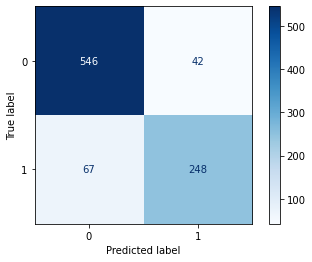

In [11]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues') 

## Step 4: Assessing feature importance
For each of the 11 features in the data, a feature importance plot shows how much the prediction changes if the feature value changes. The bigger the value of the feature importance, the bigger the expected change to the prediction value. Feature importance values are normalized to [0, 100].

### Step 4a: Get feature importance

In [12]:
fea_ = model.feature_importances_

fea_name = list(X.columns)
fea_name = [str(j) for j in fea_name]

for f_name,f in zip(fea_name,fea_):
    print(f_name,':',f)

traffic_density : 26.638743131508885
sa_correct : 6.984130540562224
wl_rating : 6.495648674649652
interbeat_interval : 13.910265340040736
rx : 11.15159385298441
ry : 8.142260815637899
rz : 9.207577768151527
eyeblink : 5.683518119765612
negative : 4.104138998070737
neutral : 4.390313480060402
positive : 3.291809278567916


### Step 4b: Visualize feature importance

<BarContainer object of 11 artists>

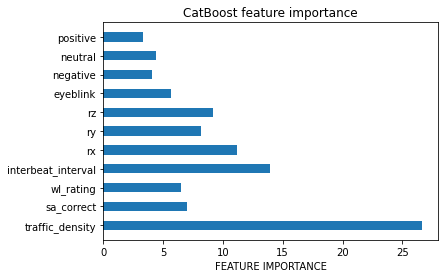

In [13]:
import matplotlib.pyplot as plt

plt.title('CatBoost feature importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.barh(fea_name,fea_,height =0.5)

## Step 4c: Save catboost model

In [14]:
model.save_model('hpmm_catboost_model')

## Step 5: Assess Other Modeling Options
### Model 2: Support Vector Machines (SVM)

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma=2, C=1)
svm.fit(X_train, y_train)

pred = svm.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(svm, X_test, y_test, cmap = 'Blues') 

### Model 3: Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(dt, X_test, y_test, cmap = 'Blues') 

### Model 4: k-Nearest Neighbors (kNN)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(knn, X_test, y_test, cmap = 'Blues') 

### Model 5: Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nn = GaussianNB()
nn.fit(X_train, y_train)

pred = nn.predict(X_test)
print(classification_report(y_test, pred))

In [ ]:
plot_confusion_matrix(nn, X_test, y_test, cmap = 'Blues') 